# Whale Detection Challenge : Preprocess

Method overview : FFT to convert the sound tracks into spectrograms, and apply distinct preprocessing methods such as clipping, noise removal, PCEN and filters. After preprocessing we feed the spectrograms into state of the art light CNN models such as Resnet 18, VGG 16 or GoogleNet to identify right whale call patterns and perform classification. We may also try the removal of pooling layers in the networks and see if it causes better outcome.

In [42]:
import scipy.stats
import numpy as np
import aifc
import matplotlib.pyplot as plt
from matplotlib import mlab, cm
import matplotlib.ticker as plticker
import matplotlib
import pathlib
import pandas as pd
import os
import cv2
import librosa
import librosa.display
import time
import skimage
import shutil

## Preprocess Section

### Preprocessing 0 : contrast-enhanced spectrograms

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  


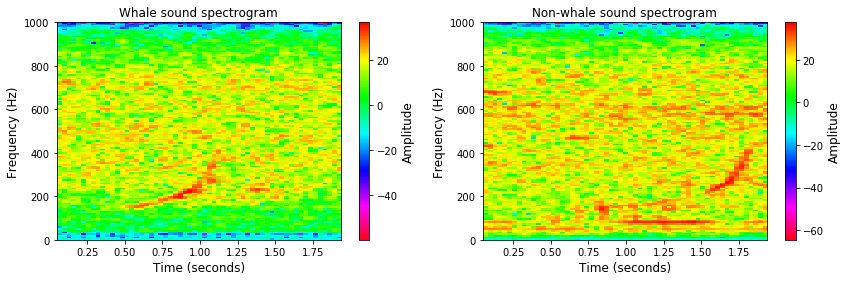

In [43]:
path_data = './data/'
# ReadAIFF function
def ReadAIFF(file):
#Reads the frames from the audio clip and returns the uncompressed data '
    s = aifc.open(file,'r')
    nFrames = s.getnframes()
    strSig = s.readframes(nFrames)
    return np.fromstring(strSig, np.short).byteswap()

def plot_sbs_spectrogram(filename_whale, filename_non_whale):
    whale = ReadAIFF(filename_whale)
    nonwhale = ReadAIFF(filename_non_whale)
    plt.figure(figsize = (14,4))
    ax1 = plt.subplot(121)
    my_cmap = matplotlib.cm.get_cmap('hsv_r');
    params = {'NFFT':256, 'Fs':2000, 'noverlap':192, 'cmap' : my_cmap}
    plt.specgram(whale, **params);
    ax1.set_title('Whale sound spectrogram', fontsize = 12)
    ax1.set_xlabel('Time (seconds)', fontsize = 12)
    ax1.set_ylabel('Frequency (Hz)', fontsize = 12)
    cbar = plt.colorbar()
    cbar.set_label('Amplitude', fontsize = 12)
    ax2 = plt.subplot(122)
    plt.specgram(nonwhale, **params);
    ax2.set_title('Non-whale sound spectrogram', fontsize = 12)
    ax2.set_xlabel('Time (seconds)', fontsize = 12)
    ax2.set_ylabel('Frequency (Hz)', fontsize = 12)
    cbar = plt.colorbar()
    cbar.set_label('Amplitude', fontsize = 12)
    plt.show()
   
# Compare several examples:
plot_sbs_spectrogram(path_data+'train/train6.aiff', path_data+'train/train1.aiff')

In [44]:
# transform all aiffs to np.ndarray and save
def to_spec_and_enhance(filename):
    data = ReadAIFF(filename)
    my_cmap = matplotlib.cm.get_cmap('hsv_r');
    params = {'NFFT':256, 'Fs':2000, 'noverlap':192, 'cmap' : my_cmap}
    spectrum,freq,t,im = plt.specgram(data, **params)
    image_enhanced = scipy.stats.zscore(spectrum, axis=None)
    image_enhanced = 255*(image_enhanced - image_enhanced.min()) / (image_enhanced.max() - image_enhanced.min())
    image_enhanced = image_enhanced.astype(np.uint8)
    #print(image_enhanced)
    #print(np.amin(image_enhanced))
    #print(np.amax(image_enhanced))
    image_enhanced = cv2.equalizeHist(image_enhanced)
    #print(type(np.transpose(spectrum)))
    #print(np.transpose(spectrum).shape)
    return np.transpose(image_enhanced)

### Preprocessing 1 : noise removal

In [45]:
# Convolution and then filter
def noiseFilter(image_array, inner=3, vouter=59, houter=32, maxM=50, norm=True):
    P=image_array
    Q=P.copy()
    Q=cv2.fastNlMeansDenoising(Q)
    m,n=Q.shape
    if(norm):
        mval,sval=np.mean(Q[:maxM,:]),np.std(Q[:maxM,:])
        # Extreme values are capped to mean ± 1.5 std
        fact_=1.5
        upper=mval+fact_*sval   
        lower=mval-fact_*sval
        Q[Q>upper]=upper
        Q[Q<lower]=lower
    wInner=np.ones(inner)
    vOuter=np.ones(vouter)
    hOuter=np.ones(houter)
    #convolution
    #for i in range(n):
    #    Q[:,i]=Q[:,i]-(np.convolve(Q[:,i],vOuter,'same')-np.convolve(Q[:,i],wInner,'same'))/(vouter-inner)
    #for i in range(m):
    #    Q[i,:]=Q[i,:]-(np.convolve(Q[i,:],hOuter,'same')-np.convolve(Q[i,:],wInner,'same'))/(houter-inner)

    return Q[:maxM,:]

###  Preprocessing 2 : filters

###  Preprocessing 3 : PCEN 

In [53]:
# please install librosa first
# pip install librosa

# We recommend scaling the spec data to the range [-2**31, 2**31[ 
# we use magnitude spectrum instead of a power spectrum.

def PCEN(image_array):
    db_img = image_array      
    # it uses amp_img instead of db
    amp_img = librosa.db_to_amplitude(db_img)
    amp_img = amp_img/np.max(amp_img)
#     print(np.max(amp_img))
    
# #     log_S = librosa.amplitude_to_db(S, ref=np.max)
#     # scale the value to the maximum range
    pcen_img = librosa.pcen(amp_img * (2**31))
    
    # disable display when is not debugging
#     plt.clf()
#     plt.figure()
#     plt.subplot(2,1,1)
#     librosa.display.specshow(db_img, x_axis='time', y_axis='mel')
    
#     plt.title('log amplitude (dB)')
#     plt.colorbar()
#     plt.subplot(2,1,2)
#     librosa.display.specshow(pcen_img, x_axis='time', y_axis='mel')
#     plt.title('Per-channel energy normalization')
#     plt.colorbar()
#     plt.tight_layout()
#     plt.show()
    
    ## modification
#     plt.figure()
#     ax1 = plt.subplot(2, 1, 1)
#     my_cmap = matplotlib.cm.get_cmap('hsv_r');
#     plt.imshow(db_img);
#     ax1.set_xlabel('Time (seconds)', fontsize = 12)
#     ax1.set_ylabel('Frequency (Hz)', fontsize = 12)
#     cbar = plt.colorbar()
#     cbar.set_label('Amplitude', fontsize = 12)
    
#     ax2 = plt.subplot(2, 1, 2)
#     plt.imshow(pcen_img)
#     ax2.set_xlabel('Time (seconds)', fontsize = 12)
#     ax2.set_ylabel('Frequency (Hz)', fontsize = 12)
#     cbar = plt.colorbar()
#     cbar.set_label('Amplitude', fontsize = 12)
#     plt.show()
    
    return pcen_img



### Preprocessing 4 : template matching

###  Preprocessing 5 : clipping

### Save proprocess data

In [56]:
train_dir = './data/train/'
test_dir = './data/test/'
train_spec_dir = './data/train_prep/'
test_spec_dir = './data/test_prep/'
def save_transformed_data(src_dir,dst_dir):
    cnt=1
    try:
        shutil.rmtree(dst_dir)
    except OSError as e:
        print("Error: %s : %s" % (dst_dir, e.strerror))
    if not os.path.exists(dst_dir):
        os.makedirs(dst_dir)
    for filename in os.listdir(src_dir):
        if filename.endswith(".aiff"): 
            #print(filename)
            src_path=os.path.join(src_dir,filename)
            dst_path=os.path.join(dst_dir,filename[:-5]+".png")
            
            print("%s %d",src_path,cnt)
            cnt+=1
            
            #print(src_path)
            #print(dst_path)
            processed = to_spec_and_enhance(src_path)
            processed = noiseFilter(processed)
            processed = PCEN(processed)
            processed = skimage.transform.resize(processed, (224,224))
            matplotlib.image.imsave(dst_path,processed)
            
def arrange_transformed_data(src_dir, dst_dir):
    csv_path="data/train.csv"
    train_label = pd.read_csv(csv_path)
    try:
        shutil.rmtree(dst_dir)
    except OSError as e:
        print("Error: %s : %s" % (dst_dir, e.strerror))
    if not os.path.exists(dst_dir+"0/"):
        os.makedirs(dst_dir+"0/")
    if not os.path.exists(dst_dir+"1/"):
        os.makedirs(dst_dir+"1/") 
    for i in range(train_label.shape[0]):
        src_path=os.path.join(src_dir,train_label['clip_name'][i])
        print("%s %d",src_path,i)
        processed = to_spec_and_enhance(src_path)
        processed = noiseFilter(processed)
        processed = PCEN(processed)
        processed = skimage.transform.resize(processed, (224,224))
        if(train_label['label'][i]==1):
            dst_path = os.path.join(dst_dir+"1/",train_label['clip_name'][i][:-5]+".png")
            matplotlib.image.imsave(dst_path,processed)    
        elif (train_label['label'][i]==0):
            dst_path=os.path.join(dst_dir+"0/",train_label['clip_name'][i][:-5]+".png")
            matplotlib.image.imsave(dst_path,processed) 

%s %d ./data/train/train1.aiff 0
%s %d ./data/train/train2.aiff 1
%s %d ./data/train/train3.aiff 2


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  


%s %d ./data/train/train4.aiff 3
%s %d ./data/train/train5.aiff 4
%s %d ./data/train/train6.aiff 5
%s %d ./data/train/train7.aiff 6
%s %d ./data/train/train8.aiff 7
%s %d ./data/train/train9.aiff 8
%s %d ./data/train/train10.aiff 9
%s %d ./data/train/train11.aiff 10
%s %d ./data/train/train12.aiff 11
%s %d ./data/train/train13.aiff 12
%s %d ./data/train/train14.aiff 13
%s %d ./data/train/train15.aiff 14
%s %d ./data/train/train16.aiff 15
%s %d ./data/train/train17.aiff 16
%s %d ./data/train/train18.aiff 17
%s %d ./data/train/train19.aiff 18
%s %d ./data/train/train20.aiff 19
%s %d ./data/train/train21.aiff 20
%s %d ./data/train/train22.aiff 21
%s %d ./data/train/train23.aiff 22
%s %d ./data/train/train24.aiff 23
%s %d ./data/train/train25.aiff 24
%s %d ./data/train/train26.aiff 25
%s %d ./data/train/train27.aiff 26
%s %d ./data/train/train28.aiff 27
%s %d ./data/train/train29.aiff 28
%s %d ./data/train/train30.aiff 29
%s %d ./data/train/train31.aiff 30
%s %d ./data/train/train32.aiff 3

%s %d ./data/train/train232.aiff 231
%s %d ./data/train/train233.aiff 232
%s %d ./data/train/train234.aiff 233
%s %d ./data/train/train235.aiff 234
%s %d ./data/train/train236.aiff 235
%s %d ./data/train/train237.aiff 236
%s %d ./data/train/train238.aiff 237
%s %d ./data/train/train239.aiff 238
%s %d ./data/train/train240.aiff 239
%s %d ./data/train/train241.aiff 240
%s %d ./data/train/train242.aiff 241
%s %d ./data/train/train243.aiff 242
%s %d ./data/train/train244.aiff 243
%s %d ./data/train/train245.aiff 244
%s %d ./data/train/train246.aiff 245
%s %d ./data/train/train247.aiff 246
%s %d ./data/train/train248.aiff 247
%s %d ./data/train/train249.aiff 248
%s %d ./data/train/train250.aiff 249
%s %d ./data/train/train251.aiff 250
%s %d ./data/train/train252.aiff 251
%s %d ./data/train/train253.aiff 252
%s %d ./data/train/train254.aiff 253
%s %d ./data/train/train255.aiff 254
%s %d ./data/train/train256.aiff 255
%s %d ./data/train/train257.aiff 256
%s %d ./data/train/train258.aiff 257
%

%s %d ./data/train/train454.aiff 453
%s %d ./data/train/train455.aiff 454
%s %d ./data/train/train456.aiff 455
%s %d ./data/train/train457.aiff 456
%s %d ./data/train/train458.aiff 457
%s %d ./data/train/train459.aiff 458
%s %d ./data/train/train460.aiff 459
%s %d ./data/train/train461.aiff 460
%s %d ./data/train/train462.aiff 461
%s %d ./data/train/train463.aiff 462
%s %d ./data/train/train464.aiff 463
%s %d ./data/train/train465.aiff 464
%s %d ./data/train/train466.aiff 465
%s %d ./data/train/train467.aiff 466
%s %d ./data/train/train468.aiff 467
%s %d ./data/train/train469.aiff 468
%s %d ./data/train/train470.aiff 469
%s %d ./data/train/train471.aiff 470
%s %d ./data/train/train472.aiff 471
%s %d ./data/train/train473.aiff 472
%s %d ./data/train/train474.aiff 473
%s %d ./data/train/train475.aiff 474
%s %d ./data/train/train476.aiff 475
%s %d ./data/train/train477.aiff 476
%s %d ./data/train/train478.aiff 477
%s %d ./data/train/train479.aiff 478
%s %d ./data/train/train480.aiff 479
%

%s %d ./data/train/train679.aiff 678
%s %d ./data/train/train680.aiff 679
%s %d ./data/train/train681.aiff 680
%s %d ./data/train/train682.aiff 681
%s %d ./data/train/train683.aiff 682
%s %d ./data/train/train684.aiff 683
%s %d ./data/train/train685.aiff 684
%s %d ./data/train/train686.aiff 685
%s %d ./data/train/train687.aiff 686
%s %d ./data/train/train688.aiff 687
%s %d ./data/train/train689.aiff 688
%s %d ./data/train/train690.aiff 689
%s %d ./data/train/train691.aiff 690
%s %d ./data/train/train692.aiff 691
%s %d ./data/train/train693.aiff 692
%s %d ./data/train/train694.aiff 693
%s %d ./data/train/train695.aiff 694
%s %d ./data/train/train696.aiff 695
%s %d ./data/train/train697.aiff 696
%s %d ./data/train/train698.aiff 697
%s %d ./data/train/train699.aiff 698
%s %d ./data/train/train700.aiff 699
%s %d ./data/train/train701.aiff 700
%s %d ./data/train/train702.aiff 701
%s %d ./data/train/train703.aiff 702
%s %d ./data/train/train704.aiff 703
%s %d ./data/train/train705.aiff 704
%

%s %d ./data/train/train901.aiff 900
%s %d ./data/train/train902.aiff 901
%s %d ./data/train/train903.aiff 902
%s %d ./data/train/train904.aiff 903
%s %d ./data/train/train905.aiff 904
%s %d ./data/train/train906.aiff 905
%s %d ./data/train/train907.aiff 906
%s %d ./data/train/train908.aiff 907
%s %d ./data/train/train909.aiff 908
%s %d ./data/train/train910.aiff 909
%s %d ./data/train/train911.aiff 910
%s %d ./data/train/train912.aiff 911
%s %d ./data/train/train913.aiff 912
%s %d ./data/train/train914.aiff 913
%s %d ./data/train/train915.aiff 914
%s %d ./data/train/train916.aiff 915
%s %d ./data/train/train917.aiff 916
%s %d ./data/train/train918.aiff 917
%s %d ./data/train/train919.aiff 918
%s %d ./data/train/train920.aiff 919
%s %d ./data/train/train921.aiff 920
%s %d ./data/train/train922.aiff 921
%s %d ./data/train/train923.aiff 922
%s %d ./data/train/train924.aiff 923
%s %d ./data/train/train925.aiff 924
%s %d ./data/train/train926.aiff 925
%s %d ./data/train/train927.aiff 926
%

%s %d ./data/train/train1117.aiff 1116
%s %d ./data/train/train1118.aiff 1117
%s %d ./data/train/train1119.aiff 1118
%s %d ./data/train/train1120.aiff 1119
%s %d ./data/train/train1121.aiff 1120
%s %d ./data/train/train1122.aiff 1121
%s %d ./data/train/train1123.aiff 1122
%s %d ./data/train/train1124.aiff 1123
%s %d ./data/train/train1125.aiff 1124
%s %d ./data/train/train1126.aiff 1125
%s %d ./data/train/train1127.aiff 1126
%s %d ./data/train/train1128.aiff 1127
%s %d ./data/train/train1129.aiff 1128
%s %d ./data/train/train1130.aiff 1129
%s %d ./data/train/train1131.aiff 1130
%s %d ./data/train/train1132.aiff 1131
%s %d ./data/train/train1133.aiff 1132
%s %d ./data/train/train1134.aiff 1133
%s %d ./data/train/train1135.aiff 1134
%s %d ./data/train/train1136.aiff 1135
%s %d ./data/train/train1137.aiff 1136
%s %d ./data/train/train1138.aiff 1137
%s %d ./data/train/train1139.aiff 1138
%s %d ./data/train/train1140.aiff 1139
%s %d ./data/train/train1141.aiff 1140
%s %d ./data/train/train1

%s %d ./data/train/train1328.aiff 1327
%s %d ./data/train/train1329.aiff 1328
%s %d ./data/train/train1330.aiff 1329
%s %d ./data/train/train1331.aiff 1330
%s %d ./data/train/train1332.aiff 1331
%s %d ./data/train/train1333.aiff 1332
%s %d ./data/train/train1334.aiff 1333
%s %d ./data/train/train1335.aiff 1334
%s %d ./data/train/train1336.aiff 1335
%s %d ./data/train/train1337.aiff 1336
%s %d ./data/train/train1338.aiff 1337
%s %d ./data/train/train1339.aiff 1338
%s %d ./data/train/train1340.aiff 1339
%s %d ./data/train/train1341.aiff 1340
%s %d ./data/train/train1342.aiff 1341
%s %d ./data/train/train1343.aiff 1342
%s %d ./data/train/train1344.aiff 1343
%s %d ./data/train/train1345.aiff 1344
%s %d ./data/train/train1346.aiff 1345
%s %d ./data/train/train1347.aiff 1346
%s %d ./data/train/train1348.aiff 1347
%s %d ./data/train/train1349.aiff 1348
%s %d ./data/train/train1350.aiff 1349
%s %d ./data/train/train1351.aiff 1350
%s %d ./data/train/train1352.aiff 1351
%s %d ./data/train/train1

%s %d ./data/train/train1539.aiff 1538
%s %d ./data/train/train1540.aiff 1539
%s %d ./data/train/train1541.aiff 1540
%s %d ./data/train/train1542.aiff 1541
%s %d ./data/train/train1543.aiff 1542
%s %d ./data/train/train1544.aiff 1543
%s %d ./data/train/train1545.aiff 1544
%s %d ./data/train/train1546.aiff 1545
%s %d ./data/train/train1547.aiff 1546
%s %d ./data/train/train1548.aiff 1547
%s %d ./data/train/train1549.aiff 1548
%s %d ./data/train/train1550.aiff 1549
%s %d ./data/train/train1551.aiff 1550
%s %d ./data/train/train1552.aiff 1551
%s %d ./data/train/train1553.aiff 1552
%s %d ./data/train/train1554.aiff 1553
%s %d ./data/train/train1555.aiff 1554
%s %d ./data/train/train1556.aiff 1555
%s %d ./data/train/train1557.aiff 1556
%s %d ./data/train/train1558.aiff 1557
%s %d ./data/train/train1559.aiff 1558
%s %d ./data/train/train1560.aiff 1559
%s %d ./data/train/train1561.aiff 1560
%s %d ./data/train/train1562.aiff 1561
%s %d ./data/train/train1563.aiff 1562
%s %d ./data/train/train1

%s %d ./data/train/train1752.aiff 1751
%s %d ./data/train/train1753.aiff 1752
%s %d ./data/train/train1754.aiff 1753
%s %d ./data/train/train1755.aiff 1754
%s %d ./data/train/train1756.aiff 1755
%s %d ./data/train/train1757.aiff 1756
%s %d ./data/train/train1758.aiff 1757
%s %d ./data/train/train1759.aiff 1758
%s %d ./data/train/train1760.aiff 1759
%s %d ./data/train/train1761.aiff 1760
%s %d ./data/train/train1762.aiff 1761
%s %d ./data/train/train1763.aiff 1762
%s %d ./data/train/train1764.aiff 1763
%s %d ./data/train/train1765.aiff 1764
%s %d ./data/train/train1766.aiff 1765
%s %d ./data/train/train1767.aiff 1766
%s %d ./data/train/train1768.aiff 1767
%s %d ./data/train/train1769.aiff 1768
%s %d ./data/train/train1770.aiff 1769
%s %d ./data/train/train1771.aiff 1770
%s %d ./data/train/train1772.aiff 1771
%s %d ./data/train/train1773.aiff 1772
%s %d ./data/train/train1774.aiff 1773
%s %d ./data/train/train1775.aiff 1774
%s %d ./data/train/train1776.aiff 1775
%s %d ./data/train/train1

%s %d ./data/train/train1964.aiff 1963
%s %d ./data/train/train1965.aiff 1964
%s %d ./data/train/train1966.aiff 1965
%s %d ./data/train/train1967.aiff 1966
%s %d ./data/train/train1968.aiff 1967
%s %d ./data/train/train1969.aiff 1968
%s %d ./data/train/train1970.aiff 1969
%s %d ./data/train/train1971.aiff 1970
%s %d ./data/train/train1972.aiff 1971
%s %d ./data/train/train1973.aiff 1972
%s %d ./data/train/train1974.aiff 1973
%s %d ./data/train/train1975.aiff 1974
%s %d ./data/train/train1976.aiff 1975
%s %d ./data/train/train1977.aiff 1976
%s %d ./data/train/train1978.aiff 1977
%s %d ./data/train/train1979.aiff 1978
%s %d ./data/train/train1980.aiff 1979
%s %d ./data/train/train1981.aiff 1980
%s %d ./data/train/train1982.aiff 1981
%s %d ./data/train/train1983.aiff 1982
%s %d ./data/train/train1984.aiff 1983
%s %d ./data/train/train1985.aiff 1984
%s %d ./data/train/train1986.aiff 1985
%s %d ./data/train/train1987.aiff 1986
%s %d ./data/train/train1988.aiff 1987
%s %d ./data/train/train1

%s %d ./data/train/train2175.aiff 2174
%s %d ./data/train/train2176.aiff 2175
%s %d ./data/train/train2177.aiff 2176
%s %d ./data/train/train2178.aiff 2177
%s %d ./data/train/train2179.aiff 2178
%s %d ./data/train/train2180.aiff 2179
%s %d ./data/train/train2181.aiff 2180
%s %d ./data/train/train2182.aiff 2181
%s %d ./data/train/train2183.aiff 2182
%s %d ./data/train/train2184.aiff 2183
%s %d ./data/train/train2185.aiff 2184
%s %d ./data/train/train2186.aiff 2185
%s %d ./data/train/train2187.aiff 2186
%s %d ./data/train/train2188.aiff 2187
%s %d ./data/train/train2189.aiff 2188
%s %d ./data/train/train2190.aiff 2189
%s %d ./data/train/train2191.aiff 2190
%s %d ./data/train/train2192.aiff 2191
%s %d ./data/train/train2193.aiff 2192
%s %d ./data/train/train2194.aiff 2193
%s %d ./data/train/train2195.aiff 2194
%s %d ./data/train/train2196.aiff 2195
%s %d ./data/train/train2197.aiff 2196
%s %d ./data/train/train2198.aiff 2197
%s %d ./data/train/train2199.aiff 2198
%s %d ./data/train/train2

%s %d ./data/train/train2386.aiff 2385
%s %d ./data/train/train2387.aiff 2386
%s %d ./data/train/train2388.aiff 2387
%s %d ./data/train/train2389.aiff 2388
%s %d ./data/train/train2390.aiff 2389
%s %d ./data/train/train2391.aiff 2390
%s %d ./data/train/train2392.aiff 2391
%s %d ./data/train/train2393.aiff 2392
%s %d ./data/train/train2394.aiff 2393
%s %d ./data/train/train2395.aiff 2394
%s %d ./data/train/train2396.aiff 2395
%s %d ./data/train/train2397.aiff 2396
%s %d ./data/train/train2398.aiff 2397
%s %d ./data/train/train2399.aiff 2398
%s %d ./data/train/train2400.aiff 2399
%s %d ./data/train/train2401.aiff 2400
%s %d ./data/train/train2402.aiff 2401
%s %d ./data/train/train2403.aiff 2402
%s %d ./data/train/train2404.aiff 2403
%s %d ./data/train/train2405.aiff 2404
%s %d ./data/train/train2406.aiff 2405
%s %d ./data/train/train2407.aiff 2406
%s %d ./data/train/train2408.aiff 2407
%s %d ./data/train/train2409.aiff 2408
%s %d ./data/train/train2410.aiff 2409
%s %d ./data/train/train2

%s %d ./data/train/train2598.aiff 2597
%s %d ./data/train/train2599.aiff 2598
%s %d ./data/train/train2600.aiff 2599
%s %d ./data/train/train2601.aiff 2600
%s %d ./data/train/train2602.aiff 2601
%s %d ./data/train/train2603.aiff 2602
%s %d ./data/train/train2604.aiff 2603
%s %d ./data/train/train2605.aiff 2604
%s %d ./data/train/train2606.aiff 2605
%s %d ./data/train/train2607.aiff 2606
%s %d ./data/train/train2608.aiff 2607
%s %d ./data/train/train2609.aiff 2608
%s %d ./data/train/train2610.aiff 2609
%s %d ./data/train/train2611.aiff 2610
%s %d ./data/train/train2612.aiff 2611
%s %d ./data/train/train2613.aiff 2612
%s %d ./data/train/train2614.aiff 2613
%s %d ./data/train/train2615.aiff 2614
%s %d ./data/train/train2616.aiff 2615
%s %d ./data/train/train2617.aiff 2616
%s %d ./data/train/train2618.aiff 2617
%s %d ./data/train/train2619.aiff 2618
%s %d ./data/train/train2620.aiff 2619
%s %d ./data/train/train2621.aiff 2620
%s %d ./data/train/train2622.aiff 2621
%s %d ./data/train/train2

%s %d ./data/train/train2813.aiff 2812
%s %d ./data/train/train2814.aiff 2813
%s %d ./data/train/train2815.aiff 2814
%s %d ./data/train/train2816.aiff 2815
%s %d ./data/train/train2817.aiff 2816
%s %d ./data/train/train2818.aiff 2817
%s %d ./data/train/train2819.aiff 2818
%s %d ./data/train/train2820.aiff 2819
%s %d ./data/train/train2821.aiff 2820
%s %d ./data/train/train2822.aiff 2821
%s %d ./data/train/train2823.aiff 2822
%s %d ./data/train/train2824.aiff 2823
%s %d ./data/train/train2825.aiff 2824
%s %d ./data/train/train2826.aiff 2825
%s %d ./data/train/train2827.aiff 2826
%s %d ./data/train/train2828.aiff 2827
%s %d ./data/train/train2829.aiff 2828
%s %d ./data/train/train2830.aiff 2829
%s %d ./data/train/train2831.aiff 2830
%s %d ./data/train/train2832.aiff 2831
%s %d ./data/train/train2833.aiff 2832
%s %d ./data/train/train2834.aiff 2833
%s %d ./data/train/train2835.aiff 2834
%s %d ./data/train/train2836.aiff 2835
%s %d ./data/train/train2837.aiff 2836
%s %d ./data/train/train2

%s %d ./data/train/train3027.aiff 3026
%s %d ./data/train/train3028.aiff 3027
%s %d ./data/train/train3029.aiff 3028
%s %d ./data/train/train3030.aiff 3029
%s %d ./data/train/train3031.aiff 3030
%s %d ./data/train/train3032.aiff 3031
%s %d ./data/train/train3033.aiff 3032
%s %d ./data/train/train3034.aiff 3033
%s %d ./data/train/train3035.aiff 3034
%s %d ./data/train/train3036.aiff 3035
%s %d ./data/train/train3037.aiff 3036
%s %d ./data/train/train3038.aiff 3037
%s %d ./data/train/train3039.aiff 3038
%s %d ./data/train/train3040.aiff 3039
%s %d ./data/train/train3041.aiff 3040
%s %d ./data/train/train3042.aiff 3041
%s %d ./data/train/train3043.aiff 3042
%s %d ./data/train/train3044.aiff 3043
%s %d ./data/train/train3045.aiff 3044
%s %d ./data/train/train3046.aiff 3045
%s %d ./data/train/train3047.aiff 3046
%s %d ./data/train/train3048.aiff 3047
%s %d ./data/train/train3049.aiff 3048
%s %d ./data/train/train3050.aiff 3049
%s %d ./data/train/train3051.aiff 3050
%s %d ./data/train/train3

%s %d ./data/train/train3240.aiff 3239
%s %d ./data/train/train3241.aiff 3240
%s %d ./data/train/train3242.aiff 3241
%s %d ./data/train/train3243.aiff 3242
%s %d ./data/train/train3244.aiff 3243
%s %d ./data/train/train3245.aiff 3244
%s %d ./data/train/train3246.aiff 3245
%s %d ./data/train/train3247.aiff 3246
%s %d ./data/train/train3248.aiff 3247
%s %d ./data/train/train3249.aiff 3248
%s %d ./data/train/train3250.aiff 3249
%s %d ./data/train/train3251.aiff 3250
%s %d ./data/train/train3252.aiff 3251
%s %d ./data/train/train3253.aiff 3252
%s %d ./data/train/train3254.aiff 3253
%s %d ./data/train/train3255.aiff 3254
%s %d ./data/train/train3256.aiff 3255
%s %d ./data/train/train3257.aiff 3256
%s %d ./data/train/train3258.aiff 3257
%s %d ./data/train/train3259.aiff 3258
%s %d ./data/train/train3260.aiff 3259
%s %d ./data/train/train3261.aiff 3260
%s %d ./data/train/train3262.aiff 3261
%s %d ./data/train/train3263.aiff 3262
%s %d ./data/train/train3264.aiff 3263
%s %d ./data/train/train3

%s %d ./data/train/train3453.aiff 3452
%s %d ./data/train/train3454.aiff 3453
%s %d ./data/train/train3455.aiff 3454
%s %d ./data/train/train3456.aiff 3455
%s %d ./data/train/train3457.aiff 3456
%s %d ./data/train/train3458.aiff 3457
%s %d ./data/train/train3459.aiff 3458
%s %d ./data/train/train3460.aiff 3459
%s %d ./data/train/train3461.aiff 3460
%s %d ./data/train/train3462.aiff 3461
%s %d ./data/train/train3463.aiff 3462
%s %d ./data/train/train3464.aiff 3463
%s %d ./data/train/train3465.aiff 3464
%s %d ./data/train/train3466.aiff 3465
%s %d ./data/train/train3467.aiff 3466
%s %d ./data/train/train3468.aiff 3467
%s %d ./data/train/train3469.aiff 3468
%s %d ./data/train/train3470.aiff 3469
%s %d ./data/train/train3471.aiff 3470
%s %d ./data/train/train3472.aiff 3471
%s %d ./data/train/train3473.aiff 3472
%s %d ./data/train/train3474.aiff 3473
%s %d ./data/train/train3475.aiff 3474
%s %d ./data/train/train3476.aiff 3475
%s %d ./data/train/train3477.aiff 3476
%s %d ./data/train/train3

%s %d ./data/train/train3666.aiff 3665
%s %d ./data/train/train3667.aiff 3666
%s %d ./data/train/train3668.aiff 3667
%s %d ./data/train/train3669.aiff 3668
%s %d ./data/train/train3670.aiff 3669
%s %d ./data/train/train3671.aiff 3670
%s %d ./data/train/train3672.aiff 3671
%s %d ./data/train/train3673.aiff 3672
%s %d ./data/train/train3674.aiff 3673
%s %d ./data/train/train3675.aiff 3674
%s %d ./data/train/train3676.aiff 3675
%s %d ./data/train/train3677.aiff 3676
%s %d ./data/train/train3678.aiff 3677
%s %d ./data/train/train3679.aiff 3678
%s %d ./data/train/train3680.aiff 3679
%s %d ./data/train/train3681.aiff 3680
%s %d ./data/train/train3682.aiff 3681
%s %d ./data/train/train3683.aiff 3682
%s %d ./data/train/train3684.aiff 3683
%s %d ./data/train/train3685.aiff 3684
%s %d ./data/train/train3686.aiff 3685
%s %d ./data/train/train3687.aiff 3686
%s %d ./data/train/train3688.aiff 3687
%s %d ./data/train/train3689.aiff 3688
%s %d ./data/train/train3690.aiff 3689
%s %d ./data/train/train3

%s %d ./data/train/train3881.aiff 3880
%s %d ./data/train/train3882.aiff 3881
%s %d ./data/train/train3883.aiff 3882
%s %d ./data/train/train3884.aiff 3883
%s %d ./data/train/train3885.aiff 3884
%s %d ./data/train/train3886.aiff 3885
%s %d ./data/train/train3887.aiff 3886
%s %d ./data/train/train3888.aiff 3887
%s %d ./data/train/train3889.aiff 3888
%s %d ./data/train/train3890.aiff 3889
%s %d ./data/train/train3891.aiff 3890
%s %d ./data/train/train3892.aiff 3891
%s %d ./data/train/train3893.aiff 3892
%s %d ./data/train/train3894.aiff 3893
%s %d ./data/train/train3895.aiff 3894
%s %d ./data/train/train3896.aiff 3895
%s %d ./data/train/train3897.aiff 3896
%s %d ./data/train/train3898.aiff 3897
%s %d ./data/train/train3899.aiff 3898
%s %d ./data/train/train3900.aiff 3899
%s %d ./data/train/train3901.aiff 3900
%s %d ./data/train/train3902.aiff 3901
%s %d ./data/train/train3903.aiff 3902
%s %d ./data/train/train3904.aiff 3903
%s %d ./data/train/train3905.aiff 3904
%s %d ./data/train/train3

%s %d ./data/train/train4092.aiff 4091
%s %d ./data/train/train4093.aiff 4092
%s %d ./data/train/train4094.aiff 4093
%s %d ./data/train/train4095.aiff 4094
%s %d ./data/train/train4096.aiff 4095
%s %d ./data/train/train4097.aiff 4096
%s %d ./data/train/train4098.aiff 4097
%s %d ./data/train/train4099.aiff 4098
%s %d ./data/train/train4100.aiff 4099
%s %d ./data/train/train4101.aiff 4100
%s %d ./data/train/train4102.aiff 4101
%s %d ./data/train/train4103.aiff 4102
%s %d ./data/train/train4104.aiff 4103
%s %d ./data/train/train4105.aiff 4104
%s %d ./data/train/train4106.aiff 4105
%s %d ./data/train/train4107.aiff 4106
%s %d ./data/train/train4108.aiff 4107
%s %d ./data/train/train4109.aiff 4108
%s %d ./data/train/train4110.aiff 4109
%s %d ./data/train/train4111.aiff 4110
%s %d ./data/train/train4112.aiff 4111
%s %d ./data/train/train4113.aiff 4112
%s %d ./data/train/train4114.aiff 4113
%s %d ./data/train/train4115.aiff 4114
%s %d ./data/train/train4116.aiff 4115
%s %d ./data/train/train4

%s %d ./data/train/train4303.aiff 4302
%s %d ./data/train/train4304.aiff 4303
%s %d ./data/train/train4305.aiff 4304
%s %d ./data/train/train4306.aiff 4305
%s %d ./data/train/train4307.aiff 4306
%s %d ./data/train/train4308.aiff 4307
%s %d ./data/train/train4309.aiff 4308
%s %d ./data/train/train4310.aiff 4309
%s %d ./data/train/train4311.aiff 4310
%s %d ./data/train/train4312.aiff 4311
%s %d ./data/train/train4313.aiff 4312
%s %d ./data/train/train4314.aiff 4313
%s %d ./data/train/train4315.aiff 4314
%s %d ./data/train/train4316.aiff 4315
%s %d ./data/train/train4317.aiff 4316
%s %d ./data/train/train4318.aiff 4317
%s %d ./data/train/train4319.aiff 4318
%s %d ./data/train/train4320.aiff 4319
%s %d ./data/train/train4321.aiff 4320
%s %d ./data/train/train4322.aiff 4321
%s %d ./data/train/train4323.aiff 4322
%s %d ./data/train/train4324.aiff 4323
%s %d ./data/train/train4325.aiff 4324
%s %d ./data/train/train4326.aiff 4325
%s %d ./data/train/train4327.aiff 4326
%s %d ./data/train/train4

%s %d ./data/train/train4516.aiff 4515
%s %d ./data/train/train4517.aiff 4516
%s %d ./data/train/train4518.aiff 4517
%s %d ./data/train/train4519.aiff 4518
%s %d ./data/train/train4520.aiff 4519
%s %d ./data/train/train4521.aiff 4520
%s %d ./data/train/train4522.aiff 4521
%s %d ./data/train/train4523.aiff 4522
%s %d ./data/train/train4524.aiff 4523
%s %d ./data/train/train4525.aiff 4524
%s %d ./data/train/train4526.aiff 4525
%s %d ./data/train/train4527.aiff 4526
%s %d ./data/train/train4528.aiff 4527
%s %d ./data/train/train4529.aiff 4528
%s %d ./data/train/train4530.aiff 4529
%s %d ./data/train/train4531.aiff 4530
%s %d ./data/train/train4532.aiff 4531
%s %d ./data/train/train4533.aiff 4532
%s %d ./data/train/train4534.aiff 4533
%s %d ./data/train/train4535.aiff 4534
%s %d ./data/train/train4536.aiff 4535
%s %d ./data/train/train4537.aiff 4536
%s %d ./data/train/train4538.aiff 4537
%s %d ./data/train/train4539.aiff 4538
%s %d ./data/train/train4540.aiff 4539
%s %d ./data/train/train4

%s %d ./data/train/train4730.aiff 4729
%s %d ./data/train/train4731.aiff 4730
%s %d ./data/train/train4732.aiff 4731
%s %d ./data/train/train4733.aiff 4732
%s %d ./data/train/train4734.aiff 4733
%s %d ./data/train/train4735.aiff 4734
%s %d ./data/train/train4736.aiff 4735
%s %d ./data/train/train4737.aiff 4736
%s %d ./data/train/train4738.aiff 4737
%s %d ./data/train/train4739.aiff 4738
%s %d ./data/train/train4740.aiff 4739
%s %d ./data/train/train4741.aiff 4740
%s %d ./data/train/train4742.aiff 4741
%s %d ./data/train/train4743.aiff 4742
%s %d ./data/train/train4744.aiff 4743
%s %d ./data/train/train4745.aiff 4744
%s %d ./data/train/train4746.aiff 4745
%s %d ./data/train/train4747.aiff 4746
%s %d ./data/train/train4748.aiff 4747
%s %d ./data/train/train4749.aiff 4748
%s %d ./data/train/train4750.aiff 4749
%s %d ./data/train/train4751.aiff 4750
%s %d ./data/train/train4752.aiff 4751
%s %d ./data/train/train4753.aiff 4752
%s %d ./data/train/train4754.aiff 4753
%s %d ./data/train/train4

%s %d ./data/train/train4942.aiff 4941
%s %d ./data/train/train4943.aiff 4942
%s %d ./data/train/train4944.aiff 4943
%s %d ./data/train/train4945.aiff 4944
%s %d ./data/train/train4946.aiff 4945
%s %d ./data/train/train4947.aiff 4946
%s %d ./data/train/train4948.aiff 4947
%s %d ./data/train/train4949.aiff 4948
%s %d ./data/train/train4950.aiff 4949
%s %d ./data/train/train4951.aiff 4950
%s %d ./data/train/train4952.aiff 4951
%s %d ./data/train/train4953.aiff 4952
%s %d ./data/train/train4954.aiff 4953
%s %d ./data/train/train4955.aiff 4954
%s %d ./data/train/train4956.aiff 4955
%s %d ./data/train/train4957.aiff 4956
%s %d ./data/train/train4958.aiff 4957
%s %d ./data/train/train4959.aiff 4958
%s %d ./data/train/train4960.aiff 4959
%s %d ./data/train/train4961.aiff 4960
%s %d ./data/train/train4962.aiff 4961
%s %d ./data/train/train4963.aiff 4962
%s %d ./data/train/train4964.aiff 4963
%s %d ./data/train/train4965.aiff 4964
%s %d ./data/train/train4966.aiff 4965
%s %d ./data/train/train4

%s %d ./data/train/train5154.aiff 5153
%s %d ./data/train/train5155.aiff 5154
%s %d ./data/train/train5156.aiff 5155
%s %d ./data/train/train5157.aiff 5156
%s %d ./data/train/train5158.aiff 5157
%s %d ./data/train/train5159.aiff 5158
%s %d ./data/train/train5160.aiff 5159
%s %d ./data/train/train5161.aiff 5160
%s %d ./data/train/train5162.aiff 5161
%s %d ./data/train/train5163.aiff 5162
%s %d ./data/train/train5164.aiff 5163
%s %d ./data/train/train5165.aiff 5164
%s %d ./data/train/train5166.aiff 5165
%s %d ./data/train/train5167.aiff 5166
%s %d ./data/train/train5168.aiff 5167
%s %d ./data/train/train5169.aiff 5168
%s %d ./data/train/train5170.aiff 5169
%s %d ./data/train/train5171.aiff 5170
%s %d ./data/train/train5172.aiff 5171
%s %d ./data/train/train5173.aiff 5172
%s %d ./data/train/train5174.aiff 5173
%s %d ./data/train/train5175.aiff 5174
%s %d ./data/train/train5176.aiff 5175
%s %d ./data/train/train5177.aiff 5176
%s %d ./data/train/train5178.aiff 5177
%s %d ./data/train/train5

%s %d ./data/train/train5368.aiff 5367
%s %d ./data/train/train5369.aiff 5368
%s %d ./data/train/train5370.aiff 5369
%s %d ./data/train/train5371.aiff 5370
%s %d ./data/train/train5372.aiff 5371
%s %d ./data/train/train5373.aiff 5372
%s %d ./data/train/train5374.aiff 5373
%s %d ./data/train/train5375.aiff 5374
%s %d ./data/train/train5376.aiff 5375
%s %d ./data/train/train5377.aiff 5376
%s %d ./data/train/train5378.aiff 5377
%s %d ./data/train/train5379.aiff 5378
%s %d ./data/train/train5380.aiff 5379
%s %d ./data/train/train5381.aiff 5380
%s %d ./data/train/train5382.aiff 5381
%s %d ./data/train/train5383.aiff 5382
%s %d ./data/train/train5384.aiff 5383
%s %d ./data/train/train5385.aiff 5384
%s %d ./data/train/train5386.aiff 5385
%s %d ./data/train/train5387.aiff 5386
%s %d ./data/train/train5388.aiff 5387
%s %d ./data/train/train5389.aiff 5388
%s %d ./data/train/train5390.aiff 5389
%s %d ./data/train/train5391.aiff 5390
%s %d ./data/train/train5392.aiff 5391
%s %d ./data/train/train5

%s %d ./data/train/train5583.aiff 5582
%s %d ./data/train/train5584.aiff 5583
%s %d ./data/train/train5585.aiff 5584
%s %d ./data/train/train5586.aiff 5585
%s %d ./data/train/train5587.aiff 5586
%s %d ./data/train/train5588.aiff 5587
%s %d ./data/train/train5589.aiff 5588
%s %d ./data/train/train5590.aiff 5589
%s %d ./data/train/train5591.aiff 5590
%s %d ./data/train/train5592.aiff 5591
%s %d ./data/train/train5593.aiff 5592
%s %d ./data/train/train5594.aiff 5593
%s %d ./data/train/train5595.aiff 5594
%s %d ./data/train/train5596.aiff 5595
%s %d ./data/train/train5597.aiff 5596
%s %d ./data/train/train5598.aiff 5597
%s %d ./data/train/train5599.aiff 5598
%s %d ./data/train/train5600.aiff 5599
%s %d ./data/train/train5601.aiff 5600
%s %d ./data/train/train5602.aiff 5601
%s %d ./data/train/train5603.aiff 5602
%s %d ./data/train/train5604.aiff 5603
%s %d ./data/train/train5605.aiff 5604
%s %d ./data/train/train5606.aiff 5605
%s %d ./data/train/train5607.aiff 5606
%s %d ./data/train/train5

%s %d ./data/train/train5795.aiff 5794
%s %d ./data/train/train5796.aiff 5795
%s %d ./data/train/train5797.aiff 5796
%s %d ./data/train/train5798.aiff 5797
%s %d ./data/train/train5799.aiff 5798
%s %d ./data/train/train5800.aiff 5799
%s %d ./data/train/train5801.aiff 5800
%s %d ./data/train/train5802.aiff 5801
%s %d ./data/train/train5803.aiff 5802
%s %d ./data/train/train5804.aiff 5803
%s %d ./data/train/train5805.aiff 5804
%s %d ./data/train/train5806.aiff 5805
%s %d ./data/train/train5807.aiff 5806
%s %d ./data/train/train5808.aiff 5807
%s %d ./data/train/train5809.aiff 5808
%s %d ./data/train/train5810.aiff 5809
%s %d ./data/train/train5811.aiff 5810
%s %d ./data/train/train5812.aiff 5811
%s %d ./data/train/train5813.aiff 5812
%s %d ./data/train/train5814.aiff 5813
%s %d ./data/train/train5815.aiff 5814
%s %d ./data/train/train5816.aiff 5815
%s %d ./data/train/train5817.aiff 5816
%s %d ./data/train/train5818.aiff 5817
%s %d ./data/train/train5819.aiff 5818
%s %d ./data/train/train5

%s %d ./data/train/train6006.aiff 6005
%s %d ./data/train/train6007.aiff 6006
%s %d ./data/train/train6008.aiff 6007
%s %d ./data/train/train6009.aiff 6008
%s %d ./data/train/train6010.aiff 6009
%s %d ./data/train/train6011.aiff 6010
%s %d ./data/train/train6012.aiff 6011
%s %d ./data/train/train6013.aiff 6012
%s %d ./data/train/train6014.aiff 6013
%s %d ./data/train/train6015.aiff 6014
%s %d ./data/train/train6016.aiff 6015
%s %d ./data/train/train6017.aiff 6016
%s %d ./data/train/train6018.aiff 6017
%s %d ./data/train/train6019.aiff 6018
%s %d ./data/train/train6020.aiff 6019
%s %d ./data/train/train6021.aiff 6020
%s %d ./data/train/train6022.aiff 6021
%s %d ./data/train/train6023.aiff 6022
%s %d ./data/train/train6024.aiff 6023
%s %d ./data/train/train6025.aiff 6024
%s %d ./data/train/train6026.aiff 6025
%s %d ./data/train/train6027.aiff 6026
%s %d ./data/train/train6028.aiff 6027
%s %d ./data/train/train6029.aiff 6028
%s %d ./data/train/train6030.aiff 6029
%s %d ./data/train/train6

%s %d ./data/train/train6220.aiff 6219
%s %d ./data/train/train6221.aiff 6220
%s %d ./data/train/train6222.aiff 6221
%s %d ./data/train/train6223.aiff 6222
%s %d ./data/train/train6224.aiff 6223
%s %d ./data/train/train6225.aiff 6224
%s %d ./data/train/train6226.aiff 6225
%s %d ./data/train/train6227.aiff 6226
%s %d ./data/train/train6228.aiff 6227
%s %d ./data/train/train6229.aiff 6228
%s %d ./data/train/train6230.aiff 6229
%s %d ./data/train/train6231.aiff 6230
%s %d ./data/train/train6232.aiff 6231
%s %d ./data/train/train6233.aiff 6232
%s %d ./data/train/train6234.aiff 6233
%s %d ./data/train/train6235.aiff 6234
%s %d ./data/train/train6236.aiff 6235
%s %d ./data/train/train6237.aiff 6236
%s %d ./data/train/train6238.aiff 6237
%s %d ./data/train/train6239.aiff 6238
%s %d ./data/train/train6240.aiff 6239
%s %d ./data/train/train6241.aiff 6240
%s %d ./data/train/train6242.aiff 6241
%s %d ./data/train/train6243.aiff 6242
%s %d ./data/train/train6244.aiff 6243
%s %d ./data/train/train6

%s %d ./data/train/train6434.aiff 6433
%s %d ./data/train/train6435.aiff 6434
%s %d ./data/train/train6436.aiff 6435
%s %d ./data/train/train6437.aiff 6436
%s %d ./data/train/train6438.aiff 6437
%s %d ./data/train/train6439.aiff 6438
%s %d ./data/train/train6440.aiff 6439
%s %d ./data/train/train6441.aiff 6440
%s %d ./data/train/train6442.aiff 6441
%s %d ./data/train/train6443.aiff 6442
%s %d ./data/train/train6444.aiff 6443
%s %d ./data/train/train6445.aiff 6444
%s %d ./data/train/train6446.aiff 6445
%s %d ./data/train/train6447.aiff 6446
%s %d ./data/train/train6448.aiff 6447
%s %d ./data/train/train6449.aiff 6448
%s %d ./data/train/train6450.aiff 6449
%s %d ./data/train/train6451.aiff 6450
%s %d ./data/train/train6452.aiff 6451
%s %d ./data/train/train6453.aiff 6452
%s %d ./data/train/train6454.aiff 6453
%s %d ./data/train/train6455.aiff 6454
%s %d ./data/train/train6456.aiff 6455
%s %d ./data/train/train6457.aiff 6456
%s %d ./data/train/train6458.aiff 6457
%s %d ./data/train/train6

%s %d ./data/train/train6646.aiff 6645
%s %d ./data/train/train6647.aiff 6646
%s %d ./data/train/train6648.aiff 6647
%s %d ./data/train/train6649.aiff 6648
%s %d ./data/train/train6650.aiff 6649
%s %d ./data/train/train6651.aiff 6650
%s %d ./data/train/train6652.aiff 6651
%s %d ./data/train/train6653.aiff 6652
%s %d ./data/train/train6654.aiff 6653
%s %d ./data/train/train6655.aiff 6654
%s %d ./data/train/train6656.aiff 6655
%s %d ./data/train/train6657.aiff 6656
%s %d ./data/train/train6658.aiff 6657
%s %d ./data/train/train6659.aiff 6658
%s %d ./data/train/train6660.aiff 6659
%s %d ./data/train/train6661.aiff 6660
%s %d ./data/train/train6662.aiff 6661
%s %d ./data/train/train6663.aiff 6662
%s %d ./data/train/train6664.aiff 6663
%s %d ./data/train/train6665.aiff 6664
%s %d ./data/train/train6666.aiff 6665
%s %d ./data/train/train6667.aiff 6666
%s %d ./data/train/train6668.aiff 6667
%s %d ./data/train/train6669.aiff 6668
%s %d ./data/train/train6670.aiff 6669
%s %d ./data/train/train6

%s %d ./data/train/train6857.aiff 6856
%s %d ./data/train/train6858.aiff 6857
%s %d ./data/train/train6859.aiff 6858
%s %d ./data/train/train6860.aiff 6859
%s %d ./data/train/train6861.aiff 6860
%s %d ./data/train/train6862.aiff 6861
%s %d ./data/train/train6863.aiff 6862
%s %d ./data/train/train6864.aiff 6863
%s %d ./data/train/train6865.aiff 6864
%s %d ./data/train/train6866.aiff 6865
%s %d ./data/train/train6867.aiff 6866
%s %d ./data/train/train6868.aiff 6867
%s %d ./data/train/train6869.aiff 6868
%s %d ./data/train/train6870.aiff 6869
%s %d ./data/train/train6871.aiff 6870
%s %d ./data/train/train6872.aiff 6871
%s %d ./data/train/train6873.aiff 6872
%s %d ./data/train/train6874.aiff 6873
%s %d ./data/train/train6875.aiff 6874
%s %d ./data/train/train6876.aiff 6875
%s %d ./data/train/train6877.aiff 6876
%s %d ./data/train/train6878.aiff 6877
%s %d ./data/train/train6879.aiff 6878
%s %d ./data/train/train6880.aiff 6879
%s %d ./data/train/train6881.aiff 6880
%s %d ./data/train/train6

%s %d ./data/train/train7070.aiff 7069
%s %d ./data/train/train7071.aiff 7070
%s %d ./data/train/train7072.aiff 7071
%s %d ./data/train/train7073.aiff 7072
%s %d ./data/train/train7074.aiff 7073
%s %d ./data/train/train7075.aiff 7074
%s %d ./data/train/train7076.aiff 7075
%s %d ./data/train/train7077.aiff 7076
%s %d ./data/train/train7078.aiff 7077
%s %d ./data/train/train7079.aiff 7078
%s %d ./data/train/train7080.aiff 7079
%s %d ./data/train/train7081.aiff 7080
%s %d ./data/train/train7082.aiff 7081
%s %d ./data/train/train7083.aiff 7082
%s %d ./data/train/train7084.aiff 7083
%s %d ./data/train/train7085.aiff 7084
%s %d ./data/train/train7086.aiff 7085
%s %d ./data/train/train7087.aiff 7086
%s %d ./data/train/train7088.aiff 7087
%s %d ./data/train/train7089.aiff 7088
%s %d ./data/train/train7090.aiff 7089
%s %d ./data/train/train7091.aiff 7090
%s %d ./data/train/train7092.aiff 7091
%s %d ./data/train/train7093.aiff 7092
%s %d ./data/train/train7094.aiff 7093
%s %d ./data/train/train7

%s %d ./data/train/train7282.aiff 7281
%s %d ./data/train/train7283.aiff 7282
%s %d ./data/train/train7284.aiff 7283
%s %d ./data/train/train7285.aiff 7284
%s %d ./data/train/train7286.aiff 7285
%s %d ./data/train/train7287.aiff 7286
%s %d ./data/train/train7288.aiff 7287
%s %d ./data/train/train7289.aiff 7288
%s %d ./data/train/train7290.aiff 7289
%s %d ./data/train/train7291.aiff 7290
%s %d ./data/train/train7292.aiff 7291
%s %d ./data/train/train7293.aiff 7292
%s %d ./data/train/train7294.aiff 7293
%s %d ./data/train/train7295.aiff 7294
%s %d ./data/train/train7296.aiff 7295
%s %d ./data/train/train7297.aiff 7296
%s %d ./data/train/train7298.aiff 7297
%s %d ./data/train/train7299.aiff 7298
%s %d ./data/train/train7300.aiff 7299
%s %d ./data/train/train7301.aiff 7300
%s %d ./data/train/train7302.aiff 7301
%s %d ./data/train/train7303.aiff 7302
%s %d ./data/train/train7304.aiff 7303
%s %d ./data/train/train7305.aiff 7304
%s %d ./data/train/train7306.aiff 7305
%s %d ./data/train/train7

%s %d ./data/train/train7497.aiff 7496
%s %d ./data/train/train7498.aiff 7497
%s %d ./data/train/train7499.aiff 7498
%s %d ./data/train/train7500.aiff 7499
%s %d ./data/train/train7501.aiff 7500
%s %d ./data/train/train7502.aiff 7501
%s %d ./data/train/train7503.aiff 7502
%s %d ./data/train/train7504.aiff 7503
%s %d ./data/train/train7505.aiff 7504
%s %d ./data/train/train7506.aiff 7505
%s %d ./data/train/train7507.aiff 7506
%s %d ./data/train/train7508.aiff 7507
%s %d ./data/train/train7509.aiff 7508
%s %d ./data/train/train7510.aiff 7509
%s %d ./data/train/train7511.aiff 7510
%s %d ./data/train/train7512.aiff 7511
%s %d ./data/train/train7513.aiff 7512
%s %d ./data/train/train7514.aiff 7513
%s %d ./data/train/train7515.aiff 7514
%s %d ./data/train/train7516.aiff 7515
%s %d ./data/train/train7517.aiff 7516
%s %d ./data/train/train7518.aiff 7517
%s %d ./data/train/train7519.aiff 7518
%s %d ./data/train/train7520.aiff 7519
%s %d ./data/train/train7521.aiff 7520
%s %d ./data/train/train7

%s %d ./data/train/train7710.aiff 7709
%s %d ./data/train/train7711.aiff 7710
%s %d ./data/train/train7712.aiff 7711
%s %d ./data/train/train7713.aiff 7712
%s %d ./data/train/train7714.aiff 7713
%s %d ./data/train/train7715.aiff 7714
%s %d ./data/train/train7716.aiff 7715
%s %d ./data/train/train7717.aiff 7716
%s %d ./data/train/train7718.aiff 7717
%s %d ./data/train/train7719.aiff 7718
%s %d ./data/train/train7720.aiff 7719
%s %d ./data/train/train7721.aiff 7720
%s %d ./data/train/train7722.aiff 7721
%s %d ./data/train/train7723.aiff 7722
%s %d ./data/train/train7724.aiff 7723
%s %d ./data/train/train7725.aiff 7724
%s %d ./data/train/train7726.aiff 7725
%s %d ./data/train/train7727.aiff 7726
%s %d ./data/train/train7728.aiff 7727
%s %d ./data/train/train7729.aiff 7728
%s %d ./data/train/train7730.aiff 7729
%s %d ./data/train/train7731.aiff 7730
%s %d ./data/train/train7732.aiff 7731
%s %d ./data/train/train7733.aiff 7732
%s %d ./data/train/train7734.aiff 7733
%s %d ./data/train/train7

%s %d ./data/train/train7921.aiff 7920
%s %d ./data/train/train7922.aiff 7921
%s %d ./data/train/train7923.aiff 7922
%s %d ./data/train/train7924.aiff 7923
%s %d ./data/train/train7925.aiff 7924
%s %d ./data/train/train7926.aiff 7925
%s %d ./data/train/train7927.aiff 7926
%s %d ./data/train/train7928.aiff 7927
%s %d ./data/train/train7929.aiff 7928
%s %d ./data/train/train7930.aiff 7929
%s %d ./data/train/train7931.aiff 7930
%s %d ./data/train/train7932.aiff 7931
%s %d ./data/train/train7933.aiff 7932
%s %d ./data/train/train7934.aiff 7933
%s %d ./data/train/train7935.aiff 7934
%s %d ./data/train/train7936.aiff 7935
%s %d ./data/train/train7937.aiff 7936
%s %d ./data/train/train7938.aiff 7937
%s %d ./data/train/train7939.aiff 7938
%s %d ./data/train/train7940.aiff 7939
%s %d ./data/train/train7941.aiff 7940
%s %d ./data/train/train7942.aiff 7941
%s %d ./data/train/train7943.aiff 7942
%s %d ./data/train/train7944.aiff 7943
%s %d ./data/train/train7945.aiff 7944
%s %d ./data/train/train7

%s %d ./data/train/train8134.aiff 8133
%s %d ./data/train/train8135.aiff 8134
%s %d ./data/train/train8136.aiff 8135
%s %d ./data/train/train8137.aiff 8136
%s %d ./data/train/train8138.aiff 8137
%s %d ./data/train/train8139.aiff 8138
%s %d ./data/train/train8140.aiff 8139
%s %d ./data/train/train8141.aiff 8140
%s %d ./data/train/train8142.aiff 8141
%s %d ./data/train/train8143.aiff 8142
%s %d ./data/train/train8144.aiff 8143
%s %d ./data/train/train8145.aiff 8144
%s %d ./data/train/train8146.aiff 8145
%s %d ./data/train/train8147.aiff 8146
%s %d ./data/train/train8148.aiff 8147
%s %d ./data/train/train8149.aiff 8148
%s %d ./data/train/train8150.aiff 8149
%s %d ./data/train/train8151.aiff 8150
%s %d ./data/train/train8152.aiff 8151
%s %d ./data/train/train8153.aiff 8152
%s %d ./data/train/train8154.aiff 8153
%s %d ./data/train/train8155.aiff 8154
%s %d ./data/train/train8156.aiff 8155
%s %d ./data/train/train8157.aiff 8156
%s %d ./data/train/train8158.aiff 8157
%s %d ./data/train/train8

%s %d ./data/train/train8345.aiff 8344
%s %d ./data/train/train8346.aiff 8345
%s %d ./data/train/train8347.aiff 8346
%s %d ./data/train/train8348.aiff 8347
%s %d ./data/train/train8349.aiff 8348
%s %d ./data/train/train8350.aiff 8349
%s %d ./data/train/train8351.aiff 8350
%s %d ./data/train/train8352.aiff 8351
%s %d ./data/train/train8353.aiff 8352
%s %d ./data/train/train8354.aiff 8353
%s %d ./data/train/train8355.aiff 8354
%s %d ./data/train/train8356.aiff 8355
%s %d ./data/train/train8357.aiff 8356
%s %d ./data/train/train8358.aiff 8357
%s %d ./data/train/train8359.aiff 8358
%s %d ./data/train/train8360.aiff 8359
%s %d ./data/train/train8361.aiff 8360
%s %d ./data/train/train8362.aiff 8361
%s %d ./data/train/train8363.aiff 8362
%s %d ./data/train/train8364.aiff 8363
%s %d ./data/train/train8365.aiff 8364
%s %d ./data/train/train8366.aiff 8365
%s %d ./data/train/train8367.aiff 8366
%s %d ./data/train/train8368.aiff 8367
%s %d ./data/train/train8369.aiff 8368
%s %d ./data/train/train8

%s %d ./data/train/train8557.aiff 8556
%s %d ./data/train/train8558.aiff 8557
%s %d ./data/train/train8559.aiff 8558
%s %d ./data/train/train8560.aiff 8559
%s %d ./data/train/train8561.aiff 8560
%s %d ./data/train/train8562.aiff 8561
%s %d ./data/train/train8563.aiff 8562
%s %d ./data/train/train8564.aiff 8563
%s %d ./data/train/train8565.aiff 8564
%s %d ./data/train/train8566.aiff 8565
%s %d ./data/train/train8567.aiff 8566
%s %d ./data/train/train8568.aiff 8567
%s %d ./data/train/train8569.aiff 8568
%s %d ./data/train/train8570.aiff 8569
%s %d ./data/train/train8571.aiff 8570
%s %d ./data/train/train8572.aiff 8571
%s %d ./data/train/train8573.aiff 8572
%s %d ./data/train/train8574.aiff 8573
%s %d ./data/train/train8575.aiff 8574
%s %d ./data/train/train8576.aiff 8575
%s %d ./data/train/train8577.aiff 8576
%s %d ./data/train/train8578.aiff 8577
%s %d ./data/train/train8579.aiff 8578
%s %d ./data/train/train8580.aiff 8579
%s %d ./data/train/train8581.aiff 8580
%s %d ./data/train/train8

%s %d ./data/train/train8769.aiff 8768
%s %d ./data/train/train8770.aiff 8769
%s %d ./data/train/train8771.aiff 8770
%s %d ./data/train/train8772.aiff 8771
%s %d ./data/train/train8773.aiff 8772
%s %d ./data/train/train8774.aiff 8773
%s %d ./data/train/train8775.aiff 8774
%s %d ./data/train/train8776.aiff 8775
%s %d ./data/train/train8777.aiff 8776
%s %d ./data/train/train8778.aiff 8777
%s %d ./data/train/train8779.aiff 8778
%s %d ./data/train/train8780.aiff 8779
%s %d ./data/train/train8781.aiff 8780
%s %d ./data/train/train8782.aiff 8781
%s %d ./data/train/train8783.aiff 8782
%s %d ./data/train/train8784.aiff 8783
%s %d ./data/train/train8785.aiff 8784
%s %d ./data/train/train8786.aiff 8785
%s %d ./data/train/train8787.aiff 8786
%s %d ./data/train/train8788.aiff 8787
%s %d ./data/train/train8789.aiff 8788
%s %d ./data/train/train8790.aiff 8789
%s %d ./data/train/train8791.aiff 8790
%s %d ./data/train/train8792.aiff 8791
%s %d ./data/train/train8793.aiff 8792
%s %d ./data/train/train8

%s %d ./data/train/train8983.aiff 8982
%s %d ./data/train/train8984.aiff 8983
%s %d ./data/train/train8985.aiff 8984
%s %d ./data/train/train8986.aiff 8985
%s %d ./data/train/train8987.aiff 8986
%s %d ./data/train/train8988.aiff 8987
%s %d ./data/train/train8989.aiff 8988
%s %d ./data/train/train8990.aiff 8989
%s %d ./data/train/train8991.aiff 8990
%s %d ./data/train/train8992.aiff 8991
%s %d ./data/train/train8993.aiff 8992
%s %d ./data/train/train8994.aiff 8993
%s %d ./data/train/train8995.aiff 8994
%s %d ./data/train/train8996.aiff 8995
%s %d ./data/train/train8997.aiff 8996
%s %d ./data/train/train8998.aiff 8997
%s %d ./data/train/train8999.aiff 8998
%s %d ./data/train/train9000.aiff 8999
%s %d ./data/train/train9001.aiff 9000
%s %d ./data/train/train9002.aiff 9001
%s %d ./data/train/train9003.aiff 9002
%s %d ./data/train/train9004.aiff 9003
%s %d ./data/train/train9005.aiff 9004
%s %d ./data/train/train9006.aiff 9005
%s %d ./data/train/train9007.aiff 9006
%s %d ./data/train/train9

%s %d ./data/train/train9195.aiff 9194
%s %d ./data/train/train9196.aiff 9195
%s %d ./data/train/train9197.aiff 9196
%s %d ./data/train/train9198.aiff 9197
%s %d ./data/train/train9199.aiff 9198
%s %d ./data/train/train9200.aiff 9199
%s %d ./data/train/train9201.aiff 9200
%s %d ./data/train/train9202.aiff 9201
%s %d ./data/train/train9203.aiff 9202
%s %d ./data/train/train9204.aiff 9203
%s %d ./data/train/train9205.aiff 9204
%s %d ./data/train/train9206.aiff 9205
%s %d ./data/train/train9207.aiff 9206
%s %d ./data/train/train9208.aiff 9207
%s %d ./data/train/train9209.aiff 9208
%s %d ./data/train/train9210.aiff 9209
%s %d ./data/train/train9211.aiff 9210
%s %d ./data/train/train9212.aiff 9211
%s %d ./data/train/train9213.aiff 9212
%s %d ./data/train/train9214.aiff 9213
%s %d ./data/train/train9215.aiff 9214
%s %d ./data/train/train9216.aiff 9215
%s %d ./data/train/train9217.aiff 9216
%s %d ./data/train/train9218.aiff 9217
%s %d ./data/train/train9219.aiff 9218
%s %d ./data/train/train9

%s %d ./data/train/train9408.aiff 9407
%s %d ./data/train/train9409.aiff 9408
%s %d ./data/train/train9410.aiff 9409
%s %d ./data/train/train9411.aiff 9410
%s %d ./data/train/train9412.aiff 9411
%s %d ./data/train/train9413.aiff 9412
%s %d ./data/train/train9414.aiff 9413
%s %d ./data/train/train9415.aiff 9414
%s %d ./data/train/train9416.aiff 9415
%s %d ./data/train/train9417.aiff 9416
%s %d ./data/train/train9418.aiff 9417
%s %d ./data/train/train9419.aiff 9418
%s %d ./data/train/train9420.aiff 9419
%s %d ./data/train/train9421.aiff 9420
%s %d ./data/train/train9422.aiff 9421
%s %d ./data/train/train9423.aiff 9422
%s %d ./data/train/train9424.aiff 9423
%s %d ./data/train/train9425.aiff 9424
%s %d ./data/train/train9426.aiff 9425
%s %d ./data/train/train9427.aiff 9426
%s %d ./data/train/train9428.aiff 9427
%s %d ./data/train/train9429.aiff 9428
%s %d ./data/train/train9430.aiff 9429
%s %d ./data/train/train9431.aiff 9430
%s %d ./data/train/train9432.aiff 9431
%s %d ./data/train/train9

%s %d ./data/train/train9621.aiff 9620
%s %d ./data/train/train9622.aiff 9621
%s %d ./data/train/train9623.aiff 9622
%s %d ./data/train/train9624.aiff 9623
%s %d ./data/train/train9625.aiff 9624
%s %d ./data/train/train9626.aiff 9625
%s %d ./data/train/train9627.aiff 9626
%s %d ./data/train/train9628.aiff 9627
%s %d ./data/train/train9629.aiff 9628
%s %d ./data/train/train9630.aiff 9629
%s %d ./data/train/train9631.aiff 9630
%s %d ./data/train/train9632.aiff 9631
%s %d ./data/train/train9633.aiff 9632
%s %d ./data/train/train9634.aiff 9633
%s %d ./data/train/train9635.aiff 9634
%s %d ./data/train/train9636.aiff 9635
%s %d ./data/train/train9637.aiff 9636
%s %d ./data/train/train9638.aiff 9637
%s %d ./data/train/train9639.aiff 9638
%s %d ./data/train/train9640.aiff 9639
%s %d ./data/train/train9641.aiff 9640
%s %d ./data/train/train9642.aiff 9641
%s %d ./data/train/train9643.aiff 9642
%s %d ./data/train/train9644.aiff 9643
%s %d ./data/train/train9645.aiff 9644
%s %d ./data/train/train9

%s %d ./data/train/train9833.aiff 9832
%s %d ./data/train/train9834.aiff 9833
%s %d ./data/train/train9835.aiff 9834
%s %d ./data/train/train9836.aiff 9835
%s %d ./data/train/train9837.aiff 9836
%s %d ./data/train/train9838.aiff 9837
%s %d ./data/train/train9839.aiff 9838
%s %d ./data/train/train9840.aiff 9839
%s %d ./data/train/train9841.aiff 9840
%s %d ./data/train/train9842.aiff 9841
%s %d ./data/train/train9843.aiff 9842
%s %d ./data/train/train9844.aiff 9843
%s %d ./data/train/train9845.aiff 9844
%s %d ./data/train/train9846.aiff 9845
%s %d ./data/train/train9847.aiff 9846
%s %d ./data/train/train9848.aiff 9847
%s %d ./data/train/train9849.aiff 9848
%s %d ./data/train/train9850.aiff 9849
%s %d ./data/train/train9851.aiff 9850
%s %d ./data/train/train9852.aiff 9851
%s %d ./data/train/train9853.aiff 9852
%s %d ./data/train/train9854.aiff 9853
%s %d ./data/train/train9855.aiff 9854
%s %d ./data/train/train9856.aiff 9855
%s %d ./data/train/train9857.aiff 9856
%s %d ./data/train/train9

%s %d ./data/train/train10045.aiff 10044
%s %d ./data/train/train10046.aiff 10045
%s %d ./data/train/train10047.aiff 10046
%s %d ./data/train/train10048.aiff 10047
%s %d ./data/train/train10049.aiff 10048
%s %d ./data/train/train10050.aiff 10049
%s %d ./data/train/train10051.aiff 10050
%s %d ./data/train/train10052.aiff 10051
%s %d ./data/train/train10053.aiff 10052
%s %d ./data/train/train10054.aiff 10053
%s %d ./data/train/train10055.aiff 10054
%s %d ./data/train/train10056.aiff 10055
%s %d ./data/train/train10057.aiff 10056
%s %d ./data/train/train10058.aiff 10057
%s %d ./data/train/train10059.aiff 10058
%s %d ./data/train/train10060.aiff 10059
%s %d ./data/train/train10061.aiff 10060
%s %d ./data/train/train10062.aiff 10061
%s %d ./data/train/train10063.aiff 10062
%s %d ./data/train/train10064.aiff 10063
%s %d ./data/train/train10065.aiff 10064
%s %d ./data/train/train10066.aiff 10065
%s %d ./data/train/train10067.aiff 10066
%s %d ./data/train/train10068.aiff 10067
%s %d ./data/tra

%s %d ./data/train/train10245.aiff 10244
%s %d ./data/train/train10246.aiff 10245
%s %d ./data/train/train10247.aiff 10246
%s %d ./data/train/train10248.aiff 10247
%s %d ./data/train/train10249.aiff 10248
%s %d ./data/train/train10250.aiff 10249
%s %d ./data/train/train10251.aiff 10250
%s %d ./data/train/train10252.aiff 10251
%s %d ./data/train/train10253.aiff 10252
%s %d ./data/train/train10254.aiff 10253
%s %d ./data/train/train10255.aiff 10254
%s %d ./data/train/train10256.aiff 10255
%s %d ./data/train/train10257.aiff 10256
%s %d ./data/train/train10258.aiff 10257
%s %d ./data/train/train10259.aiff 10258
%s %d ./data/train/train10260.aiff 10259
%s %d ./data/train/train10261.aiff 10260
%s %d ./data/train/train10262.aiff 10261
%s %d ./data/train/train10263.aiff 10262
%s %d ./data/train/train10264.aiff 10263
%s %d ./data/train/train10265.aiff 10264
%s %d ./data/train/train10266.aiff 10265
%s %d ./data/train/train10267.aiff 10266
%s %d ./data/train/train10268.aiff 10267
%s %d ./data/tra

%s %d ./data/train/train10448.aiff 10447
%s %d ./data/train/train10449.aiff 10448
%s %d ./data/train/train10450.aiff 10449
%s %d ./data/train/train10451.aiff 10450
%s %d ./data/train/train10452.aiff 10451
%s %d ./data/train/train10453.aiff 10452
%s %d ./data/train/train10454.aiff 10453
%s %d ./data/train/train10455.aiff 10454
%s %d ./data/train/train10456.aiff 10455
%s %d ./data/train/train10457.aiff 10456
%s %d ./data/train/train10458.aiff 10457
%s %d ./data/train/train10459.aiff 10458
%s %d ./data/train/train10460.aiff 10459
%s %d ./data/train/train10461.aiff 10460
%s %d ./data/train/train10462.aiff 10461
%s %d ./data/train/train10463.aiff 10462
%s %d ./data/train/train10464.aiff 10463
%s %d ./data/train/train10465.aiff 10464
%s %d ./data/train/train10466.aiff 10465
%s %d ./data/train/train10467.aiff 10466
%s %d ./data/train/train10468.aiff 10467
%s %d ./data/train/train10469.aiff 10468
%s %d ./data/train/train10470.aiff 10469
%s %d ./data/train/train10471.aiff 10470
%s %d ./data/tra

%s %d ./data/train/train10648.aiff 10647
%s %d ./data/train/train10649.aiff 10648
%s %d ./data/train/train10650.aiff 10649
%s %d ./data/train/train10651.aiff 10650
%s %d ./data/train/train10652.aiff 10651
%s %d ./data/train/train10653.aiff 10652
%s %d ./data/train/train10654.aiff 10653
%s %d ./data/train/train10655.aiff 10654
%s %d ./data/train/train10656.aiff 10655
%s %d ./data/train/train10657.aiff 10656
%s %d ./data/train/train10658.aiff 10657
%s %d ./data/train/train10659.aiff 10658
%s %d ./data/train/train10660.aiff 10659
%s %d ./data/train/train10661.aiff 10660
%s %d ./data/train/train10662.aiff 10661
%s %d ./data/train/train10663.aiff 10662
%s %d ./data/train/train10664.aiff 10663
%s %d ./data/train/train10665.aiff 10664
%s %d ./data/train/train10666.aiff 10665
%s %d ./data/train/train10667.aiff 10666
%s %d ./data/train/train10668.aiff 10667
%s %d ./data/train/train10669.aiff 10668
%s %d ./data/train/train10670.aiff 10669
%s %d ./data/train/train10671.aiff 10670
%s %d ./data/tra

%s %d ./data/train/train10850.aiff 10849
%s %d ./data/train/train10851.aiff 10850
%s %d ./data/train/train10852.aiff 10851
%s %d ./data/train/train10853.aiff 10852
%s %d ./data/train/train10854.aiff 10853
%s %d ./data/train/train10855.aiff 10854
%s %d ./data/train/train10856.aiff 10855
%s %d ./data/train/train10857.aiff 10856
%s %d ./data/train/train10858.aiff 10857
%s %d ./data/train/train10859.aiff 10858
%s %d ./data/train/train10860.aiff 10859
%s %d ./data/train/train10861.aiff 10860
%s %d ./data/train/train10862.aiff 10861
%s %d ./data/train/train10863.aiff 10862
%s %d ./data/train/train10864.aiff 10863
%s %d ./data/train/train10865.aiff 10864
%s %d ./data/train/train10866.aiff 10865
%s %d ./data/train/train10867.aiff 10866
%s %d ./data/train/train10868.aiff 10867
%s %d ./data/train/train10869.aiff 10868
%s %d ./data/train/train10870.aiff 10869
%s %d ./data/train/train10871.aiff 10870
%s %d ./data/train/train10872.aiff 10871
%s %d ./data/train/train10873.aiff 10872
%s %d ./data/tra

%s %d ./data/train/train11052.aiff 11051
%s %d ./data/train/train11053.aiff 11052
%s %d ./data/train/train11054.aiff 11053
%s %d ./data/train/train11055.aiff 11054
%s %d ./data/train/train11056.aiff 11055
%s %d ./data/train/train11057.aiff 11056
%s %d ./data/train/train11058.aiff 11057
%s %d ./data/train/train11059.aiff 11058
%s %d ./data/train/train11060.aiff 11059
%s %d ./data/train/train11061.aiff 11060
%s %d ./data/train/train11062.aiff 11061
%s %d ./data/train/train11063.aiff 11062
%s %d ./data/train/train11064.aiff 11063
%s %d ./data/train/train11065.aiff 11064
%s %d ./data/train/train11066.aiff 11065
%s %d ./data/train/train11067.aiff 11066
%s %d ./data/train/train11068.aiff 11067
%s %d ./data/train/train11069.aiff 11068
%s %d ./data/train/train11070.aiff 11069
%s %d ./data/train/train11071.aiff 11070
%s %d ./data/train/train11072.aiff 11071
%s %d ./data/train/train11073.aiff 11072
%s %d ./data/train/train11074.aiff 11073
%s %d ./data/train/train11075.aiff 11074
%s %d ./data/tra

%s %d ./data/train/train11254.aiff 11253
%s %d ./data/train/train11255.aiff 11254
%s %d ./data/train/train11256.aiff 11255
%s %d ./data/train/train11257.aiff 11256
%s %d ./data/train/train11258.aiff 11257
%s %d ./data/train/train11259.aiff 11258
%s %d ./data/train/train11260.aiff 11259
%s %d ./data/train/train11261.aiff 11260
%s %d ./data/train/train11262.aiff 11261
%s %d ./data/train/train11263.aiff 11262
%s %d ./data/train/train11264.aiff 11263
%s %d ./data/train/train11265.aiff 11264
%s %d ./data/train/train11266.aiff 11265
%s %d ./data/train/train11267.aiff 11266
%s %d ./data/train/train11268.aiff 11267
%s %d ./data/train/train11269.aiff 11268
%s %d ./data/train/train11270.aiff 11269
%s %d ./data/train/train11271.aiff 11270
%s %d ./data/train/train11272.aiff 11271
%s %d ./data/train/train11273.aiff 11272
%s %d ./data/train/train11274.aiff 11273
%s %d ./data/train/train11275.aiff 11274
%s %d ./data/train/train11276.aiff 11275
%s %d ./data/train/train11277.aiff 11276
%s %d ./data/tra

%s %d ./data/train/train11454.aiff 11453
%s %d ./data/train/train11455.aiff 11454
%s %d ./data/train/train11456.aiff 11455
%s %d ./data/train/train11457.aiff 11456
%s %d ./data/train/train11458.aiff 11457
%s %d ./data/train/train11459.aiff 11458
%s %d ./data/train/train11460.aiff 11459
%s %d ./data/train/train11461.aiff 11460
%s %d ./data/train/train11462.aiff 11461
%s %d ./data/train/train11463.aiff 11462
%s %d ./data/train/train11464.aiff 11463
%s %d ./data/train/train11465.aiff 11464
%s %d ./data/train/train11466.aiff 11465
%s %d ./data/train/train11467.aiff 11466
%s %d ./data/train/train11468.aiff 11467
%s %d ./data/train/train11469.aiff 11468
%s %d ./data/train/train11470.aiff 11469
%s %d ./data/train/train11471.aiff 11470
%s %d ./data/train/train11472.aiff 11471
%s %d ./data/train/train11473.aiff 11472
%s %d ./data/train/train11474.aiff 11473
%s %d ./data/train/train11475.aiff 11474
%s %d ./data/train/train11476.aiff 11475
%s %d ./data/train/train11477.aiff 11476
%s %d ./data/tra

%s %d ./data/train/train11656.aiff 11655
%s %d ./data/train/train11657.aiff 11656
%s %d ./data/train/train11658.aiff 11657
%s %d ./data/train/train11659.aiff 11658
%s %d ./data/train/train11660.aiff 11659
%s %d ./data/train/train11661.aiff 11660
%s %d ./data/train/train11662.aiff 11661
%s %d ./data/train/train11663.aiff 11662
%s %d ./data/train/train11664.aiff 11663
%s %d ./data/train/train11665.aiff 11664
%s %d ./data/train/train11666.aiff 11665
%s %d ./data/train/train11667.aiff 11666
%s %d ./data/train/train11668.aiff 11667
%s %d ./data/train/train11669.aiff 11668
%s %d ./data/train/train11670.aiff 11669
%s %d ./data/train/train11671.aiff 11670
%s %d ./data/train/train11672.aiff 11671
%s %d ./data/train/train11673.aiff 11672
%s %d ./data/train/train11674.aiff 11673
%s %d ./data/train/train11675.aiff 11674
%s %d ./data/train/train11676.aiff 11675
%s %d ./data/train/train11677.aiff 11676
%s %d ./data/train/train11678.aiff 11677
%s %d ./data/train/train11679.aiff 11678
%s %d ./data/tra

%s %d ./data/train/train11858.aiff 11857
%s %d ./data/train/train11859.aiff 11858
%s %d ./data/train/train11860.aiff 11859
%s %d ./data/train/train11861.aiff 11860
%s %d ./data/train/train11862.aiff 11861
%s %d ./data/train/train11863.aiff 11862
%s %d ./data/train/train11864.aiff 11863
%s %d ./data/train/train11865.aiff 11864
%s %d ./data/train/train11866.aiff 11865
%s %d ./data/train/train11867.aiff 11866
%s %d ./data/train/train11868.aiff 11867
%s %d ./data/train/train11869.aiff 11868
%s %d ./data/train/train11870.aiff 11869
%s %d ./data/train/train11871.aiff 11870
%s %d ./data/train/train11872.aiff 11871
%s %d ./data/train/train11873.aiff 11872
%s %d ./data/train/train11874.aiff 11873
%s %d ./data/train/train11875.aiff 11874
%s %d ./data/train/train11876.aiff 11875
%s %d ./data/train/train11877.aiff 11876
%s %d ./data/train/train11878.aiff 11877
%s %d ./data/train/train11879.aiff 11878
%s %d ./data/train/train11880.aiff 11879
%s %d ./data/train/train11881.aiff 11880
%s %d ./data/tra

%s %d ./data/train/train12060.aiff 12059
%s %d ./data/train/train12061.aiff 12060
%s %d ./data/train/train12062.aiff 12061
%s %d ./data/train/train12063.aiff 12062
%s %d ./data/train/train12064.aiff 12063
%s %d ./data/train/train12065.aiff 12064
%s %d ./data/train/train12066.aiff 12065
%s %d ./data/train/train12067.aiff 12066
%s %d ./data/train/train12068.aiff 12067
%s %d ./data/train/train12069.aiff 12068
%s %d ./data/train/train12070.aiff 12069
%s %d ./data/train/train12071.aiff 12070
%s %d ./data/train/train12072.aiff 12071
%s %d ./data/train/train12073.aiff 12072
%s %d ./data/train/train12074.aiff 12073
%s %d ./data/train/train12075.aiff 12074
%s %d ./data/train/train12076.aiff 12075
%s %d ./data/train/train12077.aiff 12076
%s %d ./data/train/train12078.aiff 12077
%s %d ./data/train/train12079.aiff 12078
%s %d ./data/train/train12080.aiff 12079
%s %d ./data/train/train12081.aiff 12080
%s %d ./data/train/train12082.aiff 12081
%s %d ./data/train/train12083.aiff 12082
%s %d ./data/tra

%s %d ./data/train/train12263.aiff 12262
%s %d ./data/train/train12264.aiff 12263
%s %d ./data/train/train12265.aiff 12264
%s %d ./data/train/train12266.aiff 12265
%s %d ./data/train/train12267.aiff 12266
%s %d ./data/train/train12268.aiff 12267
%s %d ./data/train/train12269.aiff 12268
%s %d ./data/train/train12270.aiff 12269
%s %d ./data/train/train12271.aiff 12270
%s %d ./data/train/train12272.aiff 12271
%s %d ./data/train/train12273.aiff 12272
%s %d ./data/train/train12274.aiff 12273
%s %d ./data/train/train12275.aiff 12274
%s %d ./data/train/train12276.aiff 12275
%s %d ./data/train/train12277.aiff 12276
%s %d ./data/train/train12278.aiff 12277
%s %d ./data/train/train12279.aiff 12278
%s %d ./data/train/train12280.aiff 12279
%s %d ./data/train/train12281.aiff 12280
%s %d ./data/train/train12282.aiff 12281
%s %d ./data/train/train12283.aiff 12282
%s %d ./data/train/train12284.aiff 12283
%s %d ./data/train/train12285.aiff 12284
%s %d ./data/train/train12286.aiff 12285
%s %d ./data/tra

%s %d ./data/train/train12465.aiff 12464
%s %d ./data/train/train12466.aiff 12465
%s %d ./data/train/train12467.aiff 12466
%s %d ./data/train/train12468.aiff 12467
%s %d ./data/train/train12469.aiff 12468
%s %d ./data/train/train12470.aiff 12469
%s %d ./data/train/train12471.aiff 12470
%s %d ./data/train/train12472.aiff 12471
%s %d ./data/train/train12473.aiff 12472
%s %d ./data/train/train12474.aiff 12473
%s %d ./data/train/train12475.aiff 12474
%s %d ./data/train/train12476.aiff 12475
%s %d ./data/train/train12477.aiff 12476
%s %d ./data/train/train12478.aiff 12477
%s %d ./data/train/train12479.aiff 12478
%s %d ./data/train/train12480.aiff 12479
%s %d ./data/train/train12481.aiff 12480
%s %d ./data/train/train12482.aiff 12481
%s %d ./data/train/train12483.aiff 12482
%s %d ./data/train/train12484.aiff 12483
%s %d ./data/train/train12485.aiff 12484
%s %d ./data/train/train12486.aiff 12485
%s %d ./data/train/train12487.aiff 12486
%s %d ./data/train/train12488.aiff 12487
%s %d ./data/tra

%s %d ./data/train/train12665.aiff 12664
%s %d ./data/train/train12666.aiff 12665
%s %d ./data/train/train12667.aiff 12666
%s %d ./data/train/train12668.aiff 12667
%s %d ./data/train/train12669.aiff 12668
%s %d ./data/train/train12670.aiff 12669
%s %d ./data/train/train12671.aiff 12670
%s %d ./data/train/train12672.aiff 12671
%s %d ./data/train/train12673.aiff 12672
%s %d ./data/train/train12674.aiff 12673
%s %d ./data/train/train12675.aiff 12674
%s %d ./data/train/train12676.aiff 12675
%s %d ./data/train/train12677.aiff 12676
%s %d ./data/train/train12678.aiff 12677
%s %d ./data/train/train12679.aiff 12678
%s %d ./data/train/train12680.aiff 12679
%s %d ./data/train/train12681.aiff 12680
%s %d ./data/train/train12682.aiff 12681
%s %d ./data/train/train12683.aiff 12682
%s %d ./data/train/train12684.aiff 12683
%s %d ./data/train/train12685.aiff 12684
%s %d ./data/train/train12686.aiff 12685
%s %d ./data/train/train12687.aiff 12686
%s %d ./data/train/train12688.aiff 12687
%s %d ./data/tra

%s %d ./data/train/train12865.aiff 12864
%s %d ./data/train/train12866.aiff 12865
%s %d ./data/train/train12867.aiff 12866
%s %d ./data/train/train12868.aiff 12867
%s %d ./data/train/train12869.aiff 12868
%s %d ./data/train/train12870.aiff 12869
%s %d ./data/train/train12871.aiff 12870
%s %d ./data/train/train12872.aiff 12871
%s %d ./data/train/train12873.aiff 12872
%s %d ./data/train/train12874.aiff 12873
%s %d ./data/train/train12875.aiff 12874
%s %d ./data/train/train12876.aiff 12875
%s %d ./data/train/train12877.aiff 12876
%s %d ./data/train/train12878.aiff 12877
%s %d ./data/train/train12879.aiff 12878
%s %d ./data/train/train12880.aiff 12879
%s %d ./data/train/train12881.aiff 12880
%s %d ./data/train/train12882.aiff 12881
%s %d ./data/train/train12883.aiff 12882
%s %d ./data/train/train12884.aiff 12883
%s %d ./data/train/train12885.aiff 12884
%s %d ./data/train/train12886.aiff 12885
%s %d ./data/train/train12887.aiff 12886
%s %d ./data/train/train12888.aiff 12887
%s %d ./data/tra

%s %d ./data/train/train13068.aiff 13067
%s %d ./data/train/train13069.aiff 13068
%s %d ./data/train/train13070.aiff 13069
%s %d ./data/train/train13071.aiff 13070
%s %d ./data/train/train13072.aiff 13071
%s %d ./data/train/train13073.aiff 13072
%s %d ./data/train/train13074.aiff 13073
%s %d ./data/train/train13075.aiff 13074
%s %d ./data/train/train13076.aiff 13075
%s %d ./data/train/train13077.aiff 13076
%s %d ./data/train/train13078.aiff 13077
%s %d ./data/train/train13079.aiff 13078
%s %d ./data/train/train13080.aiff 13079
%s %d ./data/train/train13081.aiff 13080
%s %d ./data/train/train13082.aiff 13081
%s %d ./data/train/train13083.aiff 13082
%s %d ./data/train/train13084.aiff 13083
%s %d ./data/train/train13085.aiff 13084
%s %d ./data/train/train13086.aiff 13085
%s %d ./data/train/train13087.aiff 13086
%s %d ./data/train/train13088.aiff 13087
%s %d ./data/train/train13089.aiff 13088
%s %d ./data/train/train13090.aiff 13089
%s %d ./data/train/train13091.aiff 13090
%s %d ./data/tra

%s %d ./data/train/train13268.aiff 13267
%s %d ./data/train/train13269.aiff 13268
%s %d ./data/train/train13270.aiff 13269
%s %d ./data/train/train13271.aiff 13270
%s %d ./data/train/train13272.aiff 13271
%s %d ./data/train/train13273.aiff 13272
%s %d ./data/train/train13274.aiff 13273
%s %d ./data/train/train13275.aiff 13274
%s %d ./data/train/train13276.aiff 13275
%s %d ./data/train/train13277.aiff 13276
%s %d ./data/train/train13278.aiff 13277
%s %d ./data/train/train13279.aiff 13278
%s %d ./data/train/train13280.aiff 13279
%s %d ./data/train/train13281.aiff 13280
%s %d ./data/train/train13282.aiff 13281
%s %d ./data/train/train13283.aiff 13282
%s %d ./data/train/train13284.aiff 13283
%s %d ./data/train/train13285.aiff 13284
%s %d ./data/train/train13286.aiff 13285
%s %d ./data/train/train13287.aiff 13286
%s %d ./data/train/train13288.aiff 13287
%s %d ./data/train/train13289.aiff 13288
%s %d ./data/train/train13290.aiff 13289
%s %d ./data/train/train13291.aiff 13290
%s %d ./data/tra

%s %d ./data/train/train13470.aiff 13469
%s %d ./data/train/train13471.aiff 13470
%s %d ./data/train/train13472.aiff 13471
%s %d ./data/train/train13473.aiff 13472
%s %d ./data/train/train13474.aiff 13473
%s %d ./data/train/train13475.aiff 13474
%s %d ./data/train/train13476.aiff 13475
%s %d ./data/train/train13477.aiff 13476
%s %d ./data/train/train13478.aiff 13477
%s %d ./data/train/train13479.aiff 13478
%s %d ./data/train/train13480.aiff 13479
%s %d ./data/train/train13481.aiff 13480
%s %d ./data/train/train13482.aiff 13481
%s %d ./data/train/train13483.aiff 13482
%s %d ./data/train/train13484.aiff 13483
%s %d ./data/train/train13485.aiff 13484
%s %d ./data/train/train13486.aiff 13485
%s %d ./data/train/train13487.aiff 13486
%s %d ./data/train/train13488.aiff 13487
%s %d ./data/train/train13489.aiff 13488
%s %d ./data/train/train13490.aiff 13489
%s %d ./data/train/train13491.aiff 13490
%s %d ./data/train/train13492.aiff 13491
%s %d ./data/train/train13493.aiff 13492
%s %d ./data/tra

%s %d ./data/train/train13673.aiff 13672
%s %d ./data/train/train13674.aiff 13673
%s %d ./data/train/train13675.aiff 13674
%s %d ./data/train/train13676.aiff 13675
%s %d ./data/train/train13677.aiff 13676
%s %d ./data/train/train13678.aiff 13677
%s %d ./data/train/train13679.aiff 13678
%s %d ./data/train/train13680.aiff 13679
%s %d ./data/train/train13681.aiff 13680
%s %d ./data/train/train13682.aiff 13681
%s %d ./data/train/train13683.aiff 13682
%s %d ./data/train/train13684.aiff 13683
%s %d ./data/train/train13685.aiff 13684
%s %d ./data/train/train13686.aiff 13685
%s %d ./data/train/train13687.aiff 13686
%s %d ./data/train/train13688.aiff 13687
%s %d ./data/train/train13689.aiff 13688
%s %d ./data/train/train13690.aiff 13689
%s %d ./data/train/train13691.aiff 13690
%s %d ./data/train/train13692.aiff 13691
%s %d ./data/train/train13693.aiff 13692
%s %d ./data/train/train13694.aiff 13693
%s %d ./data/train/train13695.aiff 13694
%s %d ./data/train/train13696.aiff 13695
%s %d ./data/tra

%s %d ./data/train/train13875.aiff 13874
%s %d ./data/train/train13876.aiff 13875
%s %d ./data/train/train13877.aiff 13876
%s %d ./data/train/train13878.aiff 13877
%s %d ./data/train/train13879.aiff 13878
%s %d ./data/train/train13880.aiff 13879
%s %d ./data/train/train13881.aiff 13880
%s %d ./data/train/train13882.aiff 13881
%s %d ./data/train/train13883.aiff 13882
%s %d ./data/train/train13884.aiff 13883
%s %d ./data/train/train13885.aiff 13884
%s %d ./data/train/train13886.aiff 13885
%s %d ./data/train/train13887.aiff 13886
%s %d ./data/train/train13888.aiff 13887
%s %d ./data/train/train13889.aiff 13888
%s %d ./data/train/train13890.aiff 13889
%s %d ./data/train/train13891.aiff 13890
%s %d ./data/train/train13892.aiff 13891
%s %d ./data/train/train13893.aiff 13892
%s %d ./data/train/train13894.aiff 13893
%s %d ./data/train/train13895.aiff 13894
%s %d ./data/train/train13896.aiff 13895
%s %d ./data/train/train13897.aiff 13896
%s %d ./data/train/train13898.aiff 13897
%s %d ./data/tra

%s %d ./data/train/train14078.aiff 14077
%s %d ./data/train/train14079.aiff 14078
%s %d ./data/train/train14080.aiff 14079
%s %d ./data/train/train14081.aiff 14080
%s %d ./data/train/train14082.aiff 14081
%s %d ./data/train/train14083.aiff 14082
%s %d ./data/train/train14084.aiff 14083
%s %d ./data/train/train14085.aiff 14084
%s %d ./data/train/train14086.aiff 14085
%s %d ./data/train/train14087.aiff 14086
%s %d ./data/train/train14088.aiff 14087
%s %d ./data/train/train14089.aiff 14088
%s %d ./data/train/train14090.aiff 14089
%s %d ./data/train/train14091.aiff 14090
%s %d ./data/train/train14092.aiff 14091
%s %d ./data/train/train14093.aiff 14092
%s %d ./data/train/train14094.aiff 14093
%s %d ./data/train/train14095.aiff 14094
%s %d ./data/train/train14096.aiff 14095
%s %d ./data/train/train14097.aiff 14096
%s %d ./data/train/train14098.aiff 14097
%s %d ./data/train/train14099.aiff 14098
%s %d ./data/train/train14100.aiff 14099
%s %d ./data/train/train14101.aiff 14100
%s %d ./data/tra

%s %d ./data/train/train14280.aiff 14279
%s %d ./data/train/train14281.aiff 14280
%s %d ./data/train/train14282.aiff 14281
%s %d ./data/train/train14283.aiff 14282
%s %d ./data/train/train14284.aiff 14283
%s %d ./data/train/train14285.aiff 14284
%s %d ./data/train/train14286.aiff 14285
%s %d ./data/train/train14287.aiff 14286
%s %d ./data/train/train14288.aiff 14287
%s %d ./data/train/train14289.aiff 14288
%s %d ./data/train/train14290.aiff 14289
%s %d ./data/train/train14291.aiff 14290
%s %d ./data/train/train14292.aiff 14291
%s %d ./data/train/train14293.aiff 14292
%s %d ./data/train/train14294.aiff 14293
%s %d ./data/train/train14295.aiff 14294
%s %d ./data/train/train14296.aiff 14295
%s %d ./data/train/train14297.aiff 14296
%s %d ./data/train/train14298.aiff 14297
%s %d ./data/train/train14299.aiff 14298
%s %d ./data/train/train14300.aiff 14299
%s %d ./data/train/train14301.aiff 14300
%s %d ./data/train/train14302.aiff 14301
%s %d ./data/train/train14303.aiff 14302
%s %d ./data/tra

%s %d ./data/train/train14481.aiff 14480
%s %d ./data/train/train14482.aiff 14481
%s %d ./data/train/train14483.aiff 14482
%s %d ./data/train/train14484.aiff 14483
%s %d ./data/train/train14485.aiff 14484
%s %d ./data/train/train14486.aiff 14485
%s %d ./data/train/train14487.aiff 14486
%s %d ./data/train/train14488.aiff 14487
%s %d ./data/train/train14489.aiff 14488
%s %d ./data/train/train14490.aiff 14489
%s %d ./data/train/train14491.aiff 14490
%s %d ./data/train/train14492.aiff 14491
%s %d ./data/train/train14493.aiff 14492
%s %d ./data/train/train14494.aiff 14493
%s %d ./data/train/train14495.aiff 14494
%s %d ./data/train/train14496.aiff 14495
%s %d ./data/train/train14497.aiff 14496
%s %d ./data/train/train14498.aiff 14497
%s %d ./data/train/train14499.aiff 14498
%s %d ./data/train/train14500.aiff 14499
%s %d ./data/train/train14501.aiff 14500
%s %d ./data/train/train14502.aiff 14501
%s %d ./data/train/train14503.aiff 14502
%s %d ./data/train/train14504.aiff 14503
%s %d ./data/tra

%s %d ./data/train/train14683.aiff 14682
%s %d ./data/train/train14684.aiff 14683
%s %d ./data/train/train14685.aiff 14684
%s %d ./data/train/train14686.aiff 14685
%s %d ./data/train/train14687.aiff 14686
%s %d ./data/train/train14688.aiff 14687
%s %d ./data/train/train14689.aiff 14688
%s %d ./data/train/train14690.aiff 14689
%s %d ./data/train/train14691.aiff 14690
%s %d ./data/train/train14692.aiff 14691
%s %d ./data/train/train14693.aiff 14692
%s %d ./data/train/train14694.aiff 14693
%s %d ./data/train/train14695.aiff 14694
%s %d ./data/train/train14696.aiff 14695
%s %d ./data/train/train14697.aiff 14696
%s %d ./data/train/train14698.aiff 14697
%s %d ./data/train/train14699.aiff 14698
%s %d ./data/train/train14700.aiff 14699
%s %d ./data/train/train14701.aiff 14700
%s %d ./data/train/train14702.aiff 14701
%s %d ./data/train/train14703.aiff 14702
%s %d ./data/train/train14704.aiff 14703
%s %d ./data/train/train14705.aiff 14704
%s %d ./data/train/train14706.aiff 14705
%s %d ./data/tra

%s %d ./data/train/train14885.aiff 14884
%s %d ./data/train/train14886.aiff 14885
%s %d ./data/train/train14887.aiff 14886
%s %d ./data/train/train14888.aiff 14887
%s %d ./data/train/train14889.aiff 14888
%s %d ./data/train/train14890.aiff 14889
%s %d ./data/train/train14891.aiff 14890
%s %d ./data/train/train14892.aiff 14891
%s %d ./data/train/train14893.aiff 14892
%s %d ./data/train/train14894.aiff 14893
%s %d ./data/train/train14895.aiff 14894
%s %d ./data/train/train14896.aiff 14895
%s %d ./data/train/train14897.aiff 14896
%s %d ./data/train/train14898.aiff 14897
%s %d ./data/train/train14899.aiff 14898
%s %d ./data/train/train14900.aiff 14899
%s %d ./data/train/train14901.aiff 14900
%s %d ./data/train/train14902.aiff 14901
%s %d ./data/train/train14903.aiff 14902
%s %d ./data/train/train14904.aiff 14903
%s %d ./data/train/train14905.aiff 14904
%s %d ./data/train/train14906.aiff 14905
%s %d ./data/train/train14907.aiff 14906
%s %d ./data/train/train14908.aiff 14907
%s %d ./data/tra

%s %d ./data/train/train15085.aiff 15084
%s %d ./data/train/train15086.aiff 15085
%s %d ./data/train/train15087.aiff 15086
%s %d ./data/train/train15088.aiff 15087
%s %d ./data/train/train15089.aiff 15088
%s %d ./data/train/train15090.aiff 15089
%s %d ./data/train/train15091.aiff 15090
%s %d ./data/train/train15092.aiff 15091
%s %d ./data/train/train15093.aiff 15092
%s %d ./data/train/train15094.aiff 15093
%s %d ./data/train/train15095.aiff 15094
%s %d ./data/train/train15096.aiff 15095
%s %d ./data/train/train15097.aiff 15096
%s %d ./data/train/train15098.aiff 15097
%s %d ./data/train/train15099.aiff 15098
%s %d ./data/train/train15100.aiff 15099
%s %d ./data/train/train15101.aiff 15100
%s %d ./data/train/train15102.aiff 15101
%s %d ./data/train/train15103.aiff 15102
%s %d ./data/train/train15104.aiff 15103
%s %d ./data/train/train15105.aiff 15104
%s %d ./data/train/train15106.aiff 15105
%s %d ./data/train/train15107.aiff 15106
%s %d ./data/train/train15108.aiff 15107
%s %d ./data/tra

%s %d ./data/train/train15285.aiff 15284
%s %d ./data/train/train15286.aiff 15285
%s %d ./data/train/train15287.aiff 15286
%s %d ./data/train/train15288.aiff 15287
%s %d ./data/train/train15289.aiff 15288
%s %d ./data/train/train15290.aiff 15289
%s %d ./data/train/train15291.aiff 15290
%s %d ./data/train/train15292.aiff 15291
%s %d ./data/train/train15293.aiff 15292
%s %d ./data/train/train15294.aiff 15293
%s %d ./data/train/train15295.aiff 15294
%s %d ./data/train/train15296.aiff 15295
%s %d ./data/train/train15297.aiff 15296
%s %d ./data/train/train15298.aiff 15297
%s %d ./data/train/train15299.aiff 15298
%s %d ./data/train/train15300.aiff 15299
%s %d ./data/train/train15301.aiff 15300
%s %d ./data/train/train15302.aiff 15301
%s %d ./data/train/train15303.aiff 15302
%s %d ./data/train/train15304.aiff 15303
%s %d ./data/train/train15305.aiff 15304
%s %d ./data/train/train15306.aiff 15305
%s %d ./data/train/train15307.aiff 15306
%s %d ./data/train/train15308.aiff 15307
%s %d ./data/tra

%s %d ./data/train/train15485.aiff 15484
%s %d ./data/train/train15486.aiff 15485
%s %d ./data/train/train15487.aiff 15486
%s %d ./data/train/train15488.aiff 15487
%s %d ./data/train/train15489.aiff 15488
%s %d ./data/train/train15490.aiff 15489
%s %d ./data/train/train15491.aiff 15490
%s %d ./data/train/train15492.aiff 15491
%s %d ./data/train/train15493.aiff 15492
%s %d ./data/train/train15494.aiff 15493
%s %d ./data/train/train15495.aiff 15494
%s %d ./data/train/train15496.aiff 15495
%s %d ./data/train/train15497.aiff 15496
%s %d ./data/train/train15498.aiff 15497
%s %d ./data/train/train15499.aiff 15498
%s %d ./data/train/train15500.aiff 15499
%s %d ./data/train/train15501.aiff 15500
%s %d ./data/train/train15502.aiff 15501
%s %d ./data/train/train15503.aiff 15502
%s %d ./data/train/train15504.aiff 15503
%s %d ./data/train/train15505.aiff 15504
%s %d ./data/train/train15506.aiff 15505
%s %d ./data/train/train15507.aiff 15506
%s %d ./data/train/train15508.aiff 15507
%s %d ./data/tra

%s %d ./data/train/train15685.aiff 15684
%s %d ./data/train/train15686.aiff 15685
%s %d ./data/train/train15687.aiff 15686
%s %d ./data/train/train15688.aiff 15687
%s %d ./data/train/train15689.aiff 15688
%s %d ./data/train/train15690.aiff 15689
%s %d ./data/train/train15691.aiff 15690
%s %d ./data/train/train15692.aiff 15691
%s %d ./data/train/train15693.aiff 15692
%s %d ./data/train/train15694.aiff 15693
%s %d ./data/train/train15695.aiff 15694
%s %d ./data/train/train15696.aiff 15695
%s %d ./data/train/train15697.aiff 15696
%s %d ./data/train/train15698.aiff 15697
%s %d ./data/train/train15699.aiff 15698
%s %d ./data/train/train15700.aiff 15699
%s %d ./data/train/train15701.aiff 15700
%s %d ./data/train/train15702.aiff 15701
%s %d ./data/train/train15703.aiff 15702
%s %d ./data/train/train15704.aiff 15703
%s %d ./data/train/train15705.aiff 15704
%s %d ./data/train/train15706.aiff 15705
%s %d ./data/train/train15707.aiff 15706
%s %d ./data/train/train15708.aiff 15707
%s %d ./data/tra

%s %d ./data/train/train15886.aiff 15885
%s %d ./data/train/train15887.aiff 15886
%s %d ./data/train/train15888.aiff 15887
%s %d ./data/train/train15889.aiff 15888
%s %d ./data/train/train15890.aiff 15889
%s %d ./data/train/train15891.aiff 15890
%s %d ./data/train/train15892.aiff 15891
%s %d ./data/train/train15893.aiff 15892
%s %d ./data/train/train15894.aiff 15893
%s %d ./data/train/train15895.aiff 15894
%s %d ./data/train/train15896.aiff 15895
%s %d ./data/train/train15897.aiff 15896
%s %d ./data/train/train15898.aiff 15897
%s %d ./data/train/train15899.aiff 15898
%s %d ./data/train/train15900.aiff 15899
%s %d ./data/train/train15901.aiff 15900
%s %d ./data/train/train15902.aiff 15901
%s %d ./data/train/train15903.aiff 15902
%s %d ./data/train/train15904.aiff 15903
%s %d ./data/train/train15905.aiff 15904
%s %d ./data/train/train15906.aiff 15905
%s %d ./data/train/train15907.aiff 15906
%s %d ./data/train/train15908.aiff 15907
%s %d ./data/train/train15909.aiff 15908
%s %d ./data/tra

%s %d ./data/train/train16087.aiff 16086
%s %d ./data/train/train16088.aiff 16087
%s %d ./data/train/train16089.aiff 16088
%s %d ./data/train/train16090.aiff 16089
%s %d ./data/train/train16091.aiff 16090
%s %d ./data/train/train16092.aiff 16091
%s %d ./data/train/train16093.aiff 16092
%s %d ./data/train/train16094.aiff 16093
%s %d ./data/train/train16095.aiff 16094
%s %d ./data/train/train16096.aiff 16095
%s %d ./data/train/train16097.aiff 16096
%s %d ./data/train/train16098.aiff 16097
%s %d ./data/train/train16099.aiff 16098
%s %d ./data/train/train16100.aiff 16099
%s %d ./data/train/train16101.aiff 16100
%s %d ./data/train/train16102.aiff 16101
%s %d ./data/train/train16103.aiff 16102
%s %d ./data/train/train16104.aiff 16103
%s %d ./data/train/train16105.aiff 16104
%s %d ./data/train/train16106.aiff 16105
%s %d ./data/train/train16107.aiff 16106
%s %d ./data/train/train16108.aiff 16107
%s %d ./data/train/train16109.aiff 16108
%s %d ./data/train/train16110.aiff 16109
%s %d ./data/tra

%s %d ./data/train/train16288.aiff 16287
%s %d ./data/train/train16289.aiff 16288
%s %d ./data/train/train16290.aiff 16289
%s %d ./data/train/train16291.aiff 16290
%s %d ./data/train/train16292.aiff 16291
%s %d ./data/train/train16293.aiff 16292
%s %d ./data/train/train16294.aiff 16293
%s %d ./data/train/train16295.aiff 16294
%s %d ./data/train/train16296.aiff 16295
%s %d ./data/train/train16297.aiff 16296
%s %d ./data/train/train16298.aiff 16297
%s %d ./data/train/train16299.aiff 16298
%s %d ./data/train/train16300.aiff 16299
%s %d ./data/train/train16301.aiff 16300
%s %d ./data/train/train16302.aiff 16301
%s %d ./data/train/train16303.aiff 16302
%s %d ./data/train/train16304.aiff 16303
%s %d ./data/train/train16305.aiff 16304
%s %d ./data/train/train16306.aiff 16305
%s %d ./data/train/train16307.aiff 16306
%s %d ./data/train/train16308.aiff 16307
%s %d ./data/train/train16309.aiff 16308
%s %d ./data/train/train16310.aiff 16309
%s %d ./data/train/train16311.aiff 16310
%s %d ./data/tra

%s %d ./data/train/train16488.aiff 16487
%s %d ./data/train/train16489.aiff 16488
%s %d ./data/train/train16490.aiff 16489
%s %d ./data/train/train16491.aiff 16490
%s %d ./data/train/train16492.aiff 16491
%s %d ./data/train/train16493.aiff 16492
%s %d ./data/train/train16494.aiff 16493
%s %d ./data/train/train16495.aiff 16494
%s %d ./data/train/train16496.aiff 16495
%s %d ./data/train/train16497.aiff 16496
%s %d ./data/train/train16498.aiff 16497
%s %d ./data/train/train16499.aiff 16498
%s %d ./data/train/train16500.aiff 16499
%s %d ./data/train/train16501.aiff 16500
%s %d ./data/train/train16502.aiff 16501
%s %d ./data/train/train16503.aiff 16502
%s %d ./data/train/train16504.aiff 16503
%s %d ./data/train/train16505.aiff 16504
%s %d ./data/train/train16506.aiff 16505
%s %d ./data/train/train16507.aiff 16506
%s %d ./data/train/train16508.aiff 16507
%s %d ./data/train/train16509.aiff 16508
%s %d ./data/train/train16510.aiff 16509
%s %d ./data/train/train16511.aiff 16510
%s %d ./data/tra

%s %d ./data/train/train16689.aiff 16688
%s %d ./data/train/train16690.aiff 16689
%s %d ./data/train/train16691.aiff 16690
%s %d ./data/train/train16692.aiff 16691
%s %d ./data/train/train16693.aiff 16692
%s %d ./data/train/train16694.aiff 16693
%s %d ./data/train/train16695.aiff 16694
%s %d ./data/train/train16696.aiff 16695
%s %d ./data/train/train16697.aiff 16696
%s %d ./data/train/train16698.aiff 16697
%s %d ./data/train/train16699.aiff 16698
%s %d ./data/train/train16700.aiff 16699
%s %d ./data/train/train16701.aiff 16700
%s %d ./data/train/train16702.aiff 16701
%s %d ./data/train/train16703.aiff 16702
%s %d ./data/train/train16704.aiff 16703
%s %d ./data/train/train16705.aiff 16704
%s %d ./data/train/train16706.aiff 16705
%s %d ./data/train/train16707.aiff 16706
%s %d ./data/train/train16708.aiff 16707
%s %d ./data/train/train16709.aiff 16708
%s %d ./data/train/train16710.aiff 16709
%s %d ./data/train/train16711.aiff 16710
%s %d ./data/train/train16712.aiff 16711
%s %d ./data/tra

%s %d ./data/train/train16889.aiff 16888
%s %d ./data/train/train16890.aiff 16889
%s %d ./data/train/train16891.aiff 16890
%s %d ./data/train/train16892.aiff 16891
%s %d ./data/train/train16893.aiff 16892
%s %d ./data/train/train16894.aiff 16893
%s %d ./data/train/train16895.aiff 16894
%s %d ./data/train/train16896.aiff 16895
%s %d ./data/train/train16897.aiff 16896
%s %d ./data/train/train16898.aiff 16897
%s %d ./data/train/train16899.aiff 16898
%s %d ./data/train/train16900.aiff 16899
%s %d ./data/train/train16901.aiff 16900
%s %d ./data/train/train16902.aiff 16901
%s %d ./data/train/train16903.aiff 16902
%s %d ./data/train/train16904.aiff 16903
%s %d ./data/train/train16905.aiff 16904
%s %d ./data/train/train16906.aiff 16905
%s %d ./data/train/train16907.aiff 16906
%s %d ./data/train/train16908.aiff 16907
%s %d ./data/train/train16909.aiff 16908
%s %d ./data/train/train16910.aiff 16909
%s %d ./data/train/train16911.aiff 16910
%s %d ./data/train/train16912.aiff 16911
%s %d ./data/tra

%s %d ./data/train/train17090.aiff 17089
%s %d ./data/train/train17091.aiff 17090
%s %d ./data/train/train17092.aiff 17091
%s %d ./data/train/train17093.aiff 17092
%s %d ./data/train/train17094.aiff 17093
%s %d ./data/train/train17095.aiff 17094
%s %d ./data/train/train17096.aiff 17095
%s %d ./data/train/train17097.aiff 17096
%s %d ./data/train/train17098.aiff 17097
%s %d ./data/train/train17099.aiff 17098
%s %d ./data/train/train17100.aiff 17099
%s %d ./data/train/train17101.aiff 17100
%s %d ./data/train/train17102.aiff 17101
%s %d ./data/train/train17103.aiff 17102
%s %d ./data/train/train17104.aiff 17103
%s %d ./data/train/train17105.aiff 17104
%s %d ./data/train/train17106.aiff 17105
%s %d ./data/train/train17107.aiff 17106
%s %d ./data/train/train17108.aiff 17107
%s %d ./data/train/train17109.aiff 17108
%s %d ./data/train/train17110.aiff 17109
%s %d ./data/train/train17111.aiff 17110
%s %d ./data/train/train17112.aiff 17111
%s %d ./data/train/train17113.aiff 17112
%s %d ./data/tra

%s %d ./data/train/train17291.aiff 17290
%s %d ./data/train/train17292.aiff 17291
%s %d ./data/train/train17293.aiff 17292
%s %d ./data/train/train17294.aiff 17293
%s %d ./data/train/train17295.aiff 17294
%s %d ./data/train/train17296.aiff 17295
%s %d ./data/train/train17297.aiff 17296
%s %d ./data/train/train17298.aiff 17297
%s %d ./data/train/train17299.aiff 17298
%s %d ./data/train/train17300.aiff 17299
%s %d ./data/train/train17301.aiff 17300
%s %d ./data/train/train17302.aiff 17301
%s %d ./data/train/train17303.aiff 17302
%s %d ./data/train/train17304.aiff 17303
%s %d ./data/train/train17305.aiff 17304
%s %d ./data/train/train17306.aiff 17305
%s %d ./data/train/train17307.aiff 17306
%s %d ./data/train/train17308.aiff 17307
%s %d ./data/train/train17309.aiff 17308
%s %d ./data/train/train17310.aiff 17309
%s %d ./data/train/train17311.aiff 17310
%s %d ./data/train/train17312.aiff 17311
%s %d ./data/train/train17313.aiff 17312
%s %d ./data/train/train17314.aiff 17313
%s %d ./data/tra

%s %d ./data/train/train17492.aiff 17491
%s %d ./data/train/train17493.aiff 17492
%s %d ./data/train/train17494.aiff 17493
%s %d ./data/train/train17495.aiff 17494
%s %d ./data/train/train17496.aiff 17495
%s %d ./data/train/train17497.aiff 17496
%s %d ./data/train/train17498.aiff 17497
%s %d ./data/train/train17499.aiff 17498
%s %d ./data/train/train17500.aiff 17499
%s %d ./data/train/train17501.aiff 17500
%s %d ./data/train/train17502.aiff 17501
%s %d ./data/train/train17503.aiff 17502
%s %d ./data/train/train17504.aiff 17503
%s %d ./data/train/train17505.aiff 17504
%s %d ./data/train/train17506.aiff 17505
%s %d ./data/train/train17507.aiff 17506
%s %d ./data/train/train17508.aiff 17507
%s %d ./data/train/train17509.aiff 17508
%s %d ./data/train/train17510.aiff 17509
%s %d ./data/train/train17511.aiff 17510
%s %d ./data/train/train17512.aiff 17511
%s %d ./data/train/train17513.aiff 17512
%s %d ./data/train/train17514.aiff 17513
%s %d ./data/train/train17515.aiff 17514
%s %d ./data/tra

%s %d ./data/train/train17694.aiff 17693
%s %d ./data/train/train17695.aiff 17694
%s %d ./data/train/train17696.aiff 17695
%s %d ./data/train/train17697.aiff 17696
%s %d ./data/train/train17698.aiff 17697
%s %d ./data/train/train17699.aiff 17698
%s %d ./data/train/train17700.aiff 17699
%s %d ./data/train/train17701.aiff 17700
%s %d ./data/train/train17702.aiff 17701
%s %d ./data/train/train17703.aiff 17702
%s %d ./data/train/train17704.aiff 17703
%s %d ./data/train/train17705.aiff 17704
%s %d ./data/train/train17706.aiff 17705
%s %d ./data/train/train17707.aiff 17706
%s %d ./data/train/train17708.aiff 17707
%s %d ./data/train/train17709.aiff 17708
%s %d ./data/train/train17710.aiff 17709
%s %d ./data/train/train17711.aiff 17710
%s %d ./data/train/train17712.aiff 17711
%s %d ./data/train/train17713.aiff 17712
%s %d ./data/train/train17714.aiff 17713
%s %d ./data/train/train17715.aiff 17714
%s %d ./data/train/train17716.aiff 17715
%s %d ./data/train/train17717.aiff 17716
%s %d ./data/tra

%s %d ./data/train/train17897.aiff 17896
%s %d ./data/train/train17898.aiff 17897
%s %d ./data/train/train17899.aiff 17898
%s %d ./data/train/train17900.aiff 17899
%s %d ./data/train/train17901.aiff 17900
%s %d ./data/train/train17902.aiff 17901
%s %d ./data/train/train17903.aiff 17902
%s %d ./data/train/train17904.aiff 17903
%s %d ./data/train/train17905.aiff 17904
%s %d ./data/train/train17906.aiff 17905
%s %d ./data/train/train17907.aiff 17906
%s %d ./data/train/train17908.aiff 17907
%s %d ./data/train/train17909.aiff 17908
%s %d ./data/train/train17910.aiff 17909
%s %d ./data/train/train17911.aiff 17910
%s %d ./data/train/train17912.aiff 17911
%s %d ./data/train/train17913.aiff 17912
%s %d ./data/train/train17914.aiff 17913
%s %d ./data/train/train17915.aiff 17914
%s %d ./data/train/train17916.aiff 17915
%s %d ./data/train/train17917.aiff 17916
%s %d ./data/train/train17918.aiff 17917
%s %d ./data/train/train17919.aiff 17918
%s %d ./data/train/train17920.aiff 17919
%s %d ./data/tra

%s %d ./data/train/train18097.aiff 18096
%s %d ./data/train/train18098.aiff 18097
%s %d ./data/train/train18099.aiff 18098
%s %d ./data/train/train18100.aiff 18099
%s %d ./data/train/train18101.aiff 18100
%s %d ./data/train/train18102.aiff 18101
%s %d ./data/train/train18103.aiff 18102
%s %d ./data/train/train18104.aiff 18103
%s %d ./data/train/train18105.aiff 18104
%s %d ./data/train/train18106.aiff 18105
%s %d ./data/train/train18107.aiff 18106
%s %d ./data/train/train18108.aiff 18107
%s %d ./data/train/train18109.aiff 18108
%s %d ./data/train/train18110.aiff 18109
%s %d ./data/train/train18111.aiff 18110
%s %d ./data/train/train18112.aiff 18111
%s %d ./data/train/train18113.aiff 18112
%s %d ./data/train/train18114.aiff 18113
%s %d ./data/train/train18115.aiff 18114
%s %d ./data/train/train18116.aiff 18115
%s %d ./data/train/train18117.aiff 18116
%s %d ./data/train/train18118.aiff 18117
%s %d ./data/train/train18119.aiff 18118
%s %d ./data/train/train18120.aiff 18119
%s %d ./data/tra

%s %d ./data/train/train18299.aiff 18298
%s %d ./data/train/train18300.aiff 18299
%s %d ./data/train/train18301.aiff 18300
%s %d ./data/train/train18302.aiff 18301
%s %d ./data/train/train18303.aiff 18302
%s %d ./data/train/train18304.aiff 18303
%s %d ./data/train/train18305.aiff 18304
%s %d ./data/train/train18306.aiff 18305
%s %d ./data/train/train18307.aiff 18306
%s %d ./data/train/train18308.aiff 18307
%s %d ./data/train/train18309.aiff 18308
%s %d ./data/train/train18310.aiff 18309
%s %d ./data/train/train18311.aiff 18310
%s %d ./data/train/train18312.aiff 18311
%s %d ./data/train/train18313.aiff 18312
%s %d ./data/train/train18314.aiff 18313
%s %d ./data/train/train18315.aiff 18314
%s %d ./data/train/train18316.aiff 18315
%s %d ./data/train/train18317.aiff 18316
%s %d ./data/train/train18318.aiff 18317
%s %d ./data/train/train18319.aiff 18318
%s %d ./data/train/train18320.aiff 18319
%s %d ./data/train/train18321.aiff 18320
%s %d ./data/train/train18322.aiff 18321
%s %d ./data/tra

%s %d ./data/train/train18500.aiff 18499
%s %d ./data/train/train18501.aiff 18500
%s %d ./data/train/train18502.aiff 18501
%s %d ./data/train/train18503.aiff 18502
%s %d ./data/train/train18504.aiff 18503
%s %d ./data/train/train18505.aiff 18504
%s %d ./data/train/train18506.aiff 18505
%s %d ./data/train/train18507.aiff 18506
%s %d ./data/train/train18508.aiff 18507
%s %d ./data/train/train18509.aiff 18508
%s %d ./data/train/train18510.aiff 18509
%s %d ./data/train/train18511.aiff 18510
%s %d ./data/train/train18512.aiff 18511
%s %d ./data/train/train18513.aiff 18512
%s %d ./data/train/train18514.aiff 18513
%s %d ./data/train/train18515.aiff 18514
%s %d ./data/train/train18516.aiff 18515
%s %d ./data/train/train18517.aiff 18516
%s %d ./data/train/train18518.aiff 18517
%s %d ./data/train/train18519.aiff 18518
%s %d ./data/train/train18520.aiff 18519
%s %d ./data/train/train18521.aiff 18520
%s %d ./data/train/train18522.aiff 18521
%s %d ./data/train/train18523.aiff 18522
%s %d ./data/tra

%s %d ./data/train/train18701.aiff 18700
%s %d ./data/train/train18702.aiff 18701
%s %d ./data/train/train18703.aiff 18702
%s %d ./data/train/train18704.aiff 18703
%s %d ./data/train/train18705.aiff 18704
%s %d ./data/train/train18706.aiff 18705
%s %d ./data/train/train18707.aiff 18706
%s %d ./data/train/train18708.aiff 18707
%s %d ./data/train/train18709.aiff 18708
%s %d ./data/train/train18710.aiff 18709
%s %d ./data/train/train18711.aiff 18710
%s %d ./data/train/train18712.aiff 18711
%s %d ./data/train/train18713.aiff 18712
%s %d ./data/train/train18714.aiff 18713
%s %d ./data/train/train18715.aiff 18714
%s %d ./data/train/train18716.aiff 18715
%s %d ./data/train/train18717.aiff 18716
%s %d ./data/train/train18718.aiff 18717
%s %d ./data/train/train18719.aiff 18718
%s %d ./data/train/train18720.aiff 18719
%s %d ./data/train/train18721.aiff 18720
%s %d ./data/train/train18722.aiff 18721
%s %d ./data/train/train18723.aiff 18722
%s %d ./data/train/train18724.aiff 18723
%s %d ./data/tra

%s %d ./data/train/train18901.aiff 18900
%s %d ./data/train/train18902.aiff 18901
%s %d ./data/train/train18903.aiff 18902
%s %d ./data/train/train18904.aiff 18903
%s %d ./data/train/train18905.aiff 18904
%s %d ./data/train/train18906.aiff 18905
%s %d ./data/train/train18907.aiff 18906
%s %d ./data/train/train18908.aiff 18907
%s %d ./data/train/train18909.aiff 18908
%s %d ./data/train/train18910.aiff 18909
%s %d ./data/train/train18911.aiff 18910
%s %d ./data/train/train18912.aiff 18911
%s %d ./data/train/train18913.aiff 18912
%s %d ./data/train/train18914.aiff 18913
%s %d ./data/train/train18915.aiff 18914
%s %d ./data/train/train18916.aiff 18915
%s %d ./data/train/train18917.aiff 18916
%s %d ./data/train/train18918.aiff 18917
%s %d ./data/train/train18919.aiff 18918
%s %d ./data/train/train18920.aiff 18919
%s %d ./data/train/train18921.aiff 18920
%s %d ./data/train/train18922.aiff 18921
%s %d ./data/train/train18923.aiff 18922
%s %d ./data/train/train18924.aiff 18923
%s %d ./data/tra

%s %d ./data/train/train19102.aiff 19101
%s %d ./data/train/train19103.aiff 19102
%s %d ./data/train/train19104.aiff 19103
%s %d ./data/train/train19105.aiff 19104
%s %d ./data/train/train19106.aiff 19105
%s %d ./data/train/train19107.aiff 19106
%s %d ./data/train/train19108.aiff 19107
%s %d ./data/train/train19109.aiff 19108
%s %d ./data/train/train19110.aiff 19109
%s %d ./data/train/train19111.aiff 19110
%s %d ./data/train/train19112.aiff 19111
%s %d ./data/train/train19113.aiff 19112
%s %d ./data/train/train19114.aiff 19113
%s %d ./data/train/train19115.aiff 19114
%s %d ./data/train/train19116.aiff 19115
%s %d ./data/train/train19117.aiff 19116
%s %d ./data/train/train19118.aiff 19117
%s %d ./data/train/train19119.aiff 19118
%s %d ./data/train/train19120.aiff 19119
%s %d ./data/train/train19121.aiff 19120
%s %d ./data/train/train19122.aiff 19121
%s %d ./data/train/train19123.aiff 19122
%s %d ./data/train/train19124.aiff 19123
%s %d ./data/train/train19125.aiff 19124
%s %d ./data/tra

%s %d ./data/train/train19303.aiff 19302
%s %d ./data/train/train19304.aiff 19303
%s %d ./data/train/train19305.aiff 19304
%s %d ./data/train/train19306.aiff 19305
%s %d ./data/train/train19307.aiff 19306
%s %d ./data/train/train19308.aiff 19307
%s %d ./data/train/train19309.aiff 19308
%s %d ./data/train/train19310.aiff 19309
%s %d ./data/train/train19311.aiff 19310
%s %d ./data/train/train19312.aiff 19311
%s %d ./data/train/train19313.aiff 19312
%s %d ./data/train/train19314.aiff 19313
%s %d ./data/train/train19315.aiff 19314
%s %d ./data/train/train19316.aiff 19315
%s %d ./data/train/train19317.aiff 19316
%s %d ./data/train/train19318.aiff 19317
%s %d ./data/train/train19319.aiff 19318
%s %d ./data/train/train19320.aiff 19319
%s %d ./data/train/train19321.aiff 19320
%s %d ./data/train/train19322.aiff 19321
%s %d ./data/train/train19323.aiff 19322
%s %d ./data/train/train19324.aiff 19323
%s %d ./data/train/train19325.aiff 19324
%s %d ./data/train/train19326.aiff 19325
%s %d ./data/tra

%s %d ./data/train/train19505.aiff 19504
%s %d ./data/train/train19506.aiff 19505
%s %d ./data/train/train19507.aiff 19506
%s %d ./data/train/train19508.aiff 19507
%s %d ./data/train/train19509.aiff 19508
%s %d ./data/train/train19510.aiff 19509
%s %d ./data/train/train19511.aiff 19510
%s %d ./data/train/train19512.aiff 19511
%s %d ./data/train/train19513.aiff 19512
%s %d ./data/train/train19514.aiff 19513
%s %d ./data/train/train19515.aiff 19514
%s %d ./data/train/train19516.aiff 19515
%s %d ./data/train/train19517.aiff 19516
%s %d ./data/train/train19518.aiff 19517
%s %d ./data/train/train19519.aiff 19518
%s %d ./data/train/train19520.aiff 19519
%s %d ./data/train/train19521.aiff 19520
%s %d ./data/train/train19522.aiff 19521
%s %d ./data/train/train19523.aiff 19522
%s %d ./data/train/train19524.aiff 19523
%s %d ./data/train/train19525.aiff 19524
%s %d ./data/train/train19526.aiff 19525
%s %d ./data/train/train19527.aiff 19526
%s %d ./data/train/train19528.aiff 19527
%s %d ./data/tra

%s %d ./data/train/train19705.aiff 19704
%s %d ./data/train/train19706.aiff 19705
%s %d ./data/train/train19707.aiff 19706
%s %d ./data/train/train19708.aiff 19707
%s %d ./data/train/train19709.aiff 19708
%s %d ./data/train/train19710.aiff 19709
%s %d ./data/train/train19711.aiff 19710
%s %d ./data/train/train19712.aiff 19711
%s %d ./data/train/train19713.aiff 19712
%s %d ./data/train/train19714.aiff 19713
%s %d ./data/train/train19715.aiff 19714
%s %d ./data/train/train19716.aiff 19715
%s %d ./data/train/train19717.aiff 19716
%s %d ./data/train/train19718.aiff 19717
%s %d ./data/train/train19719.aiff 19718
%s %d ./data/train/train19720.aiff 19719
%s %d ./data/train/train19721.aiff 19720
%s %d ./data/train/train19722.aiff 19721
%s %d ./data/train/train19723.aiff 19722
%s %d ./data/train/train19724.aiff 19723
%s %d ./data/train/train19725.aiff 19724
%s %d ./data/train/train19726.aiff 19725
%s %d ./data/train/train19727.aiff 19726
%s %d ./data/train/train19728.aiff 19727
%s %d ./data/tra

%s %d ./data/train/train19906.aiff 19905
%s %d ./data/train/train19907.aiff 19906
%s %d ./data/train/train19908.aiff 19907
%s %d ./data/train/train19909.aiff 19908
%s %d ./data/train/train19910.aiff 19909
%s %d ./data/train/train19911.aiff 19910
%s %d ./data/train/train19912.aiff 19911
%s %d ./data/train/train19913.aiff 19912
%s %d ./data/train/train19914.aiff 19913
%s %d ./data/train/train19915.aiff 19914
%s %d ./data/train/train19916.aiff 19915
%s %d ./data/train/train19917.aiff 19916
%s %d ./data/train/train19918.aiff 19917
%s %d ./data/train/train19919.aiff 19918
%s %d ./data/train/train19920.aiff 19919
%s %d ./data/train/train19921.aiff 19920
%s %d ./data/train/train19922.aiff 19921
%s %d ./data/train/train19923.aiff 19922
%s %d ./data/train/train19924.aiff 19923
%s %d ./data/train/train19925.aiff 19924
%s %d ./data/train/train19926.aiff 19925
%s %d ./data/train/train19927.aiff 19926
%s %d ./data/train/train19928.aiff 19927
%s %d ./data/train/train19929.aiff 19928
%s %d ./data/tra

%s %d ./data/train/train20107.aiff 20106
%s %d ./data/train/train20108.aiff 20107
%s %d ./data/train/train20109.aiff 20108
%s %d ./data/train/train20110.aiff 20109
%s %d ./data/train/train20111.aiff 20110
%s %d ./data/train/train20112.aiff 20111
%s %d ./data/train/train20113.aiff 20112
%s %d ./data/train/train20114.aiff 20113
%s %d ./data/train/train20115.aiff 20114
%s %d ./data/train/train20116.aiff 20115
%s %d ./data/train/train20117.aiff 20116
%s %d ./data/train/train20118.aiff 20117
%s %d ./data/train/train20119.aiff 20118
%s %d ./data/train/train20120.aiff 20119
%s %d ./data/train/train20121.aiff 20120
%s %d ./data/train/train20122.aiff 20121
%s %d ./data/train/train20123.aiff 20122
%s %d ./data/train/train20124.aiff 20123
%s %d ./data/train/train20125.aiff 20124
%s %d ./data/train/train20126.aiff 20125
%s %d ./data/train/train20127.aiff 20126
%s %d ./data/train/train20128.aiff 20127
%s %d ./data/train/train20129.aiff 20128
%s %d ./data/train/train20130.aiff 20129
%s %d ./data/tra

%s %d ./data/train/train20308.aiff 20307
%s %d ./data/train/train20309.aiff 20308
%s %d ./data/train/train20310.aiff 20309
%s %d ./data/train/train20311.aiff 20310
%s %d ./data/train/train20312.aiff 20311
%s %d ./data/train/train20313.aiff 20312
%s %d ./data/train/train20314.aiff 20313
%s %d ./data/train/train20315.aiff 20314
%s %d ./data/train/train20316.aiff 20315
%s %d ./data/train/train20317.aiff 20316
%s %d ./data/train/train20318.aiff 20317
%s %d ./data/train/train20319.aiff 20318
%s %d ./data/train/train20320.aiff 20319
%s %d ./data/train/train20321.aiff 20320
%s %d ./data/train/train20322.aiff 20321
%s %d ./data/train/train20323.aiff 20322
%s %d ./data/train/train20324.aiff 20323
%s %d ./data/train/train20325.aiff 20324
%s %d ./data/train/train20326.aiff 20325
%s %d ./data/train/train20327.aiff 20326
%s %d ./data/train/train20328.aiff 20327
%s %d ./data/train/train20329.aiff 20328
%s %d ./data/train/train20330.aiff 20329
%s %d ./data/train/train20331.aiff 20330
%s %d ./data/tra

%s %d ./data/train/train20511.aiff 20510
%s %d ./data/train/train20512.aiff 20511
%s %d ./data/train/train20513.aiff 20512
%s %d ./data/train/train20514.aiff 20513
%s %d ./data/train/train20515.aiff 20514
%s %d ./data/train/train20516.aiff 20515
%s %d ./data/train/train20517.aiff 20516
%s %d ./data/train/train20518.aiff 20517
%s %d ./data/train/train20519.aiff 20518
%s %d ./data/train/train20520.aiff 20519
%s %d ./data/train/train20521.aiff 20520
%s %d ./data/train/train20522.aiff 20521
%s %d ./data/train/train20523.aiff 20522
%s %d ./data/train/train20524.aiff 20523
%s %d ./data/train/train20525.aiff 20524
%s %d ./data/train/train20526.aiff 20525
%s %d ./data/train/train20527.aiff 20526
%s %d ./data/train/train20528.aiff 20527
%s %d ./data/train/train20529.aiff 20528
%s %d ./data/train/train20530.aiff 20529
%s %d ./data/train/train20531.aiff 20530
%s %d ./data/train/train20532.aiff 20531
%s %d ./data/train/train20533.aiff 20532
%s %d ./data/train/train20534.aiff 20533
%s %d ./data/tra

%s %d ./data/train/train20712.aiff 20711
%s %d ./data/train/train20713.aiff 20712
%s %d ./data/train/train20714.aiff 20713
%s %d ./data/train/train20715.aiff 20714
%s %d ./data/train/train20716.aiff 20715
%s %d ./data/train/train20717.aiff 20716
%s %d ./data/train/train20718.aiff 20717
%s %d ./data/train/train20719.aiff 20718
%s %d ./data/train/train20720.aiff 20719
%s %d ./data/train/train20721.aiff 20720
%s %d ./data/train/train20722.aiff 20721
%s %d ./data/train/train20723.aiff 20722
%s %d ./data/train/train20724.aiff 20723
%s %d ./data/train/train20725.aiff 20724
%s %d ./data/train/train20726.aiff 20725
%s %d ./data/train/train20727.aiff 20726
%s %d ./data/train/train20728.aiff 20727
%s %d ./data/train/train20729.aiff 20728
%s %d ./data/train/train20730.aiff 20729
%s %d ./data/train/train20731.aiff 20730
%s %d ./data/train/train20732.aiff 20731
%s %d ./data/train/train20733.aiff 20732
%s %d ./data/train/train20734.aiff 20733
%s %d ./data/train/train20735.aiff 20734
%s %d ./data/tra

%s %d ./data/train/train20914.aiff 20913
%s %d ./data/train/train20915.aiff 20914
%s %d ./data/train/train20916.aiff 20915
%s %d ./data/train/train20917.aiff 20916
%s %d ./data/train/train20918.aiff 20917
%s %d ./data/train/train20919.aiff 20918
%s %d ./data/train/train20920.aiff 20919
%s %d ./data/train/train20921.aiff 20920
%s %d ./data/train/train20922.aiff 20921
%s %d ./data/train/train20923.aiff 20922
%s %d ./data/train/train20924.aiff 20923
%s %d ./data/train/train20925.aiff 20924
%s %d ./data/train/train20926.aiff 20925
%s %d ./data/train/train20927.aiff 20926
%s %d ./data/train/train20928.aiff 20927
%s %d ./data/train/train20929.aiff 20928
%s %d ./data/train/train20930.aiff 20929
%s %d ./data/train/train20931.aiff 20930
%s %d ./data/train/train20932.aiff 20931
%s %d ./data/train/train20933.aiff 20932
%s %d ./data/train/train20934.aiff 20933
%s %d ./data/train/train20935.aiff 20934
%s %d ./data/train/train20936.aiff 20935
%s %d ./data/train/train20937.aiff 20936
%s %d ./data/tra

%s %d ./data/train/train21116.aiff 21115
%s %d ./data/train/train21117.aiff 21116
%s %d ./data/train/train21118.aiff 21117
%s %d ./data/train/train21119.aiff 21118
%s %d ./data/train/train21120.aiff 21119
%s %d ./data/train/train21121.aiff 21120
%s %d ./data/train/train21122.aiff 21121
%s %d ./data/train/train21123.aiff 21122
%s %d ./data/train/train21124.aiff 21123
%s %d ./data/train/train21125.aiff 21124
%s %d ./data/train/train21126.aiff 21125
%s %d ./data/train/train21127.aiff 21126
%s %d ./data/train/train21128.aiff 21127
%s %d ./data/train/train21129.aiff 21128
%s %d ./data/train/train21130.aiff 21129
%s %d ./data/train/train21131.aiff 21130
%s %d ./data/train/train21132.aiff 21131
%s %d ./data/train/train21133.aiff 21132
%s %d ./data/train/train21134.aiff 21133
%s %d ./data/train/train21135.aiff 21134
%s %d ./data/train/train21136.aiff 21135
%s %d ./data/train/train21137.aiff 21136
%s %d ./data/train/train21138.aiff 21137
%s %d ./data/train/train21139.aiff 21138
%s %d ./data/tra

%s %d ./data/train/train21318.aiff 21317
%s %d ./data/train/train21319.aiff 21318
%s %d ./data/train/train21320.aiff 21319
%s %d ./data/train/train21321.aiff 21320
%s %d ./data/train/train21322.aiff 21321
%s %d ./data/train/train21323.aiff 21322
%s %d ./data/train/train21324.aiff 21323
%s %d ./data/train/train21325.aiff 21324
%s %d ./data/train/train21326.aiff 21325
%s %d ./data/train/train21327.aiff 21326
%s %d ./data/train/train21328.aiff 21327
%s %d ./data/train/train21329.aiff 21328
%s %d ./data/train/train21330.aiff 21329
%s %d ./data/train/train21331.aiff 21330
%s %d ./data/train/train21332.aiff 21331
%s %d ./data/train/train21333.aiff 21332
%s %d ./data/train/train21334.aiff 21333
%s %d ./data/train/train21335.aiff 21334
%s %d ./data/train/train21336.aiff 21335
%s %d ./data/train/train21337.aiff 21336
%s %d ./data/train/train21338.aiff 21337
%s %d ./data/train/train21339.aiff 21338
%s %d ./data/train/train21340.aiff 21339
%s %d ./data/train/train21341.aiff 21340
%s %d ./data/tra

%s %d ./data/train/train21518.aiff 21517
%s %d ./data/train/train21519.aiff 21518
%s %d ./data/train/train21520.aiff 21519
%s %d ./data/train/train21521.aiff 21520
%s %d ./data/train/train21522.aiff 21521
%s %d ./data/train/train21523.aiff 21522
%s %d ./data/train/train21524.aiff 21523
%s %d ./data/train/train21525.aiff 21524
%s %d ./data/train/train21526.aiff 21525
%s %d ./data/train/train21527.aiff 21526
%s %d ./data/train/train21528.aiff 21527
%s %d ./data/train/train21529.aiff 21528
%s %d ./data/train/train21530.aiff 21529
%s %d ./data/train/train21531.aiff 21530
%s %d ./data/train/train21532.aiff 21531
%s %d ./data/train/train21533.aiff 21532
%s %d ./data/train/train21534.aiff 21533
%s %d ./data/train/train21535.aiff 21534
%s %d ./data/train/train21536.aiff 21535
%s %d ./data/train/train21537.aiff 21536
%s %d ./data/train/train21538.aiff 21537
%s %d ./data/train/train21539.aiff 21538
%s %d ./data/train/train21540.aiff 21539
%s %d ./data/train/train21541.aiff 21540
%s %d ./data/tra

%s %d ./data/train/train21720.aiff 21719
%s %d ./data/train/train21721.aiff 21720
%s %d ./data/train/train21722.aiff 21721
%s %d ./data/train/train21723.aiff 21722
%s %d ./data/train/train21724.aiff 21723
%s %d ./data/train/train21725.aiff 21724
%s %d ./data/train/train21726.aiff 21725
%s %d ./data/train/train21727.aiff 21726
%s %d ./data/train/train21728.aiff 21727
%s %d ./data/train/train21729.aiff 21728
%s %d ./data/train/train21730.aiff 21729
%s %d ./data/train/train21731.aiff 21730
%s %d ./data/train/train21732.aiff 21731
%s %d ./data/train/train21733.aiff 21732
%s %d ./data/train/train21734.aiff 21733
%s %d ./data/train/train21735.aiff 21734
%s %d ./data/train/train21736.aiff 21735
%s %d ./data/train/train21737.aiff 21736
%s %d ./data/train/train21738.aiff 21737
%s %d ./data/train/train21739.aiff 21738
%s %d ./data/train/train21740.aiff 21739
%s %d ./data/train/train21741.aiff 21740
%s %d ./data/train/train21742.aiff 21741
%s %d ./data/train/train21743.aiff 21742
%s %d ./data/tra

%s %d ./data/train/train21920.aiff 21919
%s %d ./data/train/train21921.aiff 21920
%s %d ./data/train/train21922.aiff 21921
%s %d ./data/train/train21923.aiff 21922
%s %d ./data/train/train21924.aiff 21923
%s %d ./data/train/train21925.aiff 21924
%s %d ./data/train/train21926.aiff 21925
%s %d ./data/train/train21927.aiff 21926
%s %d ./data/train/train21928.aiff 21927
%s %d ./data/train/train21929.aiff 21928
%s %d ./data/train/train21930.aiff 21929
%s %d ./data/train/train21931.aiff 21930
%s %d ./data/train/train21932.aiff 21931
%s %d ./data/train/train21933.aiff 21932
%s %d ./data/train/train21934.aiff 21933
%s %d ./data/train/train21935.aiff 21934
%s %d ./data/train/train21936.aiff 21935
%s %d ./data/train/train21937.aiff 21936
%s %d ./data/train/train21938.aiff 21937
%s %d ./data/train/train21939.aiff 21938
%s %d ./data/train/train21940.aiff 21939
%s %d ./data/train/train21941.aiff 21940
%s %d ./data/train/train21942.aiff 21941
%s %d ./data/train/train21943.aiff 21942
%s %d ./data/tra

%s %d ./data/train/train22120.aiff 22119
%s %d ./data/train/train22121.aiff 22120
%s %d ./data/train/train22122.aiff 22121
%s %d ./data/train/train22123.aiff 22122
%s %d ./data/train/train22124.aiff 22123
%s %d ./data/train/train22125.aiff 22124
%s %d ./data/train/train22126.aiff 22125
%s %d ./data/train/train22127.aiff 22126
%s %d ./data/train/train22128.aiff 22127
%s %d ./data/train/train22129.aiff 22128
%s %d ./data/train/train22130.aiff 22129
%s %d ./data/train/train22131.aiff 22130
%s %d ./data/train/train22132.aiff 22131
%s %d ./data/train/train22133.aiff 22132
%s %d ./data/train/train22134.aiff 22133
%s %d ./data/train/train22135.aiff 22134
%s %d ./data/train/train22136.aiff 22135
%s %d ./data/train/train22137.aiff 22136
%s %d ./data/train/train22138.aiff 22137
%s %d ./data/train/train22139.aiff 22138
%s %d ./data/train/train22140.aiff 22139
%s %d ./data/train/train22141.aiff 22140
%s %d ./data/train/train22142.aiff 22141
%s %d ./data/train/train22143.aiff 22142
%s %d ./data/tra

%s %d ./data/train/train22322.aiff 22321
%s %d ./data/train/train22323.aiff 22322
%s %d ./data/train/train22324.aiff 22323
%s %d ./data/train/train22325.aiff 22324
%s %d ./data/train/train22326.aiff 22325
%s %d ./data/train/train22327.aiff 22326
%s %d ./data/train/train22328.aiff 22327
%s %d ./data/train/train22329.aiff 22328
%s %d ./data/train/train22330.aiff 22329
%s %d ./data/train/train22331.aiff 22330
%s %d ./data/train/train22332.aiff 22331
%s %d ./data/train/train22333.aiff 22332
%s %d ./data/train/train22334.aiff 22333
%s %d ./data/train/train22335.aiff 22334
%s %d ./data/train/train22336.aiff 22335
%s %d ./data/train/train22337.aiff 22336
%s %d ./data/train/train22338.aiff 22337
%s %d ./data/train/train22339.aiff 22338
%s %d ./data/train/train22340.aiff 22339
%s %d ./data/train/train22341.aiff 22340
%s %d ./data/train/train22342.aiff 22341
%s %d ./data/train/train22343.aiff 22342
%s %d ./data/train/train22344.aiff 22343
%s %d ./data/train/train22345.aiff 22344
%s %d ./data/tra

%s %d ./data/train/train22522.aiff 22521
%s %d ./data/train/train22523.aiff 22522
%s %d ./data/train/train22524.aiff 22523
%s %d ./data/train/train22525.aiff 22524
%s %d ./data/train/train22526.aiff 22525
%s %d ./data/train/train22527.aiff 22526
%s %d ./data/train/train22528.aiff 22527
%s %d ./data/train/train22529.aiff 22528
%s %d ./data/train/train22530.aiff 22529
%s %d ./data/train/train22531.aiff 22530
%s %d ./data/train/train22532.aiff 22531
%s %d ./data/train/train22533.aiff 22532
%s %d ./data/train/train22534.aiff 22533
%s %d ./data/train/train22535.aiff 22534
%s %d ./data/train/train22536.aiff 22535
%s %d ./data/train/train22537.aiff 22536
%s %d ./data/train/train22538.aiff 22537
%s %d ./data/train/train22539.aiff 22538
%s %d ./data/train/train22540.aiff 22539
%s %d ./data/train/train22541.aiff 22540
%s %d ./data/train/train22542.aiff 22541
%s %d ./data/train/train22543.aiff 22542
%s %d ./data/train/train22544.aiff 22543
%s %d ./data/train/train22545.aiff 22544
%s %d ./data/tra

%s %d ./data/train/train22722.aiff 22721
%s %d ./data/train/train22723.aiff 22722
%s %d ./data/train/train22724.aiff 22723
%s %d ./data/train/train22725.aiff 22724
%s %d ./data/train/train22726.aiff 22725
%s %d ./data/train/train22727.aiff 22726
%s %d ./data/train/train22728.aiff 22727
%s %d ./data/train/train22729.aiff 22728
%s %d ./data/train/train22730.aiff 22729
%s %d ./data/train/train22731.aiff 22730
%s %d ./data/train/train22732.aiff 22731
%s %d ./data/train/train22733.aiff 22732
%s %d ./data/train/train22734.aiff 22733
%s %d ./data/train/train22735.aiff 22734
%s %d ./data/train/train22736.aiff 22735
%s %d ./data/train/train22737.aiff 22736
%s %d ./data/train/train22738.aiff 22737
%s %d ./data/train/train22739.aiff 22738
%s %d ./data/train/train22740.aiff 22739
%s %d ./data/train/train22741.aiff 22740
%s %d ./data/train/train22742.aiff 22741
%s %d ./data/train/train22743.aiff 22742
%s %d ./data/train/train22744.aiff 22743
%s %d ./data/train/train22745.aiff 22744
%s %d ./data/tra

%s %d ./data/train/train22924.aiff 22923
%s %d ./data/train/train22925.aiff 22924
%s %d ./data/train/train22926.aiff 22925
%s %d ./data/train/train22927.aiff 22926
%s %d ./data/train/train22928.aiff 22927
%s %d ./data/train/train22929.aiff 22928
%s %d ./data/train/train22930.aiff 22929
%s %d ./data/train/train22931.aiff 22930
%s %d ./data/train/train22932.aiff 22931
%s %d ./data/train/train22933.aiff 22932
%s %d ./data/train/train22934.aiff 22933
%s %d ./data/train/train22935.aiff 22934
%s %d ./data/train/train22936.aiff 22935
%s %d ./data/train/train22937.aiff 22936
%s %d ./data/train/train22938.aiff 22937
%s %d ./data/train/train22939.aiff 22938
%s %d ./data/train/train22940.aiff 22939
%s %d ./data/train/train22941.aiff 22940
%s %d ./data/train/train22942.aiff 22941
%s %d ./data/train/train22943.aiff 22942
%s %d ./data/train/train22944.aiff 22943
%s %d ./data/train/train22945.aiff 22944
%s %d ./data/train/train22946.aiff 22945
%s %d ./data/train/train22947.aiff 22946
%s %d ./data/tra

%s %d ./data/train/train23125.aiff 23124
%s %d ./data/train/train23126.aiff 23125
%s %d ./data/train/train23127.aiff 23126
%s %d ./data/train/train23128.aiff 23127
%s %d ./data/train/train23129.aiff 23128
%s %d ./data/train/train23130.aiff 23129
%s %d ./data/train/train23131.aiff 23130
%s %d ./data/train/train23132.aiff 23131
%s %d ./data/train/train23133.aiff 23132
%s %d ./data/train/train23134.aiff 23133
%s %d ./data/train/train23135.aiff 23134
%s %d ./data/train/train23136.aiff 23135
%s %d ./data/train/train23137.aiff 23136
%s %d ./data/train/train23138.aiff 23137
%s %d ./data/train/train23139.aiff 23138
%s %d ./data/train/train23140.aiff 23139
%s %d ./data/train/train23141.aiff 23140
%s %d ./data/train/train23142.aiff 23141
%s %d ./data/train/train23143.aiff 23142
%s %d ./data/train/train23144.aiff 23143
%s %d ./data/train/train23145.aiff 23144
%s %d ./data/train/train23146.aiff 23145
%s %d ./data/train/train23147.aiff 23146
%s %d ./data/train/train23148.aiff 23147
%s %d ./data/tra

%s %d ./data/train/train23326.aiff 23325
%s %d ./data/train/train23327.aiff 23326
%s %d ./data/train/train23328.aiff 23327
%s %d ./data/train/train23329.aiff 23328
%s %d ./data/train/train23330.aiff 23329
%s %d ./data/train/train23331.aiff 23330
%s %d ./data/train/train23332.aiff 23331
%s %d ./data/train/train23333.aiff 23332
%s %d ./data/train/train23334.aiff 23333
%s %d ./data/train/train23335.aiff 23334
%s %d ./data/train/train23336.aiff 23335
%s %d ./data/train/train23337.aiff 23336
%s %d ./data/train/train23338.aiff 23337
%s %d ./data/train/train23339.aiff 23338
%s %d ./data/train/train23340.aiff 23339
%s %d ./data/train/train23341.aiff 23340
%s %d ./data/train/train23342.aiff 23341
%s %d ./data/train/train23343.aiff 23342
%s %d ./data/train/train23344.aiff 23343
%s %d ./data/train/train23345.aiff 23344
%s %d ./data/train/train23346.aiff 23345
%s %d ./data/train/train23347.aiff 23346
%s %d ./data/train/train23348.aiff 23347
%s %d ./data/train/train23349.aiff 23348
%s %d ./data/tra

%s %d ./data/train/train23527.aiff 23526
%s %d ./data/train/train23528.aiff 23527
%s %d ./data/train/train23529.aiff 23528
%s %d ./data/train/train23530.aiff 23529
%s %d ./data/train/train23531.aiff 23530
%s %d ./data/train/train23532.aiff 23531
%s %d ./data/train/train23533.aiff 23532
%s %d ./data/train/train23534.aiff 23533
%s %d ./data/train/train23535.aiff 23534
%s %d ./data/train/train23536.aiff 23535
%s %d ./data/train/train23537.aiff 23536
%s %d ./data/train/train23538.aiff 23537
%s %d ./data/train/train23539.aiff 23538
%s %d ./data/train/train23540.aiff 23539
%s %d ./data/train/train23541.aiff 23540
%s %d ./data/train/train23542.aiff 23541
%s %d ./data/train/train23543.aiff 23542
%s %d ./data/train/train23544.aiff 23543
%s %d ./data/train/train23545.aiff 23544
%s %d ./data/train/train23546.aiff 23545
%s %d ./data/train/train23547.aiff 23546
%s %d ./data/train/train23548.aiff 23547
%s %d ./data/train/train23549.aiff 23548
%s %d ./data/train/train23550.aiff 23549
%s %d ./data/tra

%s %d ./data/train/train23728.aiff 23727
%s %d ./data/train/train23729.aiff 23728
%s %d ./data/train/train23730.aiff 23729
%s %d ./data/train/train23731.aiff 23730
%s %d ./data/train/train23732.aiff 23731
%s %d ./data/train/train23733.aiff 23732
%s %d ./data/train/train23734.aiff 23733
%s %d ./data/train/train23735.aiff 23734
%s %d ./data/train/train23736.aiff 23735
%s %d ./data/train/train23737.aiff 23736
%s %d ./data/train/train23738.aiff 23737
%s %d ./data/train/train23739.aiff 23738
%s %d ./data/train/train23740.aiff 23739
%s %d ./data/train/train23741.aiff 23740
%s %d ./data/train/train23742.aiff 23741
%s %d ./data/train/train23743.aiff 23742
%s %d ./data/train/train23744.aiff 23743
%s %d ./data/train/train23745.aiff 23744
%s %d ./data/train/train23746.aiff 23745
%s %d ./data/train/train23747.aiff 23746
%s %d ./data/train/train23748.aiff 23747
%s %d ./data/train/train23749.aiff 23748
%s %d ./data/train/train23750.aiff 23749
%s %d ./data/train/train23751.aiff 23750
%s %d ./data/tra

%s %d ./data/train/train23928.aiff 23927
%s %d ./data/train/train23929.aiff 23928
%s %d ./data/train/train23930.aiff 23929
%s %d ./data/train/train23931.aiff 23930
%s %d ./data/train/train23932.aiff 23931
%s %d ./data/train/train23933.aiff 23932
%s %d ./data/train/train23934.aiff 23933
%s %d ./data/train/train23935.aiff 23934
%s %d ./data/train/train23936.aiff 23935
%s %d ./data/train/train23937.aiff 23936
%s %d ./data/train/train23938.aiff 23937
%s %d ./data/train/train23939.aiff 23938
%s %d ./data/train/train23940.aiff 23939
%s %d ./data/train/train23941.aiff 23940
%s %d ./data/train/train23942.aiff 23941
%s %d ./data/train/train23943.aiff 23942
%s %d ./data/train/train23944.aiff 23943
%s %d ./data/train/train23945.aiff 23944
%s %d ./data/train/train23946.aiff 23945
%s %d ./data/train/train23947.aiff 23946
%s %d ./data/train/train23948.aiff 23947
%s %d ./data/train/train23949.aiff 23948
%s %d ./data/train/train23950.aiff 23949
%s %d ./data/train/train23951.aiff 23950
%s %d ./data/tra

%s %d ./data/train/train24130.aiff 24129
%s %d ./data/train/train24131.aiff 24130
%s %d ./data/train/train24132.aiff 24131
%s %d ./data/train/train24133.aiff 24132
%s %d ./data/train/train24134.aiff 24133
%s %d ./data/train/train24135.aiff 24134
%s %d ./data/train/train24136.aiff 24135
%s %d ./data/train/train24137.aiff 24136
%s %d ./data/train/train24138.aiff 24137
%s %d ./data/train/train24139.aiff 24138
%s %d ./data/train/train24140.aiff 24139
%s %d ./data/train/train24141.aiff 24140
%s %d ./data/train/train24142.aiff 24141
%s %d ./data/train/train24143.aiff 24142
%s %d ./data/train/train24144.aiff 24143
%s %d ./data/train/train24145.aiff 24144
%s %d ./data/train/train24146.aiff 24145
%s %d ./data/train/train24147.aiff 24146
%s %d ./data/train/train24148.aiff 24147
%s %d ./data/train/train24149.aiff 24148
%s %d ./data/train/train24150.aiff 24149
%s %d ./data/train/train24151.aiff 24150
%s %d ./data/train/train24152.aiff 24151
%s %d ./data/train/train24153.aiff 24152
%s %d ./data/tra

%s %d ./data/train/train24332.aiff 24331
%s %d ./data/train/train24333.aiff 24332
%s %d ./data/train/train24334.aiff 24333
%s %d ./data/train/train24335.aiff 24334
%s %d ./data/train/train24336.aiff 24335
%s %d ./data/train/train24337.aiff 24336
%s %d ./data/train/train24338.aiff 24337
%s %d ./data/train/train24339.aiff 24338
%s %d ./data/train/train24340.aiff 24339
%s %d ./data/train/train24341.aiff 24340
%s %d ./data/train/train24342.aiff 24341
%s %d ./data/train/train24343.aiff 24342
%s %d ./data/train/train24344.aiff 24343
%s %d ./data/train/train24345.aiff 24344
%s %d ./data/train/train24346.aiff 24345
%s %d ./data/train/train24347.aiff 24346
%s %d ./data/train/train24348.aiff 24347
%s %d ./data/train/train24349.aiff 24348
%s %d ./data/train/train24350.aiff 24349
%s %d ./data/train/train24351.aiff 24350
%s %d ./data/train/train24352.aiff 24351
%s %d ./data/train/train24353.aiff 24352
%s %d ./data/train/train24354.aiff 24353
%s %d ./data/train/train24355.aiff 24354
%s %d ./data/tra

%s %d ./data/train/train24534.aiff 24533
%s %d ./data/train/train24535.aiff 24534
%s %d ./data/train/train24536.aiff 24535
%s %d ./data/train/train24537.aiff 24536
%s %d ./data/train/train24538.aiff 24537
%s %d ./data/train/train24539.aiff 24538
%s %d ./data/train/train24540.aiff 24539
%s %d ./data/train/train24541.aiff 24540
%s %d ./data/train/train24542.aiff 24541
%s %d ./data/train/train24543.aiff 24542
%s %d ./data/train/train24544.aiff 24543
%s %d ./data/train/train24545.aiff 24544
%s %d ./data/train/train24546.aiff 24545
%s %d ./data/train/train24547.aiff 24546
%s %d ./data/train/train24548.aiff 24547
%s %d ./data/train/train24549.aiff 24548
%s %d ./data/train/train24550.aiff 24549
%s %d ./data/train/train24551.aiff 24550
%s %d ./data/train/train24552.aiff 24551
%s %d ./data/train/train24553.aiff 24552
%s %d ./data/train/train24554.aiff 24553
%s %d ./data/train/train24555.aiff 24554
%s %d ./data/train/train24556.aiff 24555
%s %d ./data/train/train24557.aiff 24556
%s %d ./data/tra

%s %d ./data/train/train24736.aiff 24735
%s %d ./data/train/train24737.aiff 24736
%s %d ./data/train/train24738.aiff 24737
%s %d ./data/train/train24739.aiff 24738
%s %d ./data/train/train24740.aiff 24739
%s %d ./data/train/train24741.aiff 24740
%s %d ./data/train/train24742.aiff 24741
%s %d ./data/train/train24743.aiff 24742
%s %d ./data/train/train24744.aiff 24743
%s %d ./data/train/train24745.aiff 24744
%s %d ./data/train/train24746.aiff 24745
%s %d ./data/train/train24747.aiff 24746
%s %d ./data/train/train24748.aiff 24747
%s %d ./data/train/train24749.aiff 24748
%s %d ./data/train/train24750.aiff 24749
%s %d ./data/train/train24751.aiff 24750
%s %d ./data/train/train24752.aiff 24751
%s %d ./data/train/train24753.aiff 24752
%s %d ./data/train/train24754.aiff 24753
%s %d ./data/train/train24755.aiff 24754
%s %d ./data/train/train24756.aiff 24755
%s %d ./data/train/train24757.aiff 24756
%s %d ./data/train/train24758.aiff 24757
%s %d ./data/train/train24759.aiff 24758
%s %d ./data/tra

%s %d ./data/train/train24938.aiff 24937
%s %d ./data/train/train24939.aiff 24938
%s %d ./data/train/train24940.aiff 24939
%s %d ./data/train/train24941.aiff 24940
%s %d ./data/train/train24942.aiff 24941
%s %d ./data/train/train24943.aiff 24942
%s %d ./data/train/train24944.aiff 24943
%s %d ./data/train/train24945.aiff 24944
%s %d ./data/train/train24946.aiff 24945
%s %d ./data/train/train24947.aiff 24946
%s %d ./data/train/train24948.aiff 24947
%s %d ./data/train/train24949.aiff 24948
%s %d ./data/train/train24950.aiff 24949
%s %d ./data/train/train24951.aiff 24950
%s %d ./data/train/train24952.aiff 24951
%s %d ./data/train/train24953.aiff 24952
%s %d ./data/train/train24954.aiff 24953
%s %d ./data/train/train24955.aiff 24954
%s %d ./data/train/train24956.aiff 24955
%s %d ./data/train/train24957.aiff 24956
%s %d ./data/train/train24958.aiff 24957
%s %d ./data/train/train24959.aiff 24958
%s %d ./data/train/train24960.aiff 24959
%s %d ./data/train/train24961.aiff 24960
%s %d ./data/tra

%s %d ./data/train/train25139.aiff 25138
%s %d ./data/train/train25140.aiff 25139
%s %d ./data/train/train25141.aiff 25140
%s %d ./data/train/train25142.aiff 25141
%s %d ./data/train/train25143.aiff 25142
%s %d ./data/train/train25144.aiff 25143
%s %d ./data/train/train25145.aiff 25144
%s %d ./data/train/train25146.aiff 25145
%s %d ./data/train/train25147.aiff 25146
%s %d ./data/train/train25148.aiff 25147
%s %d ./data/train/train25149.aiff 25148
%s %d ./data/train/train25150.aiff 25149
%s %d ./data/train/train25151.aiff 25150
%s %d ./data/train/train25152.aiff 25151
%s %d ./data/train/train25153.aiff 25152
%s %d ./data/train/train25154.aiff 25153
%s %d ./data/train/train25155.aiff 25154
%s %d ./data/train/train25156.aiff 25155
%s %d ./data/train/train25157.aiff 25156
%s %d ./data/train/train25158.aiff 25157
%s %d ./data/train/train25159.aiff 25158
%s %d ./data/train/train25160.aiff 25159
%s %d ./data/train/train25161.aiff 25160
%s %d ./data/train/train25162.aiff 25161
%s %d ./data/tra

%s %d ./data/train/train25339.aiff 25338
%s %d ./data/train/train25340.aiff 25339
%s %d ./data/train/train25341.aiff 25340
%s %d ./data/train/train25342.aiff 25341
%s %d ./data/train/train25343.aiff 25342
%s %d ./data/train/train25344.aiff 25343
%s %d ./data/train/train25345.aiff 25344
%s %d ./data/train/train25346.aiff 25345
%s %d ./data/train/train25347.aiff 25346
%s %d ./data/train/train25348.aiff 25347
%s %d ./data/train/train25349.aiff 25348
%s %d ./data/train/train25350.aiff 25349
%s %d ./data/train/train25351.aiff 25350
%s %d ./data/train/train25352.aiff 25351
%s %d ./data/train/train25353.aiff 25352
%s %d ./data/train/train25354.aiff 25353
%s %d ./data/train/train25355.aiff 25354
%s %d ./data/train/train25356.aiff 25355
%s %d ./data/train/train25357.aiff 25356
%s %d ./data/train/train25358.aiff 25357
%s %d ./data/train/train25359.aiff 25358
%s %d ./data/train/train25360.aiff 25359
%s %d ./data/train/train25361.aiff 25360
%s %d ./data/train/train25362.aiff 25361
%s %d ./data/tra

%s %d ./data/train/train25539.aiff 25538
%s %d ./data/train/train25540.aiff 25539
%s %d ./data/train/train25541.aiff 25540
%s %d ./data/train/train25542.aiff 25541
%s %d ./data/train/train25543.aiff 25542
%s %d ./data/train/train25544.aiff 25543
%s %d ./data/train/train25545.aiff 25544
%s %d ./data/train/train25546.aiff 25545
%s %d ./data/train/train25547.aiff 25546
%s %d ./data/train/train25548.aiff 25547
%s %d ./data/train/train25549.aiff 25548
%s %d ./data/train/train25550.aiff 25549
%s %d ./data/train/train25551.aiff 25550
%s %d ./data/train/train25552.aiff 25551
%s %d ./data/train/train25553.aiff 25552
%s %d ./data/train/train25554.aiff 25553
%s %d ./data/train/train25555.aiff 25554
%s %d ./data/train/train25556.aiff 25555
%s %d ./data/train/train25557.aiff 25556
%s %d ./data/train/train25558.aiff 25557
%s %d ./data/train/train25559.aiff 25558
%s %d ./data/train/train25560.aiff 25559
%s %d ./data/train/train25561.aiff 25560
%s %d ./data/train/train25562.aiff 25561
%s %d ./data/tra

%s %d ./data/train/train25740.aiff 25739
%s %d ./data/train/train25741.aiff 25740
%s %d ./data/train/train25742.aiff 25741
%s %d ./data/train/train25743.aiff 25742
%s %d ./data/train/train25744.aiff 25743
%s %d ./data/train/train25745.aiff 25744
%s %d ./data/train/train25746.aiff 25745
%s %d ./data/train/train25747.aiff 25746
%s %d ./data/train/train25748.aiff 25747
%s %d ./data/train/train25749.aiff 25748
%s %d ./data/train/train25750.aiff 25749
%s %d ./data/train/train25751.aiff 25750
%s %d ./data/train/train25752.aiff 25751
%s %d ./data/train/train25753.aiff 25752
%s %d ./data/train/train25754.aiff 25753
%s %d ./data/train/train25755.aiff 25754
%s %d ./data/train/train25756.aiff 25755
%s %d ./data/train/train25757.aiff 25756
%s %d ./data/train/train25758.aiff 25757
%s %d ./data/train/train25759.aiff 25758
%s %d ./data/train/train25760.aiff 25759
%s %d ./data/train/train25761.aiff 25760
%s %d ./data/train/train25762.aiff 25761
%s %d ./data/train/train25763.aiff 25762
%s %d ./data/tra

%s %d ./data/train/train25940.aiff 25939
%s %d ./data/train/train25941.aiff 25940
%s %d ./data/train/train25942.aiff 25941
%s %d ./data/train/train25943.aiff 25942
%s %d ./data/train/train25944.aiff 25943
%s %d ./data/train/train25945.aiff 25944
%s %d ./data/train/train25946.aiff 25945
%s %d ./data/train/train25947.aiff 25946
%s %d ./data/train/train25948.aiff 25947
%s %d ./data/train/train25949.aiff 25948
%s %d ./data/train/train25950.aiff 25949
%s %d ./data/train/train25951.aiff 25950
%s %d ./data/train/train25952.aiff 25951
%s %d ./data/train/train25953.aiff 25952
%s %d ./data/train/train25954.aiff 25953
%s %d ./data/train/train25955.aiff 25954
%s %d ./data/train/train25956.aiff 25955
%s %d ./data/train/train25957.aiff 25956
%s %d ./data/train/train25958.aiff 25957
%s %d ./data/train/train25959.aiff 25958
%s %d ./data/train/train25960.aiff 25959
%s %d ./data/train/train25961.aiff 25960
%s %d ./data/train/train25962.aiff 25961
%s %d ./data/train/train25963.aiff 25962
%s %d ./data/tra

%s %d ./data/train/train26142.aiff 26141
%s %d ./data/train/train26143.aiff 26142
%s %d ./data/train/train26144.aiff 26143
%s %d ./data/train/train26145.aiff 26144
%s %d ./data/train/train26146.aiff 26145
%s %d ./data/train/train26147.aiff 26146
%s %d ./data/train/train26148.aiff 26147
%s %d ./data/train/train26149.aiff 26148
%s %d ./data/train/train26150.aiff 26149
%s %d ./data/train/train26151.aiff 26150
%s %d ./data/train/train26152.aiff 26151
%s %d ./data/train/train26153.aiff 26152
%s %d ./data/train/train26154.aiff 26153
%s %d ./data/train/train26155.aiff 26154
%s %d ./data/train/train26156.aiff 26155
%s %d ./data/train/train26157.aiff 26156
%s %d ./data/train/train26158.aiff 26157
%s %d ./data/train/train26159.aiff 26158
%s %d ./data/train/train26160.aiff 26159
%s %d ./data/train/train26161.aiff 26160
%s %d ./data/train/train26162.aiff 26161
%s %d ./data/train/train26163.aiff 26162
%s %d ./data/train/train26164.aiff 26163
%s %d ./data/train/train26165.aiff 26164
%s %d ./data/tra

%s %d ./data/train/train26342.aiff 26341
%s %d ./data/train/train26343.aiff 26342
%s %d ./data/train/train26344.aiff 26343
%s %d ./data/train/train26345.aiff 26344
%s %d ./data/train/train26346.aiff 26345
%s %d ./data/train/train26347.aiff 26346
%s %d ./data/train/train26348.aiff 26347
%s %d ./data/train/train26349.aiff 26348
%s %d ./data/train/train26350.aiff 26349
%s %d ./data/train/train26351.aiff 26350
%s %d ./data/train/train26352.aiff 26351
%s %d ./data/train/train26353.aiff 26352
%s %d ./data/train/train26354.aiff 26353
%s %d ./data/train/train26355.aiff 26354
%s %d ./data/train/train26356.aiff 26355
%s %d ./data/train/train26357.aiff 26356
%s %d ./data/train/train26358.aiff 26357
%s %d ./data/train/train26359.aiff 26358
%s %d ./data/train/train26360.aiff 26359
%s %d ./data/train/train26361.aiff 26360
%s %d ./data/train/train26362.aiff 26361
%s %d ./data/train/train26363.aiff 26362
%s %d ./data/train/train26364.aiff 26363
%s %d ./data/train/train26365.aiff 26364
%s %d ./data/tra

%s %d ./data/train/train26543.aiff 26542
%s %d ./data/train/train26544.aiff 26543
%s %d ./data/train/train26545.aiff 26544
%s %d ./data/train/train26546.aiff 26545
%s %d ./data/train/train26547.aiff 26546
%s %d ./data/train/train26548.aiff 26547
%s %d ./data/train/train26549.aiff 26548
%s %d ./data/train/train26550.aiff 26549
%s %d ./data/train/train26551.aiff 26550
%s %d ./data/train/train26552.aiff 26551
%s %d ./data/train/train26553.aiff 26552
%s %d ./data/train/train26554.aiff 26553
%s %d ./data/train/train26555.aiff 26554
%s %d ./data/train/train26556.aiff 26555
%s %d ./data/train/train26557.aiff 26556
%s %d ./data/train/train26558.aiff 26557
%s %d ./data/train/train26559.aiff 26558
%s %d ./data/train/train26560.aiff 26559
%s %d ./data/train/train26561.aiff 26560
%s %d ./data/train/train26562.aiff 26561
%s %d ./data/train/train26563.aiff 26562
%s %d ./data/train/train26564.aiff 26563
%s %d ./data/train/train26565.aiff 26564
%s %d ./data/train/train26566.aiff 26565
%s %d ./data/tra

%s %d ./data/train/train26743.aiff 26742
%s %d ./data/train/train26744.aiff 26743
%s %d ./data/train/train26745.aiff 26744
%s %d ./data/train/train26746.aiff 26745
%s %d ./data/train/train26747.aiff 26746
%s %d ./data/train/train26748.aiff 26747
%s %d ./data/train/train26749.aiff 26748
%s %d ./data/train/train26750.aiff 26749
%s %d ./data/train/train26751.aiff 26750
%s %d ./data/train/train26752.aiff 26751
%s %d ./data/train/train26753.aiff 26752
%s %d ./data/train/train26754.aiff 26753
%s %d ./data/train/train26755.aiff 26754
%s %d ./data/train/train26756.aiff 26755
%s %d ./data/train/train26757.aiff 26756
%s %d ./data/train/train26758.aiff 26757
%s %d ./data/train/train26759.aiff 26758
%s %d ./data/train/train26760.aiff 26759
%s %d ./data/train/train26761.aiff 26760
%s %d ./data/train/train26762.aiff 26761
%s %d ./data/train/train26763.aiff 26762
%s %d ./data/train/train26764.aiff 26763
%s %d ./data/train/train26765.aiff 26764
%s %d ./data/train/train26766.aiff 26765
%s %d ./data/tra

%s %d ./data/train/train26944.aiff 26943
%s %d ./data/train/train26945.aiff 26944
%s %d ./data/train/train26946.aiff 26945
%s %d ./data/train/train26947.aiff 26946
%s %d ./data/train/train26948.aiff 26947
%s %d ./data/train/train26949.aiff 26948
%s %d ./data/train/train26950.aiff 26949
%s %d ./data/train/train26951.aiff 26950
%s %d ./data/train/train26952.aiff 26951
%s %d ./data/train/train26953.aiff 26952
%s %d ./data/train/train26954.aiff 26953
%s %d ./data/train/train26955.aiff 26954
%s %d ./data/train/train26956.aiff 26955
%s %d ./data/train/train26957.aiff 26956
%s %d ./data/train/train26958.aiff 26957
%s %d ./data/train/train26959.aiff 26958
%s %d ./data/train/train26960.aiff 26959
%s %d ./data/train/train26961.aiff 26960
%s %d ./data/train/train26962.aiff 26961
%s %d ./data/train/train26963.aiff 26962
%s %d ./data/train/train26964.aiff 26963
%s %d ./data/train/train26965.aiff 26964
%s %d ./data/train/train26966.aiff 26965
%s %d ./data/train/train26967.aiff 26966
%s %d ./data/tra

%s %d ./data/train/train27144.aiff 27143
%s %d ./data/train/train27145.aiff 27144
%s %d ./data/train/train27146.aiff 27145
%s %d ./data/train/train27147.aiff 27146
%s %d ./data/train/train27148.aiff 27147
%s %d ./data/train/train27149.aiff 27148
%s %d ./data/train/train27150.aiff 27149
%s %d ./data/train/train27151.aiff 27150
%s %d ./data/train/train27152.aiff 27151
%s %d ./data/train/train27153.aiff 27152
%s %d ./data/train/train27154.aiff 27153
%s %d ./data/train/train27155.aiff 27154
%s %d ./data/train/train27156.aiff 27155
%s %d ./data/train/train27157.aiff 27156
%s %d ./data/train/train27158.aiff 27157
%s %d ./data/train/train27159.aiff 27158
%s %d ./data/train/train27160.aiff 27159
%s %d ./data/train/train27161.aiff 27160
%s %d ./data/train/train27162.aiff 27161
%s %d ./data/train/train27163.aiff 27162
%s %d ./data/train/train27164.aiff 27163
%s %d ./data/train/train27165.aiff 27164
%s %d ./data/train/train27166.aiff 27165
%s %d ./data/train/train27167.aiff 27166
%s %d ./data/tra

%s %d ./data/train/train27344.aiff 27343
%s %d ./data/train/train27345.aiff 27344
%s %d ./data/train/train27346.aiff 27345
%s %d ./data/train/train27347.aiff 27346
%s %d ./data/train/train27348.aiff 27347
%s %d ./data/train/train27349.aiff 27348
%s %d ./data/train/train27350.aiff 27349
%s %d ./data/train/train27351.aiff 27350
%s %d ./data/train/train27352.aiff 27351
%s %d ./data/train/train27353.aiff 27352
%s %d ./data/train/train27354.aiff 27353
%s %d ./data/train/train27355.aiff 27354
%s %d ./data/train/train27356.aiff 27355
%s %d ./data/train/train27357.aiff 27356
%s %d ./data/train/train27358.aiff 27357
%s %d ./data/train/train27359.aiff 27358
%s %d ./data/train/train27360.aiff 27359
%s %d ./data/train/train27361.aiff 27360
%s %d ./data/train/train27362.aiff 27361
%s %d ./data/train/train27363.aiff 27362
%s %d ./data/train/train27364.aiff 27363
%s %d ./data/train/train27365.aiff 27364
%s %d ./data/train/train27366.aiff 27365
%s %d ./data/train/train27367.aiff 27366
%s %d ./data/tra

%s %d ./data/train/train27546.aiff 27545
%s %d ./data/train/train27547.aiff 27546
%s %d ./data/train/train27548.aiff 27547
%s %d ./data/train/train27549.aiff 27548
%s %d ./data/train/train27550.aiff 27549
%s %d ./data/train/train27551.aiff 27550
%s %d ./data/train/train27552.aiff 27551
%s %d ./data/train/train27553.aiff 27552
%s %d ./data/train/train27554.aiff 27553
%s %d ./data/train/train27555.aiff 27554
%s %d ./data/train/train27556.aiff 27555
%s %d ./data/train/train27557.aiff 27556
%s %d ./data/train/train27558.aiff 27557
%s %d ./data/train/train27559.aiff 27558
%s %d ./data/train/train27560.aiff 27559
%s %d ./data/train/train27561.aiff 27560
%s %d ./data/train/train27562.aiff 27561
%s %d ./data/train/train27563.aiff 27562
%s %d ./data/train/train27564.aiff 27563
%s %d ./data/train/train27565.aiff 27564
%s %d ./data/train/train27566.aiff 27565
%s %d ./data/train/train27567.aiff 27566
%s %d ./data/train/train27568.aiff 27567
%s %d ./data/train/train27569.aiff 27568
%s %d ./data/tra

%s %d ./data/train/train27748.aiff 27747
%s %d ./data/train/train27749.aiff 27748
%s %d ./data/train/train27750.aiff 27749
%s %d ./data/train/train27751.aiff 27750
%s %d ./data/train/train27752.aiff 27751
%s %d ./data/train/train27753.aiff 27752
%s %d ./data/train/train27754.aiff 27753
%s %d ./data/train/train27755.aiff 27754
%s %d ./data/train/train27756.aiff 27755
%s %d ./data/train/train27757.aiff 27756
%s %d ./data/train/train27758.aiff 27757
%s %d ./data/train/train27759.aiff 27758
%s %d ./data/train/train27760.aiff 27759
%s %d ./data/train/train27761.aiff 27760
%s %d ./data/train/train27762.aiff 27761
%s %d ./data/train/train27763.aiff 27762
%s %d ./data/train/train27764.aiff 27763
%s %d ./data/train/train27765.aiff 27764
%s %d ./data/train/train27766.aiff 27765
%s %d ./data/train/train27767.aiff 27766
%s %d ./data/train/train27768.aiff 27767
%s %d ./data/train/train27769.aiff 27768
%s %d ./data/train/train27770.aiff 27769
%s %d ./data/train/train27771.aiff 27770
%s %d ./data/tra

%s %d ./data/train/train27950.aiff 27949
%s %d ./data/train/train27951.aiff 27950
%s %d ./data/train/train27952.aiff 27951
%s %d ./data/train/train27953.aiff 27952
%s %d ./data/train/train27954.aiff 27953
%s %d ./data/train/train27955.aiff 27954
%s %d ./data/train/train27956.aiff 27955
%s %d ./data/train/train27957.aiff 27956
%s %d ./data/train/train27958.aiff 27957
%s %d ./data/train/train27959.aiff 27958
%s %d ./data/train/train27960.aiff 27959
%s %d ./data/train/train27961.aiff 27960
%s %d ./data/train/train27962.aiff 27961
%s %d ./data/train/train27963.aiff 27962
%s %d ./data/train/train27964.aiff 27963
%s %d ./data/train/train27965.aiff 27964
%s %d ./data/train/train27966.aiff 27965
%s %d ./data/train/train27967.aiff 27966
%s %d ./data/train/train27968.aiff 27967
%s %d ./data/train/train27969.aiff 27968
%s %d ./data/train/train27970.aiff 27969
%s %d ./data/train/train27971.aiff 27970
%s %d ./data/train/train27972.aiff 27971
%s %d ./data/train/train27973.aiff 27972
%s %d ./data/tra

%s %d ./data/train/train28152.aiff 28151
%s %d ./data/train/train28153.aiff 28152
%s %d ./data/train/train28154.aiff 28153
%s %d ./data/train/train28155.aiff 28154
%s %d ./data/train/train28156.aiff 28155
%s %d ./data/train/train28157.aiff 28156
%s %d ./data/train/train28158.aiff 28157
%s %d ./data/train/train28159.aiff 28158
%s %d ./data/train/train28160.aiff 28159
%s %d ./data/train/train28161.aiff 28160
%s %d ./data/train/train28162.aiff 28161
%s %d ./data/train/train28163.aiff 28162
%s %d ./data/train/train28164.aiff 28163
%s %d ./data/train/train28165.aiff 28164
%s %d ./data/train/train28166.aiff 28165
%s %d ./data/train/train28167.aiff 28166
%s %d ./data/train/train28168.aiff 28167
%s %d ./data/train/train28169.aiff 28168
%s %d ./data/train/train28170.aiff 28169
%s %d ./data/train/train28171.aiff 28170
%s %d ./data/train/train28172.aiff 28171
%s %d ./data/train/train28173.aiff 28172
%s %d ./data/train/train28174.aiff 28173
%s %d ./data/train/train28175.aiff 28174
%s %d ./data/tra

%s %d ./data/train/train28353.aiff 28352
%s %d ./data/train/train28354.aiff 28353
%s %d ./data/train/train28355.aiff 28354
%s %d ./data/train/train28356.aiff 28355
%s %d ./data/train/train28357.aiff 28356
%s %d ./data/train/train28358.aiff 28357
%s %d ./data/train/train28359.aiff 28358
%s %d ./data/train/train28360.aiff 28359
%s %d ./data/train/train28361.aiff 28360
%s %d ./data/train/train28362.aiff 28361
%s %d ./data/train/train28363.aiff 28362
%s %d ./data/train/train28364.aiff 28363
%s %d ./data/train/train28365.aiff 28364
%s %d ./data/train/train28366.aiff 28365
%s %d ./data/train/train28367.aiff 28366
%s %d ./data/train/train28368.aiff 28367
%s %d ./data/train/train28369.aiff 28368
%s %d ./data/train/train28370.aiff 28369
%s %d ./data/train/train28371.aiff 28370
%s %d ./data/train/train28372.aiff 28371
%s %d ./data/train/train28373.aiff 28372
%s %d ./data/train/train28374.aiff 28373
%s %d ./data/train/train28375.aiff 28374
%s %d ./data/train/train28376.aiff 28375
%s %d ./data/tra

%s %d ./data/train/train28555.aiff 28554
%s %d ./data/train/train28556.aiff 28555
%s %d ./data/train/train28557.aiff 28556
%s %d ./data/train/train28558.aiff 28557
%s %d ./data/train/train28559.aiff 28558
%s %d ./data/train/train28560.aiff 28559
%s %d ./data/train/train28561.aiff 28560
%s %d ./data/train/train28562.aiff 28561
%s %d ./data/train/train28563.aiff 28562
%s %d ./data/train/train28564.aiff 28563
%s %d ./data/train/train28565.aiff 28564
%s %d ./data/train/train28566.aiff 28565
%s %d ./data/train/train28567.aiff 28566
%s %d ./data/train/train28568.aiff 28567
%s %d ./data/train/train28569.aiff 28568
%s %d ./data/train/train28570.aiff 28569
%s %d ./data/train/train28571.aiff 28570
%s %d ./data/train/train28572.aiff 28571
%s %d ./data/train/train28573.aiff 28572
%s %d ./data/train/train28574.aiff 28573
%s %d ./data/train/train28575.aiff 28574
%s %d ./data/train/train28576.aiff 28575
%s %d ./data/train/train28577.aiff 28576
%s %d ./data/train/train28578.aiff 28577
%s %d ./data/tra

%s %d ./data/train/train28755.aiff 28754
%s %d ./data/train/train28756.aiff 28755
%s %d ./data/train/train28757.aiff 28756
%s %d ./data/train/train28758.aiff 28757
%s %d ./data/train/train28759.aiff 28758
%s %d ./data/train/train28760.aiff 28759
%s %d ./data/train/train28761.aiff 28760
%s %d ./data/train/train28762.aiff 28761
%s %d ./data/train/train28763.aiff 28762
%s %d ./data/train/train28764.aiff 28763
%s %d ./data/train/train28765.aiff 28764
%s %d ./data/train/train28766.aiff 28765
%s %d ./data/train/train28767.aiff 28766
%s %d ./data/train/train28768.aiff 28767
%s %d ./data/train/train28769.aiff 28768
%s %d ./data/train/train28770.aiff 28769
%s %d ./data/train/train28771.aiff 28770
%s %d ./data/train/train28772.aiff 28771
%s %d ./data/train/train28773.aiff 28772
%s %d ./data/train/train28774.aiff 28773
%s %d ./data/train/train28775.aiff 28774
%s %d ./data/train/train28776.aiff 28775
%s %d ./data/train/train28777.aiff 28776
%s %d ./data/train/train28778.aiff 28777
%s %d ./data/tra

%s %d ./data/train/train28956.aiff 28955
%s %d ./data/train/train28957.aiff 28956
%s %d ./data/train/train28958.aiff 28957
%s %d ./data/train/train28959.aiff 28958
%s %d ./data/train/train28960.aiff 28959
%s %d ./data/train/train28961.aiff 28960
%s %d ./data/train/train28962.aiff 28961
%s %d ./data/train/train28963.aiff 28962
%s %d ./data/train/train28964.aiff 28963
%s %d ./data/train/train28965.aiff 28964
%s %d ./data/train/train28966.aiff 28965
%s %d ./data/train/train28967.aiff 28966
%s %d ./data/train/train28968.aiff 28967
%s %d ./data/train/train28969.aiff 28968
%s %d ./data/train/train28970.aiff 28969
%s %d ./data/train/train28971.aiff 28970
%s %d ./data/train/train28972.aiff 28971
%s %d ./data/train/train28973.aiff 28972
%s %d ./data/train/train28974.aiff 28973
%s %d ./data/train/train28975.aiff 28974
%s %d ./data/train/train28976.aiff 28975
%s %d ./data/train/train28977.aiff 28976
%s %d ./data/train/train28978.aiff 28977
%s %d ./data/train/train28979.aiff 28978
%s %d ./data/tra

%s %d ./data/train/train29158.aiff 29157
%s %d ./data/train/train29159.aiff 29158
%s %d ./data/train/train29160.aiff 29159
%s %d ./data/train/train29161.aiff 29160
%s %d ./data/train/train29162.aiff 29161
%s %d ./data/train/train29163.aiff 29162
%s %d ./data/train/train29164.aiff 29163
%s %d ./data/train/train29165.aiff 29164
%s %d ./data/train/train29166.aiff 29165
%s %d ./data/train/train29167.aiff 29166
%s %d ./data/train/train29168.aiff 29167
%s %d ./data/train/train29169.aiff 29168
%s %d ./data/train/train29170.aiff 29169
%s %d ./data/train/train29171.aiff 29170
%s %d ./data/train/train29172.aiff 29171
%s %d ./data/train/train29173.aiff 29172
%s %d ./data/train/train29174.aiff 29173
%s %d ./data/train/train29175.aiff 29174
%s %d ./data/train/train29176.aiff 29175
%s %d ./data/train/train29177.aiff 29176
%s %d ./data/train/train29178.aiff 29177
%s %d ./data/train/train29179.aiff 29178
%s %d ./data/train/train29180.aiff 29179
%s %d ./data/train/train29181.aiff 29180
%s %d ./data/tra

%s %d ./data/train/train29358.aiff 29357
%s %d ./data/train/train29359.aiff 29358
%s %d ./data/train/train29360.aiff 29359
%s %d ./data/train/train29361.aiff 29360
%s %d ./data/train/train29362.aiff 29361
%s %d ./data/train/train29363.aiff 29362
%s %d ./data/train/train29364.aiff 29363
%s %d ./data/train/train29365.aiff 29364
%s %d ./data/train/train29366.aiff 29365
%s %d ./data/train/train29367.aiff 29366
%s %d ./data/train/train29368.aiff 29367
%s %d ./data/train/train29369.aiff 29368
%s %d ./data/train/train29370.aiff 29369
%s %d ./data/train/train29371.aiff 29370
%s %d ./data/train/train29372.aiff 29371
%s %d ./data/train/train29373.aiff 29372
%s %d ./data/train/train29374.aiff 29373
%s %d ./data/train/train29375.aiff 29374
%s %d ./data/train/train29376.aiff 29375
%s %d ./data/train/train29377.aiff 29376
%s %d ./data/train/train29378.aiff 29377
%s %d ./data/train/train29379.aiff 29378
%s %d ./data/train/train29380.aiff 29379
%s %d ./data/train/train29381.aiff 29380
%s %d ./data/tra

%s %d ./data/train/train29558.aiff 29557
%s %d ./data/train/train29559.aiff 29558
%s %d ./data/train/train29560.aiff 29559
%s %d ./data/train/train29561.aiff 29560
%s %d ./data/train/train29562.aiff 29561
%s %d ./data/train/train29563.aiff 29562
%s %d ./data/train/train29564.aiff 29563
%s %d ./data/train/train29565.aiff 29564
%s %d ./data/train/train29566.aiff 29565
%s %d ./data/train/train29567.aiff 29566
%s %d ./data/train/train29568.aiff 29567
%s %d ./data/train/train29569.aiff 29568
%s %d ./data/train/train29570.aiff 29569
%s %d ./data/train/train29571.aiff 29570
%s %d ./data/train/train29572.aiff 29571
%s %d ./data/train/train29573.aiff 29572
%s %d ./data/train/train29574.aiff 29573
%s %d ./data/train/train29575.aiff 29574
%s %d ./data/train/train29576.aiff 29575
%s %d ./data/train/train29577.aiff 29576
%s %d ./data/train/train29578.aiff 29577
%s %d ./data/train/train29579.aiff 29578
%s %d ./data/train/train29580.aiff 29579
%s %d ./data/train/train29581.aiff 29580
%s %d ./data/tra

%s %d ./data/train/train29760.aiff 29759
%s %d ./data/train/train29761.aiff 29760
%s %d ./data/train/train29762.aiff 29761
%s %d ./data/train/train29763.aiff 29762
%s %d ./data/train/train29764.aiff 29763
%s %d ./data/train/train29765.aiff 29764
%s %d ./data/train/train29766.aiff 29765
%s %d ./data/train/train29767.aiff 29766
%s %d ./data/train/train29768.aiff 29767
%s %d ./data/train/train29769.aiff 29768
%s %d ./data/train/train29770.aiff 29769
%s %d ./data/train/train29771.aiff 29770
%s %d ./data/train/train29772.aiff 29771
%s %d ./data/train/train29773.aiff 29772
%s %d ./data/train/train29774.aiff 29773
%s %d ./data/train/train29775.aiff 29774
%s %d ./data/train/train29776.aiff 29775
%s %d ./data/train/train29777.aiff 29776
%s %d ./data/train/train29778.aiff 29777
%s %d ./data/train/train29779.aiff 29778
%s %d ./data/train/train29780.aiff 29779
%s %d ./data/train/train29781.aiff 29780
%s %d ./data/train/train29782.aiff 29781
%s %d ./data/train/train29783.aiff 29782
%s %d ./data/tra

%s %d ./data/train/train29960.aiff 29959
%s %d ./data/train/train29961.aiff 29960
%s %d ./data/train/train29962.aiff 29961
%s %d ./data/train/train29963.aiff 29962
%s %d ./data/train/train29964.aiff 29963
%s %d ./data/train/train29965.aiff 29964
%s %d ./data/train/train29966.aiff 29965
%s %d ./data/train/train29967.aiff 29966
%s %d ./data/train/train29968.aiff 29967
%s %d ./data/train/train29969.aiff 29968
%s %d ./data/train/train29970.aiff 29969
%s %d ./data/train/train29971.aiff 29970
%s %d ./data/train/train29972.aiff 29971
%s %d ./data/train/train29973.aiff 29972
%s %d ./data/train/train29974.aiff 29973
%s %d ./data/train/train29975.aiff 29974
%s %d ./data/train/train29976.aiff 29975
%s %d ./data/train/train29977.aiff 29976
%s %d ./data/train/train29978.aiff 29977
%s %d ./data/train/train29979.aiff 29978
%s %d ./data/train/train29980.aiff 29979
%s %d ./data/train/train29981.aiff 29980
%s %d ./data/train/train29982.aiff 29981
%s %d ./data/train/train29983.aiff 29982
%s %d ./data/tra

%s %d ./data/test/test6593.aiff 183
%s %d ./data/test/test16495.aiff 184
%s %d ./data/test/test11758.aiff 185
%s %d ./data/test/test32740.aiff 186
%s %d ./data/test/test2531.aiff 187
%s %d ./data/test/test50040.aiff 188
%s %d ./data/test/test10502.aiff 189
%s %d ./data/test/test31937.aiff 190
%s %d ./data/test/test54186.aiff 191
%s %d ./data/test/test36686.aiff 192
%s %d ./data/test/test33966.aiff 193
%s %d ./data/test/test12553.aiff 194
%s %d ./data/test/test52011.aiff 195
%s %d ./data/test/test30711.aiff 196
%s %d ./data/test/test49695.aiff 197
%s %d ./data/test/test13709.aiff 198
%s %d ./data/test/test1496.aiff 199
%s %d ./data/test/test15532.aiff 200
%s %d ./data/test/test48763.aiff 201
%s %d ./data/test/test34907.aiff 202
%s %d ./data/test/test7501.aiff 203
%s %d ./data/test/test37770.aiff 204
%s %d ./data/test/test11888.aiff 205
%s %d ./data/test/test14768.aiff 206
%s %d ./data/test/test49539.aiff 207
%s %d ./data/test/test32890.aiff 208
%s %d ./data/test/test29268.aiff 209
%s %d

%s %d ./data/test/test47224.aiff 407
%s %d ./data/test/test25524.aiff 408
%s %d ./data/test/test18024.aiff 409
%s %d ./data/test/test27575.aiff 410
%s %d ./data/test/test45275.aiff 411
%s %d ./data/test/test25958.aiff 412
%s %d ./data/test/test47340.aiff 413
%s %d ./data/test/test25440.aiff 414
%s %d ./data/test/test9378.aiff 415
%s %d ./data/test/test39109.aiff 416
%s %d ./data/test/test38353.aiff 417
%s %d ./data/test/test8122.aiff 418
%s %d ./data/test/test21586.aiff 419
%s %d ./data/test/test43286.aiff 420
%s %d ./data/test/test27411.aiff 421
%s %d ./data/test/test18140.aiff 422
%s %d ./data/test/test45311.aiff 423
%s %d ./data/test/test18361.aiff 424
%s %d ./data/test/test27630.aiff 425
%s %d ./data/test/test45130.aiff 426
%s %d ./data/test/test24847.aiff 427
%s %d ./data/test/test26816.aiff 428
%s %d ./data/test/test8303.aiff 429
%s %d ./data/test/test38172.aiff 430
%s %d ./data/test/test20981.aiff 431
%s %d ./data/test/test39328.aiff 432
%s %d ./data/test/test9159.aiff 433
%s %d

%s %d ./data/test/test7644.aiff 631
%s %d ./data/test/test37435.aiff 632
%s %d ./data/test/test16800.aiff 633
%s %d ./data/test/test35818.aiff 634
%s %d ./data/test/test957.aiff 635
%s %d ./data/test/test51397.aiff 636
%s %d ./data/test/test33497.aiff 637
%s %d ./data/test/test6906.aiff 638
%s %d ./data/test/test28213.aiff 639
%s %d ./data/test/test17742.aiff 640
%s %d ./data/test/test14935.aiff 641
%s %d ./data/test/test5771.aiff 642
%s %d ./data/test/test35500.aiff 643
%s %d ./data/test/test16518.aiff 644
%s %d ./data/test/test29049.aiff 645
%s %d ./data/test/test13684.aiff 646
%s %d ./data/test/test14549.aiff 647
%s %d ./data/test/test49718.aiff 648
%s %d ./data/test/test37551.aiff 649
%s %d ./data/test/test7720.aiff 650
%s %d ./data/test/test16964.aiff 651
%s %d ./data/test/test15713.aiff 652
%s %d ./data/test/test48542.aiff 653
%s %d ./data/test/test4957.aiff 654
%s %d ./data/test/test13528.aiff 655
%s %d ./data/test/test11905.aiff 656
%s %d ./data/test/test52230.aiff 657
%s %d ./

%s %d ./data/test/test38852.aiff 854
%s %d ./data/test/test26136.aiff 855
%s %d ./data/test/test19467.aiff 856
%s %d ./data/test/test26574.aiff 857
%s %d ./data/test/test19025.aiff 858
%s %d ./data/test/test44274.aiff 859
%s %d ./data/test/test24959.aiff 860
%s %d ./data/test/test39236.aiff 861
%s %d ./data/test/test9047.aiff 862
%s %d ./data/test/test26908.aiff 863
%s %d ./data/test/test46225.aiff 864
%s %d ./data/test/test24525.aiff 865
%s %d ./data/test/test20587.aiff 866
%s %d ./data/test/test42287.aiff 867
%s %d ./data/test/test19141.aiff 868
%s %d ./data/test/test26410.aiff 869
%s %d ./data/test/test44310.aiff 870
%s %d ./data/test/test46341.aiff 871
%s %d ./data/test/test24441.aiff 872
%s %d ./data/test/test38108.aiff 873
%s %d ./data/test/test8379.aiff 874
%s %d ./data/test/test9123.aiff 875
%s %d ./data/test/test39352.aiff 876
%s %d ./data/test/test23420.aiff 877
%s %d ./data/test/test41320.aiff 878
%s %d ./data/test/test43371.aiff 879
%s %d ./data/test/test21471.aiff 880
%s %

%s %d ./data/test/test6818.aiff 1075
%s %d ./data/test/test10591.aiff 1076
%s %d ./data/test/test435.aiff 1077
%s %d ./data/test/test4849.aiff 1078
%s %d ./data/test/test6464.aiff 1079
%s %d ./data/test/test36615.aiff 1080
%s %d ./data/test/test54115.aiff 1081
%s %d ./data/test/test14457.aiff 1082
%s %d ./data/test/test49606.aiff 1083
%s %d ./data/test/test35862.aiff 1084
%s %d ./data/test/test30782.aiff 1085
%s %d ./data/test/test52082.aiff 1086
%s %d ./data/test/test34994.aiff 1087
%s %d ./data/test/test3828.aiff 1088
%s %d ./data/test/test799.aiff 1089
%s %d ./data/test/test53174.aiff 1090
%s %d ./data/test/test1405.aiff 1091
%s %d ./data/test/test31674.aiff 1092
%s %d ./data/test/test32803.aiff 1093
%s %d ./data/test/test13436.aiff 1094
%s %d ./data/test/test7592.aiff 1095
%s %d ./data/test/test11467.aiff 1096
%s %d ./data/test/test30852.aiff 1097
%s %d ./data/test/test33625.aiff 1098
%s %d ./data/test/test4799.aiff 1099
%s %d ./data/test/test3454.aiff 1100
%s %d ./data/test/test51

%s %d ./data/test/test26209.aiff 1292
%s %d ./data/test/test46924.aiff 1293
%s %d ./data/test/test38711.aiff 1294
%s %d ./data/test/test44975.aiff 1295
%s %d ./data/test/test8560.aiff 1296
%s %d ./data/test/test24258.aiff 1297
%s %d ./data/test/test23195.aiff 1298
%s %d ./data/test/test46558.aiff 1299
%s %d ./data/test/test41695.aiff 1300
%s %d ./data/test/test25002.aiff 1301
%s %d ./data/test/test47702.aiff 1302
%s %d ./data/test/test46840.aiff 1303
%s %d ./data/test/test8878.aiff 1304
%s %d ./data/test/test39853.aiff 1305
%s %d ./data/test/test45637.aiff 1306
%s %d ./data/test/test18466.aiff 1307
%s %d ./data/test/test27137.aiff 1308
%s %d ./data/test/test25166.aiff 1309
%s %d ./data/test/test47666.aiff 1310
%s %d ./data/test/test42986.aiff 1311
%s %d ./data/test/test44811.aiff 1312
%s %d ./data/test/test8404.aiff 1313
%s %d ./data/test/test38675.aiff 1314
%s %d ./data/test/test40607.aiff 1315
%s %d ./data/test/test22107.aiff 1316
%s %d ./data/test/test39783.aiff 1317
%s %d ./data/te

%s %d ./data/test/test32496.aiff 1510
%s %d ./data/test/test7907.aiff 1511
%s %d ./data/test/test16743.aiff 1512
%s %d ./data/test/test29212.aiff 1513
%s %d ./data/test/test15934.aiff 1514
%s %d ./data/test/test34501.aiff 1515
%s %d ./data/test/test4770.aiff 1516
%s %d ./data/test/test1890.aiff 1517
%s %d ./data/test/test28048.aiff 1518
%s %d ./data/test/test17519.aiff 1519
%s %d ./data/test/test5076.aiff 1520
%s %d ./data/test/test35207.aiff 1521
%s %d ./data/test/test10388.aiff 1522
%s %d ./data/test/test28514.aiff 1523
%s %d ./data/test/test17045.aiff 1524
%s %d ./data/test/test33390.aiff 1525
%s %d ./data/test/test51490.aiff 1526
%s %d ./data/test/test28968.aiff 1527
%s %d ./data/test/test48245.aiff 1528
%s %d ./data/test/test15014.aiff 1529
%s %d ./data/test/test37256.aiff 1530
%s %d ./data/test/test7027.aiff 1531
%s %d ./data/test/test13183.aiff 1532
%s %d ./data/test/test4348.aiff 1533
%s %d ./data/test/test3085.aiff 1534
%s %d ./data/test/test34139.aiff 1535
%s %d ./data/test/t

%s %d ./data/test/test27093.aiff 1728
%s %d ./data/test/test45793.aiff 1729
%s %d ./data/test/test40873.aiff 1730
%s %d ./data/test/test38801.aiff 1731
%s %d ./data/test/test44665.aiff 1732
%s %d ./data/test/test19434.aiff 1733
%s %d ./data/test/test26165.aiff 1734
%s %d ./data/test/test41985.aiff 1735
%s %d ./data/test/test47812.aiff 1736
%s %d ./data/test/test45843.aiff 1737
%s %d ./data/test/test9456.aiff 1738
%s %d ./data/test/test39627.aiff 1739
%s %d ./data/test/test19848.aiff 1740
%s %d ./data/test/test24134.aiff 1741
%s %d ./data/test/test46634.aiff 1742
%s %d ./data/test/test47976.aiff 1743
%s %d ./data/test/test42696.aiff 1744
%s %d ./data/test/test20196.aiff 1745
%s %d ./data/test/test44701.aiff 1746
%s %d ./data/test/test38965.aiff 1747
%s %d ./data/test/test26001.aiff 1748
%s %d ./data/test/test19550.aiff 1749
%s %d ./data/test/test24050.aiff 1750
%s %d ./data/test/test46750.aiff 1751
%s %d ./data/test/test8768.aiff 1752
%s %d ./data/test/test38519.aiff 1753
%s %d ./data/t

%s %d ./data/test/test388.aiff 1945
%s %d ./data/test/test51948.aiff 1946
%s %d ./data/test/test31265.aiff 1947
%s %d ./data/test/test1014.aiff 1948
%s %d ./data/test/test53565.aiff 1949
%s %d ./data/test/test13027.aiff 1950
%s %d ./data/test/test7183.aiff 1951
%s %d ./data/test/test11076.aiff 1952
%s %d ./data/test/test51534.aiff 1953
%s %d ./data/test/test3045.aiff 1954
%s %d ./data/test/test4388.aiff 1955
%s %d ./data/test/test33234.aiff 1956
%s %d ./data/test/test53919.aiff 1957
%s %d ./data/test/test37296.aiff 1958
%s %d ./data/test/test13143.aiff 1959
%s %d ./data/test/test1170.aiff 1960
%s %d ./data/test/test31301.aiff 1961
%s %d ./data/test/test53401.aiff 1962
%s %d ./data/test/test12319.aiff 1963
%s %d ./data/test/test48285.aiff 1964
%s %d ./data/test/test17085.aiff 1965
%s %d ./data/test/test10348.aiff 1966
%s %d ./data/test/test51450.aiff 1967
%s %d ./data/test/test33350.aiff 1968
%s %d ./data/test/test3121.aiff 1969
%s %d ./data/test/test11112.aiff 1970
%s %d ./data/test/te

%s %d ./data/test/test38300.aiff 2162
%s %d ./data/test/test41284.aiff 2163
%s %d ./data/test/test46149.aiff 2164
%s %d ./data/test/test23584.aiff 2165
%s %d ./data/test/test24649.aiff 2166
%s %d ./data/test/test47313.aiff 2167
%s %d ./data/test/test25413.aiff 2168
%s %d ./data/test/test27526.aiff 2169
%s %d ./data/test/test18077.aiff 2170
%s %d ./data/test/test45226.aiff 2171
%s %d ./data/test/test47277.aiff 2172
%s %d ./data/test/test25577.aiff 2173
%s %d ./data/test/test38264.aiff 2174
%s %d ./data/test/test8015.aiff 2175
%s %d ./data/test/test10122.aiff 2176
%s %d ./data/test/test4086.aiff 2177
%s %d ./data/test/test11378.aiff 2178
%s %d ./data/test/test32360.aiff 2179
%s %d ./data/test/test2111.aiff 2180
%s %d ./data/test/test50460.aiff 2181
%s %d ./data/test/test52431.aiff 2182
%s %d ./data/test/test29998.aiff 2183
%s %d ./data/test/test30331.aiff 2184
%s %d ./data/test/test13329.aiff 2185
%s %d ./data/test/test12173.aiff 2186
%s %d ./data/test/test2075.aiff 2187
%s %d ./data/tes

%s %d ./data/test/test34830.aiff 2379
%s %d ./data/test/test7436.aiff 2380
%s %d ./data/test/test37647.aiff 2381
%s %d ./data/test/test13592.aiff 2382
%s %d ./data/test/test34528.aiff 2383
%s %d ./data/test/test3494.aiff 2384
%s %d ./data/test/test4759.aiff 2385
%s %d ./data/test/test36905.aiff 2386
%s %d ./data/test/test28061.aiff 2387
%s %d ./data/test/test17530.aiff 2388
%s %d ./data/test/test5503.aiff 2389
%s %d ./data/test/test49916.aiff 2390
%s %d ./data/test/test35772.aiff 2391
%s %d ./data/test/test30892.aiff 2392
%s %d ./data/test/test37723.aiff 2393
%s %d ./data/test/test7552.aiff 2394
%s %d ./data/test/test15561.aiff 2395
%s %d ./data/test/test759.aiff 2396
%s %d ./data/test/test34954.aiff 2397
%s %d ./data/test/test48730.aiff 2398
%s %d ./data/test/test6708.aiff 2399
%s %d ./data/test/test36579.aiff 2400
%s %d ./data/test/test54279.aiff 2401
%s %d ./data/test/test41843.aiff 2402
%s %d ./data/test/test42634.aiff 2403
%s %d ./data/test/test20134.aiff 2404
%s %d ./data/test/te

%s %d ./data/test/test27438.aiff 2596
%s %d ./data/test/test18169.aiff 2597
%s %d ./data/test/test45338.aiff 2598
%s %d ./data/test/test23982.aiff 2599
%s %d ./data/test/test19333.aiff 2600
%s %d ./data/test/test26662.aiff 2601
%s %d ./data/test/test44162.aiff 2602
%s %d ./data/test/test46133.aiff 2603
%s %d ./data/test/test24633.aiff 2604
%s %d ./data/test/test47369.aiff 2605
%s %d ./data/test/test25469.aiff 2606
%s %d ./data/test/test27844.aiff 2607
%s %d ./data/test/test9351.aiff 2608
%s %d ./data/test/test39120.aiff 2609
%s %d ./data/test/test11266.aiff 2610
%s %d ./data/test/test52953.aiff 2611
%s %d ./data/test/test3255.aiff 2612
%s %d ./data/test/test4198.aiff 2613
%s %d ./data/test/test33024.aiff 2614
%s %d ./data/test/test51724.aiff 2615
%s %d ./data/test/test53775.aiff 2616
%s %d ./data/test/test31075.aiff 2617
%s %d ./data/test/test1204.aiff 2618
%s %d ./data/test/test198.aiff 2619
%s %d ./data/test/test29886.aiff 2620
%s %d ./data/test/test7393.aiff 2621
%s %d ./data/test/t

%s %d ./data/test/test3892.aiff 2813
%s %d ./data/test/test13994.aiff 2814
%s %d ./data/test/test49808.aiff 2815
%s %d ./data/test/test7830.aiff 2816
%s %d ./data/test/test16674.aiff 2817
%s %d ./data/test/test29325.aiff 2818
%s %d ./data/test/test15803.aiff 2819
%s %d ./data/test/test34436.aiff 2820
%s %d ./data/test/test4647.aiff 2821
%s %d ./data/test/test647.aiff 2822
%s %d ./data/test/test6616.aiff 2823
%s %d ./data/test/test36467.aiff 2824
%s %d ./data/test/test54367.aiff 2825
%s %d ./data/test/test17852.aiff 2826
%s %d ./data/test/test14625.aiff 2827
%s %d ./data/test/test49474.aiff 2828
%s %d ./data/test/test5861.aiff 2829
%s %d ./data/test/test43570.aiff 2830
%s %d ./data/test/test21270.aiff 2831
%s %d ./data/test/test19890.aiff 2832
%s %d ./data/test/test23221.aiff 2833
%s %d ./data/test/test41521.aiff 2834
%s %d ./data/test/test41839.aiff 2835
%s %d ./data/test/test43414.aiff 2836
%s %d ./data/test/test21314.aiff 2837
%s %d ./data/test/test19588.aiff 2838
%s %d ./data/test/t

%s %d ./data/test/test3528.aiff 3032
%s %d ./data/test/test7892.aiff 3033
%s %d ./data/test/test29387.aiff 3034
%s %d ./data/test/test13936.aiff 3035
%s %d ./data/test/test50203.aiff 3036
%s %d ./data/test/test2772.aiff 3037
%s %d ./data/test/test32503.aiff 3038
%s %d ./data/test/test30552.aiff 3039
%s %d ./data/test/test11967.aiff 3040
%s %d ./data/test/test52252.aiff 3041
%s %d ./data/test/test14687.aiff 3042
%s %d ./data/test/test1579.aiff 3043
%s %d ./data/test/test31708.aiff 3044
%s %d ./data/test/test53008.aiff 3045
%s %d ./data/test/test12710.aiff 3046
%s %d ./data/test/test3954.aiff 3047
%s %d ./data/test/test13852.aiff 3048
%s %d ./data/test/test50367.aiff 3049
%s %d ./data/test/test32467.aiff 3050
%s %d ./data/test/test2616.aiff 3051
%s %d ./data/test/test4781.aiff 3052
%s %d ./data/test/test1861.aiff 3053
%s %d ./data/test/test10625.aiff 3054
%s %d ./data/test/test781.aiff 3055
%s %d ./data/test/test12674.aiff 3056
%s %d ./data/test/test3830.aiff 3057
%s %d ./data/test/test1

%s %d ./data/test/test17237.aiff 3251
%s %d ./data/test/test3393.aiff 3252
%s %d ./data/test/test48037.aiff 3253
%s %d ./data/test/test15266.aiff 3254
%s %d ./data/test/test29940.aiff 3255
%s %d ./data/test/test37024.aiff 3256
%s %d ./data/test/test7255.aiff 3257
%s %d ./data/test/test33086.aiff 3258
%s %d ./data/test/test51786.aiff 3259
%s %d ./data/test/test17353.aiff 3260
%s %d ./data/test/test28602.aiff 3261
%s %d ./data/test/test35111.aiff 3262
%s %d ./data/test/test5360.aiff 3263
%s %d ./data/test/test29458.aiff 3264
%s %d ./data/test/test16109.aiff 3265
%s %d ./data/test/test49309.aiff 3266
%s %d ./data/test/test14158.aiff 3267
%s %d ./data/test/test13295.aiff 3268
%s %d ./data/test/test29824.aiff 3269
%s %d ./data/test/test7331.aiff 3270
%s %d ./data/test/test37140.aiff 3271
%s %d ./data/test/test48153.aiff 3272
%s %d ./data/test/test15302.aiff 3273
%s %d ./data/test/test19391.aiff 3274
%s %d ./data/test/test23920.aiff 3275
%s %d ./data/test/test20757.aiff 3276
%s %d ./data/tes

%s %d ./data/test/test48060.aiff 3470
%s %d ./data/test/test23813.aiff 3471
%s %d ./data/test/test25984.aiff 3472
%s %d ./data/test/test53.aiff 3473
%s %d ./data/test/test42164.aiff 3474
%s %d ./data/test/test20664.aiff 3475
%s %d ./data/test/test22635.aiff 3476
%s %d ./data/test/test40135.aiff 3477
%s %d ./data/test/test21842.aiff 3478
%s %d ./data/test/test42000.aiff 3479
%s %d ./data/test/test20700.aiff 3480
%s %d ./data/test/test44197.aiff 3481
%s %d ./data/test/test26697.aiff 3482
%s %d ./data/test/test23977.aiff 3483
%s %d ./data/test/test21926.aiff 3484
%s %d ./data/test/test22751.aiff 3485
%s %d ./data/test/test40051.aiff 3486
%s %d ./data/test/test26947.aiff 3487
%s %d ./data/test/test38023.aiff 3488
%s %d ./data/test/test8252.aiff 3489
%s %d ./data/test/test9008.aiff 3490
%s %d ./data/test/test39279.aiff 3491
%s %d ./data/test/test47030.aiff 3492
%s %d ./data/test/test25730.aiff 3493
%s %d ./data/test/test27761.aiff 3494
%s %d ./data/test/test18230.aiff 3495
%s %d ./data/test

%s %d ./data/test/test14900.aiff 3688
%s %d ./data/test/test5744.aiff 3689
%s %d ./data/test/test35535.aiff 3690
%s %d ./data/test/test2489.aiff 3691
%s %d ./data/test/test6933.aiff 3692
%s %d ./data/test/test28226.aiff 3693
%s %d ./data/test/test17777.aiff 3694
%s %d ./data/test/test962.aiff 3695
%s %d ./data/test/test12897.aiff 3696
%s %d ./data/test/test14418.aiff 3697
%s %d ./data/test/test2991.aiff 3698
%s %d ./data/test/test49649.aiff 3699
%s %d ./data/test/test7671.aiff 3700
%s %d ./data/test/test37400.aiff 3701
%s %d ./data/test/test16835.aiff 3702
%s %d ./data/test/test15642.aiff 3703
%s %d ./data/test/test4806.aiff 3704
%s %d ./data/test/test48413.aiff 3705
%s %d ./data/test/test31597.aiff 3706
%s %d ./data/test/test53297.aiff 3707
%s %d ./data/test/test806.aiff 3708
%s %d ./data/test/test6857.aiff 3709
%s %d ./data/test/test17613.aiff 3710
%s %d ./data/test/test28342.aiff 3711
%s %d ./data/test/test14864.aiff 3712
%s %d ./data/test/test35451.aiff 3713
%s %d ./data/test/test5

%s %d ./data/test/test12681.aiff 3907
%s %d ./data/test/test774.aiff 3908
%s %d ./data/test/test5952.aiff 3909
%s %d ./data/test/test49547.aiff 3910
%s %d ./data/test/test14716.aiff 3911
%s %d ./data/test/test20119.aiff 3912
%s %d ./data/test/test18785.aiff 3913
%s %d ./data/test/test42619.aiff 3914
%s %d ./data/test/test21343.aiff 3915
%s %d ./data/test/test43443.aiff 3916
%s %d ./data/test/test41412.aiff 3917
%s %d ./data/test/test23312.aiff 3918
%s %d ./data/test/test38596.aiff 3919
%s %d ./data/test/test47585.aiff 3920
%s %d ./data/test/test40648.aiff 3921
%s %d ./data/test/test25285.aiff 3922
%s %d ./data/test/test22148.aiff 3923
%s %d ./data/test/test21227.aiff 3924
%s %d ./data/test/test43527.aiff 3925
%s %d ./data/test/test8683.aiff 3926
%s %d ./data/test/test41576.aiff 3927
%s %d ./data/test/test23276.aiff 3928
%s %d ./data/test/test39504.aiff 3929
%s %d ./data/test/test9775.aiff 3930
%s %d ./data/test/test18931.aiff 3931
%s %d ./data/test/test22380.aiff 3932
%s %d ./data/test

%s %d ./data/test/test53646.aiff 4126
%s %d ./data/test/test50831.aiff 4127
%s %d ./data/test/test13304.aiff 4128
%s %d ./data/test/test49298.aiff 4129
%s %d ./data/test/test51773.aiff 4130
%s %d ./data/test/test3202.aiff 4131
%s %d ./data/test/test33073.aiff 4132
%s %d ./data/test/test52904.aiff 4133
%s %d ./data/test/test11231.aiff 4134
%s %d ./data/test/test50529.aiff 4135
%s %d ./data/test/test5395.aiff 4136
%s %d ./data/test/test32229.aiff 4137
%s %d ./data/test/test2058.aiff 4138
%s %d ./data/test/test30278.aiff 4139
%s %d ./data/test/test52578.aiff 4140
%s %d ./data/test/test50955.aiff 4141
%s %d ./data/test/test13260.aiff 4142
%s %d ./data/test/test31022.aiff 4143
%s %d ./data/test/test1253.aiff 4144
%s %d ./data/test/test53722.aiff 4145
%s %d ./data/test/test7068.aiff 4146
%s %d ./data/test/test37219.aiff 4147
%s %d ./data/test/test49050.aiff 4148
%s %d ./data/test/test14201.aiff 4149
%s %d ./data/test/test28927.aiff 4150
%s %d ./data/test/test36043.aiff 4151
%s %d ./data/test

%s %d ./data/test/test41468.aiff 4345
%s %d ./data/test/test23368.aiff 4346
%s %d ./data/test/test40632.aiff 4347
%s %d ./data/test/test22132.aiff 4348
%s %d ./data/test/test8431.aiff 4349
%s %d ./data/test/test44824.aiff 4350
%s %d ./data/test/test38640.aiff 4351
%s %d ./data/test/test24309.aiff 4352
%s %d ./data/test/test46409.aiff 4353
%s %d ./data/test/test25153.aiff 4354
%s %d ./data/test/test47653.aiff 4355
%s %d ./data/test/test39866.aiff 4356
%s %d ./data/test/test45602.aiff 4357
%s %d ./data/test/test18453.aiff 4358
%s %d ./data/test/test27102.aiff 4359
%s %d ./data/test/test44458.aiff 4360
%s %d ./data/test/test43795.aiff 4361
%s %d ./data/test/test26358.aiff 4362
%s %d ./data/test/test21095.aiff 4363
%s %d ./data/test/test19609.aiff 4364
%s %d ./data/test/test46875.aiff 4365
%s %d ./data/test/test25037.aiff 4366
%s %d ./data/test/test47737.aiff 4367
%s %d ./data/test/test38724.aiff 4368
%s %d ./data/test/test8555.aiff 4369
%s %d ./data/test/test44940.aiff 4370
%s %d ./data/t

%s %d ./data/test/test11083.aiff 4564
%s %d ./data/test/test35356.aiff 4565
%s %d ./data/test/test5127.aiff 4566
%s %d ./data/test/test17114.aiff 4567
%s %d ./data/test/test28445.aiff 4568
%s %d ./data/test/test37263.aiff 4569
%s %d ./data/test/test7012.aiff 4570
%s %d ./data/test/test48270.aiff 4571
%s %d ./data/test/test15021.aiff 4572
%s %d ./data/test/test219.aiff 4573
%s %d ./data/test/test6248.aiff 4574
%s %d ./data/test/test36039.aiff 4575
%s %d ./data/test/test1185.aiff 4576
%s %d ./data/test/test34068.aiff 4577
%s %d ./data/test/test4219.aiff 4578
%s %d ./data/test/test28521.aiff 4579
%s %d ./data/test/test53888.aiff 4580
%s %d ./data/test/test17070.aiff 4581
%s %d ./data/test/test5043.aiff 4582
%s %d ./data/test/test35232.aiff 4583
%s %d ./data/test/test19231.aiff 4584
%s %d ./data/test/test26760.aiff 4585
%s %d ./data/test/test44060.aiff 4586
%s %d ./data/test/test23880.aiff 4587
%s %d ./data/test/test25917.aiff 4588
%s %d ./data/test/test27946.aiff 4589
%s %d ./data/test/te

%s %d ./data/test/test34249.aiff 4781
%s %d ./data/test/test51684.aiff 4782
%s %d ./data/test/test36218.aiff 4783
%s %d ./data/test/test6069.aiff 4784
%s %d ./data/test/test48051.aiff 4785
%s %d ./data/test/test15200.aiff 4786
%s %d ./data/test/test29926.aiff 4787
%s %d ./data/test/test7233.aiff 4788
%s %d ./data/test/test37042.aiff 4789
%s %d ./data/test/test13397.aiff 4790
%s %d ./data/test/test3291.aiff 4791
%s %d ./data/test/test28664.aiff 4792
%s %d ./data/test/test17335.aiff 4793
%s %d ./data/test/test5306.aiff 4794
%s %d ./data/test/test35177.aiff 4795
%s %d ./data/test/test52997.aiff 4796
%s %d ./data/test/test29842.aiff 4797
%s %d ./data/test/test37126.aiff 4798
%s %d ./data/test/test7357.aiff 4799
%s %d ./data/test/test48135.aiff 4800
%s %d ./data/test/test15364.aiff 4801
%s %d ./data/test/test14292.aiff 4802
%s %d ./data/test/test30147.aiff 4803
%s %d ./data/test/test52647.aiff 4804
%s %d ./data/test/test51830.aiff 4805
%s %d ./data/test/test12305.aiff 4806
%s %d ./data/test

%s %d ./data/test/test45547.aiff 5000
%s %d ./data/test/test9952.aiff 5001
%s %d ./data/test/test18716.aiff 5002
%s %d ./data/test/test27247.aiff 5003
%s %d ./data/test/test38979.aiff 5004
%s %d ./data/test/test8774.aiff 5005
%s %d ./data/test/test38505.aiff 5006
%s %d ./data/test/test19930.aiff 5007
%s %d ./data/test/test23381.aiff 5008
%s %d ./data/test/test41481.aiff 5009
%s %d ./data/test/test25216.aiff 5010
%s %d ./data/test/test47516.aiff 5011
%s %d ./data/test/test41999.aiff 5012
%s %d ./data/test/test44679.aiff 5013
%s %d ./data/test/test19428.aiff 5014
%s %d ./data/test/test26179.aiff 5015
%s %d ./data/test/test45423.aiff 5016
%s %d ./data/test/test9836.aiff 5017
%s %d ./data/test/test27323.aiff 5018
%s %d ./data/test/test18672.aiff 5019
%s %d ./data/test/test25372.aiff 5020
%s %d ./data/test/test47472.aiff 5021
%s %d ./data/test/test24128.aiff 5022
%s %d ./data/test/test46628.aiff 5023
%s %d ./data/test/test38461.aiff 5024
%s %d ./data/test/test8610.aiff 5025
%s %d ./data/tes

%s %d ./data/test/test31115.aiff 5219
%s %d ./data/test/test1364.aiff 5220
%s %d ./data/test/test53615.aiff 5221
%s %d ./data/test/test48091.aiff 5222
%s %d ./data/test/test17291.aiff 5223
%s %d ./data/test/test51644.aiff 5224
%s %d ./data/test/test3335.aiff 5225
%s %d ./data/test/test34289.aiff 5226
%s %d ./data/test/test33144.aiff 5227
%s %d ./data/test/test52833.aiff 5228
%s %d ./data/test/test11306.aiff 5229
%s %d ./data/test/test4354.aiff 5230
%s %d ./data/test/test3099.aiff 5231
%s %d ./data/test/test34125.aiff 5232
%s %d ./data/test/test29636.aiff 5233
%s %d ./data/test/test16367.aiff 5234
%s %d ./data/test/test49167.aiff 5235
%s %d ./data/test/test14336.aiff 5236
%s %d ./data/test/test28810.aiff 5237
%s %d ./data/test/test36174.aiff 5238
%s %d ./data/test/test6305.aiff 5239
%s %d ./data/test/test51994.aiff 5240
%s %d ./data/test/test354.aiff 5241
%s %d ./data/test/test16203.aiff 5242
%s %d ./data/test/test29752.aiff 5243
%s %d ./data/test/test34041.aiff 5244
%s %d ./data/test/t

%s %d ./data/test/test39433.aiff 5436
%s %d ./data/test/test9642.aiff 5437
%s %d ./data/test/test18806.aiff 5438
%s %d ./data/test/test8418.aiff 5439
%s %d ./data/test/test38669.aiff 5440
%s %d ./data/test/test24320.aiff 5441
%s %d ./data/test/test46420.aiff 5442
%s %d ./data/test/test42482.aiff 5443
%s %d ./data/test/test20382.aiff 5444
%s %d ./data/test/test46938.aiff 5445
%s %d ./data/test/test44515.aiff 5446
%s %d ./data/test/test8900.aiff 5447
%s %d ./data/test/test19744.aiff 5448
%s %d ./data/test/test26215.aiff 5449
%s %d ./data/test/test24244.aiff 5450
%s %d ./data/test/test23189.aiff 5451
%s %d ./data/test/test46544.aiff 5452
%s %d ./data/test/test41689.aiff 5453
%s %d ./data/test/test44969.aiff 5454
%s %d ./data/test/test9726.aiff 5455
%s %d ./data/test/test39557.aiff 5456
%s %d ./data/test/test18962.aiff 5457
%s %d ./data/test/test11611.aiff 5458
%s %d ./data/test/test50109.aiff 5459
%s %d ./data/test/test32609.aiff 5460
%s %d ./data/test/test2478.aiff 5461
%s %d ./data/test

%s %d ./data/test/test11963.aiff 5653
%s %d ./data/test/test30556.aiff 5654
%s %d ./data/test/test3950.aiff 5655
%s %d ./data/test/test48688.aiff 5656
%s %d ./data/test/test12714.aiff 5657
%s %d ./data/test/test34490.aiff 5658
%s %d ./data/test/test10745.aiff 5659
%s %d ./data/test/test17488.aiff 5660
%s %d ./data/test/test1901.aiff 5661
%s %d ./data/test/test32507.aiff 5662
%s %d ./data/test/test2776.aiff 5663
%s %d ./data/test/test50207.aiff 5664
%s %d ./data/test/test13932.aiff 5665
%s %d ./data/test/test29383.aiff 5666
%s %d ./data/test/test7896.aiff 5667
%s %d ./data/test/test17990.aiff 5668
%s %d ./data/test/test53168.aiff 5669
%s %d ./data/test/test1419.aiff 5670
%s %d ./data/test/test31668.aiff 5671
%s %d ./data/test/test34988.aiff 5672
%s %d ./data/test/test3834.aiff 5673
%s %d ./data/test/test12670.aiff 5674
%s %d ./data/test/test785.aiff 5675
%s %d ./data/test/test52332.aiff 5676
%s %d ./data/test/test11807.aiff 5677
%s %d ./data/test/test30432.aiff 5678
%s %d ./data/test/te

%s %d ./data/test/test21509.aiff 5871
%s %d ./data/test/test19395.aiff 5872
%s %d ./data/test/test42053.aiff 5873
%s %d ./data/test/test20753.aiff 5874
%s %d ./data/test/test21811.aiff 5875
%s %d ./data/test/test9293.aiff 5876
%s %d ./data/test/test27986.aiff 5877
%s %d ./data/test/test22666.aiff 5878
%s %d ./data/test/test40166.aiff 5879
%s %d ./data/test/test42137.aiff 5880
%s %d ./data/test/test20637.aiff 5881
%s %d ./data/test/test23840.aiff 5882
%s %d ./data/test/test27656.aiff 5883
%s %d ./data/test/test18307.aiff 5884
%s %d ./data/test/test45156.aiff 5885
%s %d ./data/test/test24821.aiff 5886
%s %d ./data/test/test26870.aiff 5887
%s %d ./data/test/test38114.aiff 5888
%s %d ./data/test/test8365.aiff 5889
%s %d ./data/test/test41090.aiff 5890
%s %d ./data/test/test23790.aiff 5891
%s %d ./data/test/test47107.aiff 5892
%s %d ./data/test/test25607.aiff 5893
%s %d ./data/test/test24945.aiff 5894
%s %d ./data/test/test26568.aiff 5895
%s %d ./data/test/test19039.aiff 5896
%s %d ./data/t

%s %d ./data/test/test32419.aiff 6089
%s %d ./data/test/test2668.aiff 6090
%s %d ./data/test/test50319.aiff 6091
%s %d ./data/test/test11401.aiff 6092
%s %d ./data/test/test7988.aiff 6093
%s %d ./data/test/test30834.aiff 6094
%s %d ./data/test/test3432.aiff 6095
%s %d ./data/test/test33643.aiff 6096
%s %d ./data/test/test51143.aiff 6097
%s %d ./data/test/test17596.aiff 6098
%s %d ./data/test/test11919.aiff 6099
%s %d ./data/test/test7490.aiff 6100
%s %d ./data/test/test32901.aiff 6101
%s %d ./data/test/test13534.aiff 6102
%s %d ./data/test/test53076.aiff 6103
%s %d ./data/test/test1507.aiff 6104
%s %d ./data/test/test31776.aiff 6105
%s %d ./data/test/test34896.aiff 6106
%s %d ./data/test/test33727.aiff 6107
%s %d ./data/test/test3556.aiff 6108
%s %d ./data/test/test51027.aiff 6109
%s %d ./data/test/test11565.aiff 6110
%s %d ./data/test/test30950.aiff 6111
%s %d ./data/test/test13948.aiff 6112
%s %d ./data/test/test10493.aiff 6113
%s %d ./data/test/test34746.aiff 6114
%s %d ./data/test/

%s %d ./data/test/test43273.aiff 6307
%s %d ./data/test/test21573.aiff 6308
%s %d ./data/test/test42029.aiff 6309
%s %d ./data/test/test20729.aiff 6310
%s %d ./data/test/test19043.aiff 6311
%s %d ./data/test/test26512.aiff 6312
%s %d ./data/test/test44212.aiff 6313
%s %d ./data/test/test27748.aiff 6314
%s %d ./data/test/test20485.aiff 6315
%s %d ./data/test/test18219.aiff 6316
%s %d ./data/test/test45048.aiff 6317
%s %d ./data/test/test42385.aiff 6318
%s %d ./data/test/test9021.aiff 6319
%s %d ./data/test/test39250.aiff 6320
%s %d ./data/test/test47019.aiff 6321
%s %d ./data/test/test25719.aiff 6322
%s %d ./data/test/test46243.aiff 6323
%s %d ./data/test/test24543.aiff 6324
%s %d ./data/test/test26476.aiff 6325
%s %d ./data/test/test19127.aiff 6326
%s %d ./data/test/test44376.aiff 6327
%s %d ./data/test/test46327.aiff 6328
%s %d ./data/test/test24427.aiff 6329
%s %d ./data/test/test39334.aiff 6330
%s %d ./data/test/test9145.aiff 6331
%s %d ./data/test/test11072.aiff 6332
%s %d ./data/t

%s %d ./data/test/test37230.aiff 6524
%s %d ./data/test/test49079.aiff 6525
%s %d ./data/test/test14228.aiff 6526
%s %d ./data/test/test33292.aiff 6527
%s %d ./data/test/test51592.aiff 6528
%s %d ./data/test/test28416.aiff 6529
%s %d ./data/test/test17147.aiff 6530
%s %d ./data/test/test5174.aiff 6531
%s %d ./data/test/test35305.aiff 6532
%s %d ./data/test/test13081.aiff 6533
%s %d ./data/test/test52799.aiff 6534
%s %d ./data/test/test37354.aiff 6535
%s %d ./data/test/test30099.aiff 6536
%s %d ./data/test/test7125.aiff 6537
%s %d ./data/test/test48347.aiff 6538
%s %d ./data/test/test15116.aiff 6539
%s %d ./data/test/test21719.aiff 6540
%s %d ./data/test/test19185.aiff 6541
%s %d ./data/test/test43019.aiff 6542
%s %d ./data/test/test20543.aiff 6543
%s %d ./data/test/test42243.aiff 6544
%s %d ./data/test/test39396.aiff 6545
%s %d ./data/test/test40212.aiff 6546
%s %d ./data/test/test22512.aiff 6547
%s %d ./data/test/test46385.aiff 6548
%s %d ./data/test/test41048.aiff 6549
%s %d ./data/t

%s %d ./data/test/test10555.aiff 6743
%s %d ./data/test/test17698.aiff 6744
%s %d ./data/test/test12978.aiff 6745
%s %d ./data/test/test34680.aiff 6746
%s %d ./data/test/test29193.aiff 6747
%s %d ./data/test/test50017.aiff 6748
%s %d ./data/test/test32717.aiff 6749
%s %d ./data/test/test2566.aiff 6750
%s %d ./data/test/test30746.aiff 6751
%s %d ./data/test/test52046.aiff 6752
%s %d ./data/test/test14493.aiff 6753
%s %d ./data/test/test10929.aiff 6754
%s %d ./data/test/test12504.aiff 6755
%s %d ./data/test/test48498.aiff 6756
%s %d ./data/test/test33931.aiff 6757
%s %d ./data/test/test50173.aiff 6758
%s %d ./data/test/test2402.aiff 6759
%s %d ./data/test/test32673.aiff 6760
%s %d ./data/test/test37993.aiff 6761
%s %d ./data/test/test51329.aiff 6762
%s %d ./data/test/test33429.aiff 6763
%s %d ./data/test/test48980.aiff 6764
%s %d ./data/test/test4595.aiff 6765
%s %d ./data/test/test3658.aiff 6766
%s %d ./data/test/test31804.aiff 6767
%s %d ./data/test/test10431.aiff 6768
%s %d ./data/tes

%s %d ./data/test/test7343.aiff 6960
%s %d ./data/test/test37132.aiff 6961
%s %d ./data/test/test29856.aiff 6962
%s %d ./data/test/test42025.aiff 6963
%s %d ./data/test/test20725.aiff 6964
%s %d ./data/test/test23952.aiff 6965
%s %d ./data/test/test21903.aiff 6966
%s %d ./data/test/test9381.aiff 6967
%s %d ./data/test/test27894.aiff 6968
%s %d ./data/test/test22774.aiff 6969
%s %d ./data/test/test40074.aiff 6970
%s %d ./data/test/test23836.aiff 6971
%s %d ./data/test/test19287.aiff 6972
%s %d ./data/test/test76.aiff 6973
%s %d ./data/test/test42141.aiff 6974
%s %d ./data/test/test20641.aiff 6975
%s %d ./data/test/test22610.aiff 6976
%s %d ./data/test/test40110.aiff 6977
%s %d ./data/test/test39094.aiff 6978
%s %d ./data/test/test24787.aiff 6979
%s %d ./data/test/test46087.aiff 6980
%s %d ./data/test/test21867.aiff 6981
%s %d ./data/test/test47171.aiff 6982
%s %d ./data/test/test25671.aiff 6983
%s %d ./data/test/test20991.aiff 6984
%s %d ./data/test/test39338.aiff 6985
%s %d ./data/test

%s %d ./data/test/test13944.aiff 7178
%s %d ./data/test/test50271.aiff 7179
%s %d ./data/test/test10733.aiff 7180
%s %d ./data/test/test1977.aiff 7181
%s %d ./data/test/test4697.aiff 7182
%s %d ./data/test/test17882.aiff 7183
%s %d ./data/test/test3926.aiff 7184
%s %d ./data/test/test12762.aiff 7185
%s %d ./data/test/test697.aiff 7186
%s %d ./data/test/test11915.aiff 7187
%s %d ./data/test/test52220.aiff 7188
%s %d ./data/test/test30520.aiff 7189
%s %d ./data/test/test13538.aiff 7190
%s %d ./data/test/test34582.aiff 7191
%s %d ./data/test/test10657.aiff 7192
%s %d ./data/test/test1813.aiff 7193
%s %d ./data/test/test32415.aiff 7194
%s %d ./data/test/test2664.aiff 7195
%s %d ./data/test/test13820.aiff 7196
%s %d ./data/test/test50315.aiff 7197
%s %d ./data/test/test29291.aiff 7198
%s %d ./data/test/test7984.aiff 7199
%s %d ./data/test/test30838.aiff 7200
%s %d ./data/test/test32869.aiff 7201
%s %d ./data/test/test14791.aiff 7202
%s %d ./data/test/test11871.aiff 7203
%s %d ./data/test/te

%s %d ./data/test/test29233.aiff 7395
%s %d ./data/test/test16762.aiff 7396
%s %d ./data/test/test7926.aiff 7397
%s %d ./data/test/test13882.aiff 7398
%s %d ./data/test/test17538.aiff 7399
%s %d ./data/test/test28069.aiff 7400
%s %d ./data/test/test4751.aiff 7401
%s %d ./data/test/test34520.aiff 7402
%s %d ./data/test/test15915.aiff 7403
%s %d ./data/test/test54271.aiff 7404
%s %d ./data/test/test17944.aiff 7405
%s %d ./data/test/test36571.aiff 7406
%s %d ./data/test/test6700.aiff 7407
%s %d ./data/test/test48738.aiff 7408
%s %d ./data/test/test751.aiff 7409
%s %d ./data/test/test15569.aiff 7410
%s %d ./data/test/test5977.aiff 7411
%s %d ./data/test/test49562.aiff 7412
%s %d ./data/test/test14733.aiff 7413
%s %d ./data/test/test34444.aiff 7414
%s %d ./data/test/test33789.aiff 7415
%s %d ./data/test/test4635.aiff 7416
%s %d ./data/test/test15871.aiff 7417
%s %d ./data/test/test51089.aiff 7418
%s %d ./data/test/test10791.aiff 7419
%s %d ./data/test/test36869.aiff 7420
%s %d ./data/test/t

%s %d ./data/test/test11214.aiff 7613
%s %d ./data/test/test52921.aiff 7614
%s %d ./data/test/test29488.aiff 7615
%s %d ./data/test/test37190.aiff 7616
%s %d ./data/test/test13245.aiff 7617
%s %d ./data/test/test50970.aiff 7618
%s %d ./data/test/test14188.aiff 7619
%s %d ./data/test/test31007.aiff 7620
%s %d ./data/test/test1276.aiff 7621
%s %d ./data/test/test53707.aiff 7622
%s %d ./data/test/test48183.aiff 7623
%s %d ./data/test/test50468.aiff 7624
%s %d ./data/test/test2119.aiff 7625
%s %d ./data/test/test32368.aiff 7626
%s %d ./data/test/test11370.aiff 7627
%s %d ./data/test/test52845.aiff 7628
%s %d ./data/test/test51632.aiff 7629
%s %d ./data/test/test33132.aiff 7630
%s %d ./data/test/test3343.aiff 7631
%s %d ./data/test/test1312.aiff 7632
%s %d ./data/test/test31163.aiff 7633
%s %d ./data/test/test53663.aiff 7634
%s %d ./data/test/test13321.aiff 7635
%s %d ./data/test/test50814.aiff 7636
%s %d ./data/test/test30339.aiff 7637
%s %d ./data/test/test7285.aiff 7638
%s %d ./data/test

%s %d ./data/test/test15477.aiff 7832
%s %d ./data/test/test49964.aiff 7833
%s %d ./data/test/test5571.aiff 7834
%s %d ./data/test/test35700.aiff 7835
%s %d ./data/test/test16718.aiff 7836
%s %d ./data/test/test29249.aiff 7837
%s %d ./data/test/test33697.aiff 7838
%s %d ./data/test/test51197.aiff 7839
%s %d ./data/test/test28013.aiff 7840
%s %d ./data/test/test17542.aiff 7841
%s %d ./data/test/test36977.aiff 7842
%s %d ./data/test/test34926.aiff 7843
%s %d ./data/test/test48742.aiff 7844
%s %d ./data/test/test15513.aiff 7845
%s %d ./data/test/test49518.aiff 7846
%s %d ./data/test/test13484.aiff 7847
%s %d ./data/test/test14749.aiff 7848
%s %d ./data/test/test37751.aiff 7849
%s %d ./data/test/test7520.aiff 7850
%s %d ./data/test/test20146.aiff 7851
%s %d ./data/test/test42646.aiff 7852
%s %d ./data/test/test19580.aiff 7853
%s %d ./data/test/test41831.aiff 7854
%s %d ./data/test/test43860.aiff 7855
%s %d ./data/test/test46780.aiff 7856
%s %d ./data/test/test24080.aiff 7857
%s %d ./data/t

%s %d ./data/test/test34285.aiff 8049
%s %d ./data/test/test33148.aiff 8050
%s %d ./data/test/test31119.aiff 8051
%s %d ./data/test/test1368.aiff 8052
%s %d ./data/test/test53619.aiff 8053
%s %d ./data/test/test12101.aiff 8054
%s %d ./data/test/test30343.aiff 8055
%s %d ./data/test/test52443.aiff 8056
%s %d ./data/test/test14096.aiff 8057
%s %d ./data/test/test4190.aiff 8058
%s %d ./data/test/test10034.aiff 8059
%s %d ./data/test/test50576.aiff 8060
%s %d ./data/test/test2007.aiff 8061
%s %d ./data/test/test32276.aiff 8062
%s %d ./data/test/test30227.aiff 8063
%s %d ./data/test/test52527.aiff 8064
%s %d ./data/test/test12065.aiff 8065
%s %d ./data/test/test190.aiff 8066
%s %d ./data/test/test13193.aiff 8067
%s %d ./data/test/test37246.aiff 8068
%s %d ./data/test/test7037.aiff 8069
%s %d ./data/test/test48255.aiff 8070
%s %d ./data/test/test15004.aiff 8071
%s %d ./data/test/test28978.aiff 8072
%s %d ./data/test/test33380.aiff 8073
%s %d ./data/test/test51480.aiff 8074
%s %d ./data/test/

%s %d ./data/test/test24535.aiff 8266
%s %d ./data/test/test26918.aiff 8267
%s %d ./data/test/test39226.aiff 8268
%s %d ./data/test/test9057.aiff 8269
%s %d ./data/test/test24949.aiff 8270
%s %d ./data/test/test26564.aiff 8271
%s %d ./data/test/test19035.aiff 8272
%s %d ./data/test/test44264.aiff 8273
%s %d ./data/test/test9133.aiff 8274
%s %d ./data/test/test39342.aiff 8275
%s %d ./data/test/test38118.aiff 8276
%s %d ./data/test/test8369.aiff 8277
%s %d ./data/test/test46351.aiff 8278
%s %d ./data/test/test24451.aiff 8279
%s %d ./data/test/test19151.aiff 8280
%s %d ./data/test/test26400.aiff 8281
%s %d ./data/test/test44300.aiff 8282
%s %d ./data/test/test20597.aiff 8283
%s %d ./data/test/test42297.aiff 8284
%s %d ./data/test/test38838.aiff 8285
%s %d ./data/test/test43591.aiff 8286
%s %d ./data/test/test21291.aiff 8287
%s %d ./data/test/test45406.aiff 8288
%s %d ./data/test/test9813.aiff 8289
%s %d ./data/test/test27306.aiff 8290
%s %d ./data/test/test18657.aiff 8291
%s %d ./data/tes

%s %d ./data/test/test37697.aiff 8483
%s %d ./data/test/test541.aiff 8484
%s %d ./data/test/test15779.aiff 8485
%s %d ./data/test/test48528.aiff 8486
%s %d ./data/test/test33881.aiff 8487
%s %d ./data/test/test36761.aiff 8488
%s %d ./data/test/test6510.aiff 8489
%s %d ./data/test/test54061.aiff 8490
%s %d ./data/test/test10899.aiff 8491
%s %d ./data/test/test14523.aiff 8492
%s %d ./data/test/test35916.aiff 8493
%s %d ./data/test/test49772.aiff 8494
%s %d ./data/test/test37947.aiff 8495
%s %d ./data/test/test29023.aiff 8496
%s %d ./data/test/test16572.aiff 8497
%s %d ./data/test/test48954.aiff 8498
%s %d ./data/test/test4541.aiff 8499
%s %d ./data/test/test34730.aiff 8500
%s %d ./data/test/test17728.aiff 8501
%s %d ./data/test/test28279.aiff 8502
%s %d ./data/test/test30792.aiff 8503
%s %d ./data/test/test52092.aiff 8504
%s %d ./data/test/test14447.aiff 8505
%s %d ./data/test/test49616.aiff 8506
%s %d ./data/test/test35872.aiff 8507
%s %d ./data/test/test6474.aiff 8508
%s %d ./data/test

%s %d ./data/test/test20557.aiff 8701
%s %d ./data/test/test19191.aiff 8702
%s %d ./data/test/test24491.aiff 8703
%s %d ./data/test/test46391.aiff 8704
%s %d ./data/test/test39382.aiff 8705
%s %d ./data/test/test22506.aiff 8706
%s %d ./data/test/test40206.aiff 8707
%s %d ./data/test/test24989.aiff 8708
%s %d ./data/test/test43169.aiff 8709
%s %d ./data/test/test21669.aiff 8710
%s %d ./data/test/test42333.aiff 8711
%s %d ./data/test/test20433.aiff 8712
%s %d ./data/test/test22462.aiff 8713
%s %d ./data/test/test40362.aiff 8714
%s %d ./data/test/test9097.aiff 8715
%s %d ./data/test/test23638.aiff 8716
%s %d ./data/test/test41138.aiff 8717
%s %d ./data/test/test43849.aiff 8718
%s %d ./data/test/test8791.aiff 8719
%s %d ./data/test/test41464.aiff 8720
%s %d ./data/test/test23364.aiff 8721
%s %d ./data/test/test21335.aiff 8722
%s %d ./data/test/test43435.aiff 8723
%s %d ./data/test/test41818.aiff 8724
%s %d ./data/test/test41500.aiff 8725
%s %d ./data/test/test23200.aiff 8726
%s %d ./data/t

%s %d ./data/test/test32703.aiff 8918
%s %d ./data/test/test50003.aiff 8919
%s %d ./data/test/test10541.aiff 8920
%s %d ./data/test/test31974.aiff 8921
%s %d ./data/test/test33559.aiff 8922
%s %d ./data/test/test34694.aiff 8923
%s %d ./data/test/test3728.aiff 8924
%s %d ./data/test/test51259.aiff 8925
%s %d ./data/test/test899.aiff 8926
%s %d ./data/test/test53208.aiff 8927
%s %d ./data/test/test1779.aiff 8928
%s %d ./data/test/test31508.aiff 8929
%s %d ./data/test/test33925.aiff 8930
%s %d ./data/test/test4899.aiff 8931
%s %d ./data/test/test12510.aiff 8932
%s %d ./data/test/test52052.aiff 8933
%s %d ./data/test/test30752.aiff 8934
%s %d ./data/test/test14487.aiff 8935
%s %d ./data/test/test48994.aiff 8936
%s %d ./data/test/test4581.aiff 8937
%s %d ./data/test/test12808.aiff 8938
%s %d ./data/test/test10425.aiff 8939
%s %d ./data/test/test31810.aiff 8940
%s %d ./data/test/test32667.aiff 8941
%s %d ./data/test/test2416.aiff 8942
%s %d ./data/test/test50167.aiff 8943
%s %d ./data/test/t

%s %d ./data/test/test3542.aiff 9137
%s %d ./data/test/test33733.aiff 9138
%s %d ./data/test/test24124.aiff 9139
%s %d ./data/test/test46624.aiff 9140
%s %d ./data/test/test19858.aiff 9141
%s %d ./data/test/test9446.aiff 9142
%s %d ./data/test/test45853.aiff 9143
%s %d ./data/test/test39637.aiff 9144
%s %d ./data/test/test47802.aiff 9145
%s %d ./data/test/test41995.aiff 9146
%s %d ./data/test/test38811.aiff 9147
%s %d ./data/test/test44675.aiff 9148
%s %d ./data/test/test19424.aiff 9149
%s %d ./data/test/test26175.aiff 9150
%s %d ./data/test/test39753.aiff 9151
%s %d ./data/test/test9522.aiff 9152
%s %d ./data/test/test45937.aiff 9153
%s %d ./data/test/test8778.aiff 9154
%s %d ./data/test/test38509.aiff 9155
%s %d ./data/test/test24040.aiff 9156
%s %d ./data/test/test46740.aiff 9157
%s %d ./data/test/test44711.aiff 9158
%s %d ./data/test/test38975.aiff 9159
%s %d ./data/test/test26011.aiff 9160
%s %d ./data/test/test19540.aiff 9161
%s %d ./data/test/test42686.aiff 9162
%s %d ./data/tes

%s %d ./data/test/test11066.aiff 9355
%s %d ./data/test/test7193.aiff 9356
%s %d ./data/test/test13037.aiff 9357
%s %d ./data/test/test31275.aiff 9358
%s %d ./data/test/test1004.aiff 9359
%s %d ./data/test/test53575.aiff 9360
%s %d ./data/test/test398.aiff 9361
%s %d ./data/test/test51958.aiff 9362
%s %d ./data/test/test11102.aiff 9363
%s %d ./data/test/test51440.aiff 9364
%s %d ./data/test/test33340.aiff 9365
%s %d ./data/test/test3131.aiff 9366
%s %d ./data/test/test17095.aiff 9367
%s %d ./data/test/test10358.aiff 9368
%s %d ./data/test/test12309.aiff 9369
%s %d ./data/test/test48295.aiff 9370
%s %d ./data/test/test1160.aiff 9371
%s %d ./data/test/test31311.aiff 9372
%s %d ./data/test/test53411.aiff 9373
%s %d ./data/test/test13153.aiff 9374
%s %d ./data/test/test37286.aiff 9375
%s %d ./data/test/test52209.aiff 9376
%s %d ./data/test/test30509.aiff 9377
%s %d ./data/test/test32924.aiff 9378
%s %d ./data/test/test5898.aiff 9379
%s %d ./data/test/test13511.aiff 9380
%s %d ./data/test/t

%s %d ./data/test/test39729.aiff 9574
%s %d ./data/test/test38573.aiff 9575
%s %d ./data/test/test8702.aiff 9576
%s %d ./data/test/test19946.aiff 9577
%s %d ./data/test/test45531.aiff 9578
%s %d ./data/test/test9924.aiff 9579
%s %d ./data/test/test27231.aiff 9580
%s %d ./data/test/test18760.aiff 9581
%s %d ./data/test/test8666.aiff 9582
%s %d ./data/test/test38417.aiff 9583
%s %d ./data/test/test19822.aiff 9584
%s %d ./data/test/test23293.aiff 9585
%s %d ./data/test/test41593.aiff 9586
%s %d ./data/test/test45829.aiff 9587
%s %d ./data/test/test25304.aiff 9588
%s %d ./data/test/test47404.aiff 9589
%s %d ./data/test/test42798.aiff 9590
%s %d ./data/test/test45455.aiff 9591
%s %d ./data/test/test9840.aiff 9592
%s %d ./data/test/test20098.aiff 9593
%s %d ./data/test/test18604.aiff 9594
%s %d ./data/test/test27355.aiff 9595
%s %d ./data/test/test47878.aiff 9596
%s %d ./data/test/test20334.aiff 9597
%s %d ./data/test/test42434.aiff 9598
%s %d ./data/test/test40819.aiff 9599
%s %d ./data/tes

%s %d ./data/test/test52631.aiff 9791
%s %d ./data/test/test13129.aiff 9792
%s %d ./data/test/test34193.aiff 9793
%s %d ./data/test/test10246.aiff 9794
%s %d ./data/test/test53973.aiff 9795
%s %d ./data/test/test50704.aiff 9796
%s %d ./data/test/test2275.aiff 9797
%s %d ./data/test/test32004.aiff 9798
%s %d ./data/test/test29680.aiff 9799
%s %d ./data/test/test14380.aiff 9800
%s %d ./data/test/test30055.aiff 9801
%s %d ./data/test/test37398.aiff 9802
%s %d ./data/test/test52755.aiff 9803
%s %d ./data/test/test12217.aiff 9804
%s %d ./data/test/test51922.aiff 9805
%s %d ./data/test/test6192.aiff 9806
%s %d ./data/test/test12036.aiff 9807
%s %d ./data/test/test30274.aiff 9808
%s %d ./data/test/test52574.aiff 9809
%s %d ./data/test/test50959.aiff 9810
%s %d ./data/test/test52908.aiff 9811
%s %d ./data/test/test50525.aiff 9812
%s %d ./data/test/test5399.aiff 9813
%s %d ./data/test/test32225.aiff 9814
%s %d ./data/test/test2054.aiff 9815
%s %d ./data/test/test10067.aiff 9816
%s %d ./data/tes

%s %d ./data/test/test22144.aiff 10008
%s %d ./data/test/test43833.aiff 10009
%s %d ./data/test/test41862.aiff 10010
%s %d ./data/test/test26082.aiff 10011
%s %d ./data/test/test44782.aiff 10012
%s %d ./data/test/test20115.aiff 10013
%s %d ./data/test/test18789.aiff 10014
%s %d ./data/test/test42615.aiff 10015
%s %d ./data/test/test46803.aiff 10016
%s %d ./data/test/test40994.aiff 10017
%s %d ./data/test/test45674.aiff 10018
%s %d ./data/test/test39810.aiff 10019
%s %d ./data/test/test27174.aiff 10020
%s %d ./data/test/test18425.aiff 10021
%s %d ./data/test/test25125.aiff 10022
%s %d ./data/test/test47625.aiff 10023
%s %d ./data/test/test18859.aiff 10024
%s %d ./data/test/test38636.aiff 10025
%s %d ./data/test/test8447.aiff 10026
%s %d ./data/test/test44852.aiff 10027
%s %d ./data/test/test39974.aiff 10028
%s %d ./data/test/test45710.aiff 10029
%s %d ./data/test/test18541.aiff 10030
%s %d ./data/test/test27010.aiff 10031
%s %d ./data/test/test43687.aiff 10032
%s %d ./data/test/test2118

%s %d ./data/test/test53272.aiff 10220
%s %d ./data/test/test31572.aiff 10221
%s %d ./data/test/test1703.aiff 10222
%s %d ./data/test/test2974.aiff 10223
%s %d ./data/test/test13730.aiff 10224
%s %d ./data/test/test52028.aiff 10225
%s %d ./data/test/test7694.aiff 10226
%s %d ./data/test/test30728.aiff 10227
%s %d ./data/test/test23349.aiff 10228
%s %d ./data/test/test24084.aiff 10229
%s %d ./data/test/test41449.aiff 10230
%s %d ./data/test/test46784.aiff 10231
%s %d ./data/test/test43864.aiff 10232
%s %d ./data/test/test22113.aiff 10233
%s %d ./data/test/test40613.aiff 10234
%s %d ./data/test/test39797.aiff 10235
%s %d ./data/test/test42642.aiff 10236
%s %d ./data/test/test20142.aiff 10237
%s %d ./data/test/test41835.aiff 10238
%s %d ./data/test/test43418.aiff 10239
%s %d ./data/test/test21318.aiff 10240
%s %d ./data/test/test19584.aiff 10241
%s %d ./data/test/test45897.aiff 10242
%s %d ./data/test/test9482.aiff 10243
%s %d ./data/test/test22077.aiff 10244
%s %d ./data/test/test40777.a

%s %d ./data/test/test3705.aiff 10432
%s %d ./data/test/test33574.aiff 10433
%s %d ./data/test/test31959.aiff 10434
%s %d ./data/test/test5692.aiff 10435
%s %d ./data/test/test11736.aiff 10436
%s %d ./data/test/test13767.aiff 10437
%s %d ./data/test/test2923.aiff 10438
%s %d ./data/test/test16887.aiff 10439
%s %d ./data/test/test33908.aiff 10440
%s %d ./data/test/test6499.aiff 10441
%s %d ./data/test/test31525.aiff 10442
%s %d ./data/test/test1754.aiff 10443
%s %d ./data/test/test53225.aiff 10444
%s %d ./data/test/test10910.aiff 10445
%s %d ./data/test/test11652.aiff 10446
%s %d ./data/test/test35587.aiff 10447
%s %d ./data/test/test6981.aiff 10448
%s %d ./data/test/test10408.aiff 10449
%s %d ./data/test/test28294.aiff 10450
%s %d ./data/test/test51310.aiff 10451
%s %d ./data/test/test12825.aiff 10452
%s %d ./data/test/test33410.aiff 10453
%s %d ./data/test/test3661.aiff 10454
%s %d ./data/test/test1630.aiff 10455
%s %d ./data/test/test31441.aiff 10456
%s %d ./data/test/test53341.aiff 

%s %d ./data/test/test22833.aiff 10645
%s %d ./data/test/test26589.aiff 10646
%s %d ./data/test/test21644.aiff 10647
%s %d ./data/test/test44289.aiff 10648
%s %d ./data/test/test43144.aiff 10649
%s %d ./data/test/test38091.aiff 10650
%s %d ./data/test/test41115.aiff 10651
%s %d ./data/test/test23615.aiff 10652
%s %d ./data/test/test20862.aiff 10653
%s %d ./data/test/test47082.aiff 10654
%s %d ./data/test/test25782.aiff 10655
%s %d ./data/test/test41334.aiff 10656
%s %d ./data/test/test23434.aiff 10657
%s %d ./data/test/test21819.aiff 10658
%s %d ./data/test/test23848.aiff 10659
%s %d ./data/test/test21465.aiff 10660
%s %d ./data/test/test43365.aiff 10661
%s %d ./data/test/test41250.aiff 10662
%s %d ./data/test/test23550.aiff 10663
%s %d ./data/test/test27496.aiff 10664
%s %d ./data/test/test45396.aiff 10665
%s %d ./data/test/test21501.aiff 10666
%s %d ./data/test/test43201.aiff 10667
%s %d ./data/test/test44260.aiff 10668
%s %d ./data/test/test19031.aiff 10669
%s %d ./data/test/test265

%s %d ./data/test/test53004.aiff 10858
%s %d ./data/test/test48680.aiff 10859
%s %d ./data/test/test3958.aiff 10860
%s %d ./data/test/test37693.aiff 10861
%s %d ./data/test/test13546.aiff 10862
%s %d ./data/test/test32973.aiff 10863
%s %d ./data/test/test30922.aiff 10864
%s %d ./data/test/test11517.aiff 10865
%s %d ./data/test/test1909.aiff 10866
%s %d ./data/test/test17480.aiff 10867
%s %d ./data/test/test51055.aiff 10868
%s %d ./data/test/test33755.aiff 10869
%s %d ./data/test/test34498.aiff 10870
%s %d ./data/test/test3524.aiff 10871
%s %d ./data/test/test16576.aiff 10872
%s %d ./data/test/test29027.aiff 10873
%s %d ./data/test/test37943.aiff 10874
%s %d ./data/test/test6968.aiff 10875
%s %d ./data/test/test34734.aiff 10876
%s %d ./data/test/test3688.aiff 10877
%s %d ./data/test/test4545.aiff 10878
%s %d ./data/test/test48950.aiff 10879
%s %d ./data/test/test939.aiff 10880
%s %d ./data/test/test54065.aiff 10881
%s %d ./data/test/test6514.aiff 10882
%s %d ./data/test/test36765.aiff 1

%s %d ./data/test/test42463.aiff 11070
%s %d ./data/test/test20363.aiff 11071
%s %d ./data/test/test18983.aiff 11072
%s %d ./data/test/test22332.aiff 11073
%s %d ./data/test/test40432.aiff 11074
%s %d ./data/test/test44988.aiff 11075
%s %d ./data/test/test23168.aiff 11076
%s %d ./data/test/test41668.aiff 11077
%s %d ./data/test/test21907.aiff 11078
%s %d ./data/test/test40070.aiff 11079
%s %d ./data/test/test22770.aiff 11080
%s %d ./data/test/test27890.aiff 11081
%s %d ./data/test/test9385.aiff 11082
%s %d ./data/test/test20721.aiff 11083
%s %d ./data/test/test42021.aiff 11084
%s %d ./data/test/test23956.aiff 11085
%s %d ./data/test/test39090.aiff 11086
%s %d ./data/test/test40114.aiff 11087
%s %d ./data/test/test22614.aiff 11088
%s %d ./data/test/test21863.aiff 11089
%s %d ./data/test/test46083.aiff 11090
%s %d ./data/test/test24783.aiff 11091
%s %d ./data/test/test19283.aiff 11092
%s %d ./data/test/test23832.aiff 11093
%s %d ./data/test/test20645.aiff 11094
%s %d ./data/test/test2758

%s %d ./data/test/test13940.aiff 11282
%s %d ./data/test/test32575.aiff 11283
%s %d ./data/test/test2704.aiff 11284
%s %d ./data/test/test30958.aiff 11285
%s %d ./data/test/test4693.aiff 11286
%s %d ./data/test/test1973.aiff 11287
%s %d ./data/test/test10737.aiff 11288
%s %d ./data/test/test30440.aiff 11289
%s %d ./data/test/test52340.aiff 11290
%s %d ./data/test/test11875.aiff 11291
%s %d ./data/test/test14795.aiff 11292
%s %d ./data/test/test13458.aiff 11293
%s %d ./data/test/test12602.aiff 11294
%s %d ./data/test/test3846.aiff 11295
%s %d ./data/test/test1817.aiff 11296
%s %d ./data/test/test10653.aiff 11297
%s %d ./data/test/test34586.aiff 11298
%s %d ./data/test/test7980.aiff 11299
%s %d ./data/test/test11409.aiff 11300
%s %d ./data/test/test29295.aiff 11301
%s %d ./data/test/test50311.aiff 11302
%s %d ./data/test/test13824.aiff 11303
%s %d ./data/test/test2660.aiff 11304
%s %d ./data/test/test32411.aiff 11305
%s %d ./data/test/test28363.aiff 11306
%s %d ./data/test/test17632.aiff

%s %d ./data/test/test20319.aiff 11494
%s %d ./data/test/test18585.aiff 11495
%s %d ./data/test/test25085.aiff 11496
%s %d ./data/test/test22348.aiff 11497
%s %d ./data/test/test47785.aiff 11498
%s %d ./data/test/test40448.aiff 11499
%s %d ./data/test/test42865.aiff 11500
%s %d ./data/test/test23112.aiff 11501
%s %d ./data/test/test41612.aiff 11502
%s %d ./data/test/test38796.aiff 11503
%s %d ./data/test/test40950.aiff 11504
%s %d ./data/test/test43727.aiff 11505
%s %d ./data/test/test21027.aiff 11506
%s %d ./data/test/test44896.aiff 11507
%s %d ./data/test/test8483.aiff 11508
%s %d ./data/test/test23076.aiff 11509
%s %d ./data/test/test41776.aiff 11510
%s %d ./data/test/test42901.aiff 11511
%s %d ./data/test/test39689.aiff 11512
%s %d ./data/test/test23257.aiff 11513
%s %d ./data/test/test41557.aiff 11514
%s %d ./data/test/test43506.aiff 11515
%s %d ./data/test/test21206.aiff 11516
%s %d ./data/test/test9884.aiff 11517
%s %d ./data/test/test45491.aiff 11518
%s %d ./data/test/test27391

%s %d ./data/test/test35651.aiff 11706
%s %d ./data/test/test5420.aiff 11707
%s %d ./data/test/test49835.aiff 11708
%s %d ./data/test/test11584.aiff 11709
%s %d ./data/test/test29318.aiff 11710
%s %d ./data/test/test16649.aiff 11711
%s %d ./data/test/test17413.aiff 11712
%s %d ./data/test/test28142.aiff 11713
%s %d ./data/test/test36826.aiff 11714
%s %d ./data/test/test50130.aiff 11715
%s %d ./data/test/test32630.aiff 11716
%s %d ./data/test/test2441.aiff 11717
%s %d ./data/test/test11628.aiff 11718
%s %d ./data/test/test31847.aiff 11719
%s %d ./data/test/test10472.aiff 11720
%s %d ./data/test/test12423.aiff 11721
%s %d ./data/test/test33816.aiff 11722
%s %d ./data/test/test6587.aiff 11723
%s %d ./data/test/test13679.aiff 11724
%s %d ./data/test/test35981.aiff 11725
%s %d ./data/test/test30661.aiff 11726
%s %d ./data/test/test16999.aiff 11727
%s %d ./data/test/test52161.aiff 11728
%s %d ./data/test/test31923.aiff 11729
%s %d ./data/test/test10516.aiff 11730
%s %d ./data/test/test16481.

%s %d ./data/test/test22849.aiff 11918
%s %d ./data/test/test20464.aiff 11919
%s %d ./data/test/test42364.aiff 11920
%s %d ./data/test/test40335.aiff 11921
%s %d ./data/test/test22435.aiff 11922
%s %d ./data/test/test20818.aiff 11923
%s %d ./data/test/test26497.aiff 11924
%s %d ./data/test/test44397.aiff 11925
%s %d ./data/test/test20500.aiff 11926
%s %d ./data/test/test42200.aiff 11927
%s %d ./data/test/test40251.aiff 11928
%s %d ./data/test/test22551.aiff 11929
%s %d ./data/test/test18764.aiff 11930
%s %d ./data/test/test27235.aiff 11931
%s %d ./data/test/test9920.aiff 11932
%s %d ./data/test/test45535.aiff 11933
%s %d ./data/test/test47918.aiff 11934
%s %d ./data/test/test45949.aiff 11935
%s %d ./data/test/test47564.aiff 11936
%s %d ./data/test/test25264.aiff 11937
%s %d ./data/test/test19942.aiff 11938
%s %d ./data/test/test8706.aiff 11939
%s %d ./data/test/test38577.aiff 11940
%s %d ./data/test/test27351.aiff 11941
%s %d ./data/test/test18600.aiff 11942
%s %d ./data/test/test9844.

%s %d ./data/test/test54152.aiff 12130
%s %d ./data/test/test6423.aiff 12131
%s %d ./data/test/test36652.aiff 12132
%s %d ./data/test/test472.aiff 12133
%s %d ./data/test/test12587.aiff 12134
%s %d ./data/test/test37408.aiff 12135
%s %d ./data/test/test7679.aiff 12136
%s %d ./data/test/test49641.aiff 12137
%s %d ./data/test/test35825.aiff 12138
%s %d ./data/test/test2999.aiff 12139
%s %d ./data/test/test14410.aiff 12140
%s %d ./data/test/test16441.aiff 12141
%s %d ./data/test/test29110.aiff 12142
%s %d ./data/test/test37874.aiff 12143
%s %d ./data/test/test32794.aiff 12144
%s %d ./data/test/test5628.aiff 12145
%s %d ./data/test/test35459.aiff 12146
%s %d ./data/test/test50094.aiff 12147
%s %d ./data/test/test34603.aiff 12148
%s %d ./data/test/test4472.aiff 12149
%s %d ./data/test/test48867.aiff 12150
%s %d ./data/test/test35941.aiff 12151
%s %d ./data/test/test49725.aiff 12152
%s %d ./data/test/test14574.aiff 12153
%s %d ./data/test/test16959.aiff 12154
%s %d ./data/test/test516.aiff 1

%s %d ./data/test/test46306.aiff 12343
%s %d ./data/test/test9164.aiff 12344
%s %d ./data/test/test39315.aiff 12345
%s %d ./data/test/test22591.aiff 12346
%s %d ./data/test/test40291.aiff 12347
%s %d ./data/test/test44357.aiff 12348
%s %d ./data/test/test19106.aiff 12349
%s %d ./data/test/test26457.aiff 12350
%s %d ./data/test/test25738.aiff 12351
%s %d ./data/test/test47038.aiff 12352
%s %d ./data/test/test39271.aiff 12353
%s %d ./data/test/test9000.aiff 12354
%s %d ./data/test/test24562.aiff 12355
%s %d ./data/test/test46262.aiff 12356
%s %d ./data/test/test44233.aiff 12357
%s %d ./data/test/test26533.aiff 12358
%s %d ./data/test/test19062.aiff 12359
%s %d ./data/test/test22889.aiff 12360
%s %d ./data/test/test45069.aiff 12361
%s %d ./data/test/test18238.aiff 12362
%s %d ./data/test/test27769.aiff 12363
%s %d ./data/test/test45248.aiff 12364
%s %d ./data/test/test42185.aiff 12365
%s %d ./data/test/test27548.aiff 12366
%s %d ./data/test/test20685.aiff 12367
%s %d ./data/test/test18019

%s %d ./data/test/test49978.aiff 12555
%s %d ./data/test/test10693.aiff 12556
%s %d ./data/test/test34546.aiff 12557
%s %d ./data/test/test4737.aiff 12558
%s %d ./data/test/test15973.aiff 12559
%s %d ./data/test/test17922.aiff 12560
%s %d ./data/test/test54217.aiff 12561
%s %d ./data/test/test6766.aiff 12562
%s %d ./data/test/test36517.aiff 12563
%s %d ./data/test/test3886.aiff 12564
%s %d ./data/test/test737.aiff 12565
%s %d ./data/test/test52380.aiff 12566
%s %d ./data/test/test30480.aiff 12567
%s %d ./data/test/test49504.aiff 12568
%s %d ./data/test/test5911.aiff 12569
%s %d ./data/test/test13498.aiff 12570
%s %d ./data/test/test14755.aiff 12571
%s %d ./data/test/test4653.aiff 12572
%s %d ./data/test/test34422.aiff 12573
%s %d ./data/test/test15817.aiff 12574
%s %d ./data/test/test35678.aiff 12575
%s %d ./data/test/test5409.aiff 12576
%s %d ./data/test/test13980.aiff 12577
%s %d ./data/test/test29331.aiff 12578
%s %d ./data/test/test16660.aiff 12579
%s %d ./data/test/test7824.aiff 1

%s %d ./data/test/test40488.aiff 12767
%s %d ./data/test/test47745.aiff 12768
%s %d ./data/test/test22388.aiff 12769
%s %d ./data/test/test25045.aiff 12770
%s %d ./data/test/test18939.aiff 12771
%s %d ./data/test/test27014.aiff 12772
%s %d ./data/test/test18545.aiff 12773
%s %d ./data/test/test45714.aiff 12774
%s %d ./data/test/test39970.aiff 12775
%s %d ./data/test/test46963.aiff 12776
%s %d ./data/test/test21183.aiff 12777
%s %d ./data/test/test43683.aiff 12778
%s %d ./data/test/test45356.aiff 12779
%s %d ./data/test/test27456.aiff 12780
%s %d ./data/test/test18107.aiff 12781
%s %d ./data/test/test25407.aiff 12782
%s %d ./data/test/test47307.aiff 12783
%s %d ./data/test/test38314.aiff 12784
%s %d ./data/test/test8165.aiff 12785
%s %d ./data/test/test23590.aiff 12786
%s %d ./data/test/test41290.aiff 12787
%s %d ./data/test/test45232.aiff 12788
%s %d ./data/test/test18063.aiff 12789
%s %d ./data/test/test27532.aiff 12790
%s %d ./data/test/test23888.aiff 12791
%s %d ./data/test/test4406

%s %d ./data/test/test33795.aiff 12978
%s %d ./data/test/test4629.aiff 12979
%s %d ./data/test/test51095.aiff 12980
%s %d ./data/test/test5473.aiff 12981
%s %d ./data/test/test49866.aiff 12982
%s %d ./data/test/test35602.aiff 12983
%s %d ./data/test/test37653.aiff 12984
%s %d ./data/test/test7422.aiff 12985
%s %d ./data/test/test13586.aiff 12986
%s %d ./data/test/test54309.aiff 12987
%s %d ./data/test/test6678.aiff 12988
%s %d ./data/test/test36409.aiff 12989
%s %d ./data/test/test34824.aiff 12990
%s %d ./data/test/test3998.aiff 12991
%s %d ./data/test/test48640.aiff 12992
%s %d ./data/test/test629.aiff 12993
%s %d ./data/test/test15411.aiff 12994
%s %d ./data/test/test35766.aiff 12995
%s %d ./data/test/test5517.aiff 12996
%s %d ./data/test/test49902.aiff 12997
%s %d ./data/test/test30886.aiff 12998
%s %d ./data/test/test3480.aiff 12999
%s %d ./data/test/test15909.aiff 13000
%s %d ./data/test/test17524.aiff 13001
%s %d ./data/test/test28075.aiff 13002
%s %d ./data/test/test36911.aiff 1

%s %d ./data/test/test26234.aiff 13190
%s %d ./data/test/test19765.aiff 13191
%s %d ./data/test/test8921.aiff 13192
%s %d ./data/test/test44534.aiff 13193
%s %d ./data/test/test46919.aiff 13194
%s %d ./data/test/test40596.aiff 13195
%s %d ./data/test/test22296.aiff 13196
%s %d ./data/test/test18827.aiff 13197
%s %d ./data/test/test9663.aiff 13198
%s %d ./data/test/test39412.aiff 13199
%s %d ./data/test/test46401.aiff 13200
%s %d ./data/test/test24301.aiff 13201
%s %d ./data/test/test38648.aiff 13202
%s %d ./data/test/test8439.aiff 13203
%s %d ./data/test/test19601.aiff 13204
%s %d ./data/test/test26350.aiff 13205
%s %d ./data/test/test8845.aiff 13206
%s %d ./data/test/test44450.aiff 13207
%s %d ./data/test/test47806.aiff 13208
%s %d ./data/test/test26171.aiff 13209
%s %d ./data/test/test19420.aiff 13210
%s %d ./data/test/test44671.aiff 13211
%s %d ./data/test/test38815.aiff 13212
%s %d ./data/test/test41991.aiff 13213
%s %d ./data/test/test8618.aiff 13214
%s %d ./data/test/test38469.ai

%s %d ./data/test/test31481.aiff 13402
%s %d ./data/test/test48505.aiff 13403
%s %d ./data/test/test4910.aiff 13404
%s %d ./data/test/test15754.aiff 13405
%s %d ./data/test/test12499.aiff 13406
%s %d ./data/test/test28254.aiff 13407
%s %d ./data/test/test17705.aiff 13408
%s %d ./data/test/test6941.aiff 13409
%s %d ./data/test/test48979.aiff 13410
%s %d ./data/test/test910.aiff 13411
%s %d ./data/test/test11692.aiff 13412
%s %d ./data/test/test5736.aiff 13413
%s %d ./data/test/test35547.aiff 13414
%s %d ./data/test/test14972.aiff 13415
%s %d ./data/test/test48461.aiff 13416
%s %d ./data/test/test4874.aiff 13417
%s %d ./data/test/test408.aiff 13418
%s %d ./data/test/test15630.aiff 13419
%s %d ./data/test/test54128.aiff 13420
%s %d ./data/test/test1794.aiff 13421
%s %d ./data/test/test36628.aiff 13422
%s %d ./data/test/test6459.aiff 13423
%s %d ./data/test/test16847.aiff 13424
%s %d ./data/test/test7603.aiff 13425
%s %d ./data/test/test37472.aiff 13426
%s %d ./data/test/test35423.aiff 134

%s %d ./data/test/test45013.aiff 13614
%s %d ./data/test/test27713.aiff 13615
%s %d ./data/test/test18242.aiff 13616
%s %d ./data/test/test8344.aiff 13617
%s %d ./data/test/test38135.aiff 13618
%s %d ./data/test/test26851.aiff 13619
%s %d ./data/test/test25626.aiff 13620
%s %d ./data/test/test47126.aiff 13621
%s %d ./data/test/test22997.aiff 13622
%s %d ./data/test/test45177.aiff 13623
%s %d ./data/test/test18326.aiff 13624
%s %d ./data/test/test27677.aiff 13625
%s %d ./data/test/test24800.aiff 13626
%s %d ./data/test/test40406.aiff 13627
%s %d ./data/test/test22306.aiff 13628
%s %d ./data/test/test39582.aiff 13629
%s %d ./data/test/test46591.aiff 13630
%s %d ./data/test/test24291.aiff 13631
%s %d ./data/test/test19791.aiff 13632
%s %d ./data/test/test20357.aiff 13633
%s %d ./data/test/test42457.aiff 13634
%s %d ./data/test/test41738.aiff 13635
%s %d ./data/test/test23038.aiff 13636
%s %d ./data/test/test9697.aiff 13637
%s %d ./data/test/test40562.aiff 13638
%s %d ./data/test/test22262

%s %d ./data/test/test29013.aiff 13826
%s %d ./data/test/test16542.aiff 13827
%s %d ./data/test/test48964.aiff 13828
%s %d ./data/test/test4571.aiff 13829
%s %d ./data/test/test34700.aiff 13830
%s %d ./data/test/test17718.aiff 13831
%s %d ./data/test/test28249.aiff 13832
%s %d ./data/test/test49892.aiff 13833
%s %d ./data/test/test5487.aiff 13834
%s %d ./data/test/test11523.aiff 13835
%s %d ./data/test/test30916.aiff 13836
%s %d ./data/test/test3510.aiff 13837
%s %d ./data/test/test33761.aiff 13838
%s %d ./data/test/test15899.aiff 13839
%s %d ./data/test/test51061.aiff 13840
%s %d ./data/test/test10779.aiff 13841
%s %d ./data/test/test36881.aiff 13842
%s %d ./data/test/test12728.aiff 13843
%s %d ./data/test/test53030.aiff 13844
%s %d ./data/test/test31730.aiff 13845
%s %d ./data/test/test1541.aiff 13846
%s %d ./data/test/test32947.aiff 13847
%s %d ./data/test/test13572.aiff 13848
%s %d ./data/test/test28081.aiff 13849
%s %d ./data/test/test1859.aiff 13850
%s %d ./data/test/test33605.ai

%s %d ./data/test/test9067.aiff 14038
%s %d ./data/test/test24979.aiff 14039
%s %d ./data/test/test26554.aiff 14040
%s %d ./data/test/test21699.aiff 14041
%s %d ./data/test/test19005.aiff 14042
%s %d ./data/test/test44254.aiff 14043
%s %d ./data/test/test43199.aiff 14044
%s %d ./data/test/test23918.aiff 14045
%s %d ./data/test/test43235.aiff 14046
%s %d ./data/test/test21535.aiff 14047
%s %d ./data/test/test23564.aiff 14048
%s %d ./data/test/test41264.aiff 14049
%s %d ./data/test/test8191.aiff 14050
%s %d ./data/test/test21949.aiff 14051
%s %d ./data/test/test43351.aiff 14052
%s %d ./data/test/test21451.aiff 14053
%s %d ./data/test/test18097.aiff 14054
%s %d ./data/test/test25597.aiff 14055
%s %d ./data/test/test47297.aiff 14056
%s %d ./data/test/test38284.aiff 14057
%s %d ./data/test/test23400.aiff 14058
%s %d ./data/test/test41300.aiff 14059
%s %d ./data/test/test23621.aiff 14060
%s %d ./data/test/test41121.aiff 14061
%s %d ./data/test/test20856.aiff 14062
%s %d ./data/test/test22807

%s %d ./data/test/test598.aiff 14250
%s %d ./data/test/test10840.aiff 14251
%s %d ./data/test/test53375.aiff 14252
%s %d ./data/test/test31475.aiff 14253
%s %d ./data/test/test1604.aiff 14254
%s %d ./data/test/test2873.aiff 14255
%s %d ./data/test/test13637.aiff 14256
%s %d ./data/test/test7793.aiff 14257
%s %d ./data/test/test14986.aiff 14258
%s %d ./data/test/test11666.aiff 14259
%s %d ./data/test/test3655.aiff 14260
%s %d ./data/test/test4598.aiff 14261
%s %d ./data/test/test33424.aiff 14262
%s %d ./data/test/test12811.aiff 14263
%s %d ./data/test/test51324.aiff 14264
%s %d ./data/test/test31809.aiff 14265
%s %d ./data/test/test37486.aiff 14266
%s %d ./data/test/test2917.aiff 14267
%s %d ./data/test/test13753.aiff 14268
%s %d ./data/test/test10924.aiff 14269
%s %d ./data/test/test53211.aiff 14270
%s %d ./data/test/test1760.aiff 14271
%s %d ./data/test/test31511.aiff 14272
%s %d ./data/test/test4880.aiff 14273
%s %d ./data/test/test48495.aiff 14274
%s %d ./data/test/test12509.aiff 14

%s %d ./data/test/test26185.aiff 14463
%s %d ./data/test/test21248.aiff 14464
%s %d ./data/test/test44685.aiff 14465
%s %d ./data/test/test43548.aiff 14466
%s %d ./data/test/test20012.aiff 14467
%s %d ./data/test/test42712.aiff 14468
%s %d ./data/test/test40743.aiff 14469
%s %d ./data/test/test22043.aiff 14470
%s %d ./data/test/test41519.aiff 14471
%s %d ./data/test/test23219.aiff 14472
%s %d ./data/test/test43934.aiff 14473
%s %d ./data/test/test20176.aiff 14474
%s %d ./data/test/test42676.aiff 14475
%s %d ./data/test/test47996.aiff 14476
%s %d ./data/test/test38985.aiff 14477
%s %d ./data/test/test41801.aiff 14478
%s %d ./data/test/test43850.aiff 14479
%s %d ./data/test/test8788.aiff 14480
%s %d ./data/test/test40627.aiff 14481
%s %d ./data/test/test22127.aiff 14482
%s %d ./data/test/test22565.aiff 14483
%s %d ./data/test/test40265.aiff 14484
%s %d ./data/test/test9190.aiff 14485
%s %d ./data/test/test20948.aiff 14486
%s %d ./data/test/test22919.aiff 14487
%s %d ./data/test/test42234

%s %d ./data/test/test13729.aiff 14675
%s %d ./data/test/test52031.aiff 14676
%s %d ./data/test/test30731.aiff 14677
%s %d ./data/test/test33946.aiff 14678
%s %d ./data/test/test486.aiff 14679
%s %d ./data/test/test12573.aiff 14680
%s %d ./data/test/test48893.aiff 14681
%s %d ./data/test/test4486.aiff 14682
%s %d ./data/test/test10522.aiff 14683
%s %d ./data/test/test31917.aiff 14684
%s %d ./data/test/test32760.aiff 14685
%s %d ./data/test/test2511.aiff 14686
%s %d ./data/test/test50060.aiff 14687
%s %d ./data/test/test14898.aiff 14688
%s %d ./data/test/test11778.aiff 14689
%s %d ./data/test/test37880.aiff 14690
%s %d ./data/test/test33822.aiff 14691
%s %d ./data/test/test12417.aiff 14692
%s %d ./data/test/test52155.aiff 14693
%s %d ./data/test/test30655.aiff 14694
%s %d ./data/test/test37598.aiff 14695
%s %d ./data/test/test2809.aiff 14696
%s %d ./data/test/test14580.aiff 14697
%s %d ./data/test/test29080.aiff 14698
%s %d ./data/test/test2475.aiff 14699
%s %d ./data/test/test32604.aif

%s %d ./data/test/test44437.aiff 14887
%s %d ./data/test/test8822.aiff 14888
%s %d ./data/test/test19666.aiff 14889
%s %d ./data/test/test26337.aiff 14890
%s %d ./data/test/test18790.aiff 14891
%s %d ./data/test/test21356.aiff 14892
%s %d ./data/test/test43456.aiff 14893
%s %d ./data/test/test41407.aiff 14894
%s %d ./data/test/test23307.aiff 14895
%s %d ./data/test/test38583.aiff 14896
%s %d ./data/test/test47590.aiff 14897
%s %d ./data/test/test25290.aiff 14898
%s %d ./data/test/test21232.aiff 14899
%s %d ./data/test/test43532.aiff 14900
%s %d ./data/test/test20068.aiff 14901
%s %d ./data/test/test42768.aiff 14902
%s %d ./data/test/test47888.aiff 14903
%s %d ./data/test/test40739.aiff 14904
%s %d ./data/test/test22039.aiff 14905
%s %d ./data/test/test8696.aiff 14906
%s %d ./data/test/test41563.aiff 14907
%s %d ./data/test/test23263.aiff 14908
%s %d ./data/test/test41742.aiff 14909
%s %d ./data/test/test23042.aiff 14910
%s %d ./data/test/test40518.aiff 14911
%s %d ./data/test/test22218

%s %d ./data/test/test4813.aiff 15099
%s %d ./data/test/test48406.aiff 15100
%s %d ./data/test/test31582.aiff 15101
%s %d ./data/test/test53282.aiff 15102
%s %d ./data/test/test813.aiff 15103
%s %d ./data/test/test6842.aiff 15104
%s %d ./data/test/test17606.aiff 15105
%s %d ./data/test/test28357.aiff 15106
%s %d ./data/test/test14871.aiff 15107
%s %d ./data/test/test50089.aiff 15108
%s %d ./data/test/test35444.aiff 15109
%s %d ./data/test/test5635.aiff 15110
%s %d ./data/test/test32789.aiff 15111
%s %d ./data/test/test37869.aiff 15112
%s %d ./data/test/test11791.aiff 15113
%s %d ./data/test/test15987.aiff 15114
%s %d ./data/test/test10667.aiff 15115
%s %d ./data/test/test1823.aiff 15116
%s %d ./data/test/test5599.aiff 15117
%s %d ./data/test/test32425.aiff 15118
%s %d ./data/test/test2654.aiff 15119
%s %d ./data/test/test13810.aiff 15120
%s %d ./data/test/test50325.aiff 15121
%s %d ./data/test/test30808.aiff 15122
%s %d ./data/test/test32859.aiff 15123
%s %d ./data/test/test11841.aiff 

%s %d ./data/test/test38152.aiff 15312
%s %d ./data/test/test24867.aiff 15313
%s %d ./data/test/test21787.aiff 15314
%s %d ./data/test/test43087.aiff 15315
%s %d ./data/test/test18341.aiff 15316
%s %d ./data/test/test27610.aiff 15317
%s %d ./data/test/test45110.aiff 15318
%s %d ./data/test/test23806.aiff 15319
%s %d ./data/test/test25991.aiff 15320
%s %d ./data/test/test46.aiff 15321
%s %d ./data/test/test42171.aiff 15322
%s %d ./data/test/test20671.aiff 15323
%s %d ./data/test/test22620.aiff 15324
%s %d ./data/test/test40120.aiff 15325
%s %d ./data/test/test21857.aiff 15326
%s %d ./data/test/test42015.aiff 15327
%s %d ./data/test/test20715.aiff 15328
%s %d ./data/test/test18189.aiff 15329
%s %d ./data/test/test44182.aiff 15330
%s %d ./data/test/test26682.aiff 15331
%s %d ./data/test/test23962.aiff 15332
%s %d ./data/test/test21933.aiff 15333
%s %d ./data/test/test25489.aiff 15334
%s %d ./data/test/test22744.aiff 15335
%s %d ./data/test/test47389.aiff 15336
%s %d ./data/test/test40044.

%s %d ./data/test/test2820.aiff 15524
%s %d ./data/test/test13664.aiff 15525
%s %d ./data/test/test10813.aiff 15526
%s %d ./data/test/test53326.aiff 15527
%s %d ./data/test/test1657.aiff 15528
%s %d ./data/test/test31426.aiff 15529
%s %d ./data/test/test14605.aiff 15530
%s %d ./data/test/test5841.aiff 15531
%s %d ./data/test/test49454.aiff 15532
%s %d ./data/test/test6636.aiff 15533
%s %d ./data/test/test36447.aiff 15534
%s %d ./data/test/test54347.aiff 15535
%s %d ./data/test/test17872.aiff 15536
%s %d ./data/test/test667.aiff 15537
%s %d ./data/test/test12792.aiff 15538
%s %d ./data/test/test1987.aiff 15539
%s %d ./data/test/test15823.aiff 15540
%s %d ./data/test/test34416.aiff 15541
%s %d ./data/test/test4667.aiff 15542
%s %d ./data/test/test7810.aiff 15543
%s %d ./data/test/test16654.aiff 15544
%s %d ./data/test/test11599.aiff 15545
%s %d ./data/test/test29305.aiff 15546
%s %d ./data/test/test50281.aiff 15547
%s %d ./data/test/test32581.aiff 15548
%s %d ./data/test/test49828.aiff 1

%s %d ./data/test/test41172.aiff 15737
%s %d ./data/test/test27864.aiff 15738
%s %d ./data/test/test9371.aiff 15739
%s %d ./data/test/test39100.aiff 15740
%s %d ./data/test/test40084.aiff 15741
%s %d ./data/test/test47349.aiff 15742
%s %d ./data/test/test22784.aiff 15743
%s %d ./data/test/test25449.aiff 15744
%s %d ./data/test/test46113.aiff 15745
%s %d ./data/test/test24613.aiff 15746
%s %d ./data/test/test19313.aiff 15747
%s %d ./data/test/test26642.aiff 15748
%s %d ./data/test/test44142.aiff 15749
%s %d ./data/test/test27418.aiff 15750
%s %d ./data/test/test18149.aiff 15751
%s %d ./data/test/test45318.aiff 15752
%s %d ./data/test/test25835.aiff 15753
%s %d ./data/test/test46077.aiff 15754
%s %d ./data/test/test24777.aiff 15755
%s %d ./data/test/test21897.aiff 15756
%s %d ./data/test/test27900.aiff 15757
%s %d ./data/test/test39064.aiff 15758
%s %d ./data/test/test9215.aiff 15759
%s %d ./data/test/test86.aiff 15760
%s %d ./data/test/test25951.aiff 15761
%s %d ./data/test/test26726.ai

%s %d ./data/test/test31193.aiff 15949
%s %d ./data/test/test28746.aiff 15950
%s %d ./data/test/test17217.aiff 15951
%s %d ./data/test/test32398.aiff 15952
%s %d ./data/test/test5224.aiff 15953
%s %d ./data/test/test35055.aiff 15954
%s %d ./data/test/test50498.aiff 15955
%s %d ./data/test/test11380.aiff 15956
%s %d ./data/test/test10486.aiff 15957
%s %d ./data/test/test34753.aiff 15958
%s %d ./data/test/test48937.aiff 15959
%s %d ./data/test/test4522.aiff 15960
%s %d ./data/test/test37924.aiff 15961
%s %d ./data/test/test16511.aiff 15962
%s %d ./data/test/test29040.aiff 15963
%s %d ./data/test/test5778.aiff 15964
%s %d ./data/test/test35509.aiff 15965
%s %d ./data/test/test37558.aiff 15966
%s %d ./data/test/test30695.aiff 15967
%s %d ./data/test/test7729.aiff 15968
%s %d ./data/test/test52195.aiff 15969
%s %d ./data/test/test14540.aiff 15970
%s %d ./data/test/test49711.aiff 15971
%s %d ./data/test/test35975.aiff 15972
%s %d ./data/test/test6573.aiff 15973
%s %d ./data/test/test36702.ai

%s %d ./data/test/test42878.aiff 16161
%s %d ./data/test/test40455.aiff 16162
%s %d ./data/test/test47798.aiff 16163
%s %d ./data/test/test22355.aiff 16164
%s %d ./data/test/test25098.aiff 16165
%s %d ./data/test/test8656.aiff 16166
%s %d ./data/test/test38427.aiff 16167
%s %d ./data/test/test19812.aiff 16168
%s %d ./data/test/test45819.aiff 16169
%s %d ./data/test/test25334.aiff 16170
%s %d ./data/test/test47434.aiff 16171
%s %d ./data/test/test45465.aiff 16172
%s %d ./data/test/test9870.aiff 16173
%s %d ./data/test/test18634.aiff 16174
%s %d ./data/test/test27365.aiff 16175
%s %d ./data/test/test47848.aiff 16176
%s %d ./data/test/test25250.aiff 16177
%s %d ./data/test/test47550.aiff 16178
%s %d ./data/test/test9568.aiff 16179
%s %d ./data/test/test39719.aiff 16180
%s %d ./data/test/test38543.aiff 16181
%s %d ./data/test/test8732.aiff 16182
%s %d ./data/test/test19976.aiff 16183
%s %d ./data/test/test43496.aiff 16184
%s %d ./data/test/test21396.aiff 16185
%s %d ./data/test/test45501.a

%s %d ./data/test/test36340.aiff 16373
%s %d ./data/test/test49353.aiff 16374
%s %d ./data/test/test14102.aiff 16375
%s %d ./data/test/test32286.aiff 16376
%s %d ./data/test/test50586.aiff 16377
%s %d ./data/test/test16153.aiff 16378
%s %d ./data/test/test29402.aiff 16379
%s %d ./data/test/test34311.aiff 16380
%s %d ./data/test/test4160.aiff 16381
%s %d ./data/test/test28658.aiff 16382
%s %d ./data/test/test17309.aiff 16383
%s %d ./data/test/test14822.aiff 16384
%s %d ./data/test/test5666.aiff 16385
%s %d ./data/test/test35417.aiff 16386
%s %d ./data/test/test6811.aiff 16387
%s %d ./data/test/test10598.aiff 16388
%s %d ./data/test/test28304.aiff 16389
%s %d ./data/test/test17655.aiff 16390
%s %d ./data/test/test840.aiff 16391
%s %d ./data/test/test51280.aiff 16392
%s %d ./data/test/test33580.aiff 16393
%s %d ./data/test/test48829.aiff 16394
%s %d ./data/test/test15604.aiff 16395
%s %d ./data/test/test4840.aiff 16396
%s %d ./data/test/test48455.aiff 16397
%s %d ./data/test/test37446.aif

%s %d ./data/test/test40937.aiff 16585
%s %d ./data/test/test42966.aiff 16586
%s %d ./data/test/test47686.aiff 16587
%s %d ./data/test/test25186.aiff 16588
%s %d ./data/test/test38695.aiff 16589
%s %d ./data/test/test41711.aiff 16590
%s %d ./data/test/test23011.aiff 16591
%s %d ./data/test/test39763.aiff 16592
%s %d ./data/test/test9512.aiff 16593
%s %d ./data/test/test45907.aiff 16594
%s %d ./data/test/test8748.aiff 16595
%s %d ./data/test/test43890.aiff 16596
%s %d ./data/test/test38539.aiff 16597
%s %d ./data/test/test24070.aiff 16598
%s %d ./data/test/test46770.aiff 16599
%s %d ./data/test/test44721.aiff 16600
%s %d ./data/test/test38945.aiff 16601
%s %d ./data/test/test26021.aiff 16602
%s %d ./data/test/test19570.aiff 16603
%s %d ./data/test/test47956.aiff 16604
%s %d ./data/test/test24114.aiff 16605
%s %d ./data/test/test46614.aiff 16606
%s %d ./data/test/test19868.aiff 16607
%s %d ./data/test/test22083.aiff 16608
%s %d ./data/test/test40783.aiff 16609
%s %d ./data/test/test9476.

%s %d ./data/test/test36791.aiff 16797
%s %d ./data/test/test2542.aiff 16798
%s %d ./data/test/test32733.aiff 16799
%s %d ./data/test/test50033.aiff 16800
%s %d ./data/test/test10571.aiff 16801
%s %d ./data/test/test31944.aiff 16802
%s %d ./data/test/test33569.aiff 16803
%s %d ./data/test/test3718.aiff 16804
%s %d ./data/test/test51269.aiff 16805
%s %d ./data/test/test53238.aiff 16806
%s %d ./data/test/test1749.aiff 16807
%s %d ./data/test/test31538.aiff 16808
%s %d ./data/test/test6484.aiff 16809
%s %d ./data/test/test33915.aiff 16810
%s %d ./data/test/test12520.aiff 16811
%s %d ./data/test/test52062.aiff 16812
%s %d ./data/test/test30762.aiff 16813
%s %d ./data/test/test35882.aiff 16814
%s %d ./data/test/test31694.aiff 16815
%s %d ./data/test/test6728.aiff 16816
%s %d ./data/test/test36559.aiff 16817
%s %d ./data/test/test53194.aiff 16818
%s %d ./data/test/test54259.aiff 16819
%s %d ./data/test/test779.aiff 16820
%s %d ./data/test/test15541.aiff 16821
%s %d ./data/test/test34974.aiff

%s %d ./data/test/test42303.aiff 17009
%s %d ./data/test/test20403.aiff 17010
%s %d ./data/test/test22452.aiff 17011
%s %d ./data/test/test40352.aiff 17012
%s %d ./data/test/test23608.aiff 17013
%s %d ./data/test/test41108.aiff 17014
%s %d ./data/test/test42267.aiff 17015
%s %d ./data/test/test20567.aiff 17016
%s %d ./data/test/test8399.aiff 17017
%s %d ./data/test/test22536.aiff 17018
%s %d ./data/test/test40236.aiff 17019
%s %d ./data/test/test38244.aiff 17020
%s %d ./data/test/test8035.aiff 17021
%s %d ./data/test/test47257.aiff 17022
%s %d ./data/test/test25557.aiff 17023
%s %d ./data/test/test27506.aiff 17024
%s %d ./data/test/test18057.aiff 17025
%s %d ./data/test/test45206.aiff 17026
%s %d ./data/test/test21491.aiff 17027
%s %d ./data/test/test43391.aiff 17028
%s %d ./data/test/test47333.aiff 17029
%s %d ./data/test/test25433.aiff 17030
%s %d ./data/test/test46169.aiff 17031
%s %d ./data/test/test24669.aiff 17032
%s %d ./data/test/test21989.aiff 17033
%s %d ./data/test/test8151.

%s %d ./data/test/test45335.aiff 17221
%s %d ./data/test/test18164.aiff 17222
%s %d ./data/test/test27435.aiff 17223
%s %d ./data/test/test9238.aiff 17224
%s %d ./data/test/test39049.aiff 17225
%s %d ./data/test/test25500.aiff 17226
%s %d ./data/test/test47200.aiff 17227
%s %d ./data/test/test38213.aiff 17228
%s %d ./data/test/test8062.aiff 17229
%s %d ./data/test/test23497.aiff 17230
%s %d ./data/test/test41397.aiff 17231
%s %d ./data/test/test45251.aiff 17232
%s %d ./data/test/test27551.aiff 17233
%s %d ./data/test/test18000.aiff 17234
%s %d ./data/test/test19706.aiff 17235
%s %d ./data/test/test26257.aiff 17236
%s %d ./data/test/test8942.aiff 17237
%s %d ./data/test/test44557.aiff 17238
%s %d ./data/test/test39969.aiff 17239
%s %d ./data/test/test40491.aiff 17240
%s %d ./data/test/test22391.aiff 17241
%s %d ./data/test/test18920.aiff 17242
%s %d ./data/test/test9764.aiff 17243
%s %d ./data/test/test39515.aiff 17244
%s %d ./data/test/test46506.aiff 17245
%s %d ./data/test/test24206.a

%s %d ./data/test/test48623.aiff 17434
%s %d ./data/test/test34847.aiff 17435
%s %d ./data/test/test15472.aiff 17436
%s %d ./data/test/test49479.aiff 17437
%s %d ./data/test/test14628.aiff 17438
%s %d ./data/test/test7441.aiff 17439
%s %d ./data/test/test37630.aiff 17440
%s %d ./data/test/test35661.aiff 17441
%s %d ./data/test/test5410.aiff 17442
%s %d ./data/test/test49805.aiff 17443
%s %d ./data/test/test13999.aiff 17444
%s %d ./data/test/test29328.aiff 17445
%s %d ./data/test/test16679.aiff 17446
%s %d ./data/test/test30981.aiff 17447
%s %d ./data/test/test3587.aiff 17448
%s %d ./data/test/test17423.aiff 17449
%s %d ./data/test/test28172.aiff 17450
%s %d ./data/test/test36816.aiff 17451
%s %d ./data/test/test52399.aiff 17452
%s %d ./data/test/test37754.aiff 17453
%s %d ./data/test/test30499.aiff 17454
%s %d ./data/test/test7525.aiff 17455
%s %d ./data/test/test5908.aiff 17456
%s %d ./data/test/test13481.aiff 17457
%s %d ./data/test/test34923.aiff 17458
%s %d ./data/test/test48747.ai

%s %d ./data/test/test15618.aiff 17647
%s %d ./data/test/test48449.aiff 17648
%s %d ./data/test/test6471.aiff 17649
%s %d ./data/test/test36600.aiff 17650
%s %d ./data/test/test54100.aiff 17651
%s %d ./data/test/test14442.aiff 17652
%s %d ./data/test/test49613.aiff 17653
%s %d ./data/test/test35877.aiff 17654
%s %d ./data/test/test30797.aiff 17655
%s %d ./data/test/test52097.aiff 17656
%s %d ./data/test/test45680.aiff 17657
%s %d ./data/test/test27180.aiff 17658
%s %d ./data/test/test40960.aiff 17659
%s %d ./data/test/test43717.aiff 17660
%s %d ./data/test/test21017.aiff 17661
%s %d ./data/test/test23046.aiff 17662
%s %d ./data/test/test41746.aiff 17663
%s %d ./data/test/test42931.aiff 17664
%s %d ./data/test/test39498.aiff 17665
%s %d ./data/test/test46993.aiff 17666
%s %d ./data/test/test43673.aiff 17667
%s %d ./data/test/test21173.aiff 17668
%s %d ./data/test/test40804.aiff 17669
%s %d ./data/test/test39980.aiff 17670
%s %d ./data/test/test42429.aiff 17671
%s %d ./data/test/test2032

%s %d ./data/test/test13134.aiff 17859
%s %d ./data/test/test7090.aiff 17860
%s %d ./data/test/test53476.aiff 17861
%s %d ./data/test/test1107.aiff 17862
%s %d ./data/test/test31376.aiff 17863
%s %d ./data/test/test13298.aiff 17864
%s %d ./data/test/test14155.aiff 17865
%s %d ./data/test/test49304.aiff 17866
%s %d ./data/test/test30280.aiff 17867
%s %d ./data/test/test29829.aiff 17868
%s %d ./data/test/test52580.aiff 17869
%s %d ./data/test/test137.aiff 17870
%s %d ./data/test/test6166.aiff 17871
%s %d ./data/test/test36317.aiff 17872
%s %d ./data/test/test54417.aiff 17873
%s %d ./data/test/test34346.aiff 17874
%s %d ./data/test/test4137.aiff 17875
%s %d ./data/test/test10093.aiff 17876
%s %d ./data/test/test16104.aiff 17877
%s %d ./data/test/test29455.aiff 17878
%s %d ./data/test/test36273.aiff 17879
%s %d ./data/test/test6002.aiff 17880
%s %d ./data/test/test7258.aiff 17881
%s %d ./data/test/test37029.aiff 17882
%s %d ./data/test/test14031.aiff 17883
%s %d ./data/test/test49260.aiff 

%s %d ./data/test/test6913.aiff 18071
%s %d ./data/test/test28206.aiff 18072
%s %d ./data/test/test17757.aiff 18073
%s %d ./data/test/test14920.aiff 18074
%s %d ./data/test/test5764.aiff 18075
%s %d ./data/test/test35515.aiff 18076
%s %d ./data/test/test37938.aiff 18077
%s %d ./data/test/test13691.aiff 18078
%s %d ./data/test/test35969.aiff 18079
%s %d ./data/test/test37544.aiff 18080
%s %d ./data/test/test30689.aiff 18081
%s %d ./data/test/test7735.aiff 18082
%s %d ./data/test/test16971.aiff 18083
%s %d ./data/test/test52189.aiff 18084
%s %d ./data/test/test15706.aiff 18085
%s %d ./data/test/test48557.aiff 18086
%s %d ./data/test/test4942.aiff 18087
%s %d ./data/test/test43609.aiff 18088
%s %d ./data/test/test21109.aiff 18089
%s %d ./data/test/test19795.aiff 18090
%s %d ./data/test/test42453.aiff 18091
%s %d ./data/test/test20353.aiff 18092
%s %d ./data/test/test39586.aiff 18093
%s %d ./data/test/test22302.aiff 18094
%s %d ./data/test/test40402.aiff 18095
%s %d ./data/test/test24295.a

%s %d ./data/test/test32063.aiff 18283
%s %d ./data/test/test50763.aiff 18284
%s %d ./data/test/test33239.aiff 18285
%s %d ./data/test/test4385.aiff 18286
%s %d ./data/test/test3048.aiff 18287
%s %d ./data/test/test51539.aiff 18288
%s %d ./data/test/test53914.aiff 18289
%s %d ./data/test/test10221.aiff 18290
%s %d ./data/test/test51945.aiff 18291
%s %d ./data/test/test12270.aiff 18292
%s %d ./data/test/test385.aiff 18293
%s %d ./data/test/test53568.aiff 18294
%s %d ./data/test/test1019.aiff 18295
%s %d ./data/test/test31268.aiff 18296
%s %d ./data/test/test52732.aiff 18297
%s %d ./data/test/test30032.aiff 18298
%s %d ./data/test/test15211.aiff 18299
%s %d ./data/test/test48040.aiff 18300
%s %d ./data/test/test6078.aiff 18301
%s %d ./data/test/test36209.aiff 18302
%s %d ./data/test/test13386.aiff 18303
%s %d ./data/test/test37053.aiff 18304
%s %d ./data/test/test7222.aiff 18305
%s %d ./data/test/test29937.aiff 18306
%s %d ./data/test/test5273.aiff 18307
%s %d ./data/test/test35002.aiff 

%s %d ./data/test/test44071.aiff 18495
%s %d ./data/test/test26771.aiff 18496
%s %d ./data/test/test19220.aiff 18497
%s %d ./data/test/test25906.aiff 18498
%s %d ./data/test/test24644.aiff 18499
%s %d ./data/test/test23589.aiff 18500
%s %d ./data/test/test46144.aiff 18501
%s %d ./data/test/test41289.aiff 18502
%s %d ./data/test/test9326.aiff 18503
%s %d ./data/test/test39157.aiff 18504
%s %d ./data/test/test27833.aiff 18505
%s %d ./data/test/test42082.aiff 18506
%s %d ./data/test/test20782.aiff 18507
%s %d ./data/test/test25862.aiff 18508
%s %d ./data/test/test44115.aiff 18509
%s %d ./data/test/test19344.aiff 18510
%s %d ./data/test/test26615.aiff 18511
%s %d ./data/test/test27113.aiff 18512
%s %d ./data/test/test18442.aiff 18513
%s %d ./data/test/test45613.aiff 18514
%s %d ./data/test/test39877.aiff 18515
%s %d ./data/test/test46864.aiff 18516
%s %d ./data/test/test21084.aiff 18517
%s %d ./data/test/test19618.aiff 18518
%s %d ./data/test/test26349.aiff 18519
%s %d ./data/test/test4378

%s %d ./data/test/test34959.aiff 18707
%s %d ./data/test/test754.aiff 18708
%s %d ./data/test/test17941.aiff 18709
%s %d ./data/test/test54274.aiff 18710
%s %d ./data/test/test36574.aiff 18711
%s %d ./data/test/test6705.aiff 18712
%s %d ./data/test/test4754.aiff 18713
%s %d ./data/test/test3499.aiff 18714
%s %d ./data/test/test34525.aiff 18715
%s %d ./data/test/test15910.aiff 18716
%s %d ./data/test/test36908.aiff 18717
%s %d ./data/test/test13887.aiff 18718
%s %d ./data/test/test29236.aiff 18719
%s %d ./data/test/test16767.aiff 18720
%s %d ./data/test/test7923.aiff 18721
%s %d ./data/test/test17825.aiff 18722
%s %d ./data/test/test54310.aiff 18723
%s %d ./data/test/test6661.aiff 18724
%s %d ./data/test/test36410.aiff 18725
%s %d ./data/test/test3981.aiff 18726
%s %d ./data/test/test48659.aiff 18727
%s %d ./data/test/test630.aiff 18728
%s %d ./data/test/test15408.aiff 18729
%s %d ./data/test/test52287.aiff 18730
%s %d ./data/test/test30587.aiff 18731
%s %d ./data/test/test49403.aiff 18

%s %d ./data/test/test23935.aiff 18920
%s %d ./data/test/test20742.aiff 18921
%s %d ./data/test/test42042.aiff 18922
%s %d ./data/test/test39197.aiff 18923
%s %d ./data/test/test40013.aiff 18924
%s %d ./data/test/test22713.aiff 18925
%s %d ./data/test/test21964.aiff 18926
%s %d ./data/test/test41249.aiff 18927
%s %d ./data/test/test46184.aiff 18928
%s %d ./data/test/test23549.aiff 18929
%s %d ./data/test/test24684.aiff 18930
%s %d ./data/test/test11.aiff 18931
%s %d ./data/test/test20626.aiff 18932
%s %d ./data/test/test42126.aiff 18933
%s %d ./data/test/test23851.aiff 18934
%s %d ./data/test/test21800.aiff 18935
%s %d ./data/test/test40177.aiff 18936
%s %d ./data/test/test22677.aiff 18937
%s %d ./data/test/test27997.aiff 18938
%s %d ./data/test/test9282.aiff 18939
%s %d ./data/test/test44991.aiff 18940
%s %d ./data/test/test8584.aiff 18941
%s %d ./data/test/test23171.aiff 18942
%s %d ./data/test/test41671.aiff 18943
%s %d ./data/test/test42806.aiff 18944
%s %d ./data/test/test40857.ai

%s %d ./data/test/test6971.aiff 19132
%s %d ./data/test/test3691.aiff 19133
%s %d ./data/test/test48949.aiff 19134
%s %d ./data/test/test920.aiff 19135
%s %d ./data/test/test5706.aiff 19136
%s %d ./data/test/test35577.aiff 19137
%s %d ./data/test/test14942.aiff 19138
%s %d ./data/test/test1910.aiff 19139
%s %d ./data/test/test17499.aiff 19140
%s %d ./data/test/test10754.aiff 19141
%s %d ./data/test/test34481.aiff 19142
%s %d ./data/test/test7887.aiff 19143
%s %d ./data/test/test29392.aiff 19144
%s %d ./data/test/test50216.aiff 19145
%s %d ./data/test/test13923.aiff 19146
%s %d ./data/test/test2767.aiff 19147
%s %d ./data/test/test32516.aiff 19148
%s %d ./data/test/test30547.aiff 19149
%s %d ./data/test/test52247.aiff 19150
%s %d ./data/test/test11972.aiff 19151
%s %d ./data/test/test14692.aiff 19152
%s %d ./data/test/test3.aiff 19153
%s %d ./data/test/test12705.aiff 19154
%s %d ./data/test/test48699.aiff 19155
%s %d ./data/test/test3941.aiff 19156
%s %d ./data/test/test50372.aiff 19157

%s %d ./data/test/test50118.aiff 19344
%s %d ./data/test/test11600.aiff 19345
%s %d ./data/test/test33442.aiff 19346
%s %d ./data/test/test3633.aiff 19347
%s %d ./data/test/test51342.aiff 19348
%s %d ./data/test/test12877.aiff 19349
%s %d ./data/test/test982.aiff 19350
%s %d ./data/test/test17797.aiff 19351
%s %d ./data/test/test7691.aiff 19352
%s %d ./data/test/test2971.aiff 19353
%s %d ./data/test/test13735.aiff 19354
%s %d ./data/test/test53277.aiff 19355
%s %d ./data/test/test10942.aiff 19356
%s %d ./data/test/test31577.aiff 19357
%s %d ./data/test/test1706.aiff 19358
%s %d ./data/test/test3757.aiff 19359
%s %d ./data/test/test33526.aiff 19360
%s %d ./data/test/test51226.aiff 19361
%s %d ./data/test/test12913.aiff 19362
%s %d ./data/test/test11764.aiff 19363
%s %d ./data/test/test14884.aiff 19364
%s %d ./data/test/test18817.aiff 19365
%s %d ./data/test/test9653.aiff 19366
%s %d ./data/test/test39422.aiff 19367
%s %d ./data/test/test46431.aiff 19368
%s %d ./data/test/test24331.aiff 

%s %d ./data/test/test14243.aiff 19556
%s %d ./data/test/test49012.aiff 19557
%s %d ./data/test/test29743.aiff 19558
%s %d ./data/test/test16212.aiff 19559
%s %d ./data/test/test17048.aiff 19560
%s %d ./data/test/test10385.aiff 19561
%s %d ./data/test/test28519.aiff 19562
%s %d ./data/test/test4221.aiff 19563
%s %d ./data/test/test34050.aiff 19564
%s %d ./data/test/test52946.aiff 19565
%s %d ./data/test/test11273.aiff 19566
%s %d ./data/test/test10029.aiff 19567
%s %d ./data/test/test3240.aiff 19568
%s %d ./data/test/test33031.aiff 19569
%s %d ./data/test/test51731.aiff 19570
%s %d ./data/test/test53760.aiff 19571
%s %d ./data/test/test31060.aiff 19572
%s %d ./data/test/test1211.aiff 19573
%s %d ./data/test/test12078.aiff 19574
%s %d ./data/test/test29893.aiff 19575
%s %d ./data/test/test7386.aiff 19576
%s %d ./data/test/test50917.aiff 19577
%s %d ./data/test/test13222.aiff 19578
%s %d ./data/test/test33155.aiff 19579
%s %d ./data/test/test34298.aiff 19580
%s %d ./data/test/test3324.ai

%s %d ./data/test/test52133.aiff 19768
%s %d ./data/test/test30633.aiff 19769
%s %d ./data/test/test37982.aiff 19770
%s %d ./data/test/test32662.aiff 19771
%s %d ./data/test/test2413.aiff 19772
%s %d ./data/test/test50162.aiff 19773
%s %d ./data/test/test10420.aiff 19774
%s %d ./data/test/test31815.aiff 19775
%s %d ./data/test/test3649.aiff 19776
%s %d ./data/test/test4584.aiff 19777
%s %d ./data/test/test48991.aiff 19778
%s %d ./data/test/test33438.aiff 19779
%s %d ./data/test/test51338.aiff 19780
%s %d ./data/test/test38766.aiff 19781
%s %d ./data/test/test44902.aiff 19782
%s %d ./data/test/test8517.aiff 19783
%s %d ./data/test/test47775.aiff 19784
%s %d ./data/test/test25075.aiff 19785
%s %d ./data/test/test18909.aiff 19786
%s %d ./data/test/test42895.aiff 19787
%s %d ./data/test/test27024.aiff 19788
%s %d ./data/test/test18575.aiff 19789
%s %d ./data/test/test45724.aiff 19790
%s %d ./data/test/test39940.aiff 19791
%s %d ./data/test/test46953.aiff 19792
%s %d ./data/test/test39458.a

%s %d ./data/test/test35270.aiff 19980
%s %d ./data/test/test16268.aiff 19981
%s %d ./data/test/test29739.aiff 19982
%s %d ./data/test/test3196.aiff 19983
%s %d ./data/test/test28563.aiff 19984
%s %d ./data/test/test17032.aiff 19985
%s %d ./data/test/test7134.aiff 19986
%s %d ./data/test/test30088.aiff 19987
%s %d ./data/test/test37345.aiff 19988
%s %d ./data/test/test52788.aiff 19989
%s %d ./data/test/test13090.aiff 19990
%s %d ./data/test/test15107.aiff 19991
%s %d ./data/test/test48356.aiff 19992
%s %d ./data/test/test17156.aiff 19993
%s %d ./data/test/test28407.aiff 19994
%s %d ./data/test/test51583.aiff 19995
%s %d ./data/test/test33283.aiff 19996
%s %d ./data/test/test35314.aiff 19997
%s %d ./data/test/test5165.aiff 19998
%s %d ./data/test/test10137.aiff 19999
%s %d ./data/test/test4093.aiff 20000
%s %d ./data/test/test52858.aiff 20001
%s %d ./data/test/test32375.aiff 20002
%s %d ./data/test/test2104.aiff 20003
%s %d ./data/test/test50475.aiff 20004
%s %d ./data/test/test52424.ai

%s %d ./data/test/test44367.aiff 20192
%s %d ./data/test/test19136.aiff 20193
%s %d ./data/test/test26467.aiff 20194
%s %d ./data/test/test27591.aiff 20195
%s %d ./data/test/test45291.aiff 20196
%s %d ./data/test/test21406.aiff 20197
%s %d ./data/test/test43306.aiff 20198
%s %d ./data/test/test41357.aiff 20199
%s %d ./data/test/test23457.aiff 20200
%s %d ./data/test/test39089.aiff 20201
%s %d ./data/test/test21562.aiff 20202
%s %d ./data/test/test43262.aiff 20203
%s %d ./data/test/test20738.aiff 20204
%s %d ./data/test/test42038.aiff 20205
%s %d ./data/test/test40069.aiff 20206
%s %d ./data/test/test22769.aiff 20207
%s %d ./data/test/test27889.aiff 20208
%s %d ./data/test/test41233.aiff 20209
%s %d ./data/test/test23533.aiff 20210
%s %d ./data/test/test42918.aiff 20211
%s %d ./data/test/test18884.aiff 20212
%s %d ./data/test/test22235.aiff 20213
%s %d ./data/test/test40535.aiff 20214
%s %d ./data/test/test42564.aiff 20215
%s %d ./data/test/test20264.aiff 20216
%s %d ./data/test/test409

%s %d ./data/test/test35469.aiff 20404
%s %d ./data/test/test34633.aiff 20405
%s %d ./data/test/test4442.aiff 20406
%s %d ./data/test/test48857.aiff 20407
%s %d ./data/test/test30825.aiff 20408
%s %d ./data/test/test7999.aiff 20409
%s %d ./data/test/test11410.aiff 20410
%s %d ./data/test/test50308.aiff 20411
%s %d ./data/test/test2679.aiff 20412
%s %d ./data/test/test32408.aiff 20413
%s %d ./data/test/test17587.aiff 20414
%s %d ./data/test/test51152.aiff 20415
%s %d ./data/test/test33652.aiff 20416
%s %d ./data/test/test3423.aiff 20417
%s %d ./data/test/test1472.aiff 20418
%s %d ./data/test/test31603.aiff 20419
%s %d ./data/test/test53103.aiff 20420
%s %d ./data/test/test48787.aiff 20421
%s %d ./data/test/test30459.aiff 20422
%s %d ./data/test/test37794.aiff 20423
%s %d ./data/test/test52359.aiff 20424
%s %d ./data/test/test13441.aiff 20425
%s %d ./data/test/test32874.aiff 20426
%s %d ./data/test/test51036.aiff 20427
%s %d ./data/test/test3547.aiff 20428
%s %d ./data/test/test33736.aif

%s %d ./data/test/test20846.aiff 20616
%s %d ./data/test/test23631.aiff 20617
%s %d ./data/test/test41131.aiff 20618
%s %d ./data/test/test22973.aiff 20619
%s %d ./data/test/test45193.aiff 20620
%s %d ./data/test/test27693.aiff 20621
%s %d ./data/test/test43004.aiff 20622
%s %d ./data/test/test21704.aiff 20623
%s %d ./data/test/test19198.aiff 20624
%s %d ./data/test/test23755.aiff 20625
%s %d ./data/test/test24498.aiff 20626
%s %d ./data/test/test41055.aiff 20627
%s %d ./data/test/test46398.aiff 20628
%s %d ./data/test/test20922.aiff 20629
%s %d ./data/test/test43924.aiff 20630
%s %d ./data/test/test41509.aiff 20631
%s %d ./data/test/test23209.aiff 20632
%s %d ./data/test/test40753.aiff 20633
%s %d ./data/test/test22053.aiff 20634
%s %d ./data/test/test20002.aiff 20635
%s %d ./data/test/test42702.aiff 20636
%s %d ./data/test/test26195.aiff 20637
%s %d ./data/test/test21258.aiff 20638
%s %d ./data/test/test44695.aiff 20639
%s %d ./data/test/test43558.aiff 20640
%s %d ./data/test/test419

%s %d ./data/test/test16617.aiff 20828
%s %d ./data/test/test31819.aiff 20829
%s %d ./data/test/test3645.aiff 20830
%s %d ./data/test/test4588.aiff 20831
%s %d ./data/test/test33434.aiff 20832
%s %d ./data/test/test12801.aiff 20833
%s %d ./data/test/test51334.aiff 20834
%s %d ./data/test/test11676.aiff 20835
%s %d ./data/test/test14996.aiff 20836
%s %d ./data/test/test7783.aiff 20837
%s %d ./data/test/test2863.aiff 20838
%s %d ./data/test/test13627.aiff 20839
%s %d ./data/test/test10850.aiff 20840
%s %d ./data/test/test53365.aiff 20841
%s %d ./data/test/test31465.aiff 20842
%s %d ./data/test/test1614.aiff 20843
%s %d ./data/test/test33848.aiff 20844
%s %d ./data/test/test588.aiff 20845
%s %d ./data/test/test11712.aiff 20846
%s %d ./data/test/test33550.aiff 20847
%s %d ./data/test/test3721.aiff 20848
%s %d ./data/test/test12965.aiff 20849
%s %d ./data/test/test51250.aiff 20850
%s %d ./data/test/test890.aiff 20851
%s %d ./data/test/test17685.aiff 20852
%s %d ./data/test/test10548.aiff 20

%s %d ./data/test/test10722.aiff 21040
%s %d ./data/test/test30455.aiff 21041
%s %d ./data/test/test37798.aiff 21042
%s %d ./data/test/test11860.aiff 21043
%s %d ./data/test/test52355.aiff 21044
%s %d ./data/test/test14780.aiff 21045
%s %d ./data/test/test32878.aiff 21046
%s %d ./data/test/test12617.aiff 21047
%s %d ./data/test/test3853.aiff 21048
%s %d ./data/test/test1802.aiff 21049
%s %d ./data/test/test10646.aiff 21050
%s %d ./data/test/test34593.aiff 21051
%s %d ./data/test/test30829.aiff 21052
%s %d ./data/test/test7995.aiff 21053
%s %d ./data/test/test29280.aiff 21054
%s %d ./data/test/test13831.aiff 21055
%s %d ./data/test/test50304.aiff 21056
%s %d ./data/test/test2675.aiff 21057
%s %d ./data/test/test32404.aiff 21058
%s %d ./data/test/test25213.aiff 21059
%s %d ./data/test/test47513.aiff 21060
%s %d ./data/test/test23384.aiff 21061
%s %d ./data/test/test24049.aiff 21062
%s %d ./data/test/test41484.aiff 21063
%s %d ./data/test/test46749.aiff 21064
%s %d ./data/test/test8771.ai

%s %d ./data/test/test6108.aiff 21252
%s %d ./data/test/test36379.aiff 21253
%s %d ./data/test/test48130.aiff 21254
%s %d ./data/test/test15361.aiff 21255
%s %d ./data/test/test159.aiff 21256
%s %d ./data/test/test29847.aiff 21257
%s %d ./data/test/test37123.aiff 21258
%s %d ./data/test/test7352.aiff 21259
%s %d ./data/test/test52992.aiff 21260
%s %d ./data/test/test5303.aiff 21261
%s %d ./data/test/test35172.aiff 21262
%s %d ./data/test/test28661.aiff 21263
%s %d ./data/test/test17330.aiff 21264
%s %d ./data/test/test34328.aiff 21265
%s %d ./data/test/test3294.aiff 21266
%s %d ./data/test/test4159.aiff 21267
%s %d ./data/test/test29797.aiff 21268
%s %d ./data/test/test50613.aiff 21269
%s %d ./data/test/test2362.aiff 21270
%s %d ./data/test/test32113.aiff 21271
%s %d ./data/test/test10351.aiff 21272
%s %d ./data/test/test53864.aiff 21273
%s %d ./data/test/test51449.aiff 21274
%s %d ./data/test/test33349.aiff 21275
%s %d ./data/test/test34084.aiff 21276
%s %d ./data/test/test3138.aiff 2

%s %d ./data/test/test51124.aiff 21464
%s %d ./data/test/test3455.aiff 21465
%s %d ./data/test/test4798.aiff 21466
%s %d ./data/test/test33624.aiff 21467
%s %d ./data/test/test1878.aiff 21468
%s %d ./data/test/test30853.aiff 21469
%s %d ./data/test/test11466.aiff 21470
%s %d ./data/test/test1560.aiff 21471
%s %d ./data/test/test31711.aiff 21472
%s %d ./data/test/test53011.aiff 21473
%s %d ./data/test/test12709.aiff 21474
%s %d ./data/test/test48695.aiff 21475
%s %d ./data/test/test37686.aiff 21476
%s %d ./data/test/test13553.aiff 21477
%s %d ./data/test/test32966.aiff 21478
%s %d ./data/test/test30937.aiff 21479
%s %d ./data/test/test11502.aiff 21480
%s %d ./data/test/test17495.aiff 21481
%s %d ./data/test/test10758.aiff 21482
%s %d ./data/test/test51040.aiff 21483
%s %d ./data/test/test33740.aiff 21484
%s %d ./data/test/test3531.aiff 21485
%s %d ./data/test/test24157.aiff 21486
%s %d ./data/test/test46657.aiff 21487
%s %d ./data/test/test39644.aiff 21488
%s %d ./data/test/test45820.ai

%s %d ./data/test/test6172.aiff 21676
%s %d ./data/test/test49310.aiff 21677
%s %d ./data/test/test14141.aiff 21678
%s %d ./data/test/test52594.aiff 21679
%s %d ./data/test/test7328.aiff 21680
%s %d ./data/test/test30294.aiff 21681
%s %d ./data/test/test37159.aiff 21682
%s %d ./data/test/test35108.aiff 21683
%s %d ./data/test/test5379.aiff 21684
%s %d ./data/test/test29441.aiff 21685
%s %d ./data/test/test16110.aiff 21686
%s %d ./data/test/test4123.aiff 21687
%s %d ./data/test/test34352.aiff 21688
%s %d ./data/test/test10087.aiff 21689
%s %d ./data/test/test29959.aiff 21690
%s %d ./data/test/test49274.aiff 21691
%s %d ./data/test/test14025.aiff 21692
%s %d ./data/test/test6016.aiff 21693
%s %d ./data/test/test36267.aiff 21694
%s %d ./data/test/test34236.aiff 21695
%s %d ./data/test/test4047.aiff 21696
%s %d ./data/test/test16074.aiff 21697
%s %d ./data/test/test29525.aiff 21698
%s %d ./data/test/test17182.aiff 21699
%s %d ./data/test/test51557.aiff 21700
%s %d ./data/test/test33257.aif

%s %d ./data/test/test18170.aiff 21888
%s %d ./data/test/test45321.aiff 21889
%s %d ./data/test/test8076.aiff 21890
%s %d ./data/test/test38207.aiff 21891
%s %d ./data/test/test41383.aiff 21892
%s %d ./data/test/test23483.aiff 21893
%s %d ./data/test/test27939.aiff 21894
%s %d ./data/test/test47214.aiff 21895
%s %d ./data/test/test25514.aiff 21896
%s %d ./data/test/test20688.aiff 21897
%s %d ./data/test/test18014.aiff 21898
%s %d ./data/test/test27545.aiff 21899
%s %d ./data/test/test42188.aiff 21900
%s %d ./data/test/test45245.aiff 21901
%s %d ./data/test/test25968.aiff 21902
%s %d ./data/test/test42224.aiff 21903
%s %d ./data/test/test20524.aiff 21904
%s %d ./data/test/test22909.aiff 21905
%s %d ./data/test/test9180.aiff 21906
%s %d ./data/test/test20958.aiff 21907
%s %d ./data/test/test22575.aiff 21908
%s %d ./data/test/test40275.aiff 21909
%s %d ./data/test/test19086.aiff 21910
%s %d ./data/test/test42340.aiff 21911
%s %d ./data/test/test20440.aiff 21912
%s %d ./data/test/test22411

%s %d ./data/test/test35675.aiff 22101
%s %d ./data/test/test30995.aiff 22102
%s %d ./data/test/test7829.aiff 22103
%s %d ./data/test/test15502.aiff 22104
%s %d ./data/test/test48753.aiff 22105
%s %d ./data/test/test34937.aiff 22106
%s %d ./data/test/test7531.aiff 22107
%s %d ./data/test/test37740.aiff 22108
%s %d ./data/test/test14758.aiff 22109
%s %d ./data/test/test13495.aiff 22110
%s %d ./data/test/test49509.aiff 22111
%s %d ./data/test/test29258.aiff 22112
%s %d ./data/test/test16709.aiff 22113
%s %d ./data/test/test35711.aiff 22114
%s %d ./data/test/test5560.aiff 22115
%s %d ./data/test/test49975.aiff 22116
%s %d ./data/test/test36966.aiff 22117
%s %d ./data/test/test17553.aiff 22118
%s %d ./data/test/test28002.aiff 22119
%s %d ./data/test/test51186.aiff 22120
%s %d ./data/test/test33686.aiff 22121
%s %d ./data/test/test11768.aiff 22122
%s %d ./data/test/test37890.aiff 22123
%s %d ./data/test/test32770.aiff 22124
%s %d ./data/test/test2501.aiff 22125
%s %d ./data/test/test50070.a

%s %d ./data/test/test40119.aiff 22314
%s %d ./data/test/test23443.aiff 22315
%s %d ./data/test/test41343.aiff 22316
%s %d ./data/test/test43276.aiff 22317
%s %d ./data/test/test21576.aiff 22318
%s %d ./data/test/test23527.aiff 22319
%s %d ./data/test/test41227.aiff 22320
%s %d ./data/test/test9388.aiff 22321
%s %d ./data/test/test46246.aiff 22322
%s %d ./data/test/test24546.aiff 22323
%s %d ./data/test/test9024.aiff 22324
%s %d ./data/test/test39255.aiff 22325
%s %d ./data/test/test20480.aiff 22326
%s %d ./data/test/test42380.aiff 22327
%s %d ./data/test/test19046.aiff 22328
%s %d ./data/test/test26517.aiff 22329
%s %d ./data/test/test44217.aiff 22330
%s %d ./data/test/test20998.aiff 22331
%s %d ./data/test/test39331.aiff 22332
%s %d ./data/test/test9140.aiff 22333
%s %d ./data/test/test47178.aiff 22334
%s %d ./data/test/test25678.aiff 22335
%s %d ./data/test/test46322.aiff 22336
%s %d ./data/test/test24422.aiff 22337
%s %d ./data/test/test26473.aiff 22338
%s %d ./data/test/test19122.

%s %d ./data/test/test50278.aiff 22526
%s %d ./data/test/test11560.aiff 22527
%s %d ./data/test/test30955.aiff 22528
%s %d ./data/test/test33722.aiff 22529
%s %d ./data/test/test3553.aiff 22530
%s %d ./data/test/test51022.aiff 22531
%s %d ./data/test/test34893.aiff 22532
%s %d ./data/test/test53073.aiff 22533
%s %d ./data/test/test1502.aiff 22534
%s %d ./data/test/test31773.aiff 22535
%s %d ./data/test/test32904.aiff 22536
%s %d ./data/test/test13531.aiff 22537
%s %d ./data/test/test52229.aiff 22538
%s %d ./data/test/test30529.aiff 22539
%s %d ./data/test/test7495.aiff 22540
%s %d ./data/test/test532.aiff 22541
%s %d ./data/test/test6563.aiff 22542
%s %d ./data/test/test36712.aiff 22543
%s %d ./data/test/test54012.aiff 22544
%s %d ./data/test/test14550.aiff 22545
%s %d ./data/test/test49701.aiff 22546
%s %d ./data/test/test35965.aiff 22547
%s %d ./data/test/test37548.aiff 22548
%s %d ./data/test/test30685.aiff 22549
%s %d ./data/test/test7739.aiff 22550
%s %d ./data/test/test52185.aiff

%s %d ./data/test/test13593.aiff 22739
%s %d ./data/test/test17829.aiff 22740
%s %d ./data/test/test34831.aiff 22741
%s %d ./data/test/test48655.aiff 22742
%s %d ./data/test/test15404.aiff 22743
%s %d ./data/test/test35773.aiff 22744
%s %d ./data/test/test5502.aiff 22745
%s %d ./data/test/test49917.aiff 22746
%s %d ./data/test/test30893.aiff 22747
%s %d ./data/test/test4758.aiff 22748
%s %d ./data/test/test3495.aiff 22749
%s %d ./data/test/test34529.aiff 22750
%s %d ./data/test/test17531.aiff 22751
%s %d ./data/test/test28060.aiff 22752
%s %d ./data/test/test36904.aiff 22753
%s %d ./data/test/test48731.aiff 22754
%s %d ./data/test/test34955.aiff 22755
%s %d ./data/test/test758.aiff 22756
%s %d ./data/test/test15560.aiff 22757
%s %d ./data/test/test54278.aiff 22758
%s %d ./data/test/test36578.aiff 22759
%s %d ./data/test/test6709.aiff 22760
%s %d ./data/test/test7553.aiff 22761
%s %d ./data/test/test37722.aiff 22762
%s %d ./data/test/test20135.aiff 22763
%s %d ./data/test/test42635.aiff

%s %d ./data/test/test18076.aiff 22950
%s %d ./data/test/test27527.aiff 22951
%s %d ./data/test/test8014.aiff 22952
%s %d ./data/test/test38265.aiff 22953
%s %d ./data/test/test25576.aiff 22954
%s %d ./data/test/test47276.aiff 22955
%s %d ./data/test/test11379.aiff 22956
%s %d ./data/test/test50461.aiff 22957
%s %d ./data/test/test2110.aiff 22958
%s %d ./data/test/test32361.aiff 22959
%s %d ./data/test/test10123.aiff 22960
%s %d ./data/test/test4087.aiff 22961
%s %d ./data/test/test12172.aiff 22962
%s %d ./data/test/test30330.aiff 22963
%s %d ./data/test/test29999.aiff 22964
%s %d ./data/test/test52430.aiff 22965
%s %d ./data/test/test13328.aiff 22966
%s %d ./data/test/test34392.aiff 22967
%s %d ./data/test/test10047.aiff 22968
%s %d ./data/test/test50505.aiff 22969
%s %d ./data/test/test32205.aiff 22970
%s %d ./data/test/test2074.aiff 22971
%s %d ./data/test/test52928.aiff 22972
%s %d ./data/test/test29481.aiff 22973
%s %d ./data/test/test50979.aiff 22974
%s %d ./data/test/test14181.a

%s %d ./data/test/test4722.aiff 23163
%s %d ./data/test/test15966.aiff 23164
%s %d ./data/test/test54202.aiff 23165
%s %d ./data/test/test17937.aiff 23166
%s %d ./data/test/test6773.aiff 23167
%s %d ./data/test/test36502.aiff 23168
%s %d ./data/test/test3893.aiff 23169
%s %d ./data/test/test722.aiff 23170
%s %d ./data/test/test52395.aiff 23171
%s %d ./data/test/test37758.aiff 23172
%s %d ./data/test/test30495.aiff 23173
%s %d ./data/test/test7529.aiff 23174
%s %d ./data/test/test49511.aiff 23175
%s %d ./data/test/test5904.aiff 23176
%s %d ./data/test/test14740.aiff 23177
%s %d ./data/test/test4646.aiff 23178
%s %d ./data/test/test34437.aiff 23179
%s %d ./data/test/test15802.aiff 23180
%s %d ./data/test/test49809.aiff 23181
%s %d ./data/test/test13995.aiff 23182
%s %d ./data/test/test29324.aiff 23183
%s %d ./data/test/test16675.aiff 23184
%s %d ./data/test/test7831.aiff 23185
%s %d ./data/test/test49475.aiff 23186
%s %d ./data/test/test5860.aiff 23187
%s %d ./data/test/test14624.aiff 23

%s %d ./data/test/test13236.aiff 23375
%s %d ./data/test/test50903.aiff 23376
%s %d ./data/test/test1205.aiff 23377
%s %d ./data/test/test31074.aiff 23378
%s %d ./data/test/test53774.aiff 23379
%s %d ./data/test/test199.aiff 23380
%s %d ./data/test/test11303.aiff 23381
%s %d ./data/test/test52836.aiff 23382
%s %d ./data/test/test51641.aiff 23383
%s %d ./data/test/test3330.aiff 23384
%s %d ./data/test/test33141.aiff 23385
%s %d ./data/test/test10159.aiff 23386
%s %d ./data/test/test17294.aiff 23387
%s %d ./data/test/test12108.aiff 23388
%s %d ./data/test/test48094.aiff 23389
%s %d ./data/test/test31110.aiff 23390
%s %d ./data/test/test1361.aiff 23391
%s %d ./data/test/test53610.aiff 23392
%s %d ./data/test/test13352.aiff 23393
%s %d ./data/test/test50867.aiff 23394
%s %d ./data/test/test37087.aiff 23395
%s %d ./data/test/test48338.aiff 23396
%s %d ./data/test/test51991.aiff 23397
%s %d ./data/test/test351.aiff 23398
%s %d ./data/test/test15169.aiff 23399
%s %d ./data/test/test28815.aiff

%s %d ./data/test/test9296.aiff 23588
%s %d ./data/test/test27983.aiff 23589
%s %d ./data/test/test23439.aiff 23590
%s %d ./data/test/test41339.aiff 23591
%s %d ./data/test/test21814.aiff 23592
%s %d ./data/test/test47102.aiff 23593
%s %d ./data/test/test25602.aiff 23594
%s %d ./data/test/test46358.aiff 23595
%s %d ./data/test/test41095.aiff 23596
%s %d ./data/test/test24458.aiff 23597
%s %d ./data/test/test23795.aiff 23598
%s %d ./data/test/test26875.aiff 23599
%s %d ./data/test/test38111.aiff 23600
%s %d ./data/test/test8360.aiff 23601
%s %d ./data/test/test24824.aiff 23602
%s %d ./data/test/test19158.aiff 23603
%s %d ./data/test/test26409.aiff 23604
%s %d ./data/test/test44309.aiff 23605
%s %d ./data/test/test27653.aiff 23606
%s %d ./data/test/test18302.aiff 23607
%s %d ./data/test/test45153.aiff 23608
%s %d ./data/test/test26911.aiff 23609
%s %d ./data/test/test8204.aiff 23610
%s %d ./data/test/test38075.aiff 23611
%s %d ./data/test/test20886.aiff 23612
%s %d ./data/test/test47066.

%s %d ./data/test/test10624.aiff 23801
%s %d ./data/test/test1860.aiff 23802
%s %d ./data/test/test2617.aiff 23803
%s %d ./data/test/test32466.aiff 23804
%s %d ./data/test/test13853.aiff 23805
%s %d ./data/test/test50366.aiff 23806
%s %d ./data/test/test11802.aiff 23807
%s %d ./data/test/test52337.aiff 23808
%s %d ./data/test/test30437.aiff 23809
%s %d ./data/test/test3831.aiff 23810
%s %d ./data/test/test12675.aiff 23811
%s %d ./data/test/test780.aiff 23812
%s %d ./data/test/test17995.aiff 23813
%s %d ./data/test/test13783.aiff 23814
%s %d ./data/test/test37456.aiff 23815
%s %d ./data/test/test7627.aiff 23816
%s %d ./data/test/test16863.aiff 23817
%s %d ./data/test/test15614.aiff 23818
%s %d ./data/test/test48445.aiff 23819
%s %d ./data/test/test4850.aiff 23820
%s %d ./data/test/test850.aiff 23821
%s %d ./data/test/test51290.aiff 23822
%s %d ./data/test/test33590.aiff 23823
%s %d ./data/test/test48839.aiff 23824
%s %d ./data/test/test6801.aiff 23825
%s %d ./data/test/test10588.aiff 23

%s %d ./data/test/test19900.aiff 24014
%s %d ./data/test/test25226.aiff 24015
%s %d ./data/test/test47526.aiff 24016
%s %d ./data/test/test50331.aiff 24017
%s %d ./data/test/test13804.aiff 24018
%s %d ./data/test/test2640.aiff 24019
%s %d ./data/test/test32431.aiff 24020
%s %d ./data/test/test49998.aiff 24021
%s %d ./data/test/test11429.aiff 24022
%s %d ./data/test/test15993.aiff 24023
%s %d ./data/test/test1837.aiff 24024
%s %d ./data/test/test10673.aiff 24025
%s %d ./data/test/test12622.aiff 24026
%s %d ./data/test/test3866.aiff 24027
%s %d ./data/test/test6786.aiff 24028
%s %d ./data/test/test13478.aiff 24029
%s %d ./data/test/test30460.aiff 24030
%s %d ./data/test/test52360.aiff 24031
%s %d ./data/test/test11855.aiff 24032
%s %d ./data/test/test1953.aiff 24033
%s %d ./data/test/test10717.aiff 24034
%s %d ./data/test/test30978.aiff 24035
%s %d ./data/test/test16680.aiff 24036
%s %d ./data/test/test50255.aiff 24037
%s %d ./data/test/test13960.aiff 24038
%s %d ./data/test/test32555.ai

%s %d ./data/test/test34279.aiff 24226
%s %d ./data/test/test1394.aiff 24227
%s %d ./data/test/test36228.aiff 24228
%s %d ./data/test/test6059.aiff 24229
%s %d ./data/test/test48061.aiff 24230
%s %d ./data/test/test15230.aiff 24231
%s %d ./data/test/test29916.aiff 24232
%s %d ./data/test/test7203.aiff 24233
%s %d ./data/test/test37072.aiff 24234
%s %d ./data/test/test50892.aiff 24235
%s %d ./data/test/test52.aiff 24236
%s %d ./data/test/test25985.aiff 24237
%s %d ./data/test/test20665.aiff 24238
%s %d ./data/test/test42165.aiff 24239
%s %d ./data/test/test23812.aiff 24240
%s %d ./data/test/test21843.aiff 24241
%s %d ./data/test/test40134.aiff 24242
%s %d ./data/test/test22634.aiff 24243
%s %d ./data/test/test26696.aiff 24244
%s %d ./data/test/test44196.aiff 24245
%s %d ./data/test/test23976.aiff 24246
%s %d ./data/test/test20701.aiff 24247
%s %d ./data/test/test42001.aiff 24248
%s %d ./data/test/test40050.aiff 24249
%s %d ./data/test/test22750.aiff 24250
%s %d ./data/test/test21927.aif

%s %d ./data/test/test50954.aiff 24439
%s %d ./data/test/test13261.aiff 24440
%s %d ./data/test/test6233.aiff 24441
%s %d ./data/test/test36042.aiff 24442
%s %d ./data/test/test28926.aiff 24443
%s %d ./data/test/test262.aiff 24444
%s %d ./data/test/test12397.aiff 24445
%s %d ./data/test/test37218.aiff 24446
%s %d ./data/test/test7069.aiff 24447
%s %d ./data/test/test14200.aiff 24448
%s %d ./data/test/test49051.aiff 24449
%s %d ./data/test/test16251.aiff 24450
%s %d ./data/test/test29700.aiff 24451
%s %d ./data/test/test50684.aiff 24452
%s %d ./data/test/test32184.aiff 24453
%s %d ./data/test/test5038.aiff 24454
%s %d ./data/test/test35249.aiff 24455
%s %d ./data/test/test34013.aiff 24456
%s %d ./data/test/test4262.aiff 24457
%s %d ./data/test/test14364.aiff 24458
%s %d ./data/test/test49135.aiff 24459
%s %d ./data/test/test306.aiff 24460
%s %d ./data/test/test36126.aiff 24461
%s %d ./data/test/test6357.aiff 24462
%s %d ./data/test/test28842.aiff 24463
%s %d ./data/test/test4306.aiff 24

%s %d ./data/test/test31698.aiff 24652
%s %d ./data/test/test6724.aiff 24653
%s %d ./data/test/test36555.aiff 24654
%s %d ./data/test/test53198.aiff 24655
%s %d ./data/test/test17960.aiff 24656
%s %d ./data/test/test54255.aiff 24657
%s %d ./data/test/test775.aiff 24658
%s %d ./data/test/test12680.aiff 24659
%s %d ./data/test/test34978.aiff 24660
%s %d ./data/test/test43442.aiff 24661
%s %d ./data/test/test21342.aiff 24662
%s %d ./data/test/test42618.aiff 24663
%s %d ./data/test/test20118.aiff 24664
%s %d ./data/test/test18784.aiff 24665
%s %d ./data/test/test22149.aiff 24666
%s %d ./data/test/test25284.aiff 24667
%s %d ./data/test/test40649.aiff 24668
%s %d ./data/test/test47584.aiff 24669
%s %d ./data/test/test23313.aiff 24670
%s %d ./data/test/test41413.aiff 24671
%s %d ./data/test/test38597.aiff 24672
%s %d ./data/test/test43526.aiff 24673
%s %d ./data/test/test21226.aiff 24674
%s %d ./data/test/test8682.aiff 24675
%s %d ./data/test/test23277.aiff 24676
%s %d ./data/test/test41577.a

%s %d ./data/test/test7177.aiff 24864
%s %d ./data/test/test31291.aiff 24865
%s %d ./data/test/test28838.aiff 24866
%s %d ./data/test/test53591.aiff 24867
%s %d ./data/test/test15144.aiff 24868
%s %d ./data/test/test12289.aiff 24869
%s %d ./data/test/test48315.aiff 24870
%s %d ./data/test/test28444.aiff 24871
%s %d ./data/test/test17115.aiff 24872
%s %d ./data/test/test11082.aiff 24873
%s %d ./data/test/test5126.aiff 24874
%s %d ./data/test/test35357.aiff 24875
%s %d ./data/test/test218.aiff 24876
%s %d ./data/test/test15020.aiff 24877
%s %d ./data/test/test48271.aiff 24878
%s %d ./data/test/test1184.aiff 24879
%s %d ./data/test/test36038.aiff 24880
%s %d ./data/test/test6249.aiff 24881
%s %d ./data/test/test7013.aiff 24882
%s %d ./data/test/test37262.aiff 24883
%s %d ./data/test/test35233.aiff 24884
%s %d ./data/test/test5042.aiff 24885
%s %d ./data/test/test4218.aiff 24886
%s %d ./data/test/test34069.aiff 24887
%s %d ./data/test/test17071.aiff 24888
%s %d ./data/test/test53889.aiff 2

%s %d ./data/test/test44691.aiff 25076
%s %d ./data/test/test26191.aiff 25077
%s %d ./data/test/test43920.aiff 25078
%s %d ./data/test/test38489.aiff 25079
%s %d ./data/test/test22057.aiff 25080
%s %d ./data/test/test40757.aiff 25081
%s %d ./data/test/test38991.aiff 25082
%s %d ./data/test/test43438.aiff 25083
%s %d ./data/test/test21338.aiff 25084
%s %d ./data/test/test41815.aiff 25085
%s %d ./data/test/test42662.aiff 25086
%s %d ./data/test/test20162.aiff 25087
%s %d ./data/test/test47982.aiff 25088
%s %d ./data/test/test22133.aiff 25089
%s %d ./data/test/test40633.aiff 25090
%s %d ./data/test/test43844.aiff 25091
%s %d ./data/test/test23369.aiff 25092
%s %d ./data/test/test41469.aiff 25093
%s %d ./data/test/test47652.aiff 25094
%s %d ./data/test/test25152.aiff 25095
%s %d ./data/test/test38641.aiff 25096
%s %d ./data/test/test8430.aiff 25097
%s %d ./data/test/test44825.aiff 25098
%s %d ./data/test/test46408.aiff 25099
%s %d ./data/test/test24308.aiff 25100
%s %d ./data/test/test2109

%s %d ./data/test/test43982.aiff 25288
%s %d ./data/test/test24162.aiff 25289
%s %d ./data/test/test46662.aiff 25290
%s %d ./data/test/test51075.aiff 25291
%s %d ./data/test/test33775.aiff 25292
%s %d ./data/test/test3504.aiff 25293
%s %d ./data/test/test36895.aiff 25294
%s %d ./data/test/test1929.aiff 25295
%s %d ./data/test/test49886.aiff 25296
%s %d ./data/test/test5493.aiff 25297
%s %d ./data/test/test30902.aiff 25298
%s %d ./data/test/test11537.aiff 25299
%s %d ./data/test/test13566.aiff 25300
%s %d ./data/test/test32953.aiff 25301
%s %d ./data/test/test3978.aiff 25302
%s %d ./data/test/test1555.aiff 25303
%s %d ./data/test/test31724.aiff 25304
%s %d ./data/test/test6698.aiff 25305
%s %d ./data/test/test53024.aiff 25306
%s %d ./data/test/test30866.aiff 25307
%s %d ./data/test/test11453.aiff 25308
%s %d ./data/test/test35786.aiff 25309
%s %d ./data/test/test10609.aiff 25310
%s %d ./data/test/test28095.aiff 25311
%s %d ./data/test/test51111.aiff 25312
%s %d ./data/test/test3460.aiff

%s %d ./data/test/test6023.aiff 25501
%s %d ./data/test/test36252.aiff 25502
%s %d ./data/test/test49241.aiff 25503
%s %d ./data/test/test14010.aiff 25504
%s %d ./data/test/test37008.aiff 25505
%s %d ./data/test/test7279.aiff 25506
%s %d ./data/test/test4116.aiff 25507
%s %d ./data/test/test34367.aiff 25508
%s %d ./data/test/test29474.aiff 25509
%s %d ./data/test/test16125.aiff 25510
%s %d ./data/test/test2081.aiff 25511
%s %d ./data/test/test29808.aiff 25512
%s %d ./data/test/test49325.aiff 25513
%s %d ./data/test/test14174.aiff 25514
%s %d ./data/test/test54436.aiff 25515
%s %d ./data/test/test36336.aiff 25516
%s %d ./data/test/test6147.aiff 25517
%s %d ./data/test/test116.aiff 25518
%s %d ./data/test/test21521.aiff 25519
%s %d ./data/test/test43221.aiff 25520
%s %d ./data/test/test41270.aiff 25521
%s %d ./data/test/test23570.aiff 25522
%s %d ./data/test/test8185.aiff 25523
%s %d ./data/test/test18083.aiff 25524
%s %d ./data/test/test28.aiff 25525
%s %d ./data/test/test21445.aiff 255

%s %d ./data/test/test42600.aiff 25714
%s %d ./data/test/test7566.aiff 25715
%s %d ./data/test/test37717.aiff 25716
%s %d ./data/test/test17978.aiff 25717
%s %d ./data/test/test53180.aiff 25718
%s %d ./data/test/test31680.aiff 25719
%s %d ./data/test/test48704.aiff 25720
%s %d ./data/test/test34960.aiff 25721
%s %d ./data/test/test12698.aiff 25722
%s %d ./data/test/test15555.aiff 25723
%s %d ./data/test/test17504.aiff 25724
%s %d ./data/test/test28055.aiff 25725
%s %d ./data/test/test36931.aiff 25726
%s %d ./data/test/test15929.aiff 25727
%s %d ./data/test/test11493.aiff 25728
%s %d ./data/test/test35746.aiff 25729
%s %d ./data/test/test49922.aiff 25730
%s %d ./data/test/test5537.aiff 25731
%s %d ./data/test/test34804.aiff 25732
%s %d ./data/test/test48660.aiff 25733
%s %d ./data/test/test15431.aiff 25734
%s %d ./data/test/test609.aiff 25735
%s %d ./data/test/test54329.aiff 25736
%s %d ./data/test/test6658.aiff 25737
%s %d ./data/test/test36429.aiff 25738
%s %d ./data/test/test1595.aif

%s %d ./data/test/test12147.aiff 25926
%s %d ./data/test/test36292.aiff 25927
%s %d ./data/test/test10116.aiff 25928
%s %d ./data/test/test50454.aiff 25929
%s %d ./data/test/test35099.aiff 25930
%s %d ./data/test/test2125.aiff 25931
%s %d ./data/test/test32354.aiff 25932
%s %d ./data/test/test52879.aiff 25933
%s %d ./data/test/test16081.aiff 25934
%s %d ./data/test/test25543.aiff 25935
%s %d ./data/test/test47243.aiff 25936
%s %d ./data/test/test8021.aiff 25937
%s %d ./data/test/test38250.aiff 25938
%s %d ./data/test/test24719.aiff 25939
%s %d ./data/test/test46019.aiff 25940
%s %d ./data/test/test44048.aiff 25941
%s %d ./data/test/test43385.aiff 25942
%s %d ./data/test/test26748.aiff 25943
%s %d ./data/test/test21485.aiff 25944
%s %d ./data/test/test19219.aiff 25945
%s %d ./data/test/test45212.aiff 25946
%s %d ./data/test/test18043.aiff 25947
%s %d ./data/test/test27512.aiff 25948
%s %d ./data/test/test38334.aiff 25949
%s %d ./data/test/test8145.aiff 25950
%s %d ./data/test/test25427.

%s %d ./data/test/test50592.aiff 26138
%s %d ./data/test/test32292.aiff 26139
%s %d ./data/test/test29416.aiff 26140
%s %d ./data/test/test16147.aiff 26141
%s %d ./data/test/test3115.aiff 26142
%s %d ./data/test/test33364.aiff 26143
%s %d ./data/test/test51464.aiff 26144
%s %d ./data/test/test53849.aiff 26145
%s %d ./data/test/test5082.aiff 26146
%s %d ./data/test/test11126.aiff 26147
%s %d ./data/test/test13177.aiff 26148
%s %d ./data/test/test51818.aiff 26149
%s %d ./data/test/test53435.aiff 26150
%s %d ./data/test/test6289.aiff 26151
%s %d ./data/test/test31335.aiff 26152
%s %d ./data/test/test1144.aiff 26153
%s %d ./data/test/test11042.aiff 26154
%s %d ./data/test/test35397.aiff 26155
%s %d ./data/test/test10218.aiff 26156
%s %d ./data/test/test28484.aiff 26157
%s %d ./data/test/test33200.aiff 26158
%s %d ./data/test/test3071.aiff 26159
%s %d ./data/test/test51500.aiff 26160
%s %d ./data/test/test53551.aiff 26161
%s %d ./data/test/test1020.aiff 26162
%s %d ./data/test/test31251.aif

%s %d ./data/test/test2658.aiff 26350
%s %d ./data/test/test50329.aiff 26351
%s %d ./data/test/test11431.aiff 26352
%s %d ./data/test/test30804.aiff 26353
%s %d ./data/test/test3402.aiff 26354
%s %d ./data/test/test33673.aiff 26355
%s %d ./data/test/test51173.aiff 26356
%s %d ./data/test/test36993.aiff 26357
%s %d ./data/test/test19918.aiff 26358
%s %d ./data/test/test43884.aiff 26359
%s %d ./data/test/test46764.aiff 26360
%s %d ./data/test/test24064.aiff 26361
%s %d ./data/test/test9506.aiff 26362
%s %d ./data/test/test45913.aiff 26363
%s %d ./data/test/test39777.aiff 26364
%s %d ./data/test/test47942.aiff 26365
%s %d ./data/test/test19564.aiff 26366
%s %d ./data/test/test26035.aiff 26367
%s %d ./data/test/test38951.aiff 26368
%s %d ./data/test/test44735.aiff 26369
%s %d ./data/test/test40797.aiff 26370
%s %d ./data/test/test22097.aiff 26371
%s %d ./data/test/test39613.aiff 26372
%s %d ./data/test/test9462.aiff 26373
%s %d ./data/test/test45877.aiff 26374
%s %d ./data/test/test46600.a

%s %d ./data/test/test35041.aiff 26561
%s %d ./data/test/test5230.aiff 26562
%s %d ./data/test/test11394.aiff 26563
%s %d ./data/test/test29508.aiff 26564
%s %d ./data/test/test16059.aiff 26565
%s %d ./data/test/test17203.aiff 26566
%s %d ./data/test/test28752.aiff 26567
%s %d ./data/test/test32020.aiff 26568
%s %d ./data/test/test2251.aiff 26569
%s %d ./data/test/test50720.aiff 26570
%s %d ./data/test/test11038.aiff 26571
%s %d ./data/test/test53957.aiff 26572
%s %d ./data/test/test10262.aiff 26573
%s %d ./data/test/test51906.aiff 26574
%s %d ./data/test/test12233.aiff 26575
%s %d ./data/test/test28882.aiff 26576
%s %d ./data/test/test6397.aiff 26577
%s %d ./data/test/test13069.aiff 26578
%s %d ./data/test/test52771.aiff 26579
%s %d ./data/test/test30071.aiff 26580
%s %d ./data/test/test53833.aiff 26581
%s %d ./data/test/test10306.aiff 26582
%s %d ./data/test/test16291.aiff 26583
%s %d ./data/test/test35289.aiff 26584
%s %d ./data/test/test2335.aiff 26585
%s %d ./data/test/test32144.a

%s %d ./data/test/test3960.aiff 26774
%s %d ./data/test/test12724.aiff 26775
%s %d ./data/test/test6680.aiff 26776
%s %d ./data/test/test15895.aiff 26777
%s %d ./data/test/test10775.aiff 26778
%s %d ./data/test/test1931.aiff 26779
%s %d ./data/test/test32537.aiff 26780
%s %d ./data/test/test2746.aiff 26781
%s %d ./data/test/test50237.aiff 26782
%s %d ./data/test/test13902.aiff 26783
%s %d ./data/test/test9418.aiff 26784
%s %d ./data/test/test39669.aiff 26785
%s %d ./data/test/test47420.aiff 26786
%s %d ./data/test/test25320.aiff 26787
%s %d ./data/test/test19806.aiff 26788
%s %d ./data/test/test38433.aiff 26789
%s %d ./data/test/test8642.aiff 26790
%s %d ./data/test/test27371.aiff 26791
%s %d ./data/test/test18620.aiff 26792
%s %d ./data/test/test45471.aiff 26793
%s %d ./data/test/test9864.aiff 26794
%s %d ./data/test/test19962.aiff 26795
%s %d ./data/test/test8726.aiff 26796
%s %d ./data/test/test38557.aiff 26797
%s %d ./data/test/test47544.aiff 26798
%s %d ./data/test/test40689.aiff 

%s %d ./data/test/test6622.aiff 26986
%s %d ./data/test/test12786.aiff 26987
%s %d ./data/test/test673.aiff 26988
%s %d ./data/test/test7478.aiff 26989
%s %d ./data/test/test37609.aiff 26990
%s %d ./data/test/test5855.aiff 26991
%s %d ./data/test/test49440.aiff 26992
%s %d ./data/test/test14611.aiff 26993
%s %d ./data/test/test29311.aiff 26994
%s %d ./data/test/test16640.aiff 26995
%s %d ./data/test/test7804.aiff 26996
%s %d ./data/test/test35658.aiff 26997
%s %d ./data/test/test5429.aiff 26998
%s %d ./data/test/test32595.aiff 26999
%s %d ./data/test/test50295.aiff 27000
%s %d ./data/test/test1993.aiff 27001
%s %d ./data/test/test4673.aiff 27002
%s %d ./data/test/test34402.aiff 27003
%s %d ./data/test/test15837.aiff 27004
%s %d ./data/test/test5931.aiff 27005
%s %d ./data/test/test49524.aiff 27006
%s %d ./data/test/test14775.aiff 27007
%s %d ./data/test/test11895.aiff 27008
%s %d ./data/test/test717.aiff 27009
%s %d ./data/test/test17902.aiff 27010
%s %d ./data/test/test54237.aiff 2701

%s %d ./data/test/test51710.aiff 27199
%s %d ./data/test/test33010.aiff 27200
%s %d ./data/test/test3261.aiff 27201
%s %d ./data/test/test10008.aiff 27202
%s %d ./data/test/test28694.aiff 27203
%s %d ./data/test/test24607.aiff 27204
%s %d ./data/test/test46107.aiff 27205
%s %d ./data/test/test39114.aiff 27206
%s %d ./data/test/test9365.aiff 27207
%s %d ./data/test/test27870.aiff 27208
%s %d ./data/test/test22790.aiff 27209
%s %d ./data/test/test40090.aiff 27210
%s %d ./data/test/test25821.aiff 27211
%s %d ./data/test/test44156.aiff 27212
%s %d ./data/test/test26656.aiff 27213
%s %d ./data/test/test19307.aiff 27214
%s %d ./data/test/test25539.aiff 27215
%s %d ./data/test/test47239.aiff 27216
%s %d ./data/test/test9201.aiff 27217
%s %d ./data/test/test39070.aiff 27218
%s %d ./data/test/test27914.aiff 27219
%s %d ./data/test/test24763.aiff 27220
%s %d ./data/test/test46063.aiff 27221
%s %d ./data/test/test21883.aiff 27222
%s %d ./data/test/test44032.aiff 27223
%s %d ./data/test/test19263.

%s %d ./data/test/test10809.aiff 27412
%s %d ./data/test/test6580.aiff 27413
%s %d ./data/test/test33811.aiff 27414
%s %d ./data/test/test12424.aiff 27415
%s %d ./data/test/test2522.aiff 27416
%s %d ./data/test/test32753.aiff 27417
%s %d ./data/test/test50053.aiff 27418
%s %d ./data/test/test16486.aiff 27419
%s %d ./data/test/test33509.aiff 27420
%s %d ./data/test/test3778.aiff 27421
%s %d ./data/test/test51209.aiff 27422
%s %d ./data/test/test10511.aiff 27423
%s %d ./data/test/test6898.aiff 27424
%s %d ./data/test/test31924.aiff 27425
%s %d ./data/test/test33975.aiff 27426
%s %d ./data/test/test12540.aiff 27427
%s %d ./data/test/test54195.aiff 27428
%s %d ./data/test/test53258.aiff 27429
%s %d ./data/test/test1729.aiff 27430
%s %d ./data/test/test36695.aiff 27431
%s %d ./data/test/test31558.aiff 27432
%s %d ./data/test/test49686.aiff 27433
%s %d ./data/test/test52002.aiff 27434
%s %d ./data/test/test30702.aiff 27435
%s %d ./data/test/test18444.aiff 27436
%s %d ./data/test/test27115.ai

%s %d ./data/test/test35341.aiff 27623
%s %d ./data/test/test5130.aiff 27624
%s %d ./data/test/test17103.aiff 27625
%s %d ./data/test/test28452.aiff 27626
%s %d ./data/test/test31287.aiff 27627
%s %d ./data/test/test53587.aiff 27628
%s %d ./data/test/test15152.aiff 27629
%s %d ./data/test/test48303.aiff 27630
%s %d ./data/test/test7161.aiff 27631
%s %d ./data/test/test37310.aiff 27632
%s %d ./data/test/test14308.aiff 27633
%s %d ./data/test/test49159.aiff 27634
%s %d ./data/test/test28536.aiff 27635
%s %d ./data/test/test17067.aiff 27636
%s %d ./data/test/test5054.aiff 27637
%s %d ./data/test/test2399.aiff 27638
%s %d ./data/test/test35225.aiff 27639
%s %d ./data/test/test37274.aiff 27640
%s %d ./data/test/test7005.aiff 27641
%s %d ./data/test/test15036.aiff 27642
%s %d ./data/test/test48267.aiff 27643
%s %d ./data/test/test1192.aiff 27644
%s %d ./data/test/test49391.aiff 27645
%s %d ./data/test/test50938.aiff 27646
%s %d ./data/test/test52515.aiff 27647
%s %d ./data/test/test30215.aif

%s %d ./data/test/test47139.aiff 27836
%s %d ./data/test/test24463.aiff 27837
%s %d ./data/test/test46363.aiff 27838
%s %d ./data/test/test44256.aiff 27839
%s %d ./data/test/test26556.aiff 27840
%s %d ./data/test/test19007.aiff 27841
%s %d ./data/test/test24507.aiff 27842
%s %d ./data/test/test46207.aiff 27843
%s %d ./data/test/test22490.aiff 27844
%s %d ./data/test/test40390.aiff 27845
%s %d ./data/test/test39214.aiff 27846
%s %d ./data/test/test9065.aiff 27847
%s %d ./data/test/test41266.aiff 27848
%s %d ./data/test/test23566.aiff 27849
%s %d ./data/test/test8193.aiff 27850
%s %d ./data/test/test21537.aiff 27851
%s %d ./data/test/test43237.aiff 27852
%s %d ./data/test/test47295.aiff 27853
%s %d ./data/test/test40158.aiff 27854
%s %d ./data/test/test25595.aiff 27855
%s %d ./data/test/test22658.aiff 27856
%s %d ./data/test/test38286.aiff 27857
%s %d ./data/test/test41302.aiff 27858
%s %d ./data/test/test23402.aiff 27859
%s %d ./data/test/test21453.aiff 27860
%s %d ./data/test/test43353

%s %d ./data/test/test50195.aiff 28049
%s %d ./data/test/test29011.aiff 28050
%s %d ./data/test/test16540.aiff 28051
%s %d ./data/test/test37975.aiff 28052
%s %d ./data/test/test4573.aiff 28053
%s %d ./data/test/test48966.aiff 28054
%s %d ./data/test/test34702.aiff 28055
%s %d ./data/test/test12486.aiff 28056
%s %d ./data/test/test573.aiff 28057
%s %d ./data/test/test54053.aiff 28058
%s %d ./data/test/test36753.aiff 28059
%s %d ./data/test/test6522.aiff 28060
%s %d ./data/test/test35924.aiff 28061
%s %d ./data/test/test2898.aiff 28062
%s %d ./data/test/test49740.aiff 28063
%s %d ./data/test/test14511.aiff 28064
%s %d ./data/test/test7778.aiff 28065
%s %d ./data/test/test37509.aiff 28066
%s %d ./data/test/test31732.aiff 28067
%s %d ./data/test/test1543.aiff 28068
%s %d ./data/test/test53032.aiff 28069
%s %d ./data/test/test13570.aiff 28070
%s %d ./data/test/test32945.aiff 28071
%s %d ./data/test/test30568.aiff 28072
%s %d ./data/test/test52268.aiff 28073
%s %d ./data/test/test50239.aiff

%s %d ./data/test/test45112.aiff 28260
%s %d ./data/test/test18343.aiff 28261
%s %d ./data/test/test27612.aiff 28262
%s %d ./data/test/test25643.aiff 28263
%s %d ./data/test/test47143.aiff 28264
%s %d ./data/test/test24419.aiff 28265
%s %d ./data/test/test46319.aiff 28266
%s %d ./data/test/test8321.aiff 28267
%s %d ./data/test/test38150.aiff 28268
%s %d ./data/test/test26834.aiff 28269
%s %d ./data/test/test40122.aiff 28270
%s %d ./data/test/test22622.aiff 28271
%s %d ./data/test/test41378.aiff 28272
%s %d ./data/test/test23478.aiff 28273
%s %d ./data/test/test21855.aiff 28274
%s %d ./data/test/test23804.aiff 28275
%s %d ./data/test/test21429.aiff 28276
%s %d ./data/test/test43329.aiff 28277
%s %d ./data/test/test44.aiff 28278
%s %d ./data/test/test25993.aiff 28279
%s %d ./data/test/test20673.aiff 28280
%s %d ./data/test/test42173.aiff 28281
%s %d ./data/test/test21931.aiff 28282
%s %d ./data/test/test38398.aiff 28283
%s %d ./data/test/test40046.aiff 28284
%s %d ./data/test/test22746.a

%s %d ./data/test/test5637.aiff 28473
%s %d ./data/test/test14873.aiff 28474
%s %d ./data/test/test11793.aiff 28475
%s %d ./data/test/test2986.aiff 28476
%s %d ./data/test/test16822.aiff 28477
%s %d ./data/test/test7666.aiff 28478
%s %d ./data/test/test37417.aiff 28479
%s %d ./data/test/test48404.aiff 28480
%s %d ./data/test/test4811.aiff 28481
%s %d ./data/test/test12598.aiff 28482
%s %d ./data/test/test15655.aiff 28483
%s %d ./data/test/test53280.aiff 28484
%s %d ./data/test/test31580.aiff 28485
%s %d ./data/test/test30476.aiff 28486
%s %d ./data/test/test52376.aiff 28487
%s %d ./data/test/test11843.aiff 28488
%s %d ./data/test/test12634.aiff 28489
%s %d ./data/test/test3870.aiff 28490
%s %d ./data/test/test6790.aiff 28491
%s %d ./data/test/test15985.aiff 28492
%s %d ./data/test/test1821.aiff 28493
%s %d ./data/test/test10665.aiff 28494
%s %d ./data/test/test50327.aiff 28495
%s %d ./data/test/test13812.aiff 28496
%s %d ./data/test/test32427.aiff 28497
%s %d ./data/test/test2656.aiff 

%s %d ./data/test/test12946.aiff 28685
%s %d ./data/test/test53222.aiff 28686
%s %d ./data/test/test10917.aiff 28687
%s %d ./data/test/test31522.aiff 28688
%s %d ./data/test/test1753.aiff 28689
%s %d ./data/test/test16880.aiff 28690
%s %d ./data/test/test52078.aiff 28691
%s %d ./data/test/test30778.aiff 28692
%s %d ./data/test/test35898.aiff 28693
%s %d ./data/test/test2924.aiff 28694
%s %d ./data/test/test13760.aiff 28695
%s %d ./data/test/test33417.aiff 28696
%s %d ./data/test/test3666.aiff 28697
%s %d ./data/test/test51317.aiff 28698
%s %d ./data/test/test12822.aiff 28699
%s %d ./data/test/test28293.aiff 28700
%s %d ./data/test/test6986.aiff 28701
%s %d ./data/test/test35580.aiff 28702
%s %d ./data/test/test11655.aiff 28703
%s %d ./data/test/test16598.aiff 28704
%s %d ./data/test/test2840.aiff 28705
%s %d ./data/test/test49798.aiff 28706
%s %d ./data/test/test13604.aiff 28707
%s %d ./data/test/test15793.aiff 28708
%s %d ./data/test/test53346.aiff 28709
%s %d ./data/test/test10873.ai

%s %d ./data/test/test32192.aiff 28897
%s %d ./data/test/test14216.aiff 28898
%s %d ./data/test/test49047.aiff 28899
%s %d ./data/test/test36054.aiff 28900
%s %d ./data/test/test31399.aiff 28901
%s %d ./data/test/test6225.aiff 28902
%s %d ./data/test/test28930.aiff 28903
%s %d ./data/test/test53499.aiff 28904
%s %d ./data/test/test12381.aiff 28905
%s %d ./data/test/test274.aiff 28906
%s %d ./data/test/test2287.aiff 28907
%s %d ./data/test/test16323.aiff 28908
%s %d ./data/test/test29672.aiff 28909
%s %d ./data/test/test34161.aiff 28910
%s %d ./data/test/test4310.aiff 28911
%s %d ./data/test/test53981.aiff 28912
%s %d ./data/test/test28428.aiff 28913
%s %d ./data/test/test17179.aiff 28914
%s %d ./data/test/test310.aiff 28915
%s %d ./data/test/test15128.aiff 28916
%s %d ./data/test/test48379.aiff 28917
%s %d ./data/test/test6341.aiff 28918
%s %d ./data/test/test36130.aiff 28919
%s %d ./data/test/test28854.aiff 28920
%s %d ./data/test/test14372.aiff 28921
%s %d ./data/test/test49123.aiff 

%s %d ./data/test/test14509.aiff 29109
%s %d ./data/test/test49758.aiff 29110
%s %d ./data/test/test2880.aiff 29111
%s %d ./data/test/test37511.aiff 29112
%s %d ./data/test/test7760.aiff 29113
%s %d ./data/test/test16924.aiff 29114
%s %d ./data/test/test14975.aiff 29115
%s %d ./data/test/test5731.aiff 29116
%s %d ./data/test/test35540.aiff 29117
%s %d ./data/test/test16558.aiff 29118
%s %d ./data/test/test11695.aiff 29119
%s %d ./data/test/test29009.aiff 29120
%s %d ./data/test/test917.aiff 29121
%s %d ./data/test/test6946.aiff 29122
%s %d ./data/test/test28253.aiff 29123
%s %d ./data/test/test17702.aiff 29124
%s %d ./data/test/test7604.aiff 29125
%s %d ./data/test/test37475.aiff 29126
%s %d ./data/test/test16840.aiff 29127
%s %d ./data/test/test35858.aiff 29128
%s %d ./data/test/test1793.aiff 29129
%s %d ./data/test/test15637.aiff 29130
%s %d ./data/test/test48466.aiff 29131
%s %d ./data/test/test4873.aiff 29132
%s %d ./data/test/test6822.aiff 29133
%s %d ./data/test/test17666.aiff 29

%s %d ./data/test/test10274.aiff 29322
%s %d ./data/test/test2247.aiff 29323
%s %d ./data/test/test32036.aiff 29324
%s %d ./data/test/test50736.aiff 29325
%s %d ./data/test/test53459.aiff 29326
%s %d ./data/test/test31359.aiff 29327
%s %d ./data/test/test36094.aiff 29328
%s %d ./data/test/test1128.aiff 29329
%s %d ./data/test/test51874.aiff 29330
%s %d ./data/test/test12341.aiff 29331
%s %d ./data/test/test52603.aiff 29332
%s %d ./data/test/test30103.aiff 29333
%s %d ./data/test/test49087.aiff 29334
%s %d ./data/test/test16287.aiff 29335
%s %d ./data/test/test32152.aiff 29336
%s %d ./data/test/test2323.aiff 29337
%s %d ./data/test/test50652.aiff 29338
%s %d ./data/test/test53825.aiff 29339
%s %d ./data/test/test10310.aiff 29340
%s %d ./data/test/test3179.aiff 29341
%s %d ./data/test/test33308.aiff 29342
%s %d ./data/test/test51408.aiff 29343
%s %d ./data/test/test35133.aiff 29344
%s %d ./data/test/test5342.aiff 29345
%s %d ./data/test/test17371.aiff 29346
%s %d ./data/test/test28620.ai

%s %d ./data/test/test20807.aiff 29535
%s %d ./data/test/test26990.aiff 29536
%s %d ./data/test/test8285.aiff 29537
%s %d ./data/test/test41170.aiff 29538
%s %d ./data/test/test23670.aiff 29539
%s %d ./data/test/test21621.aiff 29540
%s %d ./data/test/test43121.aiff 29541
%s %d ./data/test/test22856.aiff 29542
%s %d ./data/test/test44140.aiff 29543
%s %d ./data/test/test19311.aiff 29544
%s %d ./data/test/test26640.aiff 29545
%s %d ./data/test/test25837.aiff 29546
%s %d ./data/test/test9373.aiff 29547
%s %d ./data/test/test39102.aiff 29548
%s %d ./data/test/test27866.aiff 29549
%s %d ./data/test/test22786.aiff 29550
%s %d ./data/test/test40086.aiff 29551
%s %d ./data/test/test38358.aiff 29552
%s %d ./data/test/test8129.aiff 29553
%s %d ./data/test/test24611.aiff 29554
%s %d ./data/test/test46111.aiff 29555
%s %d ./data/test/test25953.aiff 29556
%s %d ./data/test/test84.aiff 29557
%s %d ./data/test/test44024.aiff 29558
%s %d ./data/test/test26724.aiff 29559
%s %d ./data/test/test19275.aif

%s %d ./data/test/test2822.aiff 29746
%s %d ./data/test/test1655.aiff 29747
%s %d ./data/test/test6598.aiff 29748
%s %d ./data/test/test31424.aiff 29749
%s %d ./data/test/test53324.aiff 29750
%s %d ./data/test/test10811.aiff 29751
%s %d ./data/test/test33809.aiff 29752
%s %d ./data/test/test31858.aiff 29753
%s %d ./data/test/test51375.aiff 29754
%s %d ./data/test/test12840.aiff 29755
%s %d ./data/test/test33475.aiff 29756
%s %d ./data/test/test3604.aiff 29757
%s %d ./data/test/test11637.aiff 29758
%s %d ./data/test/test5793.aiff 29759
%s %d ./data/test/test1985.aiff 29760
%s %d ./data/test/test36839.aiff 29761
%s %d ./data/test/test34414.aiff 29762
%s %d ./data/test/test4665.aiff 29763
%s %d ./data/test/test15821.aiff 29764
%s %d ./data/test/test16656.aiff 29765
%s %d ./data/test/test29307.aiff 29766
%s %d ./data/test/test7812.aiff 29767
%s %d ./data/test/test32583.aiff 29768
%s %d ./data/test/test50283.aiff 29769
%s %d ./data/test/test49456.aiff 29770
%s %d ./data/test/test5843.aiff 2

%s %d ./data/test/test20919.aiff 29959
%s %d ./data/test/test40234.aiff 29960
%s %d ./data/test/test22534.aiff 29961
%s %d ./data/test/test20565.aiff 29962
%s %d ./data/test/test42265.aiff 29963
%s %d ./data/test/test22948.aiff 29964
%s %d ./data/test/test45204.aiff 29965
%s %d ./data/test/test27504.aiff 29966
%s %d ./data/test/test18055.aiff 29967
%s %d ./data/test/test25929.aiff 29968
%s %d ./data/test/test43393.aiff 29969
%s %d ./data/test/test21493.aiff 29970
%s %d ./data/test/test38246.aiff 29971
%s %d ./data/test/test8037.aiff 29972
%s %d ./data/test/test27978.aiff 29973
%s %d ./data/test/test22698.aiff 29974
%s %d ./data/test/test25555.aiff 29975
%s %d ./data/test/test40198.aiff 29976
%s %d ./data/test/test47255.aiff 29977
%s %d ./data/test/test45360.aiff 29978
%s %d ./data/test/test18131.aiff 29979
%s %d ./data/test/test27460.aiff 29980
%s %d ./data/test/test25431.aiff 29981
%s %d ./data/test/test47331.aiff 29982
%s %d ./data/test/test39178.aiff 29983
%s %d ./data/test/test9309

%s %d ./data/test/test6486.aiff 30171
%s %d ./data/test/test12522.aiff 30172
%s %d ./data/test/test33917.aiff 30173
%s %d ./data/test/test30760.aiff 30174
%s %d ./data/test/test52060.aiff 30175
%s %d ./data/test/test16898.aiff 30176
%s %d ./data/test/test13778.aiff 30177
%s %d ./data/test/test35880.aiff 30178
%s %d ./data/test/test11729.aiff 30179
%s %d ./data/test/test50031.aiff 30180
%s %d ./data/test/test2540.aiff 30181
%s %d ./data/test/test32731.aiff 30182
%s %d ./data/test/test31946.aiff 30183
%s %d ./data/test/test10573.aiff 30184
%s %d ./data/test/test16748.aiff 30185
%s %d ./data/test/test11485.aiff 30186
%s %d ./data/test/test29219.aiff 30187
%s %d ./data/test/test5521.aiff 30188
%s %d ./data/test/test49934.aiff 30189
%s %d ./data/test/test35750.aiff 30190
%s %d ./data/test/test28043.aiff 30191
%s %d ./data/test/test17512.aiff 30192
%s %d ./data/test/test36927.aiff 30193
%s %d ./data/test/test53196.aiff 30194
%s %d ./data/test/test31696.aiff 30195
%s %d ./data/test/test34976.

%s %d ./data/test/test6858.aiff 30383
%s %d ./data/test/test50093.aiff 30384
%s %d ./data/test/test32793.aiff 30385
%s %d ./data/test/test37873.aiff 30386
%s %d ./data/test/test16446.aiff 30387
%s %d ./data/test/test29117.aiff 30388
%s %d ./data/test/test36731.aiff 30389
%s %d ./data/test/test6540.aiff 30390
%s %d ./data/test/test54031.aiff 30391
%s %d ./data/test/test15729.aiff 30392
%s %d ./data/test/test511.aiff 30393
%s %d ./data/test/test48578.aiff 30394
%s %d ./data/test/test14573.aiff 30395
%s %d ./data/test/test35946.aiff 30396
%s %d ./data/test/test49722.aiff 30397
%s %d ./data/test/test37917.aiff 30398
%s %d ./data/test/test29073.aiff 30399
%s %d ./data/test/test16522.aiff 30400
%s %d ./data/test/test2486.aiff 30401
%s %d ./data/test/test31880.aiff 30402
%s %d ./data/test/test17778.aiff 30403
%s %d ./data/test/test28229.aiff 30404
%s %d ./data/test/test12898.aiff 30405
%s %d ./data/test/test4511.aiff 30406
%s %d ./data/test/test48904.aiff 30407
%s %d ./data/test/test34760.aif

%s %d ./data/test/test39276.aiff 30595
%s %d ./data/test/test9007.aiff 30596
%s %d ./data/test/test26534.aiff 30597
%s %d ./data/test/test19065.aiff 30598
%s %d ./data/test/test44234.aiff 30599
%s %d ./data/test/test24919.aiff 30600
%s %d ./data/test/test53423.aiff 30601
%s %d ./data/test/test1152.aiff 30602
%s %d ./data/test/test31323.aiff 30603
%s %d ./data/test/test13161.aiff 30604
%s %d ./data/test/test52679.aiff 30605
%s %d ./data/test/test30179.aiff 30606
%s %d ./data/test/test2359.aiff 30607
%s %d ./data/test/test5094.aiff 30608
%s %d ./data/test/test32128.aiff 30609
%s %d ./data/test/test50628.aiff 30610
%s %d ./data/test/test11130.aiff 30611
%s %d ./data/test/test33372.aiff 30612
%s %d ./data/test/test3103.aiff 30613
%s %d ./data/test/test51472.aiff 30614
%s %d ./data/test/test49199.aiff 30615
%s %d ./data/test/test13005.aiff 30616
%s %d ./data/test/test53547.aiff 30617
%s %d ./data/test/test31247.aiff 30618
%s %d ./data/test/test1036.aiff 30619
%s %d ./data/test/test15192.aif

%s %d ./data/test/test33241.aiff 30806
%s %d ./data/test/test13136.aiff 30807
%s %d ./data/test/test7092.aiff 30808
%s %d ./data/test/test51859.aiff 30809
%s %d ./data/test/test299.aiff 30810
%s %d ./data/test/test1105.aiff 30811
%s %d ./data/test/test31374.aiff 30812
%s %d ./data/test/test53474.aiff 30813
%s %d ./data/test/test51425.aiff 30814
%s %d ./data/test/test4299.aiff 30815
%s %d ./data/test/test33325.aiff 30816
%s %d ./data/test/test3154.aiff 30817
%s %d ./data/test/test53808.aiff 30818
%s %d ./data/test/test11167.aiff 30819
%s %d ./data/test/test34344.aiff 30820
%s %d ./data/test/test4135.aiff 30821
%s %d ./data/test/test33089.aiff 30822
%s %d ./data/test/test51789.aiff 30823
%s %d ./data/test/test10091.aiff 30824
%s %d ./data/test/test16106.aiff 30825
%s %d ./data/test/test29457.aiff 30826
%s %d ./data/test/test49306.aiff 30827
%s %d ./data/test/test14157.aiff 30828
%s %d ./data/test/test52582.aiff 30829
%s %d ./data/test/test30282.aiff 30830
%s %d ./data/test/test135.aiff 3

%s %d ./data/test/test36602.aiff 31018
%s %d ./data/test/test49611.aiff 31019
%s %d ./data/test/test35875.aiff 31020
%s %d ./data/test/test14440.aiff 31021
%s %d ./data/test/test52095.aiff 31022
%s %d ./data/test/test37458.aiff 31023
%s %d ./data/test/test7629.aiff 31024
%s %d ./data/test/test30795.aiff 31025
%s %d ./data/test/test5678.aiff 31026
%s %d ./data/test/test35409.aiff 31027
%s %d ./data/test/test16411.aiff 31028
%s %d ./data/test/test29140.aiff 31029
%s %d ./data/test/test37824.aiff 31030
%s %d ./data/test/test34653.aiff 31031
%s %d ./data/test/test48837.aiff 31032
%s %d ./data/test/test4422.aiff 31033
%s %d ./data/test/test10586.aiff 31034
%s %d ./data/test/test46489.aiff 31035
%s %d ./data/test/test41744.aiff 31036
%s %d ./data/test/test24389.aiff 31037
%s %d ./data/test/test23044.aiff 31038
%s %d ./data/test/test42933.aiff 31039
%s %d ./data/test/test27182.aiff 31040
%s %d ./data/test/test45682.aiff 31041
%s %d ./data/test/test40962.aiff 31042
%s %d ./data/test/test21015.

%s %d ./data/test/test25171.aiff 31230
%s %d ./data/test/test39438.aiff 31231
%s %d ./data/test/test42991.aiff 31232
%s %d ./data/test/test9649.aiff 31233
%s %d ./data/test/test8413.aiff 31234
%s %d ./data/test/test44806.aiff 31235
%s %d ./data/test/test38662.aiff 31236
%s %d ./data/test/test46857.aiff 31237
%s %d ./data/test/test18471.aiff 31238
%s %d ./data/test/test27120.aiff 31239
%s %d ./data/test/test39844.aiff 31240
%s %d ./data/test/test45620.aiff 31241
%s %d ./data/test/test52037.aiff 31242
%s %d ./data/test/test30737.aiff 31243
%s %d ./data/test/test10958.aiff 31244
%s %d ./data/test/test33940.aiff 31245
%s %d ./data/test/test12575.aiff 31246
%s %d ./data/test/test480.aiff 31247
%s %d ./data/test/test10524.aiff 31248
%s %d ./data/test/test31911.aiff 31249
%s %d ./data/test/test48895.aiff 31250
%s %d ./data/test/test4480.aiff 31251
%s %d ./data/test/test12909.aiff 31252
%s %d ./data/test/test37886.aiff 31253
%s %d ./data/test/test2517.aiff 31254
%s %d ./data/test/test32766.aif

%s %d ./data/test/test13238.aiff 31442
%s %d ./data/test/test15003.aiff 31443
%s %d ./data/test/test48252.aiff 31444
%s %d ./data/test/test37241.aiff 31445
%s %d ./data/test/test7030.aiff 31446
%s %d ./data/test/test13194.aiff 31447
%s %d ./data/test/test14259.aiff 31448
%s %d ./data/test/test49008.aiff 31449
%s %d ./data/test/test16208.aiff 31450
%s %d ./data/test/test29759.aiff 31451
%s %d ./data/test/test5061.aiff 31452
%s %d ./data/test/test35210.aiff 31453
%s %d ./data/test/test28503.aiff 31454
%s %d ./data/test/test17052.aiff 31455
%s %d ./data/test/test51487.aiff 31456
%s %d ./data/test/test33387.aiff 31457
%s %d ./data/test/test7154.aiff 31458
%s %d ./data/test/test37325.aiff 31459
%s %d ./data/test/test15167.aiff 31460
%s %d ./data/test/test48336.aiff 31461
%s %d ./data/test/test3092.aiff 31462
%s %d ./data/test/test17136.aiff 31463
%s %d ./data/test/test28467.aiff 31464
%s %d ./data/test/test35374.aiff 31465
%s %d ./data/test/test5105.aiff 31466
%s %d ./data/test/test9196.aif

%s %d ./data/test/test44918.aiff 31653
%s %d ./data/test/test18913.aiff 31654
%s %d ./data/test/test39526.aiff 31655
%s %d ./data/test/test9757.aiff 31656
%s %d ./data/test/test46949.aiff 31657
%s %d ./data/test/test26264.aiff 31658
%s %d ./data/test/test19735.aiff 31659
%s %d ./data/test/test44564.aiff 31660
%s %d ./data/test/test8971.aiff 31661
%s %d ./data/test/test10846.aiff 31662
%s %d ./data/test/test53373.aiff 31663
%s %d ./data/test/test1602.aiff 31664
%s %d ./data/test/test31473.aiff 31665
%s %d ./data/test/test52129.aiff 31666
%s %d ./data/test/test7795.aiff 31667
%s %d ./data/test/test30629.aiff 31668
%s %d ./data/test/test2875.aiff 31669
%s %d ./data/test/test13631.aiff 31670
%s %d ./data/test/test11660.aiff 31671
%s %d ./data/test/test37998.aiff 31672
%s %d ./data/test/test2409.aiff 31673
%s %d ./data/test/test32678.aiff 31674
%s %d ./data/test/test14980.aiff 31675
%s %d ./data/test/test50178.aiff 31676
%s %d ./data/test/test33422.aiff 31677
%s %d ./data/test/test3653.aiff

%s %d ./data/test/test16316.aiff 31866
%s %d ./data/test/test29647.aiff 31867
%s %d ./data/test/test51881.aiff 31868
%s %d ./data/test/test15079.aiff 31869
%s %d ./data/test/test241.aiff 31870
%s %d ./data/test/test48228.aiff 31871
%s %d ./data/test/test36061.aiff 31872
%s %d ./data/test/test6210.aiff 31873
%s %d ./data/test/test28905.aiff 31874
%s %d ./data/test/test14223.aiff 31875
%s %d ./data/test/test49072.aiff 31876
%s %d ./data/test/test29723.aiff 31877
%s %d ./data/test/test16272.aiff 31878
%s %d ./data/test/test4241.aiff 31879
%s %d ./data/test/test34030.aiff 31880
%s %d ./data/test/test17028.aiff 31881
%s %d ./data/test/test28579.aiff 31882
%s %d ./data/test/test23627.aiff 31883
%s %d ./data/test/test41127.aiff 31884
%s %d ./data/test/test9088.aiff 31885
%s %d ./data/test/test20850.aiff 31886
%s %d ./data/test/test22801.aiff 31887
%s %d ./data/test/test43176.aiff 31888
%s %d ./data/test/test21676.aiff 31889
%s %d ./data/test/test24996.aiff 31890
%s %d ./data/test/test22519.ai

%s %d ./data/test/test34092.aiff 32078
%s %d ./data/test/test29781.aiff 32079
%s %d ./data/test/test50605.aiff 32080
%s %d ./data/test/test32105.aiff 32081
%s %d ./data/test/test2374.aiff 32082
%s %d ./data/test/test12272.aiff 32083
%s %d ./data/test/test51947.aiff 32084
%s %d ./data/test/test387.aiff 32085
%s %d ./data/test/test13028.aiff 32086
%s %d ./data/test/test30030.aiff 32087
%s %d ./data/test/test52730.aiff 32088
%s %d ./data/test/test50761.aiff 32089
%s %d ./data/test/test2210.aiff 32090
%s %d ./data/test/test32061.aiff 32091
%s %d ./data/test/test11079.aiff 32092
%s %d ./data/test/test4387.aiff 32093
%s %d ./data/test/test10223.aiff 32094
%s %d ./data/test/test53916.aiff 32095
%s %d ./data/test/test5271.aiff 32096
%s %d ./data/test/test35000.aiff 32097
%s %d ./data/test/test16018.aiff 32098
%s %d ./data/test/test29549.aiff 32099
%s %d ./data/test/test33197.aiff 32100
%s %d ./data/test/test51697.aiff 32101
%s %d ./data/test/test28713.aiff 32102
%s %d ./data/test/test17242.aif

%s %d ./data/test/test14846.aiff 32291
%s %d ./data/test/test17631.aiff 32292
%s %d ./data/test/test28360.aiff 32293
%s %d ./data/test/test6875.aiff 32294
%s %d ./data/test/test4458.aiff 32295
%s %d ./data/test/test34629.aiff 32296
%s %d ./data/test/test3795.aiff 32297
%s %d ./data/test/test824.aiff 32298
%s %d ./data/test/test13693.aiff 32299
%s %d ./data/test/test16973.aiff 32300
%s %d ./data/test/test37546.aiff 32301
%s %d ./data/test/test7737.aiff 32302
%s %d ./data/test/test4940.aiff 32303
%s %d ./data/test/test48555.aiff 32304
%s %d ./data/test/test15704.aiff 32305
%s %d ./data/test/test48929.aiff 32306
%s %d ./data/test/test33480.aiff 32307
%s %d ./data/test/test940.aiff 32308
%s %d ./data/test/test51380.aiff 32309
%s %d ./data/test/test10498.aiff 32310
%s %d ./data/test/test28204.aiff 32311
%s %d ./data/test/test17755.aiff 32312
%s %d ./data/test/test6911.aiff 32313
%s %d ./data/test/test5766.aiff 32314
%s %d ./data/test/test35517.aiff 32315
%s %d ./data/test/test14922.aiff 323

%s %d ./data/test/test34052.aiff 32503
%s %d ./data/test/test28967.aiff 32504
%s %d ./data/test/test36003.aiff 32505
%s %d ./data/test/test6272.aiff 32506
%s %d ./data/test/test223.aiff 32507
%s %d ./data/test/test52694.aiff 32508
%s %d ./data/test/test30194.aiff 32509
%s %d ./data/test/test7028.aiff 32510
%s %d ./data/test/test37259.aiff 32511
%s %d ./data/test/test49010.aiff 32512
%s %d ./data/test/test14241.aiff 32513
%s %d ./data/test/test31062.aiff 32514
%s %d ./data/test/test1213.aiff 32515
%s %d ./data/test/test53762.aiff 32516
%s %d ./data/test/test30238.aiff 32517
%s %d ./data/test/test7384.aiff 32518
%s %d ./data/test/test29891.aiff 32519
%s %d ./data/test/test52538.aiff 32520
%s %d ./data/test/test13220.aiff 32521
%s %d ./data/test/test50915.aiff 32522
%s %d ./data/test/test11271.aiff 32523
%s %d ./data/test/test52944.aiff 32524
%s %d ./data/test/test50569.aiff 32525
%s %d ./data/test/test32269.aiff 32526
%s %d ./data/test/test2018.aiff 32527
%s %d ./data/test/test51733.aiff

%s %d ./data/test/test53311.aiff 32715
%s %d ./data/test/test13653.aiff 32716
%s %d ./data/test/test2817.aiff 32717
%s %d ./data/test/test37586.aiff 32718
%s %d ./data/test/test31909.aiff 32719
%s %d ./data/test/test12911.aiff 32720
%s %d ./data/test/test51224.aiff 32721
%s %d ./data/test/test3755.aiff 32722
%s %d ./data/test/test33524.aiff 32723
%s %d ./data/test/test4498.aiff 32724
%s %d ./data/test/test11766.aiff 32725
%s %d ./data/test/test14886.aiff 32726
%s %d ./data/test/test7693.aiff 32727
%s %d ./data/test/test13737.aiff 32728
%s %d ./data/test/test2973.aiff 32729
%s %d ./data/test/test31575.aiff 32730
%s %d ./data/test/test1704.aiff 32731
%s %d ./data/test/test10940.aiff 32732
%s %d ./data/test/test53275.aiff 32733
%s %d ./data/test/test498.aiff 32734
%s %d ./data/test/test33958.aiff 32735
%s %d ./data/test/test44462.aiff 32736
%s %d ./data/test/test8877.aiff 32737
%s %d ./data/test/test19633.aiff 32738
%s %d ./data/test/test26362.aiff 32739
%s %d ./data/test/test45638.aiff 3

%s %d ./data/test/test45452.aiff 32928
%s %d ./data/test/test9847.aiff 32929
%s %d ./data/test/test46989.aiff 32930
%s %d ./data/test/test43669.aiff 32931
%s %d ./data/test/test21169.aiff 32932
%s %d ./data/test/test42433.aiff 32933
%s %d ./data/test/test20333.aiff 32934
%s %d ./data/test/test22362.aiff 32935
%s %d ./data/test/test40462.aiff 32936
%s %d ./data/test/test9797.aiff 32937
%s %d ./data/test/test23138.aiff 32938
%s %d ./data/test/test41638.aiff 32939
%s %d ./data/test/test42557.aiff 32940
%s %d ./data/test/test20257.aiff 32941
%s %d ./data/test/test19691.aiff 32942
%s %d ./data/test/test24391.aiff 32943
%s %d ./data/test/test46491.aiff 32944
%s %d ./data/test/test39482.aiff 32945
%s %d ./data/test/test22206.aiff 32946
%s %d ./data/test/test40506.aiff 32947
%s %d ./data/test/test14824.aiff 32948
%s %d ./data/test/test35411.aiff 32949
%s %d ./data/test/test5660.aiff 32950
%s %d ./data/test/test29158.aiff 32951
%s %d ./data/test/test16409.aiff 32952
%s %d ./data/test/test51286.

%s %d ./data/test/test10325.aiff 33141
%s %d ./data/test/test53810.aiff 33142
%s %d ./data/test/test32167.aiff 33143
%s %d ./data/test/test2316.aiff 33144
%s %d ./data/test/test50667.aiff 33145
%s %d ./data/test/test52636.aiff 33146
%s %d ./data/test/test30136.aiff 33147
%s %d ./data/test/test281.aiff 33148
%s %d ./data/test/test12374.aiff 33149
%s %d ./data/test/test51841.aiff 33150
%s %d ./data/test/test29687.aiff 33151
%s %d ./data/test/test2272.aiff 33152
%s %d ./data/test/test32003.aiff 33153
%s %d ./data/test/test50703.aiff 33154
%s %d ./data/test/test10241.aiff 33155
%s %d ./data/test/test53974.aiff 33156
%s %d ./data/test/test33259.aiff 33157
%s %d ./data/test/test3028.aiff 33158
%s %d ./data/test/test34194.aiff 33159
%s %d ./data/test/test51559.aiff 33160
%s %d ./data/test/test53508.aiff 33161
%s %d ./data/test/test1079.aiff 33162
%s %d ./data/test/test31208.aiff 33163
%s %d ./data/test/test12210.aiff 33164
%s %d ./data/test/test51925.aiff 33165
%s %d ./data/test/test52752.aif

%s %d ./data/test/test42681.aiff 33354
%s %d ./data/test/test9959.aiff 33355
%s %d ./data/test/test26016.aiff 33356
%s %d ./data/test/test19547.aiff 33357
%s %d ./data/test/test44716.aiff 33358
%s %d ./data/test/test38972.aiff 33359
%s %d ./data/test/test40900.aiff 33360
%s %d ./data/test/test39884.aiff 33361
%s %d ./data/test/test46897.aiff 33362
%s %d ./data/test/test43777.aiff 33363
%s %d ./data/test/test21077.aiff 33364
%s %d ./data/test/test23026.aiff 33365
%s %d ./data/test/test41726.aiff 33366
%s %d ./data/test/test9689.aiff 33367
%s %d ./data/test/test42951.aiff 33368
%s %d ./data/test/test43613.aiff 33369
%s %d ./data/test/test21113.aiff 33370
%s %d ./data/test/test42449.aiff 33371
%s %d ./data/test/test45784.aiff 33372
%s %d ./data/test/test20349.aiff 33373
%s %d ./data/test/test27084.aiff 33374
%s %d ./data/test/test40864.aiff 33375
%s %d ./data/test/test42835.aiff 33376
%s %d ./data/test/test22318.aiff 33377
%s %d ./data/test/test40418.aiff 33378
%s %d ./data/test/test23142

%s %d ./data/test/test49200.aiff 33566
%s %d ./data/test/test30384.aiff 33567
%s %d ./data/test/test7238.aiff 33568
%s %d ./data/test/test37049.aiff 33569
%s %d ./data/test/test52484.aiff 33570
%s %d ./data/test/test35018.aiff 33571
%s %d ./data/test/test5269.aiff 33572
%s %d ./data/test/test29551.aiff 33573
%s %d ./data/test/test16000.aiff 33574
%s %d ./data/test/test4033.aiff 33575
%s %d ./data/test/test34242.aiff 33576
%s %d ./data/test/test10197.aiff 33577
%s %d ./data/test/test32079.aiff 33578
%s %d ./data/test/test2208.aiff 33579
%s %d ./data/test/test50779.aiff 33580
%s %d ./data/test/test11061.aiff 33581
%s %d ./data/test/test3052.aiff 33582
%s %d ./data/test/test33223.aiff 33583
%s %d ./data/test/test51523.aiff 33584
%s %d ./data/test/test53572.aiff 33585
%s %d ./data/test/test31272.aiff 33586
%s %d ./data/test/test1003.aiff 33587
%s %d ./data/test/test13030.aiff 33588
%s %d ./data/test/test52728.aiff 33589
%s %d ./data/test/test30028.aiff 33590
%s %d ./data/test/test7194.aiff

%s %d ./data/test/test9090.aiff 33778
%s %d ./data/test/test40365.aiff 33779
%s %d ./data/test/test22465.aiff 33780
%s %d ./data/test/test5003.aiff 33781
%s %d ./data/test/test35272.aiff 33782
%s %d ./data/test/test3194.aiff 33783
%s %d ./data/test/test34028.aiff 33784
%s %d ./data/test/test4259.aiff 33785
%s %d ./data/test/test28561.aiff 33786
%s %d ./data/test/test17030.aiff 33787
%s %d ./data/test/test48230.aiff 33788
%s %d ./data/test/test259.aiff 33789
%s %d ./data/test/test15061.aiff 33790
%s %d ./data/test/test51899.aiff 33791
%s %d ./data/test/test6208.aiff 33792
%s %d ./data/test/test36079.aiff 33793
%s %d ./data/test/test37223.aiff 33794
%s %d ./data/test/test7052.aiff 33795
%s %d ./data/test/test17154.aiff 33796
%s %d ./data/test/test10299.aiff 33797
%s %d ./data/test/test28405.aiff 33798
%s %d ./data/test/test33281.aiff 33799
%s %d ./data/test/test51581.aiff 33800
%s %d ./data/test/test35316.aiff 33801
%s %d ./data/test/test5167.aiff 33802
%s %d ./data/test/test7136.aiff 33

%s %d ./data/test/test32704.aiff 33990
%s %d ./data/test/test29180.aiff 33991
%s %d ./data/test/test14480.aiff 33992
%s %d ./data/test/test2909.aiff 33993
%s %d ./data/test/test30755.aiff 33994
%s %d ./data/test/test37498.aiff 33995
%s %d ./data/test/test52055.aiff 33996
%s %d ./data/test/test12517.aiff 33997
%s %d ./data/test/test33922.aiff 33998
%s %d ./data/test/test37980.aiff 33999
%s %d ./data/test/test11678.aiff 34000
%s %d ./data/test/test50160.aiff 34001
%s %d ./data/test/test14998.aiff 34002
%s %d ./data/test/test32660.aiff 34003
%s %d ./data/test/test2411.aiff 34004
%s %d ./data/test/test31817.aiff 34005
%s %d ./data/test/test10422.aiff 34006
%s %d ./data/test/test48993.aiff 34007
%s %d ./data/test/test4586.aiff 34008
%s %d ./data/test/test586.aiff 34009
%s %d ./data/test/test12473.aiff 34010
%s %d ./data/test/test33846.aiff 34011
%s %d ./data/test/test30631.aiff 34012
%s %d ./data/test/test52131.aiff 34013
%s %d ./data/test/test13629.aiff 34014
%s %d ./data/test/test45726.ai

%s %d ./data/test/test22603.aiff 34201
%s %d ./data/test/test40103.aiff 34202
%s %d ./data/test/test21874.aiff 34203
%s %d ./data/test/test23459.aiff 34204
%s %d ./data/test/test24794.aiff 34205
%s %d ./data/test/test41359.aiff 34206
%s %d ./data/test/test46094.aiff 34207
%s %d ./data/test/test51683.aiff 34208
%s %d ./data/test/test33183.aiff 34209
%s %d ./data/test/test17256.aiff 34210
%s %d ./data/test/test28707.aiff 34211
%s %d ./data/test/test35014.aiff 34212
%s %d ./data/test/test5265.aiff 34213
%s %d ./data/test/test13390.aiff 34214
%s %d ./data/test/test30388.aiff 34215
%s %d ./data/test/test7234.aiff 34216
%s %d ./data/test/test37045.aiff 34217
%s %d ./data/test/test29921.aiff 34218
%s %d ./data/test/test52488.aiff 34219
%s %d ./data/test/test15207.aiff 34220
%s %d ./data/test/test48056.aiff 34221
%s %d ./data/test/test16168.aiff 34222
%s %d ./data/test/test52990.aiff 34223
%s %d ./data/test/test29439.aiff 34224
%s %d ./data/test/test5301.aiff 34225
%s %d ./data/test/test35170.

%s %d ./data/test/test33494.aiff 34414
%s %d ./data/test/test4528.aiff 34415
%s %d ./data/test/test34759.aiff 34416
%s %d ./data/test/test6905.aiff 34417
%s %d ./data/test/test17741.aiff 34418
%s %d ./data/test/test28210.aiff 34419
%s %d ./data/test/test32562.aiff 34420
%s %d ./data/test/test2713.aiff 34421
%s %d ./data/test/test50262.aiff 34422
%s %d ./data/test/test13957.aiff 34423
%s %d ./data/test/test3549.aiff 34424
%s %d ./data/test/test33738.aiff 34425
%s %d ./data/test/test4684.aiff 34426
%s %d ./data/test/test51038.aiff 34427
%s %d ./data/test/test10720.aiff 34428
%s %d ./data/test/test1964.aiff 34429
%s %d ./data/test/test34889.aiff 34430
%s %d ./data/test/test3935.aiff 34431
%s %d ./data/test/test684.aiff 34432
%s %d ./data/test/test12771.aiff 34433
%s %d ./data/test/test53069.aiff 34434
%s %d ./data/test/test17891.aiff 34435
%s %d ./data/test/test31769.aiff 34436
%s %d ./data/test/test1518.aiff 34437
%s %d ./data/test/test52233.aiff 34438
%s %d ./data/test/test11906.aiff 34

%s %d ./data/test/test19645.aiff 34626
%s %d ./data/test/test46839.aiff 34627
%s %d ./data/test/test9743.aiff 34628
%s %d ./data/test/test39532.aiff 34629
%s %d ./data/test/test18907.aiff 34630
%s %d ./data/test/test24221.aiff 34631
%s %d ./data/test/test46521.aiff 34632
%s %d ./data/test/test38768.aiff 34633
%s %d ./data/test/test8519.aiff 34634
%s %d ./data/test/test44570.aiff 34635
%s %d ./data/test/test8965.aiff 34636
%s %d ./data/test/test19721.aiff 34637
%s %d ./data/test/test26270.aiff 34638
%s %d ./data/test/test21211.aiff 34639
%s %d ./data/test/test43511.aiff 34640
%s %d ./data/test/test27386.aiff 34641
%s %d ./data/test/test45486.aiff 34642
%s %d ./data/test/test9893.aiff 34643
%s %d ./data/test/test41540.aiff 34644
%s %d ./data/test/test23240.aiff 34645
%s %d ./data/test/test21375.aiff 34646
%s %d ./data/test/test43475.aiff 34647
%s %d ./data/test/test41858.aiff 34648
%s %d ./data/test/test19995.aiff 34649
%s %d ./data/test/test43809.aiff 34650
%s %d ./data/test/test41424.a

%s %d ./data/test/test4255.aiff 34839
%s %d ./data/test/test16266.aiff 34840
%s %d ./data/test/test29737.aiff 34841
%s %d ./data/test/test51745.aiff 34842
%s %d ./data/test/test33045.aiff 34843
%s %d ./data/test/test3234.aiff 34844
%s %d ./data/test/test34388.aiff 34845
%s %d ./data/test/test17390.aiff 34846
%s %d ./data/test/test52932.aiff 34847
%s %d ./data/test/test11207.aiff 34848
%s %d ./data/test/test50963.aiff 34849
%s %d ./data/test/test13256.aiff 34850
%s %d ./data/test/test37183.aiff 34851
%s %d ./data/test/test48190.aiff 34852
%s %d ./data/test/test1265.aiff 34853
%s %d ./data/test/test31014.aiff 34854
%s %d ./data/test/test53714.aiff 34855
%s %d ./data/test/test52856.aiff 34856
%s %d ./data/test/test11363.aiff 34857
%s %d ./data/test/test10139.aiff 34858
%s %d ./data/test/test51621.aiff 34859
%s %d ./data/test/test3350.aiff 34860
%s %d ./data/test/test33121.aiff 34861
%s %d ./data/test/test31170.aiff 34862
%s %d ./data/test/test1301.aiff 34863
%s %d ./data/test/test53670.ai

%s %d ./data/test/test47665.aiff 35051
%s %d ./data/test/test42985.aiff 35052
%s %d ./data/test/test18819.aiff 35053
%s %d ./data/test/test45634.aiff 35054
%s %d ./data/test/test39850.aiff 35055
%s %d ./data/test/test27134.aiff 35056
%s %d ./data/test/test18465.aiff 35057
%s %d ./data/test/test46843.aiff 35058
%s %d ./data/test/test20155.aiff 35059
%s %d ./data/test/test27298.aiff 35060
%s %d ./data/test/test42655.aiff 35061
%s %d ./data/test/test45598.aiff 35062
%s %d ./data/test/test41822.aiff 35063
%s %d ./data/test/test19593.aiff 35064
%s %d ./data/test/test46793.aiff 35065
%s %d ./data/test/test24093.aiff 35066
%s %d ./data/test/test43873.aiff 35067
%s %d ./data/test/test40604.aiff 35068
%s %d ./data/test/test22104.aiff 35069
%s %d ./data/test/test39780.aiff 35070
%s %d ./data/test/test41946.aiff 35071
%s %d ./data/test/test20031.aiff 35072
%s %d ./data/test/test42731.aiff 35073
%s %d ./data/test/test9495.aiff 35074
%s %d ./data/test/test45880.aiff 35075
%s %d ./data/test/test4076

%s %d ./data/test/test17046.aiff 35263
%s %d ./data/test/test28517.aiff 35264
%s %d ./data/test/test33393.aiff 35265
%s %d ./data/test/test51493.aiff 35266
%s %d ./data/test/test35204.aiff 35267
%s %d ./data/test/test5075.aiff 35268
%s %d ./data/test/test48322.aiff 35269
%s %d ./data/test/test15173.aiff 35270
%s %d ./data/test/test49178.aiff 35271
%s %d ./data/test/test14329.aiff 35272
%s %d ./data/test/test37331.aiff 35273
%s %d ./data/test/test7140.aiff 35274
%s %d ./data/test/test5111.aiff 35275
%s %d ./data/test/test35360.aiff 35276
%s %d ./data/test/test16378.aiff 35277
%s %d ./data/test/test29629.aiff 35278
%s %d ./data/test/test3086.aiff 35279
%s %d ./data/test/test28473.aiff 35280
%s %d ./data/test/test17122.aiff 35281
%s %d ./data/test/test50401.aiff 35282
%s %d ./data/test/test2170.aiff 35283
%s %d ./data/test/test32301.aiff 35284
%s %d ./data/test/test11319.aiff 35285
%s %d ./data/test/test29585.aiff 35286
%s %d ./data/test/test34296.aiff 35287
%s %d ./data/test/test10143.ai

%s %d ./data/test/test23423.aiff 35474
%s %d ./data/test/test41323.aiff 35475
%s %d ./data/test/test45381.aiff 35476
%s %d ./data/test/test27481.aiff 35477
%s %d ./data/test/test43216.aiff 35478
%s %d ./data/test/test21516.aiff 35479
%s %d ./data/test/test23547.aiff 35480
%s %d ./data/test/test41247.aiff 35481
%s %d ./data/test/test39199.aiff 35482
%s %d ./data/test/test29443.aiff 35483
%s %d ./data/test/test16112.aiff 35484
%s %d ./data/test/test4121.aiff 35485
%s %d ./data/test/test34350.aiff 35486
%s %d ./data/test/test17348.aiff 35487
%s %d ./data/test/test10085.aiff 35488
%s %d ./data/test/test28619.aiff 35489
%s %d ./data/test/test121.aiff 35490
%s %d ./data/test/test15319.aiff 35491
%s %d ./data/test/test48148.aiff 35492
%s %d ./data/test/test36301.aiff 35493
%s %d ./data/test/test6170.aiff 35494
%s %d ./data/test/test54401.aiff 35495
%s %d ./data/test/test14143.aiff 35496
%s %d ./data/test/test49312.aiff 35497
%s %d ./data/test/test30296.aiff 35498
%s %d ./data/test/test52596.a

%s %d ./data/test/test16405.aiff 35686
%s %d ./data/test/test3457.aiff 35687
%s %d ./data/test/test33626.aiff 35688
%s %d ./data/test/test51126.aiff 35689
%s %d ./data/test/test13849.aiff 35690
%s %d ./data/test/test11464.aiff 35691
%s %d ./data/test/test30851.aiff 35692
%s %d ./data/test/test32800.aiff 35693
%s %d ./data/test/test13435.aiff 35694
%s %d ./data/test/test11818.aiff 35695
%s %d ./data/test/test7591.aiff 35696
%s %d ./data/test/test34997.aiff 35697
%s %d ./data/test/test53177.aiff 35698
%s %d ./data/test/test31677.aiff 35699
%s %d ./data/test/test1406.aiff 35700
%s %d ./data/test/test11500.aiff 35701
%s %d ./data/test/test7889.aiff 35702
%s %d ./data/test/test30935.aiff 35703
%s %d ./data/test/test2769.aiff 35704
%s %d ./data/test/test32518.aiff 35705
%s %d ./data/test/test50218.aiff 35706
%s %d ./data/test/test17497.aiff 35707
%s %d ./data/test/test33742.aiff 35708
%s %d ./data/test/test3533.aiff 35709
%s %d ./data/test/test51042.aiff 35710
%s %d ./data/test/test53013.aif

%s %d ./data/test/test47274.aiff 35898
%s %d ./data/test/test25574.aiff 35899
%s %d ./data/test/test27959.aiff 35900
%s %d ./data/test/test25908.aiff 35901
%s %d ./data/test/test18074.aiff 35902
%s %d ./data/test/test27525.aiff 35903
%s %d ./data/test/test45225.aiff 35904
%s %d ./data/test/test53668.aiff 35905
%s %d ./data/test/test1319.aiff 35906
%s %d ./data/test/test31168.aiff 35907
%s %d ./data/test/test12170.aiff 35908
%s %d ./data/test/test52432.aiff 35909
%s %d ./data/test/test30332.aiff 35910
%s %d ./data/test/test2112.aiff 35911
%s %d ./data/test/test32363.aiff 35912
%s %d ./data/test/test50463.aiff 35913
%s %d ./data/test/test10121.aiff 35914
%s %d ./data/test/test4085.aiff 35915
%s %d ./data/test/test33139.aiff 35916
%s %d ./data/test/test3348.aiff 35917
%s %d ./data/test/test51639.aiff 35918
%s %d ./data/test/test14183.aiff 35919
%s %d ./data/test/test52556.aiff 35920
%s %d ./data/test/test30256.aiff 35921
%s %d ./data/test/test48188.aiff 35922
%s %d ./data/test/test12014.a

%s %d ./data/test/test15406.aiff 36111
%s %d ./data/test/test34833.aiff 36112
%s %d ./data/test/test48657.aiff 36113
%s %d ./data/test/test36862.aiff 36114
%s %d ./data/test/test28106.aiff 36115
%s %d ./data/test/test17457.aiff 36116
%s %d ./data/test/test51082.aiff 36117
%s %d ./data/test/test33782.aiff 36118
%s %d ./data/test/test7849.aiff 36119
%s %d ./data/test/test49871.aiff 36120
%s %d ./data/test/test5464.aiff 36121
%s %d ./data/test/test35615.aiff 36122
%s %d ./data/test/test15562.aiff 36123
%s %d ./data/test/test48733.aiff 36124
%s %d ./data/test/test34957.aiff 36125
%s %d ./data/test/test14738.aiff 36126
%s %d ./data/test/test49569.aiff 36127
%s %d ./data/test/test7551.aiff 36128
%s %d ./data/test/test37720.aiff 36129
%s %d ./data/test/test13889.aiff 36130
%s %d ./data/test/test35771.aiff 36131
%s %d ./data/test/test49915.aiff 36132
%s %d ./data/test/test5500.aiff 36133
%s %d ./data/test/test30891.aiff 36134
%s %d ./data/test/test29238.aiff 36135
%s %d ./data/test/test16769.a

%s %d ./data/test/test40870.aiff 36324
%s %d ./data/test/test21107.aiff 36325
%s %d ./data/test/test43607.aiff 36326
%s %d ./data/test/test41656.aiff 36327
%s %d ./data/test/test23156.aiff 36328
%s %d ./data/test/test39588.aiff 36329
%s %d ./data/test/test42821.aiff 36330
%s %d ./data/test/test24137.aiff 36331
%s %d ./data/test/test46637.aiff 36332
%s %d ./data/test/test39624.aiff 36333
%s %d ./data/test/test9455.aiff 36334
%s %d ./data/test/test45840.aiff 36335
%s %d ./data/test/test9829.aiff 36336
%s %d ./data/test/test47811.aiff 36337
%s %d ./data/test/test44666.aiff 36338
%s %d ./data/test/test38802.aiff 36339
%s %d ./data/test/test26166.aiff 36340
%s %d ./data/test/test19437.aiff 36341
%s %d ./data/test/test41986.aiff 36342
%s %d ./data/test/test25209.aiff 36343
%s %d ./data/test/test47509.aiff 36344
%s %d ./data/test/test9531.aiff 36345
%s %d ./data/test/test45924.aiff 36346
%s %d ./data/test/test39740.aiff 36347
%s %d ./data/test/test24053.aiff 36348
%s %d ./data/test/test46753.

%s %d ./data/test/test31266.aiff 36536
%s %d ./data/test/test53566.aiff 36537
%s %d ./data/test/test11111.aiff 36538
%s %d ./data/test/test50609.aiff 36539
%s %d ./data/test/test32109.aiff 36540
%s %d ./data/test/test2378.aiff 36541
%s %d ./data/test/test17086.aiff 36542
%s %d ./data/test/test51453.aiff 36543
%s %d ./data/test/test3122.aiff 36544
%s %d ./data/test/test33353.aiff 36545
%s %d ./data/test/test31302.aiff 36546
%s %d ./data/test/test1173.aiff 36547
%s %d ./data/test/test53402.aiff 36548
%s %d ./data/test/test48286.aiff 36549
%s %d ./data/test/test37295.aiff 36550
%s %d ./data/test/test30158.aiff 36551
%s %d ./data/test/test52658.aiff 36552
%s %d ./data/test/test13140.aiff 36553
%s %d ./data/test/test54463.aiff 36554
%s %d ./data/test/test36363.aiff 36555
%s %d ./data/test/test6112.aiff 36556
%s %d ./data/test/test143.aiff 36557
%s %d ./data/test/test7348.aiff 36558
%s %d ./data/test/test37139.aiff 36559
%s %d ./data/test/test49370.aiff 36560
%s %d ./data/test/test14121.aiff

%s %d ./data/test/test42543.aiff 36748
%s %d ./data/test/test39496.aiff 36749
%s %d ./data/test/test40512.aiff 36750
%s %d ./data/test/test22212.aiff 36751
%s %d ./data/test/test46485.aiff 36752
%s %d ./data/test/test41748.aiff 36753
%s %d ./data/test/test24385.aiff 36754
%s %d ./data/test/test23048.aiff 36755
%s %d ./data/test/test25273.aiff 36756
%s %d ./data/test/test47573.aiff 36757
%s %d ./data/test/test8711.aiff 36758
%s %d ./data/test/test38560.aiff 36759
%s %d ./data/test/test19955.aiff 36760
%s %d ./data/test/test24029.aiff 36761
%s %d ./data/test/test46729.aiff 36762
%s %d ./data/test/test44778.aiff 36763
%s %d ./data/test/test26078.aiff 36764
%s %d ./data/test/test19529.aiff 36765
%s %d ./data/test/test41898.aiff 36766
%s %d ./data/test/test45522.aiff 36767
%s %d ./data/test/test9937.aiff 36768
%s %d ./data/test/test18773.aiff 36769
%s %d ./data/test/test27222.aiff 36770
%s %d ./data/test/test23280.aiff 36771
%s %d ./data/test/test41580.aiff 36772
%s %d ./data/test/test38404

%s %d ./data/test/test53478.aiff 36961
%s %d ./data/test/test30122.aiff 36962
%s %d ./data/test/test52622.aiff 36963
%s %d ./data/test/test53960.aiff 36964
%s %d ./data/test/test10255.aiff 36965
%s %d ./data/test/test17198.aiff 36966
%s %d ./data/test/test34180.aiff 36967
%s %d ./data/test/test29693.aiff 36968
%s %d ./data/test/test50717.aiff 36969
%s %d ./data/test/test32017.aiff 36970
%s %d ./data/test/test2266.aiff 36971
%s %d ./data/test/test30046.aiff 36972
%s %d ./data/test/test52746.aiff 36973
%s %d ./data/test/test14393.aiff 36974
%s %d ./data/test/test51931.aiff 36975
%s %d ./data/test/test12204.aiff 36976
%s %d ./data/test/test48398.aiff 36977
%s %d ./data/test/test29943.aiff 36978
%s %d ./data/test/test7256.aiff 36979
%s %d ./data/test/test37027.aiff 36980
%s %d ./data/test/test48034.aiff 36981
%s %d ./data/test/test15265.aiff 36982
%s %d ./data/test/test17234.aiff 36983
%s %d ./data/test/test28765.aiff 36984
%s %d ./data/test/test3390.aiff 36985
%s %d ./data/test/test52896.

%s %d ./data/test/test19330.aiff 37173
%s %d ./data/test/test44161.aiff 37174
%s %d ./data/test/test25816.aiff 37175
%s %d ./data/test/test29885.aiff 37176
%s %d ./data/test/test7390.aiff 37177
%s %d ./data/test/test50901.aiff 37178
%s %d ./data/test/test13234.aiff 37179
%s %d ./data/test/test53776.aiff 37180
%s %d ./data/test/test1207.aiff 37181
%s %d ./data/test/test31076.aiff 37182
%s %d ./data/test/test33027.aiff 37183
%s %d ./data/test/test3256.aiff 37184
%s %d ./data/test/test51727.aiff 37185
%s %d ./data/test/test52950.aiff 37186
%s %d ./data/test/test11265.aiff 37187
%s %d ./data/test/test48096.aiff 37188
%s %d ./data/test/test53612.aiff 37189
%s %d ./data/test/test31112.aiff 37190
%s %d ./data/test/test1363.aiff 37191
%s %d ./data/test/test50865.aiff 37192
%s %d ./data/test/test13350.aiff 37193
%s %d ./data/test/test52448.aiff 37194
%s %d ./data/test/test37085.aiff 37195
%s %d ./data/test/test30348.aiff 37196
%s %d ./data/test/test32319.aiff 37197
%s %d ./data/test/test2168.ai

%s %d ./data/test/test17935.aiff 37385
%s %d ./data/test/test54200.aiff 37386
%s %d ./data/test/test15518.aiff 37387
%s %d ./data/test/test720.aiff 37388
%s %d ./data/test/test3891.aiff 37389
%s %d ./data/test/test48749.aiff 37390
%s %d ./data/test/test30497.aiff 37391
%s %d ./data/test/test52397.aiff 37392
%s %d ./data/test/test14742.aiff 37393
%s %d ./data/test/test5906.aiff 37394
%s %d ./data/test/test49513.aiff 37395
%s %d ./data/test/test7957.aiff 37396
%s %d ./data/test/test16713.aiff 37397
%s %d ./data/test/test29242.aiff 37398
%s %d ./data/test/test10684.aiff 37399
%s %d ./data/test/test28018.aiff 37400
%s %d ./data/test/test17549.aiff 37401
%s %d ./data/test/test15964.aiff 37402
%s %d ./data/test/test34551.aiff 37403
%s %d ./data/test/test4720.aiff 37404
%s %d ./data/test/test14626.aiff 37405
%s %d ./data/test/test5862.aiff 37406
%s %d ./data/test/test49477.aiff 37407
%s %d ./data/test/test644.aiff 37408
%s %d ./data/test/test34849.aiff 37409
%s %d ./data/test/test36464.aiff 3

%s %d ./data/test/test50159.aiff 37598
%s %d ./data/test/test32659.aiff 37599
%s %d ./data/test/test35594.aiff 37600
%s %d ./data/test/test2428.aiff 37601
%s %d ./data/test/test11641.aiff 37602
%s %d ./data/test/test12836.aiff 37603
%s %d ./data/test/test51303.aiff 37604
%s %d ./data/test/test3672.aiff 37605
%s %d ./data/test/test33403.aiff 37606
%s %d ./data/test/test6992.aiff 37607
%s %d ./data/test/test28287.aiff 37608
%s %d ./data/test/test15787.aiff 37609
%s %d ./data/test/test31452.aiff 37610
%s %d ./data/test/test1623.aiff 37611
%s %d ./data/test/test10867.aiff 37612
%s %d ./data/test/test53352.aiff 37613
%s %d ./data/test/test13610.aiff 37614
%s %d ./data/test/test2854.aiff 37615
%s %d ./data/test/test30608.aiff 37616
%s %d ./data/test/test52108.aiff 37617
%s %d ./data/test/test613.aiff 37618
%s %d ./data/test/test54333.aiff 37619
%s %d ./data/test/test17806.aiff 37620
%s %d ./data/test/test36433.aiff 37621
%s %d ./data/test/test6642.aiff 37622
%s %d ./data/test/test32989.aiff 

%s %d ./data/test/test46167.aiff 37811
%s %d ./data/test/test21987.aiff 37812
%s %d ./data/test/test39174.aiff 37813
%s %d ./data/test/test9305.aiff 37814
%s %d ./data/test/test27810.aiff 37815
%s %d ./data/test/test25841.aiff 37816
%s %d ./data/test/test44136.aiff 37817
%s %d ./data/test/test26636.aiff 37818
%s %d ./data/test/test19367.aiff 37819
%s %d ./data/test/test9261.aiff 37820
%s %d ./data/test/test39010.aiff 37821
%s %d ./data/test/test27974.aiff 37822
%s %d ./data/test/test22694.aiff 37823
%s %d ./data/test/test25559.aiff 37824
%s %d ./data/test/test40194.aiff 37825
%s %d ./data/test/test47259.aiff 37826
%s %d ./data/test/test24703.aiff 37827
%s %d ./data/test/test46003.aiff 37828
%s %d ./data/test/test44052.aiff 37829
%s %d ./data/test/test19203.aiff 37830
%s %d ./data/test/test26752.aiff 37831
%s %d ./data/test/test45208.aiff 37832
%s %d ./data/test/test27508.aiff 37833
%s %d ./data/test/test18059.aiff 37834
%s %d ./data/test/test25925.aiff 37835
%s %d ./data/test/test13307

%s %d ./data/test/test1396.aiff 38023
%s %d ./data/test/test15232.aiff 38024
%s %d ./data/test/test48063.aiff 38025
%s %d ./data/test/test7201.aiff 38026
%s %d ./data/test/test37070.aiff 38027
%s %d ./data/test/test29914.aiff 38028
%s %d ./data/test/test14068.aiff 38029
%s %d ./data/test/test50890.aiff 38030
%s %d ./data/test/test49239.aiff 38031
%s %d ./data/test/test29568.aiff 38032
%s %d ./data/test/test16039.aiff 38033
%s %d ./data/test/test35021.aiff 38034
%s %d ./data/test/test5250.aiff 38035
%s %d ./data/test/test17263.aiff 38036
%s %d ./data/test/test28732.aiff 38037
%s %d ./data/test/test8099.aiff 38038
%s %d ./data/test/test21841.aiff 38039
%s %d ./data/test/test22636.aiff 38040
%s %d ./data/test/test40136.aiff 38041
%s %d ./data/test/test25987.aiff 38042
%s %d ./data/test/test50.aiff 38043
%s %d ./data/test/test42167.aiff 38044
%s %d ./data/test/test20667.aiff 38045
%s %d ./data/test/test23810.aiff 38046
%s %d ./data/test/test22752.aiff 38047
%s %d ./data/test/test40052.aiff

%s %d ./data/test/test25224.aiff 38236
%s %d ./data/test/test18724.aiff 38237
%s %d ./data/test/test27275.aiff 38238
%s %d ./data/test/test9960.aiff 38239
%s %d ./data/test/test45575.aiff 38240
%s %d ./data/test/test47958.aiff 38241
%s %d ./data/test/test3864.aiff 38242
%s %d ./data/test/test12620.aiff 38243
%s %d ./data/test/test53138.aiff 38244
%s %d ./data/test/test1449.aiff 38245
%s %d ./data/test/test6784.aiff 38246
%s %d ./data/test/test31638.aiff 38247
%s %d ./data/test/test11857.aiff 38248
%s %d ./data/test/test52362.aiff 38249
%s %d ./data/test/test30462.aiff 38250
%s %d ./data/test/test2642.aiff 38251
%s %d ./data/test/test32433.aiff 38252
%s %d ./data/test/test13806.aiff 38253
%s %d ./data/test/test50333.aiff 38254
%s %d ./data/test/test33669.aiff 38255
%s %d ./data/test/test3418.aiff 38256
%s %d ./data/test/test51169.aiff 38257
%s %d ./data/test/test15991.aiff 38258
%s %d ./data/test/test10671.aiff 38259
%s %d ./data/test/test1835.aiff 38260
%s %d ./data/test/test36989.aiff

%s %d ./data/test/test12185.aiff 38448
%s %d ./data/test/test48019.aiff 38449
%s %d ./data/test/test6021.aiff 38450
%s %d ./data/test/test36250.aiff 38451
%s %d ./data/test/test14012.aiff 38452
%s %d ./data/test/test49243.aiff 38453
%s %d ./data/test/test50496.aiff 38454
%s %d ./data/test/test32396.aiff 38455
%s %d ./data/test/test16043.aiff 38456
%s %d ./data/test/test29512.aiff 38457
%s %d ./data/test/test34201.aiff 38458
%s %d ./data/test/test4070.aiff 38459
%s %d ./data/test/test28748.aiff 38460
%s %d ./data/test/test17219.aiff 38461
%s %d ./data/test/test14176.aiff 38462
%s %d ./data/test/test49327.aiff 38463
%s %d ./data/test/test36334.aiff 38464
%s %d ./data/test/test1288.aiff 38465
%s %d ./data/test/test6145.aiff 38466
%s %d ./data/test/test54434.aiff 38467
%s %d ./data/test/test114.aiff 38468
%s %d ./data/test/test4114.aiff 38469
%s %d ./data/test/test34365.aiff 38470
%s %d ./data/test/test29476.aiff 38471
%s %d ./data/test/test16127.aiff 38472
%s %d ./data/test/test2083.aiff 

%s %d ./data/test/test43498.aiff 38660
%s %d ./data/test/test38931.aiff 38661
%s %d ./data/test/test44755.aiff 38662
%s %d ./data/test/test39673.aiff 38663
%s %d ./data/test/test45817.aiff 38664
%s %d ./data/test/test9402.aiff 38665
%s %d ./data/test/test8658.aiff 38666
%s %d ./data/test/test38429.aiff 38667
%s %d ./data/test/test43980.aiff 38668
%s %d ./data/test/test46660.aiff 38669
%s %d ./data/test/test24160.aiff 38670
%s %d ./data/test/test26131.aiff 38671
%s %d ./data/test/test19460.aiff 38672
%s %d ./data/test/test44631.aiff 38673
%s %d ./data/test/test38855.aiff 38674
%s %d ./data/test/test47846.aiff 38675
%s %d ./data/test/test32951.aiff 38676
%s %d ./data/test/test13564.aiff 38677
%s %d ./data/test/test11949.aiff 38678
%s %d ./data/test/test53026.aiff 38679
%s %d ./data/test/test1557.aiff 38680
%s %d ./data/test/test31726.aiff 38681
%s %d ./data/test/test33777.aiff 38682
%s %d ./data/test/test3506.aiff 38683
%s %d ./data/test/test51077.aiff 38684
%s %d ./data/test/test36897.a

%s %d ./data/test/test6594.aiff 38873
%s %d ./data/test/test31428.aiff 38874
%s %d ./data/test/test53328.aiff 38875
%s %d ./data/test/test12430.aiff 38876
%s %d ./data/test/test33805.aiff 38877
%s %d ./data/test/test30672.aiff 38878
%s %d ./data/test/test52172.aiff 38879
%s %d ./data/test/test35992.aiff 38880
%s %d ./data/test/test12928.aiff 38881
%s %d ./data/test/test31930.aiff 38882
%s %d ./data/test/test10505.aiff 38883
%s %d ./data/test/test28399.aiff 38884
%s %d ./data/test/test50047.aiff 38885
%s %d ./data/test/test32747.aiff 38886
%s %d ./data/test/test2536.aiff 38887
%s %d ./data/test/test16492.aiff 38888
%s %d ./data/test/test49692.aiff 38889
%s %d ./data/test/test30716.aiff 38890
%s %d ./data/test/test52016.aiff 38891
%s %d ./data/test/test15699.aiff 38892
%s %d ./data/test/test12554.aiff 38893
%s %d ./data/test/test33961.aiff 38894
%s %d ./data/test/test36681.aiff 38895
%s %d ./data/test/test10979.aiff 38896
%s %d ./data/test/test54181.aiff 38897
%s %d ./data/test/test32897

%s %d ./data/test/test8289.aiff 39085
%s %d ./data/test/test40326.aiff 39086
%s %d ./data/test/test22426.aiff 39087
%s %d ./data/test/test21749.aiff 39088
%s %d ./data/test/test26484.aiff 39089
%s %d ./data/test/test43049.aiff 39090
%s %d ./data/test/test44384.aiff 39091
%s %d ./data/test/test20513.aiff 39092
%s %d ./data/test/test42213.aiff 39093
%s %d ./data/test/test40242.aiff 39094
%s %d ./data/test/test22542.aiff 39095
%s %d ./data/test/test41018.aiff 39096
%s %d ./data/test/test23718.aiff 39097
%s %d ./data/test/test25523.aiff 39098
%s %d ./data/test/test47223.aiff 39099
%s %d ./data/test/test24779.aiff 39100
%s %d ./data/test/test46079.aiff 39101
%s %d ./data/test/test8041.aiff 39102
%s %d ./data/test/test38230.aiff 39103
%s %d ./data/test/test21899.aiff 39104
%s %d ./data/test/test44028.aiff 39105
%s %d ./data/test/test26728.aiff 39106
%s %d ./data/test/test19279.aiff 39107
%s %d ./data/test/test88.aiff 39108
%s %d ./data/test/test45272.aiff 39109
%s %d ./data/test/test18023.ai

%s %d ./data/test/test50087.aiff 39297
%s %d ./data/test/test29103.aiff 39298
%s %d ./data/test/test16452.aiff 39299
%s %d ./data/test/test37867.aiff 39300
%s %d ./data/test/test4461.aiff 39301
%s %d ./data/test/test48874.aiff 39302
%s %d ./data/test/test34610.aiff 39303
%s %d ./data/test/test17608.aiff 39304
%s %d ./data/test/test28359.aiff 39305
%s %d ./data/test/test49736.aiff 39306
%s %d ./data/test/test35952.aiff 39307
%s %d ./data/test/test14567.aiff 39308
%s %d ./data/test/test54025.aiff 39309
%s %d ./data/test/test6554.aiff 39310
%s %d ./data/test/test1699.aiff 39311
%s %d ./data/test/test36725.aiff 39312
%s %d ./data/test/test4979.aiff 39313
%s %d ./data/test/test505.aiff 39314
%s %d ./data/test/test6928.aiff 39315
%s %d ./data/test/test31894.aiff 39316
%s %d ./data/test/test34774.aiff 39317
%s %d ./data/test/test4505.aiff 39318
%s %d ./data/test/test48910.aiff 39319
%s %d ./data/test/test979.aiff 39320
%s %d ./data/test/test16536.aiff 39321
%s %d ./data/test/test29067.aiff 39

%s %d ./data/test/test13292.aiff 39509
%s %d ./data/test/test24415.aiff 39510
%s %d ./data/test/test46315.aiff 39511
%s %d ./data/test/test26838.aiff 39512
%s %d ./data/test/test22582.aiff 39513
%s %d ./data/test/test40282.aiff 39514
%s %d ./data/test/test39306.aiff 39515
%s %d ./data/test/test9177.aiff 39516
%s %d ./data/test/test24869.aiff 39517
%s %d ./data/test/test44344.aiff 39518
%s %d ./data/test/test43089.aiff 39519
%s %d ./data/test/test26444.aiff 39520
%s %d ./data/test/test21789.aiff 39521
%s %d ./data/test/test19115.aiff 39522
%s %d ./data/test/test9013.aiff 39523
%s %d ./data/test/test39262.aiff 39524
%s %d ./data/test/test38038.aiff 39525
%s %d ./data/test/test8249.aiff 39526
%s %d ./data/test/test24571.aiff 39527
%s %d ./data/test/test46271.aiff 39528
%s %d ./data/test/test44220.aiff 39529
%s %d ./data/test/test19071.aiff 39530
%s %d ./data/test/test26520.aiff 39531
%s %d ./data/test/test21541.aiff 39532
%s %d ./data/test/test43241.aiff 39533
%s %d ./data/test/test18187.

%s %d ./data/test/test11186.aiff 39722
%s %d ./data/test/test35253.aiff 39723
%s %d ./data/test/test5022.aiff 39724
%s %d ./data/test/test17011.aiff 39725
%s %d ./data/test/test28540.aiff 39726
%s %d ./data/test/test4278.aiff 39727
%s %d ./data/test/test34009.aiff 39728
%s %d ./data/test/test32232.aiff 39729
%s %d ./data/test/test2043.aiff 39730
%s %d ./data/test/test50532.aiff 39731
%s %d ./data/test/test10070.aiff 39732
%s %d ./data/test/test3219.aiff 39733
%s %d ./data/test/test33068.aiff 39734
%s %d ./data/test/test51768.aiff 39735
%s %d ./data/test/test53739.aiff 39736
%s %d ./data/test/test31039.aiff 39737
%s %d ./data/test/test6185.aiff 39738
%s %d ./data/test/test1248.aiff 39739
%s %d ./data/test/test12021.aiff 39740
%s %d ./data/test/test52563.aiff 39741
%s %d ./data/test/test30263.aiff 39742
%s %d ./data/test/test10114.aiff 39743
%s %d ./data/test/test28788.aiff 39744
%s %d ./data/test/test2127.aiff 39745
%s %d ./data/test/test32356.aiff 39746
%s %d ./data/test/test50456.aiff

%s %d ./data/test/test45707.aiff 39934
%s %d ./data/test/test21190.aiff 39935
%s %d ./data/test/test8948.aiff 39936
%s %d ./data/test/test43690.aiff 39937
%s %d ./data/test/test46970.aiff 39938
%s %d ./data/test/test42766.aiff 39939
%s %d ./data/test/test20066.aiff 39940
%s %d ./data/test/test47886.aiff 39941
%s %d ./data/test/test38895.aiff 39942
%s %d ./data/test/test41911.aiff 39943
%s %d ./data/test/test43940.aiff 39944
%s %d ./data/test/test8698.aiff 39945
%s %d ./data/test/test22037.aiff 39946
%s %d ./data/test/test40737.aiff 39947
%s %d ./data/test/test41875.aiff 39948
%s %d ./data/test/test44795.aiff 39949
%s %d ./data/test/test43458.aiff 39950
%s %d ./data/test/test26095.aiff 39951
%s %d ./data/test/test21358.aiff 39952
%s %d ./data/test/test42602.aiff 39953
%s %d ./data/test/test20102.aiff 39954
%s %d ./data/test/test22153.aiff 39955
%s %d ./data/test/test40653.aiff 39956
%s %d ./data/test/test23309.aiff 39957
%s %d ./data/test/test41409.aiff 39958
%s %d ./data/test/test43824

%s %d ./data/test/test11334.aiff 40146
%s %d ./data/test/test52801.aiff 40147
%s %d ./data/test/test5290.aiff 40148
%s %d ./data/test/test13365.aiff 40149
%s %d ./data/test/test50850.aiff 40150
%s %d ./data/test/test53627.aiff 40151
%s %d ./data/test/test31127.aiff 40152
%s %d ./data/test/test1356.aiff 40153
%s %d ./data/test/test2039.aiff 40154
%s %d ./data/test/test35185.aiff 40155
%s %d ./data/test/test32248.aiff 40156
%s %d ./data/test/test50548.aiff 40157
%s %d ./data/test/test11250.aiff 40158
%s %d ./data/test/test52965.aiff 40159
%s %d ./data/test/test33012.aiff 40160
%s %d ./data/test/test3263.aiff 40161
%s %d ./data/test/test51712.aiff 40162
%s %d ./data/test/test28696.aiff 40163
%s %d ./data/test/test15396.aiff 40164
%s %d ./data/test/test53743.aiff 40165
%s %d ./data/test/test1232.aiff 40166
%s %d ./data/test/test31043.aiff 40167
%s %d ./data/test/test13201.aiff 40168
%s %d ./data/test/test50934.aiff 40169
%s %d ./data/test/test52519.aiff 40170
%s %d ./data/test/test30219.ai

%s %d ./data/test/test43422.aiff 40357
%s %d ./data/test/test21322.aiff 40358
%s %d ./data/test/test42678.aiff 40359
%s %d ./data/test/test20178.aiff 40360
%s %d ./data/test/test47998.aiff 40361
%s %d ./data/test/test22129.aiff 40362
%s %d ./data/test/test40629.aiff 40363
%s %d ./data/test/test8786.aiff 40364
%s %d ./data/test/test23373.aiff 40365
%s %d ./data/test/test41473.aiff 40366
%s %d ./data/test/test18680.aiff 40367
%s %d ./data/test/test43546.aiff 40368
%s %d ./data/test/test21246.aiff 40369
%s %d ./data/test/test23217.aiff 40370
%s %d ./data/test/test41517.aiff 40371
%s %d ./data/test/test38493.aiff 40372
%s %d ./data/test/test25380.aiff 40373
%s %d ./data/test/test47480.aiff 40374
%s %d ./data/test/test7806.aiff 40375
%s %d ./data/test/test29313.aiff 40376
%s %d ./data/test/test16642.aiff 40377
%s %d ./data/test/test50297.aiff 40378
%s %d ./data/test/test32597.aiff 40379
%s %d ./data/test/test1991.aiff 40380
%s %d ./data/test/test17418.aiff 40381
%s %d ./data/test/test28149.

%s %d ./data/test/test46757.aiff 40569
%s %d ./data/test/test24057.aiff 40570
%s %d ./data/test/test35928.aiff 40571
%s %d ./data/test/test2894.aiff 40572
%s %d ./data/test/test16930.aiff 40573
%s %d ./data/test/test7774.aiff 40574
%s %d ./data/test/test37505.aiff 40575
%s %d ./data/test/test48516.aiff 40576
%s %d ./data/test/test4903.aiff 40577
%s %d ./data/test/test15747.aiff 40578
%s %d ./data/test/test53392.aiff 40579
%s %d ./data/test/test31492.aiff 40580
%s %d ./data/test/test903.aiff 40581
%s %d ./data/test/test17716.aiff 40582
%s %d ./data/test/test28247.aiff 40583
%s %d ./data/test/test6952.aiff 40584
%s %d ./data/test/test35554.aiff 40585
%s %d ./data/test/test32699.aiff 40586
%s %d ./data/test/test5725.aiff 40587
%s %d ./data/test/test14961.aiff 40588
%s %d ./data/test/test50199.aiff 40589
%s %d ./data/test/test11681.aiff 40590
%s %d ./data/test/test37979.aiff 40591
%s %d ./data/test/test1787.aiff 40592
%s %d ./data/test/test48472.aiff 40593
%s %d ./data/test/test4867.aiff 4

%s %d ./data/test/test39218.aiff 40781
%s %d ./data/test/test9069.aiff 40782
%s %d ./data/test/test8233.aiff 40783
%s %d ./data/test/test38042.aiff 40784
%s %d ./data/test/test26926.aiff 40785
%s %d ./data/test/test24977.aiff 40786
%s %d ./data/test/test43197.aiff 40787
%s %d ./data/test/test21697.aiff 40788
%s %d ./data/test/test45000.aiff 40789
%s %d ./data/test/test18251.aiff 40790
%s %d ./data/test/test27700.aiff 40791
%s %d ./data/test/test38126.aiff 40792
%s %d ./data/test/test8357.aiff 40793
%s %d ./data/test/test26842.aiff 40794
%s %d ./data/test/test25635.aiff 40795
%s %d ./data/test/test47135.aiff 40796
%s %d ./data/test/test45164.aiff 40797
%s %d ./data/test/test27664.aiff 40798
%s %d ./data/test/test18335.aiff 40799
%s %d ./data/test/test22984.aiff 40800
%s %d ./data/test/test24813.aiff 40801
%s %d ./data/test/test20605.aiff 40802
%s %d ./data/test/test18099.aiff 40803
%s %d ./data/test/test42105.aiff 40804
%s %d ./data/test/test32.aiff 40805
%s %d ./data/test/test26792.aif

%s %d ./data/test/test9684.aiff 40993
%s %d ./data/test/test20220.aiff 40994
%s %d ./data/test/test42520.aiff 40995
%s %d ./data/test/test39889.aiff 40996
%s %d ./data/test/test11530.aiff 40997
%s %d ./data/test/test30905.aiff 40998
%s %d ./data/test/test2759.aiff 40999
%s %d ./data/test/test49881.aiff 41000
%s %d ./data/test/test5494.aiff 41001
%s %d ./data/test/test32528.aiff 41002
%s %d ./data/test/test50228.aiff 41003
%s %d ./data/test/test36892.aiff 41004
%s %d ./data/test/test33772.aiff 41005
%s %d ./data/test/test3503.aiff 41006
%s %d ./data/test/test51072.aiff 41007
%s %d ./data/test/test53023.aiff 41008
%s %d ./data/test/test1552.aiff 41009
%s %d ./data/test/test31723.aiff 41010
%s %d ./data/test/test52279.aiff 41011
%s %d ./data/test/test30579.aiff 41012
%s %d ./data/test/test32954.aiff 41013
%s %d ./data/test/test13561.aiff 41014
%s %d ./data/test/test3467.aiff 41015
%s %d ./data/test/test33616.aiff 41016
%s %d ./data/test/test51116.aiff 41017
%s %d ./data/test/test28092.aif

%s %d ./data/test/test29794.aiff 41204
%s %d ./data/test/test50610.aiff 41205
%s %d ./data/test/test32110.aiff 41206
%s %d ./data/test/test2361.aiff 41207
%s %d ./data/test/test51952.aiff 41208
%s %d ./data/test/test12267.aiff 41209
%s %d ./data/test/test392.aiff 41210
%s %d ./data/test/test7199.aiff 41211
%s %d ./data/test/test30025.aiff 41212
%s %d ./data/test/test52725.aiff 41213
%s %d ./data/test/test50774.aiff 41214
%s %d ./data/test/test2205.aiff 41215
%s %d ./data/test/test32074.aiff 41216
%s %d ./data/test/test4392.aiff 41217
%s %d ./data/test/test53903.aiff 41218
%s %d ./data/test/test10236.aiff 41219
%s %d ./data/test/test43226.aiff 41220
%s %d ./data/test/test21526.aiff 41221
%s %d ./data/test/test8182.aiff 41222
%s %d ./data/test/test23577.aiff 41223
%s %d ./data/test/test41277.aiff 41224
%s %d ./data/test/test43342.aiff 41225
%s %d ./data/test/test21442.aiff 41226
%s %d ./data/test/test42118.aiff 41227
%s %d ./data/test/test20618.aiff 41228
%s %d ./data/test/test18084.aiff

%s %d ./data/test/test16180.aiff 41416
%s %d ./data/test/test52978.aiff 41417
%s %d ./data/test/test50555.aiff 41418
%s %d ./data/test/test32255.aiff 41419
%s %d ./data/test/test35198.aiff 41420
%s %d ./data/test/test2024.aiff 41421
%s %d ./data/test/test30204.aiff 41422
%s %d ./data/test/test52504.aiff 41423
%s %d ./data/test/test50929.aiff 41424
%s %d ./data/test/test49380.aiff 41425
%s %d ./data/test/test36393.aiff 41426
%s %d ./data/test/test54493.aiff 41427
%s %d ./data/test/test12046.aiff 41428
%s %d ./data/test/test50431.aiff 41429
%s %d ./data/test/test2140.aiff 41430
%s %d ./data/test/test32331.aiff 41431
%s %d ./data/test/test11329.aiff 41432
%s %d ./data/test/test10173.aiff 41433
%s %d ./data/test/test12122.aiff 41434
%s %d ./data/test/test6086.aiff 41435
%s %d ./data/test/test13378.aiff 41436
%s %d ./data/test/test30360.aiff 41437
%s %d ./data/test/test52460.aiff 41438
%s %d ./data/test/test48312.aiff 41439
%s %d ./data/test/test15143.aiff 41440
%s %d ./data/test/test53596.

%s %d ./data/test/test43843.aiff 41628
%s %d ./data/test/test40634.aiff 41629
%s %d ./data/test/test22134.aiff 41630
%s %d ./data/test/test38646.aiff 41631
%s %d ./data/test/test8437.aiff 41632
%s %d ./data/test/test44822.aiff 41633
%s %d ./data/test/test22298.aiff 41634
%s %d ./data/test/test25155.aiff 41635
%s %d ./data/test/test40598.aiff 41636
%s %d ./data/test/test47655.aiff 41637
%s %d ./data/test/test18829.aiff 41638
%s %d ./data/test/test45604.aiff 41639
%s %d ./data/test/test39860.aiff 41640
%s %d ./data/test/test27104.aiff 41641
%s %d ./data/test/test18455.aiff 41642
%s %d ./data/test/test46873.aiff 41643
%s %d ./data/test/test43793.aiff 41644
%s %d ./data/test/test21093.aiff 41645
%s %d ./data/test/test39578.aiff 41646
%s %d ./data/test/test9709.aiff 41647
%s %d ./data/test/test25031.aiff 41648
%s %d ./data/test/test47731.aiff 41649
%s %d ./data/test/test8553.aiff 41650
%s %d ./data/test/test44946.aiff 41651
%s %d ./data/test/test38722.aiff 41652
%s %d ./data/test/test46917.

%s %d ./data/test/test13266.aiff 41839
%s %d ./data/test/test1255.aiff 41840
%s %d ./data/test/test6198.aiff 41841
%s %d ./data/test/test31024.aiff 41842
%s %d ./data/test/test53724.aiff 41843
%s %d ./data/test/test49056.aiff 41844
%s %d ./data/test/test14207.aiff 41845
%s %d ./data/test/test265.aiff 41846
%s %d ./data/test/test12390.aiff 41847
%s %d ./data/test/test53488.aiff 41848
%s %d ./data/test/test28921.aiff 41849
%s %d ./data/test/test6234.aiff 41850
%s %d ./data/test/test31388.aiff 41851
%s %d ./data/test/test36045.aiff 41852
%s %d ./data/test/test34014.aiff 41853
%s %d ./data/test/test4265.aiff 41854
%s %d ./data/test/test32183.aiff 41855
%s %d ./data/test/test50683.aiff 41856
%s %d ./data/test/test16256.aiff 41857
%s %d ./data/test/test29707.aiff 41858
%s %d ./data/test/test28845.aiff 41859
%s %d ./data/test/test36121.aiff 41860
%s %d ./data/test/test6350.aiff 41861
%s %d ./data/test/test48368.aiff 41862
%s %d ./data/test/test15139.aiff 41863
%s %d ./data/test/test301.aiff 4

%s %d ./data/test/test47583.aiff 42050
%s %d ./data/test/test25283.aiff 42051
%s %d ./data/test/test21221.aiff 42052
%s %d ./data/test/test43521.aiff 42053
%s %d ./data/test/test38888.aiff 42054
%s %d ./data/test/test41570.aiff 42055
%s %d ./data/test/test23270.aiff 42056
%s %d ./data/test/test8685.aiff 42057
%s %d ./data/test/test22386.aiff 42058
%s %d ./data/test/test40486.aiff 42059
%s %d ./data/test/test9773.aiff 42060
%s %d ./data/test/test39502.aiff 42061
%s %d ./data/test/test18937.aiff 42062
%s %d ./data/test/test24211.aiff 42063
%s %d ./data/test/test46511.aiff 42064
%s %d ./data/test/test38758.aiff 42065
%s %d ./data/test/test8529.aiff 42066
%s %d ./data/test/test44540.aiff 42067
%s %d ./data/test/test8955.aiff 42068
%s %d ./data/test/test19711.aiff 42069
%s %d ./data/test/test26240.aiff 42070
%s %d ./data/test/test44858.aiff 42071
%s %d ./data/test/test24375.aiff 42072
%s %d ./data/test/test46475.aiff 42073
%s %d ./data/test/test39466.aiff 42074
%s %d ./data/test/test9617.ai

%s %d ./data/test/test42842.aiff 42263
%s %d ./data/test/test41635.aiff 42264
%s %d ./data/test/test23135.aiff 42265
%s %d ./data/test/test46984.aiff 42266
%s %d ./data/test/test21164.aiff 42267
%s %d ./data/test/test43664.aiff 42268
%s %d ./data/test/test40813.aiff 42269
%s %d ./data/test/test39997.aiff 42270
%s %d ./data/test/test10674.aiff 42271
%s %d ./data/test/test1830.aiff 42272
%s %d ./data/test/test15994.aiff 42273
%s %d ./data/test/test2647.aiff 42274
%s %d ./data/test/test32436.aiff 42275
%s %d ./data/test/test50336.aiff 42276
%s %d ./data/test/test13803.aiff 42277
%s %d ./data/test/test52367.aiff 42278
%s %d ./data/test/test11852.aiff 42279
%s %d ./data/test/test30467.aiff 42280
%s %d ./data/test/test6781.aiff 42281
%s %d ./data/test/test3861.aiff 42282
%s %d ./data/test/test12625.aiff 42283
%s %d ./data/test/test32552.aiff 42284
%s %d ./data/test/test2723.aiff 42285
%s %d ./data/test/test50252.aiff 42286
%s %d ./data/test/test13967.aiff 42287
%s %d ./data/test/test16687.ai

%s %d ./data/test/test21438.aiff 42476
%s %d ./data/test/test23815.aiff 42477
%s %d ./data/test/test42162.aiff 42478
%s %d ./data/test/test20662.aiff 42479
%s %d ./data/test/test25982.aiff 42480
%s %d ./data/test/test55.aiff 42481
%s %d ./data/test/test22633.aiff 42482
%s %d ./data/test/test40133.aiff 42483
%s %d ./data/test/test21844.aiff 42484
%s %d ./data/test/test23469.aiff 42485
%s %d ./data/test/test41369.aiff 42486
%s %d ./data/test/test42006.aiff 42487
%s %d ./data/test/test20706.aiff 42488
%s %d ./data/test/test23971.aiff 42489
%s %d ./data/test/test44191.aiff 42490
%s %d ./data/test/test26691.aiff 42491
%s %d ./data/test/test38389.aiff 42492
%s %d ./data/test/test21920.aiff 42493
%s %d ./data/test/test22757.aiff 42494
%s %d ./data/test/test40057.aiff 42495
%s %d ./data/test/test26941.aiff 42496
%s %d ./data/test/test8254.aiff 42497
%s %d ./data/test/test38025.aiff 42498
%s %d ./data/test/test47036.aiff 42499
%s %d ./data/test/test25736.aiff 42500
%s %d ./data/test/test22887.a

%s %d ./data/test/test8464.aiff 42687
%s %d ./data/test/test44871.aiff 42688
%s %d ./data/test/test38615.aiff 42689
%s %d ./data/test/test23091.aiff 42690
%s %d ./data/test/test41791.aiff 42691
%s %d ./data/test/test14616.aiff 42692
%s %d ./data/test/test5852.aiff 42693
%s %d ./data/test/test49447.aiff 42694
%s %d ./data/test/test12781.aiff 42695
%s %d ./data/test/test674.aiff 42696
%s %d ./data/test/test34879.aiff 42697
%s %d ./data/test/test36454.aiff 42698
%s %d ./data/test/test31799.aiff 42699
%s %d ./data/test/test6625.aiff 42700
%s %d ./data/test/test17861.aiff 42701
%s %d ./data/test/test54354.aiff 42702
%s %d ./data/test/test53099.aiff 42703
%s %d ./data/test/test15830.aiff 42704
%s %d ./data/test/test4674.aiff 42705
%s %d ./data/test/test34405.aiff 42706
%s %d ./data/test/test36828.aiff 42707
%s %d ./data/test/test1994.aiff 42708
%s %d ./data/test/test50292.aiff 42709
%s %d ./data/test/test32592.aiff 42710
%s %d ./data/test/test7803.aiff 42711
%s %d ./data/test/test29316.aiff 

%s %d ./data/test/test15110.aiff 42899
%s %d ./data/test/test40097.aiff 42900
%s %d ./data/test/test22797.aiff 42901
%s %d ./data/test/test27877.aiff 42902
%s %d ./data/test/test39113.aiff 42903
%s %d ./data/test/test9362.aiff 42904
%s %d ./data/test/test46100.aiff 42905
%s %d ./data/test/test24600.aiff 42906
%s %d ./data/test/test8138.aiff 42907
%s %d ./data/test/test38349.aiff 42908
%s %d ./data/test/test26651.aiff 42909
%s %d ./data/test/test19300.aiff 42910
%s %d ./data/test/test44151.aiff 42911
%s %d ./data/test/test25826.aiff 42912
%s %d ./data/test/test21884.aiff 42913
%s %d ./data/test/test46064.aiff 42914
%s %d ./data/test/test24764.aiff 42915
%s %d ./data/test/test27913.aiff 42916
%s %d ./data/test/test9206.aiff 42917
%s %d ./data/test/test39077.aiff 42918
%s %d ./data/test/test95.aiff 42919
%s %d ./data/test/test25942.aiff 42920
%s %d ./data/test/test19264.aiff 42921
%s %d ./data/test/test26735.aiff 42922
%s %d ./data/test/test44035.aiff 42923
%s %d ./data/test/test18392.aif

%s %d ./data/test/test53680.aiff 43111
%s %d ./data/test/test31180.aiff 43112
%s %d ./data/test/test48004.aiff 43113
%s %d ./data/test/test12198.aiff 43114
%s %d ./data/test/test15255.aiff 43115
%s %d ./data/test/test17204.aiff 43116
%s %d ./data/test/test28755.aiff 43117
%s %d ./data/test/test11393.aiff 43118
%s %d ./data/test/test35046.aiff 43119
%s %d ./data/test/test5237.aiff 43120
%s %d ./data/test/test53950.aiff 43121
%s %d ./data/test/test10265.aiff 43122
%s %d ./data/test/test50727.aiff 43123
%s %d ./data/test/test32027.aiff 43124
%s %d ./data/test/test2256.aiff 43125
%s %d ./data/test/test30076.aiff 43126
%s %d ./data/test/test52776.aiff 43127
%s %d ./data/test/test6390.aiff 43128
%s %d ./data/test/test28885.aiff 43129
%s %d ./data/test/test51901.aiff 43130
%s %d ./data/test/test12234.aiff 43131
%s %d ./data/test/test50643.aiff 43132
%s %d ./data/test/test2332.aiff 43133
%s %d ./data/test/test32143.aiff 43134
%s %d ./data/test/test16296.aiff 43135
%s %d ./data/test/test51419.a

%s %d ./data/test/test38550.aiff 43323
%s %d ./data/test/test19965.aiff 43324
%s %d ./data/test/test24019.aiff 43325
%s %d ./data/test/test46719.aiff 43326
%s %d ./data/test/test44748.aiff 43327
%s %d ./data/test/test43485.aiff 43328
%s %d ./data/test/test26048.aiff 43329
%s %d ./data/test/test21385.aiff 43330
%s %d ./data/test/test19519.aiff 43331
%s %d ./data/test/test45512.aiff 43332
%s %d ./data/test/test9907.aiff 43333
%s %d ./data/test/test18743.aiff 43334
%s %d ./data/test/test27212.aiff 43335
%s %d ./data/test/test21029.aiff 43336
%s %d ./data/test/test43729.aiff 43337
%s %d ./data/test/test20273.aiff 43338
%s %d ./data/test/test42573.aiff 43339
%s %d ./data/test/test18893.aiff 43340
%s %d ./data/test/test40522.aiff 43341
%s %d ./data/test/test22222.aiff 43342
%s %d ./data/test/test44898.aiff 43343
%s %d ./data/test/test41778.aiff 43344
%s %d ./data/test/test23078.aiff 43345
%s %d ./data/test/test20317.aiff 43346
%s %d ./data/test/test42417.aiff 43347
%s %d ./data/test/test2628

%s %d ./data/test/test36237.aiff 43535
%s %d ./data/test/test34266.aiff 43536
%s %d ./data/test/test4017.aiff 43537
%s %d ./data/test/test2180.aiff 43538
%s %d ./data/test/test16024.aiff 43539
%s %d ./data/test/test29575.aiff 43540
%s %d ./data/test/test54453.aiff 43541
%s %d ./data/test/test36353.aiff 43542
%s %d ./data/test/test6122.aiff 43543
%s %d ./data/test/test12086.aiff 43544
%s %d ./data/test/test173.aiff 43545
%s %d ./data/test/test7378.aiff 43546
%s %d ./data/test/test37109.aiff 43547
%s %d ./data/test/test49340.aiff 43548
%s %d ./data/test/test14111.aiff 43549
%s %d ./data/test/test29411.aiff 43550
%s %d ./data/test/test16140.aiff 43551
%s %d ./data/test/test35158.aiff 43552
%s %d ./data/test/test32295.aiff 43553
%s %d ./data/test/test5329.aiff 43554
%s %d ./data/test/test50595.aiff 43555
%s %d ./data/test/test4173.aiff 43556
%s %d ./data/test/test34302.aiff 43557
%s %d ./data/test/test11121.aiff 43558
%s %d ./data/test/test50639.aiff 43559
%s %d ./data/test/test32139.aiff 

%s %d ./data/test/test38956.aiff 43747
%s %d ./data/test/test44732.aiff 43748
%s %d ./data/test/test19563.aiff 43749
%s %d ./data/test/test26032.aiff 43750
%s %d ./data/test/test47945.aiff 43751
%s %d ./data/test/test45568.aiff 43752
%s %d ./data/test/test27268.aiff 43753
%s %d ./data/test/test18739.aiff 43754
%s %d ./data/test/test24107.aiff 43755
%s %d ./data/test/test46607.aiff 43756
%s %d ./data/test/test39614.aiff 43757
%s %d ./data/test/test9465.aiff 43758
%s %d ./data/test/test45870.aiff 43759
%s %d ./data/test/test22090.aiff 43760
%s %d ./data/test/test40790.aiff 43761
%s %d ./data/test/test9819.aiff 43762
%s %d ./data/test/test47821.aiff 43763
%s %d ./data/test/test44656.aiff 43764
%s %d ./data/test/test38832.aiff 43765
%s %d ./data/test/test26156.aiff 43766
%s %d ./data/test/test19407.aiff 43767
%s %d ./data/test/test40840.aiff 43768
%s %d ./data/test/test21137.aiff 43769
%s %d ./data/test/test43637.aiff 43770
%s %d ./data/test/test8593.aiff 43771
%s %d ./data/test/test44986.

%s %d ./data/test/test9644.aiff 43960
%s %d ./data/test/test39435.aiff 43961
%s %d ./data/test/test18800.aiff 43962
%s %d ./data/test/test24326.aiff 43963
%s %d ./data/test/test46426.aiff 43964
%s %d ./data/test/test42484.aiff 43965
%s %d ./data/test/test45749.aiff 43966
%s %d ./data/test/test20384.aiff 43967
%s %d ./data/test/test18518.aiff 43968
%s %d ./data/test/test27049.aiff 43969
%s %d ./data/test/test44513.aiff 43970
%s %d ./data/test/test8906.aiff 43971
%s %d ./data/test/test26213.aiff 43972
%s %d ./data/test/test19742.aiff 43973
%s %d ./data/test/test24242.aiff 43974
%s %d ./data/test/test46542.aiff 43975
%s %d ./data/test/test39551.aiff 43976
%s %d ./data/test/test9720.aiff 43977
%s %d ./data/test/test18964.aiff 43978
%s %d ./data/test/test25018.aiff 43979
%s %d ./data/test/test47718.aiff 43980
%s %d ./data/test/test15552.aiff 43981
%s %d ./data/test/test48703.aiff 43982
%s %d ./data/test/test34967.aiff 43983
%s %d ./data/test/test31687.aiff 43984
%s %d ./data/test/test53187.

%s %d ./data/test/test14330.aiff 44171
%s %d ./data/test/test37328.aiff 44172
%s %d ./data/test/test7159.aiff 44173
%s %d ./data/test/test352.aiff 44174
%s %d ./data/test/test51992.aiff 44175
%s %d ./data/test/test28816.aiff 44176
%s %d ./data/test/test6303.aiff 44177
%s %d ./data/test/test36172.aiff 44178
%s %d ./data/test/test29754.aiff 44179
%s %d ./data/test/test16205.aiff 44180
%s %d ./data/test/test10392.aiff 44181
%s %d ./data/test/test4236.aiff 44182
%s %d ./data/test/test34047.aiff 44183
%s %d ./data/test/test28972.aiff 44184
%s %d ./data/test/test36016.aiff 44185
%s %d ./data/test/test6267.aiff 44186
%s %d ./data/test/test236.aiff 44187
%s %d ./data/test/test52681.aiff 44188
%s %d ./data/test/test30181.aiff 44189
%s %d ./data/test/test49005.aiff 44190
%s %d ./data/test/test14254.aiff 44191
%s %d ./data/test/test13199.aiff 44192
%s %d ./data/test/test8026.aiff 44193
%s %d ./data/test/test38257.aiff 44194
%s %d ./data/test/test47244.aiff 44195
%s %d ./data/test/test40189.aiff 4

%s %d ./data/test/test49136.aiff 44383
%s %d ./data/test/test38364.aiff 44384
%s %d ./data/test/test8115.aiff 44385
%s %d ./data/test/test25477.aiff 44386
%s %d ./data/test/test47377.aiff 44387
%s %d ./data/test/test45326.aiff 44388
%s %d ./data/test/test27426.aiff 44389
%s %d ./data/test/test18177.aiff 44390
%s %d ./data/test/test25513.aiff 44391
%s %d ./data/test/test47213.aiff 44392
%s %d ./data/test/test23484.aiff 44393
%s %d ./data/test/test24749.aiff 44394
%s %d ./data/test/test41384.aiff 44395
%s %d ./data/test/test46049.aiff 44396
%s %d ./data/test/test8071.aiff 44397
%s %d ./data/test/test38200.aiff 44398
%s %d ./data/test/test44018.aiff 44399
%s %d ./data/test/test26718.aiff 44400
%s %d ./data/test/test19249.aiff 44401
%s %d ./data/test/test45242.aiff 44402
%s %d ./data/test/test18013.aiff 44403
%s %d ./data/test/test27542.aiff 44404
%s %d ./data/test/test24899.aiff 44405
%s %d ./data/test/test21779.aiff 44406
%s %d ./data/test/test43079.aiff 44407
%s %d ./data/test/test20523

%s %d ./data/test/test7452.aiff 44595
%s %d ./data/test/test30992.aiff 44596
%s %d ./data/test/test5403.aiff 44597
%s %d ./data/test/test49816.aiff 44598
%s %d ./data/test/test35672.aiff 44599
%s %d ./data/test/test28161.aiff 44600
%s %d ./data/test/test17430.aiff 44601
%s %d ./data/test/test36805.aiff 44602
%s %d ./data/test/test3594.aiff 44603
%s %d ./data/test/test34428.aiff 44604
%s %d ./data/test/test4659.aiff 44605
%s %d ./data/test/test13492.aiff 44606
%s %d ./data/test/test7536.aiff 44607
%s %d ./data/test/test37747.aiff 44608
%s %d ./data/test/test48754.aiff 44609
%s %d ./data/test/test34930.aiff 44610
%s %d ./data/test/test15505.aiff 44611
%s %d ./data/test/test17928.aiff 44612
%s %d ./data/test/test33681.aiff 44613
%s %d ./data/test/test51181.aiff 44614
%s %d ./data/test/test15979.aiff 44615
%s %d ./data/test/test17554.aiff 44616
%s %d ./data/test/test10699.aiff 44617
%s %d ./data/test/test28005.aiff 44618
%s %d ./data/test/test36961.aiff 44619
%s %d ./data/test/test35716.ai

%s %d ./data/test/test5622.aiff 44807
%s %d ./data/test/test14866.aiff 44808
%s %d ./data/test/test11786.aiff 44809
%s %d ./data/test/test2993.aiff 44810
%s %d ./data/test/test16837.aiff 44811
%s %d ./data/test/test7673.aiff 44812
%s %d ./data/test/test37402.aiff 44813
%s %d ./data/test/test48411.aiff 44814
%s %d ./data/test/test4804.aiff 44815
%s %d ./data/test/test478.aiff 44816
%s %d ./data/test/test15640.aiff 44817
%s %d ./data/test/test54158.aiff 44818
%s %d ./data/test/test53295.aiff 44819
%s %d ./data/test/test36658.aiff 44820
%s %d ./data/test/test31595.aiff 44821
%s %d ./data/test/test6429.aiff 44822
%s %d ./data/test/test39643.aiff 44823
%s %d ./data/test/test45827.aiff 44824
%s %d ./data/test/test9432.aiff 44825
%s %d ./data/test/test8668.aiff 44826
%s %d ./data/test/test38419.aiff 44827
%s %d ./data/test/test46650.aiff 44828
%s %d ./data/test/test24150.aiff 44829
%s %d ./data/test/test26101.aiff 44830
%s %d ./data/test/test19450.aiff 44831
%s %d ./data/test/test44601.aiff 4

%s %d ./data/test/test19068.aiff 45020
%s %d ./data/test/test26539.aiff 45021
%s %d ./data/test/test24914.aiff 45022
%s %d ./data/test/test38021.aiff 45023
%s %d ./data/test/test8250.aiff 45024
%s %d ./data/test/test26945.aiff 45025
%s %d ./data/test/test24568.aiff 45026
%s %d ./data/test/test46268.aiff 45027
%s %d ./data/test/test25732.aiff 45028
%s %d ./data/test/test47032.aiff 45029
%s %d ./data/test/test24870.aiff 45030
%s %d ./data/test/test43090.aiff 45031
%s %d ./data/test/test21790.aiff 45032
%s %d ./data/test/test45107.aiff 45033
%s %d ./data/test/test18356.aiff 45034
%s %d ./data/test/test27607.aiff 45035
%s %d ./data/test/test25656.aiff 45036
%s %d ./data/test/test47156.aiff 45037
%s %d ./data/test/test8334.aiff 45038
%s %d ./data/test/test38145.aiff 45039
%s %d ./data/test/test26821.aiff 45040
%s %d ./data/test/test30293.aiff 45041
%s %d ./data/test/test52593.aiff 45042
%s %d ./data/test/test14146.aiff 45043
%s %d ./data/test/test49317.aiff 45044
%s %d ./data/test/test36304

%s %d ./data/test/test50180.aiff 45233
%s %d ./data/test/test11698.aiff 45234
%s %d ./data/test/test29004.aiff 45235
%s %d ./data/test/test16555.aiff 45236
%s %d ./data/test/test37960.aiff 45237
%s %d ./data/test/test4566.aiff 45238
%s %d ./data/test/test48973.aiff 45239
%s %d ./data/test/test34717.aiff 45240
%s %d ./data/test/test12493.aiff 45241
%s %d ./data/test/test566.aiff 45242
%s %d ./data/test/test54046.aiff 45243
%s %d ./data/test/test36746.aiff 45244
%s %d ./data/test/test6537.aiff 45245
%s %d ./data/test/test35931.aiff 45246
%s %d ./data/test/test49755.aiff 45247
%s %d ./data/test/test14504.aiff 45248
%s %d ./data/test/test16929.aiff 45249
%s %d ./data/test/test19932.aiff 45250
%s %d ./data/test/test8776.aiff 45251
%s %d ./data/test/test38507.aiff 45252
%s %d ./data/test/test41483.aiff 45253
%s %d ./data/test/test23383.aiff 45254
%s %d ./data/test/test45939.aiff 45255
%s %d ./data/test/test47514.aiff 45256
%s %d ./data/test/test25214.aiff 45257
%s %d ./data/test/test20188.ai

%s %d ./data/test/test27719.aiff 45446
%s %d ./data/test/test44243.aiff 45447
%s %d ./data/test/test26543.aiff 45448
%s %d ./data/test/test19012.aiff 45449
%s %d ./data/test/test24512.aiff 45450
%s %d ./data/test/test46212.aiff 45451
%s %d ./data/test/test25748.aiff 45452
%s %d ./data/test/test22485.aiff 45453
%s %d ./data/test/test47048.aiff 45454
%s %d ./data/test/test40385.aiff 45455
%s %d ./data/test/test39201.aiff 45456
%s %d ./data/test/test9070.aiff 45457
%s %d ./data/test/test15202.aiff 45458
%s %d ./data/test/test48053.aiff 45459
%s %d ./data/test/test7231.aiff 45460
%s %d ./data/test/test37040.aiff 45461
%s %d ./data/test/test29924.aiff 45462
%s %d ./data/test/test14058.aiff 45463
%s %d ./data/test/test13395.aiff 45464
%s %d ./data/test/test49209.aiff 45465
%s %d ./data/test/test29558.aiff 45466
%s %d ./data/test/test16009.aiff 45467
%s %d ./data/test/test35011.aiff 45468
%s %d ./data/test/test5260.aiff 45469
%s %d ./data/test/test17253.aiff 45470
%s %d ./data/test/test28702.

%s %d ./data/test/test23882.aiff 45658
%s %d ./data/test/test45238.aiff 45659
%s %d ./data/test/test27538.aiff 45660
%s %d ./data/test/test18069.aiff 45661
%s %d ./data/test/test25915.aiff 45662
%s %d ./data/test/test24657.aiff 45663
%s %d ./data/test/test46157.aiff 45664
%s %d ./data/test/test39144.aiff 45665
%s %d ./data/test/test9335.aiff 45666
%s %d ./data/test/test27820.aiff 45667
%s %d ./data/test/test25871.aiff 45668
%s %d ./data/test/test42091.aiff 45669
%s %d ./data/test/test20791.aiff 45670
%s %d ./data/test/test44106.aiff 45671
%s %d ./data/test/test26606.aiff 45672
%s %d ./data/test/test19357.aiff 45673
%s %d ./data/test/test22810.aiff 45674
%s %d ./data/test/test24987.aiff 45675
%s %d ./data/test/test21667.aiff 45676
%s %d ./data/test/test43167.aiff 45677
%s %d ./data/test/test41136.aiff 45678
%s %d ./data/test/test23636.aiff 45679
%s %d ./data/test/test20841.aiff 45680
%s %d ./data/test/test9099.aiff 45681
%s %d ./data/test/test21703.aiff 45682
%s %d ./data/test/test43003

%s %d ./data/test/test54267.aiff 45870
%s %d ./data/test/test17952.aiff 45871
%s %d ./data/test/test6716.aiff 45872
%s %d ./data/test/test36567.aiff 45873
%s %d ./data/test/test747.aiff 45874
%s %d ./data/test/test34536.aiff 45875
%s %d ./data/test/test4747.aiff 45876
%s %d ./data/test/test15903.aiff 45877
%s %d ./data/test/test16774.aiff 45878
%s %d ./data/test/test29225.aiff 45879
%s %d ./data/test/test7930.aiff 45880
%s %d ./data/test/test49908.aiff 45881
%s %d ./data/test/test13894.aiff 45882
%s %d ./data/test/test3992.aiff 45883
%s %d ./data/test/test623.aiff 45884
%s %d ./data/test/test54303.aiff 45885
%s %d ./data/test/test17836.aiff 45886
%s %d ./data/test/test36403.aiff 45887
%s %d ./data/test/test6672.aiff 45888
%s %d ./data/test/test49410.aiff 45889
%s %d ./data/test/test5805.aiff 45890
%s %d ./data/test/test14641.aiff 45891
%s %d ./data/test/test52294.aiff 45892
%s %d ./data/test/test30594.aiff 45893
%s %d ./data/test/test7428.aiff 45894
%s %d ./data/test/test37659.aiff 458

%s %d ./data/test/test24697.aiff 46083
%s %d ./data/test/test21977.aiff 46084
%s %d ./data/test/test20635.aiff 46085
%s %d ./data/test/test42135.aiff 46086
%s %d ./data/test/test23842.aiff 46087
%s %d ./data/test/test21813.aiff 46088
%s %d ./data/test/test27984.aiff 46089
%s %d ./data/test/test9291.aiff 46090
%s %d ./data/test/test40164.aiff 46091
%s %d ./data/test/test22664.aiff 46092
%s %d ./data/test/test38116.aiff 46093
%s %d ./data/test/test8367.aiff 46094
%s %d ./data/test/test26872.aiff 46095
%s %d ./data/test/test23792.aiff 46096
%s %d ./data/test/test41092.aiff 46097
%s %d ./data/test/test25605.aiff 46098
%s %d ./data/test/test47105.aiff 46099
%s %d ./data/test/test45154.aiff 46100
%s %d ./data/test/test42299.aiff 46101
%s %d ./data/test/test27654.aiff 46102
%s %d ./data/test/test20599.aiff 46103
%s %d ./data/test/test18305.aiff 46104
%s %d ./data/test/test24823.aiff 46105
%s %d ./data/test/test25761.aiff 46106
%s %d ./data/test/test47061.aiff 46107
%s %d ./data/test/test39228

%s %d ./data/test/test43757.aiff 46295
%s %d ./data/test/test21057.aiff 46296
%s %d ./data/test/test18491.aiff 46297
%s %d ./data/test/test40920.aiff 46298
%s %d ./data/test/test34492.aiff 46299
%s %d ./data/test/test1903.aiff 46300
%s %d ./data/test/test10747.aiff 46301
%s %d ./data/test/test13930.aiff 46302
%s %d ./data/test/test50205.aiff 46303
%s %d ./data/test/test32505.aiff 46304
%s %d ./data/test/test2774.aiff 46305
%s %d ./data/test/test30928.aiff 46306
%s %d ./data/test/test7894.aiff 46307
%s %d ./data/test/test29381.aiff 46308
%s %d ./data/test/test14681.aiff 46309
%s %d ./data/test/test32979.aiff 46310
%s %d ./data/test/test37699.aiff 46311
%s %d ./data/test/test30554.aiff 46312
%s %d ./data/test/test11961.aiff 46313
%s %d ./data/test/test52254.aiff 46314
%s %d ./data/test/test12716.aiff 46315
%s %d ./data/test/test3952.aiff 46316
%s %d ./data/test/test11479.aiff 46317
%s %d ./data/test/test13854.aiff 46318
%s %d ./data/test/test50361.aiff 46319
%s %d ./data/test/test2610.ai

%s %d ./data/test/test54086.aiff 46507
%s %d ./data/test/test31837.aiff 46508
%s %d ./data/test/test10402.aiff 46509
%s %d ./data/test/test50140.aiff 46510
%s %d ./data/test/test32640.aiff 46511
%s %d ./data/test/test2431.aiff 46512
%s %d ./data/test/test16595.aiff 46513
%s %d ./data/test/test11658.aiff 46514
%s %d ./data/test/test6493.aiff 46515
%s %d ./data/test/test12537.aiff 46516
%s %d ./data/test/test33902.aiff 46517
%s %d ./data/test/test30775.aiff 46518
%s %d ./data/test/test52075.aiff 46519
%s %d ./data/test/test2929.aiff 46520
%s %d ./data/test/test35895.aiff 46521
%s %d ./data/test/test50024.aiff 46522
%s %d ./data/test/test2555.aiff 46523
%s %d ./data/test/test5698.aiff 46524
%s %d ./data/test/test32724.aiff 46525
%s %d ./data/test/test31953.aiff 46526
%s %d ./data/test/test10566.aiff 46527
%s %d ./data/test/test43576.aiff 46528
%s %d ./data/test/test21276.aiff 46529
%s %d ./data/test/test23227.aiff 46530
%s %d ./data/test/test41527.aiff 46531
%s %d ./data/test/test19896.ai

%s %d ./data/test/test40345.aiff 46720
%s %d ./data/test/test47088.aiff 46721
%s %d ./data/test/test22445.aiff 46722
%s %d ./data/test/test25788.aiff 46723
%s %d ./data/test/test20868.aiff 46724
%s %d ./data/test/test26583.aiff 46725
%s %d ./data/test/test44283.aiff 46726
%s %d ./data/test/test22839.aiff 46727
%s %d ./data/test/test20414.aiff 46728
%s %d ./data/test/test18288.aiff 46729
%s %d ./data/test/test42314.aiff 46730
%s %d ./data/test/test40221.aiff 46731
%s %d ./data/test/test22521.aiff 46732
%s %d ./data/test/test20570.aiff 46733
%s %d ./data/test/test42270.aiff 46734
%s %d ./data/test/test2009.aiff 46735
%s %d ./data/test/test32278.aiff 46736
%s %d ./data/test/test50578.aiff 46737
%s %d ./data/test/test11260.aiff 46738
%s %d ./data/test/test52955.aiff 46739
%s %d ./data/test/test33022.aiff 46740
%s %d ./data/test/test3253.aiff 46741
%s %d ./data/test/test51722.aiff 46742
%s %d ./data/test/test53773.aiff 46743
%s %d ./data/test/test1202.aiff 46744
%s %d ./data/test/test31073.

%s %d ./data/test/test12931.aiff 46933
%s %d ./data/test/test51204.aiff 46934
%s %d ./data/test/test3775.aiff 46935
%s %d ./data/test/test33504.aiff 46936
%s %d ./data/test/test31929.aiff 46937
%s %d ./data/test/test6895.aiff 46938
%s %d ./data/test/test28380.aiff 46939
%s %d ./data/test/test16993.aiff 46940
%s %d ./data/test/test13673.aiff 46941
%s %d ./data/test/test2837.aiff 46942
%s %d ./data/test/test1640.aiff 46943
%s %d ./data/test/test31431.aiff 46944
%s %d ./data/test/test10804.aiff 46945
%s %d ./data/test/test53331.aiff 46946
%s %d ./data/test/test12429.aiff 46947
%s %d ./data/test/test10478.aiff 46948
%s %d ./data/test/test12855.aiff 46949
%s %d ./data/test/test51360.aiff 46950
%s %d ./data/test/test33460.aiff 46951
%s %d ./data/test/test3611.aiff 46952
%s %d ./data/test/test11622.aiff 46953
%s %d ./data/test/test5786.aiff 46954
%s %d ./data/test/test41845.aiff 46955
%s %d ./data/test/test43468.aiff 46956
%s %d ./data/test/test21368.aiff 46957
%s %d ./data/test/test42632.aif

%s %d ./data/test/test26731.aiff 47145
%s %d ./data/test/test19260.aiff 47146
%s %d ./data/test/test24760.aiff 47147
%s %d ./data/test/test46060.aiff 47148
%s %d ./data/test/test8058.aiff 47149
%s %d ./data/test/test38229.aiff 47150
%s %d ./data/test/test21880.aiff 47151
%s %d ./data/test/test39073.aiff 47152
%s %d ./data/test/test9202.aiff 47153
%s %d ./data/test/test27917.aiff 47154
%s %d ./data/test/test41001.aiff 47155
%s %d ./data/test/test23701.aiff 47156
%s %d ./data/test/test38185.aiff 47157
%s %d ./data/test/test47196.aiff 47158
%s %d ./data/test/test25696.aiff 47159
%s %d ./data/test/test20976.aiff 47160
%s %d ./data/test/test22927.aiff 47161
%s %d ./data/test/test18396.aiff 47162
%s %d ./data/test/test21750.aiff 47163
%s %d ./data/test/test43050.aiff 47164
%s %d ./data/test/test20812.aiff 47165
%s %d ./data/test/test26985.aiff 47166
%s %d ./data/test/test8290.aiff 47167
%s %d ./data/test/test41165.aiff 47168
%s %d ./data/test/test23665.aiff 47169
%s %d ./data/test/test21634.

%s %d ./data/test/test2336.aiff 47357
%s %d ./data/test/test50647.aiff 47358
%s %d ./data/test/test10305.aiff 47359
%s %d ./data/test/test28599.aiff 47360
%s %d ./data/test/test53830.aiff 47361
%s %d ./data/test/test78.aiff 47362
%s %d ./data/test/test27582.aiff 47363
%s %d ./data/test/test45282.aiff 47364
%s %d ./data/test/test23838.aiff 47365
%s %d ./data/test/test21415.aiff 47366
%s %d ./data/test/test19289.aiff 47367
%s %d ./data/test/test43315.aiff 47368
%s %d ./data/test/test46089.aiff 47369
%s %d ./data/test/test41344.aiff 47370
%s %d ./data/test/test24789.aiff 47371
%s %d ./data/test/test23444.aiff 47372
%s %d ./data/test/test21869.aiff 47373
%s %d ./data/test/test21571.aiff 47374
%s %d ./data/test/test43271.aiff 47375
%s %d ./data/test/test41220.aiff 47376
%s %d ./data/test/test23520.aiff 47377
%s %d ./data/test/test9023.aiff 47378
%s %d ./data/test/test39252.aiff 47379
%s %d ./data/test/test38008.aiff 47380
%s %d ./data/test/test8279.aiff 47381
%s %d ./data/test/test24541.aif

%s %d ./data/test/test30836.aiff 47570
%s %d ./data/test/test11403.aiff 47571
%s %d ./data/test/test51141.aiff 47572
%s %d ./data/test/test3430.aiff 47573
%s %d ./data/test/test33641.aiff 47574
%s %d ./data/test/test10659.aiff 47575
%s %d ./data/test/test17594.aiff 47576
%s %d ./data/test/test12608.aiff 47577
%s %d ./data/test/test48794.aiff 47578
%s %d ./data/test/test31610.aiff 47579
%s %d ./data/test/test1461.aiff 47580
%s %d ./data/test/test53110.aiff 47581
%s %d ./data/test/test13452.aiff 47582
%s %d ./data/test/test32867.aiff 47583
%s %d ./data/test/test37787.aiff 47584
%s %d ./data/test/test1979.aiff 47585
%s %d ./data/test/test51025.aiff 47586
%s %d ./data/test/test4699.aiff 47587
%s %d ./data/test/test33725.aiff 47588
%s %d ./data/test/test3554.aiff 47589
%s %d ./data/test/test30952.aiff 47590
%s %d ./data/test/test11567.aiff 47591
%s %d ./data/test/test7492.aiff 47592
%s %d ./data/test/test13536.aiff 47593
%s %d ./data/test/test32903.aiff 47594
%s %d ./data/test/test1505.aiff

%s %d ./data/test/test20429.aiff 47782
%s %d ./data/test/test22478.aiff 47783
%s %d ./data/test/test40378.aiff 47784
%s %d ./data/test/test20855.aiff 47785
%s %d ./data/test/test23622.aiff 47786
%s %d ./data/test/test41122.aiff 47787
%s %d ./data/test/test45180.aiff 47788
%s %d ./data/test/test27680.aiff 47789
%s %d ./data/test/test22960.aiff 47790
%s %d ./data/test/test43017.aiff 47791
%s %d ./data/test/test21717.aiff 47792
%s %d ./data/test/test23746.aiff 47793
%s %d ./data/test/test41046.aiff 47794
%s %d ./data/test/test39398.aiff 47795
%s %d ./data/test/test20931.aiff 47796
%s %d ./data/test/test46027.aiff 47797
%s %d ./data/test/test24727.aiff 47798
%s %d ./data/test/test27950.aiff 47799
%s %d ./data/test/test39034.aiff 47800
%s %d ./data/test/test9245.aiff 47801
%s %d ./data/test/test25901.aiff 47802
%s %d ./data/test/test26776.aiff 47803
%s %d ./data/test/test19227.aiff 47804
%s %d ./data/test/test44076.aiff 47805
%s %d ./data/test/test23896.aiff 47806
%s %d ./data/test/test4731

%s %d ./data/test/test3656.aiff 47994
%s %d ./data/test/test51327.aiff 47995
%s %d ./data/test/test12812.aiff 47996
%s %d ./data/test/test14985.aiff 47997
%s %d ./data/test/test11665.aiff 47998
%s %d ./data/test/test2870.aiff 47999
%s %d ./data/test/test13634.aiff 48000
%s %d ./data/test/test7790.aiff 48001
%s %d ./data/test/test53376.aiff 48002
%s %d ./data/test/test10843.aiff 48003
%s %d ./data/test/test1607.aiff 48004
%s %d ./data/test/test31476.aiff 48005
%s %d ./data/test/test11701.aiff 48006
%s %d ./data/test/test32719.aiff 48007
%s %d ./data/test/test2568.aiff 48008
%s %d ./data/test/test50019.aiff 48009
%s %d ./data/test/test17696.aiff 48010
%s %d ./data/test/test3732.aiff 48011
%s %d ./data/test/test33543.aiff 48012
%s %d ./data/test/test883.aiff 48013
%s %d ./data/test/test51243.aiff 48014
%s %d ./data/test/test12976.aiff 48015
%s %d ./data/test/test53212.aiff 48016
%s %d ./data/test/test10927.aiff 48017
%s %d ./data/test/test31512.aiff 48018
%s %d ./data/test/test1763.aiff 4

%s %d ./data/test/test50238.aiff 48206
%s %d ./data/test/test11520.aiff 48207
%s %d ./data/test/test30915.aiff 48208
%s %d ./data/test/test53157.aiff 48209
%s %d ./data/test/test31657.aiff 48210
%s %d ./data/test/test1426.aiff 48211
%s %d ./data/test/test15582.aiff 48212
%s %d ./data/test/test11838.aiff 48213
%s %d ./data/test/test32820.aiff 48214
%s %d ./data/test/test49589.aiff 48215
%s %d ./data/test/test13415.aiff 48216
%s %d ./data/test/test16789.aiff 48217
%s %d ./data/test/test11444.aiff 48218
%s %d ./data/test/test30871.aiff 48219
%s %d ./data/test/test35791.aiff 48220
%s %d ./data/test/test13869.aiff 48221
%s %d ./data/test/test28082.aiff 48222
%s %d ./data/test/test3477.aiff 48223
%s %d ./data/test/test33606.aiff 48224
%s %d ./data/test/test51106.aiff 48225
%s %d ./data/test/test40879.aiff 48226
%s %d ./data/test/test27099.aiff 48227
%s %d ./data/test/test20354.aiff 48228
%s %d ./data/test/test45799.aiff 48229
%s %d ./data/test/test42454.aiff 48230
%s %d ./data/test/test19792

%s %d ./data/test/test23567.aiff 48419
%s %d ./data/test/test41267.aiff 48420
%s %d ./data/test/test8192.aiff 48421
%s %d ./data/test/test43236.aiff 48422
%s %d ./data/test/test21536.aiff 48423
%s %d ./data/test/test38287.aiff 48424
%s %d ./data/test/test23403.aiff 48425
%s %d ./data/test/test41303.aiff 48426
%s %d ./data/test/test22659.aiff 48427
%s %d ./data/test/test25594.aiff 48428
%s %d ./data/test/test40159.aiff 48429
%s %d ./data/test/test47294.aiff 48430
%s %d ./data/test/test42108.aiff 48431
%s %d ./data/test/test20608.aiff 48432
%s %d ./data/test/test18094.aiff 48433
%s %d ./data/test/test43352.aiff 48434
%s %d ./data/test/test21452.aiff 48435
%s %d ./data/test/test50600.aiff 48436
%s %d ./data/test/test32100.aiff 48437
%s %d ./data/test/test2371.aiff 48438
%s %d ./data/test/test11118.aiff 48439
%s %d ./data/test/test29784.aiff 48440
%s %d ./data/test/test34097.aiff 48441
%s %d ./data/test/test53877.aiff 48442
%s %d ./data/test/test10342.aiff 48443
%s %d ./data/test/test51826

%s %d ./data/test/test10664.aiff 48632
%s %d ./data/test/test1820.aiff 48633
%s %d ./data/test/test52213.aiff 48634
%s %d ./data/test/test11926.aiff 48635
%s %d ./data/test/test30513.aiff 48636
%s %d ./data/test/test49497.aiff 48637
%s %d ./data/test/test5882.aiff 48638
%s %d ./data/test/test53049.aiff 48639
%s %d ./data/test/test54384.aiff 48640
%s %d ./data/test/test31749.aiff 48641
%s %d ./data/test/test36484.aiff 48642
%s %d ./data/test/test1538.aiff 48643
%s %d ./data/test/test3915.aiff 48644
%s %d ./data/test/test12751.aiff 48645
%s %d ./data/test/test10700.aiff 48646
%s %d ./data/test/test1944.aiff 48647
%s %d ./data/test/test3569.aiff 48648
%s %d ./data/test/test33718.aiff 48649
%s %d ./data/test/test51018.aiff 48650
%s %d ./data/test/test16697.aiff 48651
%s %d ./data/test/test32542.aiff 48652
%s %d ./data/test/test2733.aiff 48653
%s %d ./data/test/test50242.aiff 48654
%s %d ./data/test/test13977.aiff 48655
%s %d ./data/test/test21010.aiff 48656
%s %d ./data/test/test43710.aiff

%s %d ./data/test/test24418.aiff 48844
%s %d ./data/test/test26835.aiff 48845
%s %d ./data/test/test38151.aiff 48846
%s %d ./data/test/test8320.aiff 48847
%s %d ./data/test/test47142.aiff 48848
%s %d ./data/test/test25642.aiff 48849
%s %d ./data/test/test23479.aiff 48850
%s %d ./data/test/test41379.aiff 48851
%s %d ./data/test/test21854.aiff 48852
%s %d ./data/test/test22623.aiff 48853
%s %d ./data/test/test40123.aiff 48854
%s %d ./data/test/test25992.aiff 48855
%s %d ./data/test/test45.aiff 48856
%s %d ./data/test/test42172.aiff 48857
%s %d ./data/test/test20672.aiff 48858
%s %d ./data/test/test23805.aiff 48859
%s %d ./data/test/test43328.aiff 48860
%s %d ./data/test/test21428.aiff 48861
%s %d ./data/test/test22747.aiff 48862
%s %d ./data/test/test40047.aiff 48863
%s %d ./data/test/test38399.aiff 48864
%s %d ./data/test/test21930.aiff 48865
%s %d ./data/test/test44181.aiff 48866
%s %d ./data/test/test26681.aiff 48867
%s %d ./data/test/test23961.aiff 48868
%s %d ./data/test/test42016.a

%s %d ./data/test/test53734.aiff 49056
%s %d ./data/test/test50943.aiff 49057
%s %d ./data/test/test13276.aiff 49058
%s %d ./data/test/test52912.aiff 49059
%s %d ./data/test/test11227.aiff 49060
%s %d ./data/test/test5383.aiff 49061
%s %d ./data/test/test51765.aiff 49062
%s %d ./data/test/test33065.aiff 49063
%s %d ./data/test/test3214.aiff 49064
%s %d ./data/test/test42237.aiff 49065
%s %d ./data/test/test20537.aiff 49066
%s %d ./data/test/test22566.aiff 49067
%s %d ./data/test/test40266.aiff 49068
%s %d ./data/test/test9193.aiff 49069
%s %d ./data/test/test43109.aiff 49070
%s %d ./data/test/test21609.aiff 49071
%s %d ./data/test/test19095.aiff 49072
%s %d ./data/test/test42353.aiff 49073
%s %d ./data/test/test20453.aiff 49074
%s %d ./data/test/test39286.aiff 49075
%s %d ./data/test/test22402.aiff 49076
%s %d ./data/test/test40302.aiff 49077
%s %d ./data/test/test24595.aiff 49078
%s %d ./data/test/test23658.aiff 49079
%s %d ./data/test/test46295.aiff 49080
%s %d ./data/test/test41158.

%s %d ./data/test/test43531.aiff 49269
%s %d ./data/test/test38898.aiff 49270
%s %d ./data/test/test2512.aiff 49271
%s %d ./data/test/test32763.aiff 49272
%s %d ./data/test/test50063.aiff 49273
%s %d ./data/test/test37883.aiff 49274
%s %d ./data/test/test4485.aiff 49275
%s %d ./data/test/test48890.aiff 49276
%s %d ./data/test/test33539.aiff 49277
%s %d ./data/test/test3748.aiff 49278
%s %d ./data/test/test51239.aiff 49279
%s %d ./data/test/test10521.aiff 49280
%s %d ./data/test/test31914.aiff 49281
%s %d ./data/test/test33945.aiff 49282
%s %d ./data/test/test12570.aiff 49283
%s %d ./data/test/test485.aiff 49284
%s %d ./data/test/test53268.aiff 49285
%s %d ./data/test/test1719.aiff 49286
%s %d ./data/test/test31568.aiff 49287
%s %d ./data/test/test52032.aiff 49288
%s %d ./data/test/test30732.aiff 49289
%s %d ./data/test/test10445.aiff 49290
%s %d ./data/test/test17788.aiff 49291
%s %d ./data/test/test31870.aiff 49292
%s %d ./data/test/test34790.aiff 49293
%s %d ./data/test/test12868.aif

%s %d ./data/test/test15245.aiff 49482
%s %d ./data/test/test53690.aiff 49483
%s %d ./data/test/test31190.aiff 49484
%s %d ./data/test/test29963.aiff 49485
%s %d ./data/test/test7276.aiff 49486
%s %d ./data/test/test37007.aiff 49487
%s %d ./data/test/test26978.aiff 49488
%s %d ./data/test/test41198.aiff 49489
%s %d ./data/test/test46255.aiff 49490
%s %d ./data/test/test23698.aiff 49491
%s %d ./data/test/test24555.aiff 49492
%s %d ./data/test/test39246.aiff 49493
%s %d ./data/test/test9037.aiff 49494
%s %d ./data/test/test20493.aiff 49495
%s %d ./data/test/test42393.aiff 49496
%s %d ./data/test/test26504.aiff 49497
%s %d ./data/test/test19055.aiff 49498
%s %d ./data/test/test44204.aiff 49499
%s %d ./data/test/test24929.aiff 49500
%s %d ./data/test/test9153.aiff 49501
%s %d ./data/test/test39322.aiff 49502
%s %d ./data/test/test46331.aiff 49503
%s %d ./data/test/test24431.aiff 49504
%s %d ./data/test/test38178.aiff 49505
%s %d ./data/test/test8309.aiff 49506
%s %d ./data/test/test19131.a

%s %d ./data/test/test54001.aiff 49695
%s %d ./data/test/test521.aiff 49696
%s %d ./data/test/test15719.aiff 49697
%s %d ./data/test/test48548.aiff 49698
%s %d ./data/test/test30696.aiff 49699
%s %d ./data/test/test52196.aiff 49700
%s %d ./data/test/test14543.aiff 49701
%s %d ./data/test/test35976.aiff 49702
%s %d ./data/test/test49712.aiff 49703
%s %d ./data/test/test37927.aiff 49704
%s %d ./data/test/test29043.aiff 49705
%s %d ./data/test/test16512.aiff 49706
%s %d ./data/test/test17748.aiff 49707
%s %d ./data/test/test10485.aiff 49708
%s %d ./data/test/test28219.aiff 49709
%s %d ./data/test/test4521.aiff 49710
%s %d ./data/test/test48934.aiff 49711
%s %d ./data/test/test34750.aiff 49712
%s %d ./data/test/test14427.aiff 49713
%s %d ./data/test/test49676.aiff 49714
%s %d ./data/test/test35812.aiff 49715
%s %d ./data/test/test445.aiff 49716
%s %d ./data/test/test4839.aiff 49717
%s %d ./data/test/test33985.aiff 49718
%s %d ./data/test/test6414.aiff 49719
%s %d ./data/test/test36665.aiff

%s %d ./data/test/test14606.aiff 49908
%s %d ./data/test/test49457.aiff 49909
%s %d ./data/test/test5842.aiff 49910
%s %d ./data/test/test15944.aiff 49911
%s %d ./data/test/test34571.aiff 49912
%s %d ./data/test/test4700.aiff 49913
%s %d ./data/test/test28038.aiff 49914
%s %d ./data/test/test17569.aiff 49915
%s %d ./data/test/test2697.aiff 49916
%s %d ./data/test/test7977.aiff 49917
%s %d ./data/test/test16733.aiff 49918
%s %d ./data/test/test29262.aiff 49919
%s %d ./data/test/test14762.aiff 49920
%s %d ./data/test/test49533.aiff 49921
%s %d ./data/test/test5926.aiff 49922
%s %d ./data/test/test11882.aiff 49923
%s %d ./data/test/test700.aiff 49924
%s %d ./data/test/test15538.aiff 49925
%s %d ./data/test/test48769.aiff 49926
%s %d ./data/test/test6751.aiff 49927
%s %d ./data/test/test36520.aiff 49928
%s %d ./data/test/test17915.aiff 49929
%s %d ./data/test/test54220.aiff 49930
%s %d ./data/test/test42892.aiff 49931
%s %d ./data/test/test25072.aiff 49932
%s %d ./data/test/test47772.aiff 

%s %d ./data/test/test23671.aiff 50121
%s %d ./data/test/test41171.aiff 50122
%s %d ./data/test/test20806.aiff 50123
%s %d ./data/test/test22857.aiff 50124
%s %d ./data/test/test43120.aiff 50125
%s %d ./data/test/test21620.aiff 50126
%s %d ./data/test/test25836.aiff 50127
%s %d ./data/test/test26641.aiff 50128
%s %d ./data/test/test19310.aiff 50129
%s %d ./data/test/test44141.aiff 50130
%s %d ./data/test/test8128.aiff 50131
%s %d ./data/test/test38359.aiff 50132
%s %d ./data/test/test46110.aiff 50133
%s %d ./data/test/test24610.aiff 50134
%s %d ./data/test/test27867.aiff 50135
%s %d ./data/test/test39103.aiff 50136
%s %d ./data/test/test9372.aiff 50137
%s %d ./data/test/test40087.aiff 50138
%s %d ./data/test/test22787.aiff 50139
%s %d ./data/test/test19274.aiff 50140
%s %d ./data/test/test26725.aiff 50141
%s %d ./data/test/test44025.aiff 50142
%s %d ./data/test/test85.aiff 50143
%s %d ./data/test/test25952.aiff 50144
%s %d ./data/test/test27903.aiff 50145
%s %d ./data/test/test9216.aif

%s %d ./data/test/test31697.aiff 50332
%s %d ./data/test/test53197.aiff 50333
%s %d ./data/test/test15542.aiff 50334
%s %d ./data/test/test48713.aiff 50335
%s %d ./data/test/test34977.aiff 50336
%s %d ./data/test/test5444.aiff 50337
%s %d ./data/test/test49851.aiff 50338
%s %d ./data/test/test2789.aiff 50339
%s %d ./data/test/test35635.aiff 50340
%s %d ./data/test/test7869.aiff 50341
%s %d ./data/test/test36842.aiff 50342
%s %d ./data/test/test28126.aiff 50343
%s %d ./data/test/test17477.aiff 50344
%s %d ./data/test/test15426.aiff 50345
%s %d ./data/test/test34813.aiff 50346
%s %d ./data/test/test48677.aiff 50347
%s %d ./data/test/test1582.aiff 50348
%s %d ./data/test/test5838.aiff 50349
%s %d ./data/test/test32984.aiff 50350
%s %d ./data/test/test37664.aiff 50351
%s %d ./data/test/test7415.aiff 50352
%s %d ./data/test/test24336.aiff 50353
%s %d ./data/test/test46436.aiff 50354
%s %d ./data/test/test9654.aiff 50355
%s %d ./data/test/test39425.aiff 50356
%s %d ./data/test/test18810.aiff

%s %d ./data/test/test40199.aiff 50544
%s %d ./data/test/test25554.aiff 50545
%s %d ./data/test/test22699.aiff 50546
%s %d ./data/test/test8036.aiff 50547
%s %d ./data/test/test38247.aiff 50548
%s %d ./data/test/test27461.aiff 50549
%s %d ./data/test/test18130.aiff 50550
%s %d ./data/test/test45361.aiff 50551
%s %d ./data/test/test38323.aiff 50552
%s %d ./data/test/test8152.aiff 50553
%s %d ./data/test/test47330.aiff 50554
%s %d ./data/test/test25430.aiff 50555
%s %d ./data/test/test9308.aiff 50556
%s %d ./data/test/test39179.aiff 50557
%s %d ./data/test/test28806.aiff 50558
%s %d ./data/test/test6313.aiff 50559
%s %d ./data/test/test36162.aiff 50560
%s %d ./data/test/test342.aiff 50561
%s %d ./data/test/test51982.aiff 50562
%s %d ./data/test/test37338.aiff 50563
%s %d ./data/test/test7149.aiff 50564
%s %d ./data/test/test49171.aiff 50565
%s %d ./data/test/test14320.aiff 50566
%s %d ./data/test/test16371.aiff 50567
%s %d ./data/test/test29620.aiff 50568
%s %d ./data/test/test5118.aiff 

%s %d ./data/test/test23786.aiff 50756
%s %d ./data/test/test24837.aiff 50757
%s %d ./data/test/test18311.aiff 50758
%s %d ./data/test/test27640.aiff 50759
%s %d ./data/test/test45140.aiff 50760
%s %d ./data/test/test26902.aiff 50761
%s %d ./data/test/test38066.aiff 50762
%s %d ./data/test/test8217.aiff 50763
%s %d ./data/test/test47075.aiff 50764
%s %d ./data/test/test25775.aiff 50765
%s %d ./data/test/test20895.aiff 50766
%s %d ./data/test/test27724.aiff 50767
%s %d ./data/test/test18275.aiff 50768
%s %d ./data/test/test45024.aiff 50769
%s %d ./data/test/test24953.aiff 50770
%s %d ./data/test/test42045.aiff 50771
%s %d ./data/test/test45388.aiff 50772
%s %d ./data/test/test20745.aiff 50773
%s %d ./data/test/test27488.aiff 50774
%s %d ./data/test/test23932.aiff 50775
%s %d ./data/test/test19383.aiff 50776
%s %d ./data/test/test24683.aiff 50777
%s %d ./data/test/test46183.aiff 50778
%s %d ./data/test/test21963.aiff 50779
%s %d ./data/test/test22714.aiff 50780
%s %d ./data/test/test4001

%s %d ./data/test/test40780.aiff 50969
%s %d ./data/test/test39604.aiff 50970
%s %d ./data/test/test45860.aiff 50971
%s %d ./data/test/test9475.aiff 50972
%s %d ./data/test/test24117.aiff 50973
%s %d ./data/test/test46617.aiff 50974
%s %d ./data/test/test30788.aiff 50975
%s %d ./data/test/test7634.aiff 50976
%s %d ./data/test/test37445.aiff 50977
%s %d ./data/test/test52088.aiff 50978
%s %d ./data/test/test16870.aiff 50979
%s %d ./data/test/test13790.aiff 50980
%s %d ./data/test/test35868.aiff 50981
%s %d ./data/test/test15607.aiff 50982
%s %d ./data/test/test48456.aiff 50983
%s %d ./data/test/test4843.aiff 50984
%s %d ./data/test/test6812.aiff 50985
%s %d ./data/test/test17656.aiff 50986
%s %d ./data/test/test28307.aiff 50987
%s %d ./data/test/test51283.aiff 50988
%s %d ./data/test/test843.aiff 50989
%s %d ./data/test/test33583.aiff 50990
%s %d ./data/test/test37839.aiff 50991
%s %d ./data/test/test14821.aiff 50992
%s %d ./data/test/test35414.aiff 50993
%s %d ./data/test/test5665.aiff

%s %d ./data/test/test21170.aiff 51181
%s %d ./data/test/test47866.aiff 51182
%s %d ./data/test/test20086.aiff 51183
%s %d ./data/test/test42786.aiff 51184
%s %d ./data/test/test26111.aiff 51185
%s %d ./data/test/test19440.aiff 51186
%s %d ./data/test/test44611.aiff 51187
%s %d ./data/test/test38875.aiff 51188
%s %d ./data/test/test46640.aiff 51189
%s %d ./data/test/test24140.aiff 51190
%s %d ./data/test/test8678.aiff 51191
%s %d ./data/test/test38409.aiff 51192
%s %d ./data/test/test39653.aiff 51193
%s %d ./data/test/test9422.aiff 51194
%s %d ./data/test/test45837.aiff 51195
%s %d ./data/test/test19524.aiff 51196
%s %d ./data/test/test26075.aiff 51197
%s %d ./data/test/test38911.aiff 51198
%s %d ./data/test/test44775.aiff 51199
%s %d ./data/test/test41895.aiff 51200
%s %d ./data/test/test47902.aiff 51201
%s %d ./data/test/test9546.aiff 51202
%s %d ./data/test/test45953.aiff 51203
%s %d ./data/test/test39737.aiff 51204
%s %d ./data/test/test19958.aiff 51205
%s %d ./data/test/test46724.

%s %d ./data/test/test4134.aiff 51393
%s %d ./data/test/test34345.aiff 51394
%s %d ./data/test/test10090.aiff 51395
%s %d ./data/test/test134.aiff 51396
%s %d ./data/test/test36314.aiff 51397
%s %d ./data/test/test6165.aiff 51398
%s %d ./data/test/test54414.aiff 51399
%s %d ./data/test/test14156.aiff 51400
%s %d ./data/test/test49307.aiff 51401
%s %d ./data/test/test30283.aiff 51402
%s %d ./data/test/test52583.aiff 51403
%s %d ./data/test/test28768.aiff 51404
%s %d ./data/test/test17239.aiff 51405
%s %d ./data/test/test34221.aiff 51406
%s %d ./data/test/test4050.aiff 51407
%s %d ./data/test/test16063.aiff 51408
%s %d ./data/test/test29532.aiff 51409
%s %d ./data/test/test14032.aiff 51410
%s %d ./data/test/test49263.aiff 51411
%s %d ./data/test/test6001.aiff 51412
%s %d ./data/test/test36270.aiff 51413
%s %d ./data/test/test15268.aiff 51414
%s %d ./data/test/test48039.aiff 51415
%s %d ./data/test/test25722.aiff 51416
%s %d ./data/test/test47022.aiff 51417
%s %d ./data/test/test24578.aif

%s %d ./data/test/test25503.aiff 51604
%s %d ./data/test/test47203.aiff 51605
%s %d ./data/test/test12384.aiff 51606
%s %d ./data/test/test271.aiff 51607
%s %d ./data/test/test15049.aiff 51608
%s %d ./data/test/test48218.aiff 51609
%s %d ./data/test/test36051.aiff 51610
%s %d ./data/test/test6220.aiff 51611
%s %d ./data/test/test28935.aiff 51612
%s %d ./data/test/test14213.aiff 51613
%s %d ./data/test/test49042.aiff 51614
%s %d ./data/test/test50697.aiff 51615
%s %d ./data/test/test32197.aiff 51616
%s %d ./data/test/test29713.aiff 51617
%s %d ./data/test/test16242.aiff 51618
%s %d ./data/test/test4271.aiff 51619
%s %d ./data/test/test34000.aiff 51620
%s %d ./data/test/test17018.aiff 51621
%s %d ./data/test/test28549.aiff 51622
%s %d ./data/test/test14377.aiff 51623
%s %d ./data/test/test49126.aiff 51624
%s %d ./data/test/test6344.aiff 51625
%s %d ./data/test/test1089.aiff 51626
%s %d ./data/test/test36135.aiff 51627
%s %d ./data/test/test28851.aiff 51628
%s %d ./data/test/test315.aiff 

%s %d ./data/test/test10689.aiff 51816
%s %d ./data/test/test28015.aiff 51817
%s %d ./data/test/test36971.aiff 51818
%s %d ./data/test/test33691.aiff 51819
%s %d ./data/test/test51191.aiff 51820
%s %d ./data/test/test15969.aiff 51821
%s %d ./data/test/test17938.aiff 51822
%s %d ./data/test/test48744.aiff 51823
%s %d ./data/test/test34920.aiff 51824
%s %d ./data/test/test15515.aiff 51825
%s %d ./data/test/test7526.aiff 51826
%s %d ./data/test/test37757.aiff 51827
%s %d ./data/test/test13482.aiff 51828
%s %d ./data/test/test46505.aiff 51829
%s %d ./data/test/test24205.aiff 51830
%s %d ./data/test/test44928.aiff 51831
%s %d ./data/test/test40492.aiff 51832
%s %d ./data/test/test22392.aiff 51833
%s %d ./data/test/test18923.aiff 51834
%s %d ./data/test/test39516.aiff 51835
%s %d ./data/test/test9767.aiff 51836
%s %d ./data/test/test46979.aiff 51837
%s %d ./data/test/test26254.aiff 51838
%s %d ./data/test/test21199.aiff 51839
%s %d ./data/test/test19705.aiff 51840
%s %d ./data/test/test44554

%s %d ./data/test/test19223.aiff 52028
%s %d ./data/test/test26772.aiff 52029
%s %d ./data/test/test24723.aiff 52030
%s %d ./data/test/test46023.aiff 52031
%s %d ./data/test/test25579.aiff 52032
%s %d ./data/test/test47279.aiff 52033
%s %d ./data/test/test9241.aiff 52034
%s %d ./data/test/test39030.aiff 52035
%s %d ./data/test/test27954.aiff 52036
%s %d ./data/test/test44116.aiff 52037
%s %d ./data/test/test26616.aiff 52038
%s %d ./data/test/test19347.aiff 52039
%s %d ./data/test/test42081.aiff 52040
%s %d ./data/test/test20781.aiff 52041
%s %d ./data/test/test25861.aiff 52042
%s %d ./data/test/test39154.aiff 52043
%s %d ./data/test/test9325.aiff 52044
%s %d ./data/test/test27830.aiff 52045
%s %d ./data/test/test24647.aiff 52046
%s %d ./data/test/test46147.aiff 52047
%s %d ./data/test/test7164.aiff 52048
%s %d ./data/test/test37315.aiff 52049
%s %d ./data/test/test15157.aiff 52050
%s %d ./data/test/test48306.aiff 52051
%s %d ./data/test/test31282.aiff 52052
%s %d ./data/test/test53582.

%s %d ./data/test/test30584.aiff 52240
%s %d ./data/test/test7438.aiff 52241
%s %d ./data/test/test37649.aiff 52242
%s %d ./data/test/test5815.aiff 52243
%s %d ./data/test/test49400.aiff 52244
%s %d ./data/test/test14651.aiff 52245
%s %d ./data/test/test54313.aiff 52246
%s %d ./data/test/test17826.aiff 52247
%s %d ./data/test/test36413.aiff 52248
%s %d ./data/test/test6662.aiff 52249
%s %d ./data/test/test3982.aiff 52250
%s %d ./data/test/test633.aiff 52251
%s %d ./data/test/test47641.aiff 52252
%s %d ./data/test/test25141.aiff 52253
%s %d ./data/test/test39408.aiff 52254
%s %d ./data/test/test9679.aiff 52255
%s %d ./data/test/test8423.aiff 52256
%s %d ./data/test/test44836.aiff 52257
%s %d ./data/test/test38652.aiff 52258
%s %d ./data/test/test46867.aiff 52259
%s %d ./data/test/test21087.aiff 52260
%s %d ./data/test/test43787.aiff 52261
%s %d ./data/test/test18441.aiff 52262
%s %d ./data/test/test27110.aiff 52263
%s %d ./data/test/test39874.aiff 52264
%s %d ./data/test/test45610.aiff 

%s %d ./data/test/test9690.aiff 52452
%s %d ./data/test/test42948.aiff 52453
%s %d ./data/test/test40919.aiff 52454
%s %d ./data/test/test42534.aiff 52455
%s %d ./data/test/test20234.aiff 52456
%s %d ./data/test/test47978.aiff 52457
%s %d ./data/test/test20198.aiff 52458
%s %d ./data/test/test18704.aiff 52459
%s %d ./data/test/test27255.aiff 52460
%s %d ./data/test/test42698.aiff 52461
%s %d ./data/test/test45555.aiff 52462
%s %d ./data/test/test9940.aiff 52463
%s %d ./data/test/test47504.aiff 52464
%s %d ./data/test/test25204.aiff 52465
%s %d ./data/test/test45929.aiff 52466
%s %d ./data/test/test41493.aiff 52467
%s %d ./data/test/test23393.aiff 52468
%s %d ./data/test/test19922.aiff 52469
%s %d ./data/test/test8766.aiff 52470
%s %d ./data/test/test38517.aiff 52471
%s %d ./data/test/test27331.aiff 52472
%s %d ./data/test/test18660.aiff 52473
%s %d ./data/test/test45431.aiff 52474
%s %d ./data/test/test9824.aiff 52475
%s %d ./data/test/test19846.aiff 52476
%s %d ./data/test/test38473.a

%s %d ./data/test/test34093.aiff 52663
%s %d ./data/test/test13029.aiff 52664
%s %d ./data/test/test52731.aiff 52665
%s %d ./data/test/test30031.aiff 52666
%s %d ./data/test/test386.aiff 52667
%s %d ./data/test/test12273.aiff 52668
%s %d ./data/test/test51946.aiff 52669
%s %d ./data/test/test4386.aiff 52670
%s %d ./data/test/test10222.aiff 52671
%s %d ./data/test/test53917.aiff 52672
%s %d ./data/test/test32060.aiff 52673
%s %d ./data/test/test2211.aiff 52674
%s %d ./data/test/test50760.aiff 52675
%s %d ./data/test/test11078.aiff 52676
%s %d ./data/test/test51696.aiff 52677
%s %d ./data/test/test33196.aiff 52678
%s %d ./data/test/test17243.aiff 52679
%s %d ./data/test/test28712.aiff 52680
%s %d ./data/test/test35001.aiff 52681
%s %d ./data/test/test5270.aiff 52682
%s %d ./data/test/test29548.aiff 52683
%s %d ./data/test/test16019.aiff 52684
%s %d ./data/test/test14048.aiff 52685
%s %d ./data/test/test13385.aiff 52686
%s %d ./data/test/test49219.aiff 52687
%s %d ./data/test/test7221.aif

%s %d ./data/test/test26363.aiff 52875
%s %d ./data/test/test19632.aiff 52876
%s %d ./data/test/test44463.aiff 52877
%s %d ./data/test/test8876.aiff 52878
%s %d ./data/test/test46432.aiff 52879
%s %d ./data/test/test24332.aiff 52880
%s %d ./data/test/test47668.aiff 52881
%s %d ./data/test/test25168.aiff 52882
%s %d ./data/test/test18814.aiff 52883
%s %d ./data/test/test39421.aiff 52884
%s %d ./data/test/test42988.aiff 52885
%s %d ./data/test/test9650.aiff 52886
%s %d ./data/test/test19756.aiff 52887
%s %d ./data/test/test26207.aiff 52888
%s %d ./data/test/test44507.aiff 52889
%s %d ./data/test/test8912.aiff 52890
%s %d ./data/test/test20390.aiff 52891
%s %d ./data/test/test42490.aiff 52892
%s %d ./data/test/test39939.aiff 52893
%s %d ./data/test/test18970.aiff 52894
%s %d ./data/test/test9734.aiff 52895
%s %d ./data/test/test39545.aiff 52896
%s %d ./data/test/test46556.aiff 52897
%s %d ./data/test/test24256.aiff 52898
%s %d ./data/test/test9498.aiff 52899
%s %d ./data/test/test19886.ai

%s %d ./data/test/test5078.aiff 53087
%s %d ./data/test/test35209.aiff 53088
%s %d ./data/test/test37258.aiff 53089
%s %d ./data/test/test7029.aiff 53090
%s %d ./data/test/test30195.aiff 53091
%s %d ./data/test/test52695.aiff 53092
%s %d ./data/test/test14240.aiff 53093
%s %d ./data/test/test49011.aiff 53094
%s %d ./data/test/test6273.aiff 53095
%s %d ./data/test/test36002.aiff 53096
%s %d ./data/test/test28966.aiff 53097
%s %d ./data/test/test222.aiff 53098
%s %d ./data/test/test52539.aiff 53099
%s %d ./data/test/test29890.aiff 53100
%s %d ./data/test/test7385.aiff 53101
%s %d ./data/test/test30239.aiff 53102
%s %d ./data/test/test13221.aiff 53103
%s %d ./data/test/test50914.aiff 53104
%s %d ./data/test/test53763.aiff 53105
%s %d ./data/test/test1212.aiff 53106
%s %d ./data/test/test31063.aiff 53107
%s %d ./data/test/test33032.aiff 53108
%s %d ./data/test/test3243.aiff 53109
%s %d ./data/test/test51732.aiff 53110
%s %d ./data/test/test11270.aiff 53111
%s %d ./data/test/test52945.aiff 

%s %d ./data/test/test47071.aiff 53299
%s %d ./data/test/test21967.aiff 53300
%s %d ./data/test/test46187.aiff 53301
%s %d ./data/test/test24687.aiff 53302
%s %d ./data/test/test39194.aiff 53303
%s %d ./data/test/test40010.aiff 53304
%s %d ./data/test/test22710.aiff 53305
%s %d ./data/test/test20741.aiff 53306
%s %d ./data/test/test42041.aiff 53307
%s %d ./data/test/test19387.aiff 53308
%s %d ./data/test/test23936.aiff 53309
%s %d ./data/test/test40174.aiff 53310
%s %d ./data/test/test22674.aiff 53311
%s %d ./data/test/test27994.aiff 53312
%s %d ./data/test/test9281.aiff 53313
%s %d ./data/test/test21803.aiff 53314
%s %d ./data/test/test23852.aiff 53315
%s %d ./data/test/test12.aiff 53316
%s %d ./data/test/test20625.aiff 53317
%s %d ./data/test/test42125.aiff 53318
%s %d ./data/test/test33377.aiff 53319
%s %d ./data/test/test3106.aiff 53320
%s %d ./data/test/test51477.aiff 53321
%s %d ./data/test/test11135.aiff 53322
%s %d ./data/test/test5091.aiff 53323
%s %d ./data/test/test13164.aif

%s %d ./data/test/test30420.aiff 53511
%s %d ./data/test/test11815.aiff 53512
%s %d ./data/test/test52320.aiff 53513
%s %d ./data/test/test12662.aiff 53514
%s %d ./data/test/test797.aiff 53515
%s %d ./data/test/test3826.aiff 53516
%s %d ./data/test/test17982.aiff 53517
%s %d ./data/test/test4797.aiff 53518
%s %d ./data/test/test1877.aiff 53519
%s %d ./data/test/test10633.aiff 53520
%s %d ./data/test/test13844.aiff 53521
%s %d ./data/test/test50371.aiff 53522
%s %d ./data/test/test2600.aiff 53523
%s %d ./data/test/test32471.aiff 53524
%s %d ./data/test/test11469.aiff 53525
%s %d ./data/test/test43623.aiff 53526
%s %d ./data/test/test21123.aiff 53527
%s %d ./data/test/test42479.aiff 53528
%s %d ./data/test/test20379.aiff 53529
%s %d ./data/test/test40854.aiff 53530
%s %d ./data/test/test42805.aiff 53531
%s %d ./data/test/test18999.aiff 53532
%s %d ./data/test/test22328.aiff 53533
%s %d ./data/test/test40428.aiff 53534
%s %d ./data/test/test8587.aiff 53535
%s %d ./data/test/test44992.aiff

%s %d ./data/test/test21879.aiff 53723
%s %d ./data/test/test46099.aiff 53724
%s %d ./data/test/test41354.aiff 53725
%s %d ./data/test/test24799.aiff 53726
%s %d ./data/test/test23454.aiff 53727
%s %d ./data/test/test21405.aiff 53728
%s %d ./data/test/test19299.aiff 53729
%s %d ./data/test/test43305.aiff 53730
%s %d ./data/test/test23828.aiff 53731
%s %d ./data/test/test27592.aiff 53732
%s %d ./data/test/test45292.aiff 53733
%s %d ./data/test/test68.aiff 53734
%s %d ./data/test/test41230.aiff 53735
%s %d ./data/test/test23530.aiff 53736
%s %d ./data/test/test21561.aiff 53737
%s %d ./data/test/test43261.aiff 53738
%s %d ./data/test/test2242.aiff 53739
%s %d ./data/test/test32033.aiff 53740
%s %d ./data/test/test50733.aiff 53741
%s %d ./data/test/test10271.aiff 53742
%s %d ./data/test/test53944.aiff 53743
%s %d ./data/test/test33269.aiff 53744
%s %d ./data/test/test3018.aiff 53745
%s %d ./data/test/test51569.aiff 53746
%s %d ./data/test/test53538.aiff 53747
%s %d ./data/test/test28891.ai

%s %d ./data/test/test12618.aiff 53935
%s %d ./data/test/test48784.aiff 53936
%s %d ./data/test/test10649.aiff 53937
%s %d ./data/test/test17584.aiff 53938
%s %d ./data/test/test51151.aiff 53939
%s %d ./data/test/test3420.aiff 53940
%s %d ./data/test/test33651.aiff 53941
%s %d ./data/test/test30826.aiff 53942
%s %d ./data/test/test11413.aiff 53943
%s %d ./data/test/test689.aiff 53944
%s %d ./data/test/test3938.aiff 53945
%s %d ./data/test/test34884.aiff 53946
%s %d ./data/test/test1515.aiff 53947
%s %d ./data/test/test31764.aiff 53948
%s %d ./data/test/test53064.aiff 53949
%s %d ./data/test/test13526.aiff 53950
%s %d ./data/test/test32913.aiff 53951
%s %d ./data/test/test7482.aiff 53952
%s %d ./data/test/test30942.aiff 53953
%s %d ./data/test/test11577.aiff 53954
%s %d ./data/test/test51035.aiff 53955
%s %d ./data/test/test4689.aiff 53956
%s %d ./data/test/test33735.aiff 53957
%s %d ./data/test/test3544.aiff 53958
%s %d ./data/test/test1969.aiff 53959
%s %d ./data/test/test42567.aiff 5

%s %d ./data/test/test47776.aiff 54147
%s %d ./data/test/test25076.aiff 54148
%s %d ./data/test/test42896.aiff 54149
%s %d ./data/test/test8514.aiff 54150
%s %d ./data/test/test44901.aiff 54151
%s %d ./data/test/test38765.aiff 54152
%s %d ./data/test/test27143.aiff 54153
%s %d ./data/test/test18412.aiff 54154
%s %d ./data/test/test45643.aiff 54155
%s %d ./data/test/test39827.aiff 54156
%s %d ./data/test/test19648.aiff 54157
%s %d ./data/test/test26319.aiff 54158
%s %d ./data/test/test44419.aiff 54159
%s %d ./data/test/test46834.aiff 54160
%s %d ./data/test/test38601.aiff 54161
%s %d ./data/test/test8470.aiff 54162
%s %d ./data/test/test44865.aiff 54163
%s %d ./data/test/test46448.aiff 54164
%s %d ./data/test/test41785.aiff 54165
%s %d ./data/test/test24348.aiff 54166
%s %d ./data/test/test23085.aiff 54167
%s %d ./data/test/test47612.aiff 54168
%s %d ./data/test/test25112.aiff 54169
%s %d ./data/test/test43804.aiff 54170
%s %d ./data/test/test19998.aiff 54171
%s %d ./data/test/test23329

%s %d ./data/test/test15060.aiff 54359
%s %d ./data/test/test258.aiff 54360
%s %d ./data/test/test48231.aiff 54361
%s %d ./data/test/test36078.aiff 54362
%s %d ./data/test/test6209.aiff 54363
%s %d ./data/test/test5166.aiff 54364
%s %d ./data/test/test35317.aiff 54365
%s %d ./data/test/test10298.aiff 54366
%s %d ./data/test/test28404.aiff 54367
%s %d ./data/test/test17155.aiff 54368
%s %d ./data/test/test51580.aiff 54369
%s %d ./data/test/test33280.aiff 54370
%s %d ./data/test/test28878.aiff 54371
%s %d ./data/test/test15104.aiff 54372
%s %d ./data/test/test48355.aiff 54373
%s %d ./data/test/test37346.aiff 54374
%s %d ./data/test/test7137.aiff 54375
%s %d ./data/test/test13093.aiff 54376
%s %d ./data/test/test12165.aiff 54377
%s %d ./data/test/test52427.aiff 54378
%s %d ./data/test/test30327.aiff 54379
%s %d ./data/test/test2107.aiff 54380
%s %d ./data/test/test32376.aiff 54381
%s %d ./data/test/test50476.aiff 54382
%s %d ./data/test/test10134.aiff 54383
%s %d ./data/test/test4090.aiff

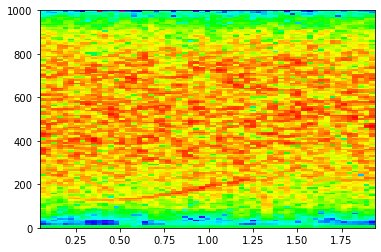

In [57]:
start_time = time.time()     
arrange_transformed_data(train_dir,train_spec_dir)
save_transformed_data(test_dir,test_spec_dir)
elapsed_time = time.time() - start_time
print(elapsed_time)